PRE-PROCESSING AUDIO DATA

In [109]:
#Importing Libraries

import numpy as np
import librosa, librosa.display
import matplotlib.pyplot as plt
import json
from sklearn.model_selection import train_test_split
import tensorflow.keras as keras


In [110]:
# load audio file with Librosa

FIG_SIZE = (15,10)
file = "../Project/dataset/genres_original/blues/blues.00000.wav"
signal, sample_rate = librosa.load(file, sr=22050)

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\149943227.py:5: FutureWarning: Pass sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  librosa.display.waveshow(signal, sample_rate, alpha=0.4)


Text(0.5, 1.0, 'Waveform')

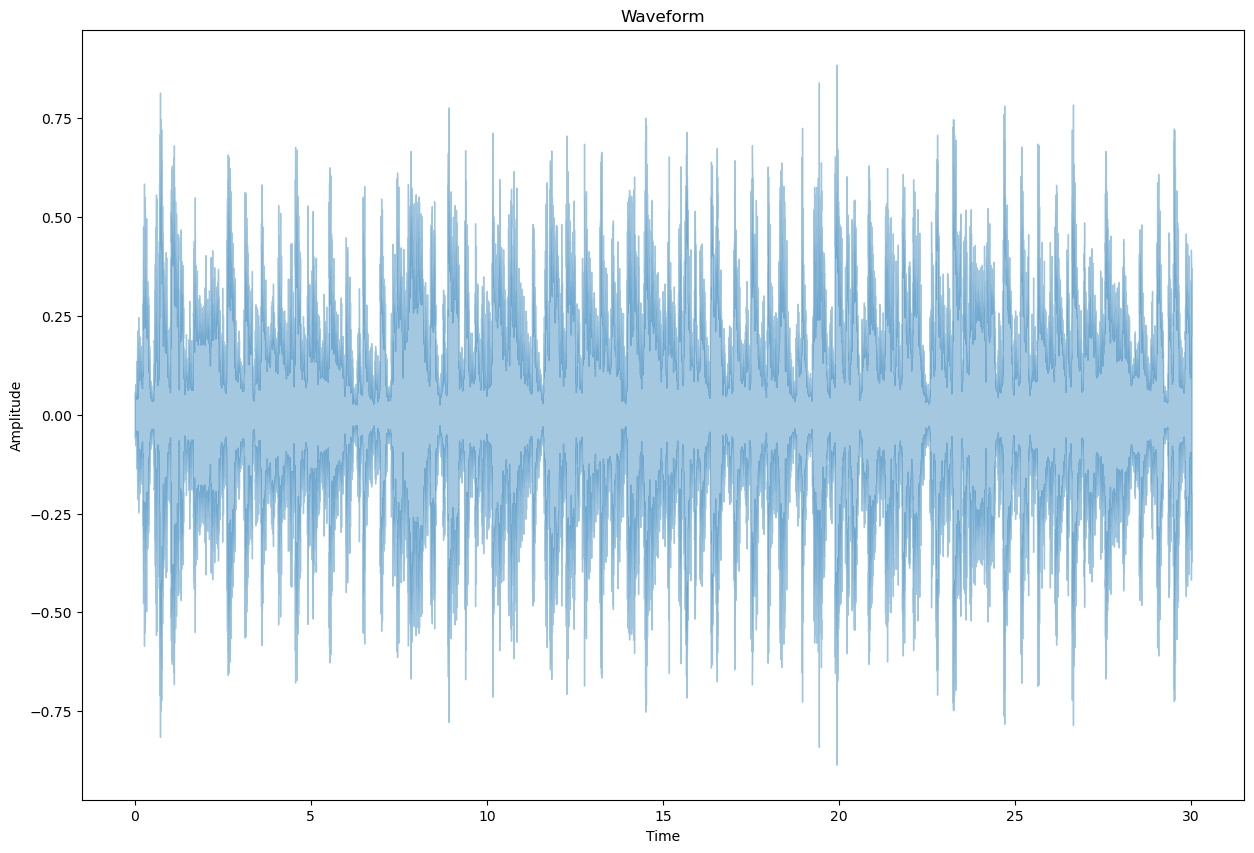

In [111]:
# WAVEFORM
# display waveform

plt.figure(figsize=FIG_SIZE)
librosa.display.waveshow(signal, sample_rate, alpha=0.4)
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.title("Waveform")

In [112]:
# FFT -> power spectrum
# perform Fourier transform

fft = np.fft.fft(signal)

In [113]:
# calculate abs values on complex numbers to get magnitude

spectrum = np.abs(fft)

In [114]:
# create frequency variable

f = np.linspace(0, sample_rate, len(spectrum))

In [115]:
# take half of the spectrum and frequency

left_spectrum = spectrum[:int(len(spectrum)/2)]
left_f = f[:int(len(spectrum)/2)]

Text(0.5, 1.0, 'Power spectrum')

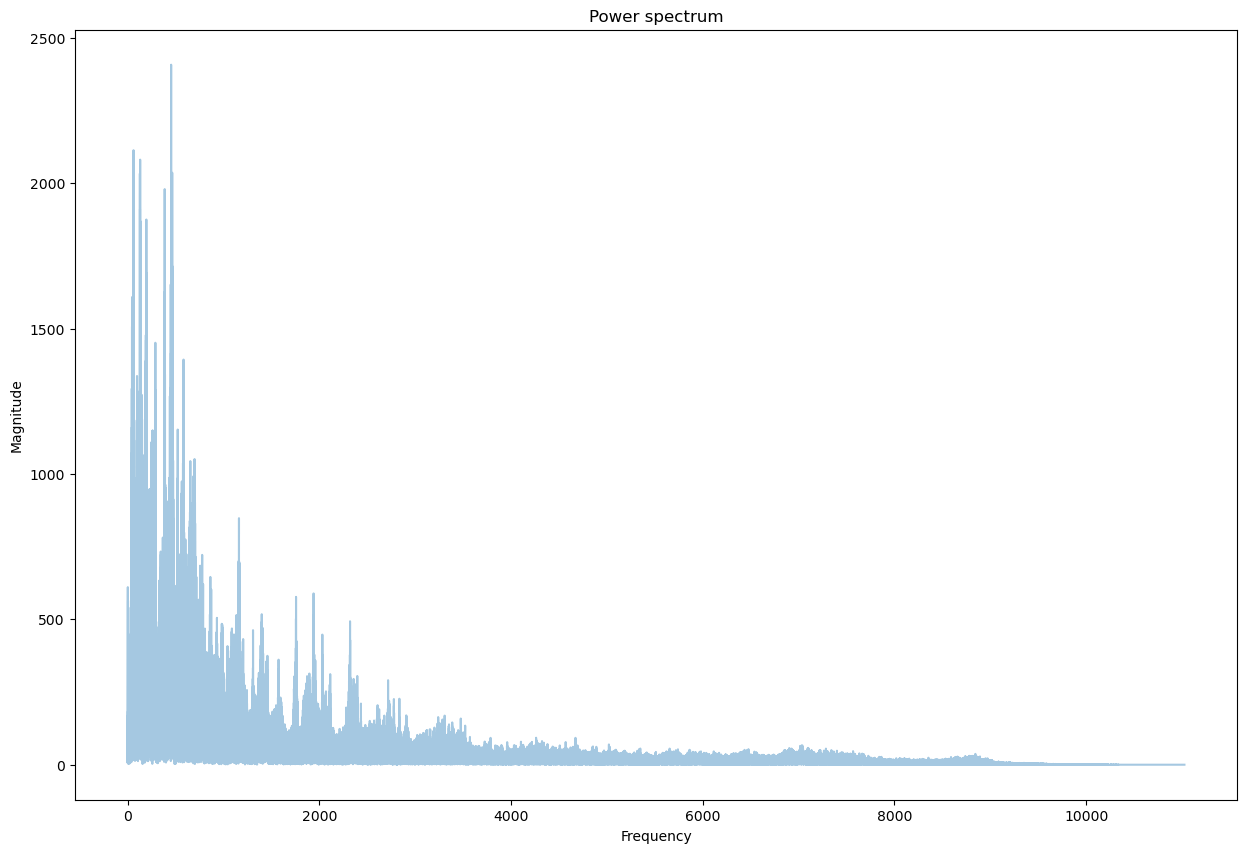

In [116]:
# plot spectrum

plt.figure(figsize=FIG_SIZE)
plt.plot(left_f, left_spectrum, alpha=0.4)
plt.xlabel("Frequency")
plt.ylabel("Magnitude")
plt.title("Power spectrum")

In [117]:
# STFT -> spectrogram

hop_length = 512 # in num. of samples
n_fft = 2048 # window in num. of samples


In [118]:
# calculate duration hop length and window in seconds

hop_length_duration = float(hop_length)/sample_rate
n_fft_duration = float(n_fft)/sample_rate
print("STFT hop length duration is: {}s".format(hop_length_duration))
print("STFT window duration is: {}s".format(n_fft_duration))

STFT hop length duration is: 0.023219954648526078s
STFT window duration is: 0.09287981859410431s


In [119]:
# perform stft
stft = librosa.stft(signal, n_fft=n_fft, hop_length=hop_length)

In [120]:
# calculate abs values on complex numbers to get magnitude
spectrogram = np.abs(stft)

Text(0.5, 1.0, 'Spectrogram')

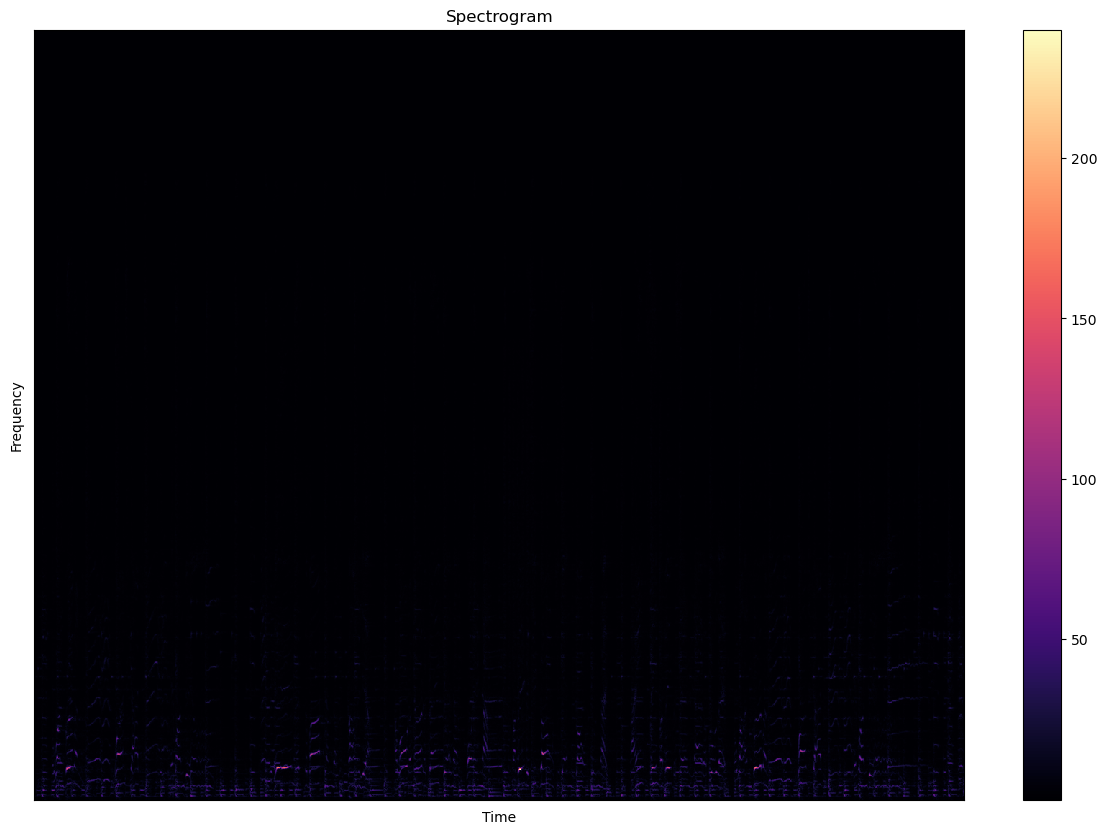

In [121]:
# display spectrogram

plt.figure(figsize=FIG_SIZE)
librosa.display.specshow(spectrogram, sr=sample_rate, hop_length=hop_length)
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar()
plt.title("Spectrogram")

Text(0.5, 1.0, 'Spectrogram (dB)')

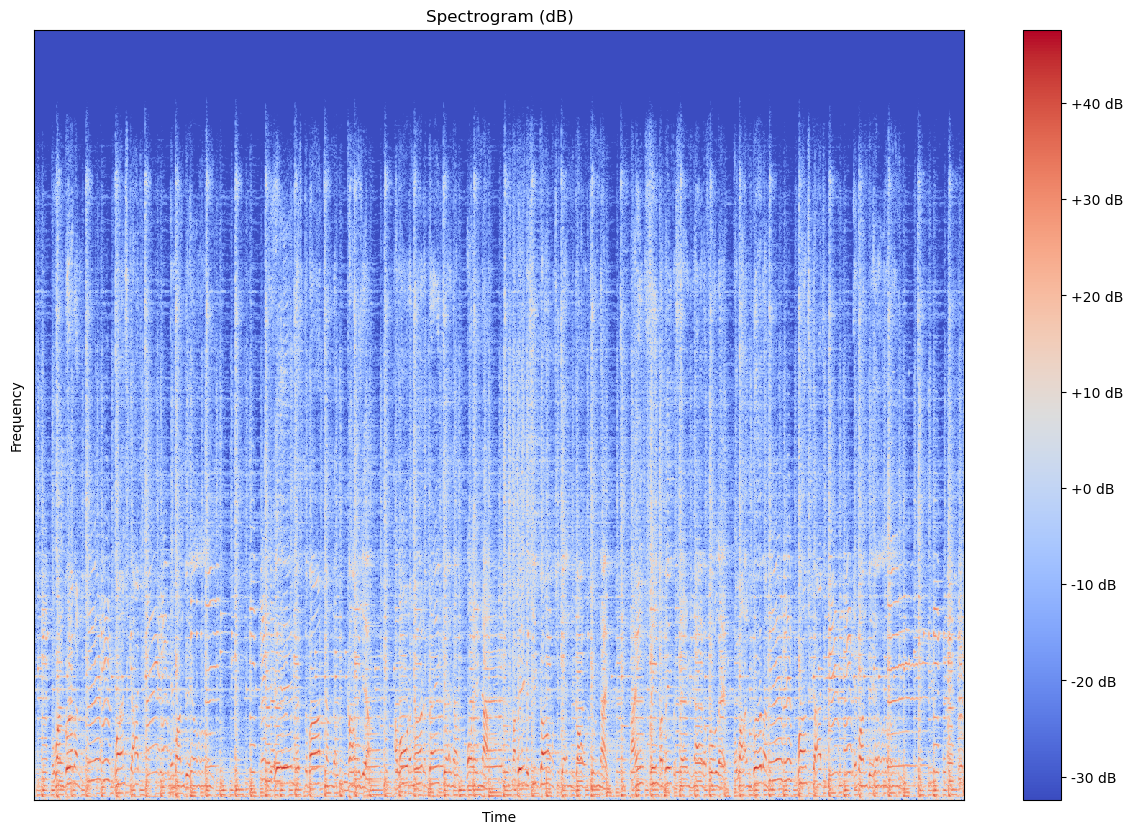

In [122]:
# apply logarithm to cast amplitude to Decibels

log_spectrogram = librosa.amplitude_to_db(spectrogram)

plt.figure(figsize=FIG_SIZE)
librosa.display.specshow(log_spectrogram, sr=sample_rate, hop_length=hop_length)
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar(format="%+2.0f dB")
plt.title("Spectrogram (dB)")

In [123]:
# MFCCs
# extract 13 MFCCs
MFCCs = librosa.feature.mfcc(signal, sample_rate, n_fft=n_fft, hop_length=hop_length, n_mfcc=13)

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\1113811453.py:3: FutureWarning: Pass y=[ 0.00732422  0.01660156  0.00762939 ... -0.05560303 -0.06106567
 -0.06417847], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  MFCCs = librosa.feature.mfcc(signal, sample_rate, n_fft=n_fft, hop_length=hop_length, n_mfcc=13)


Text(0.5, 1.0, 'MFCCs')

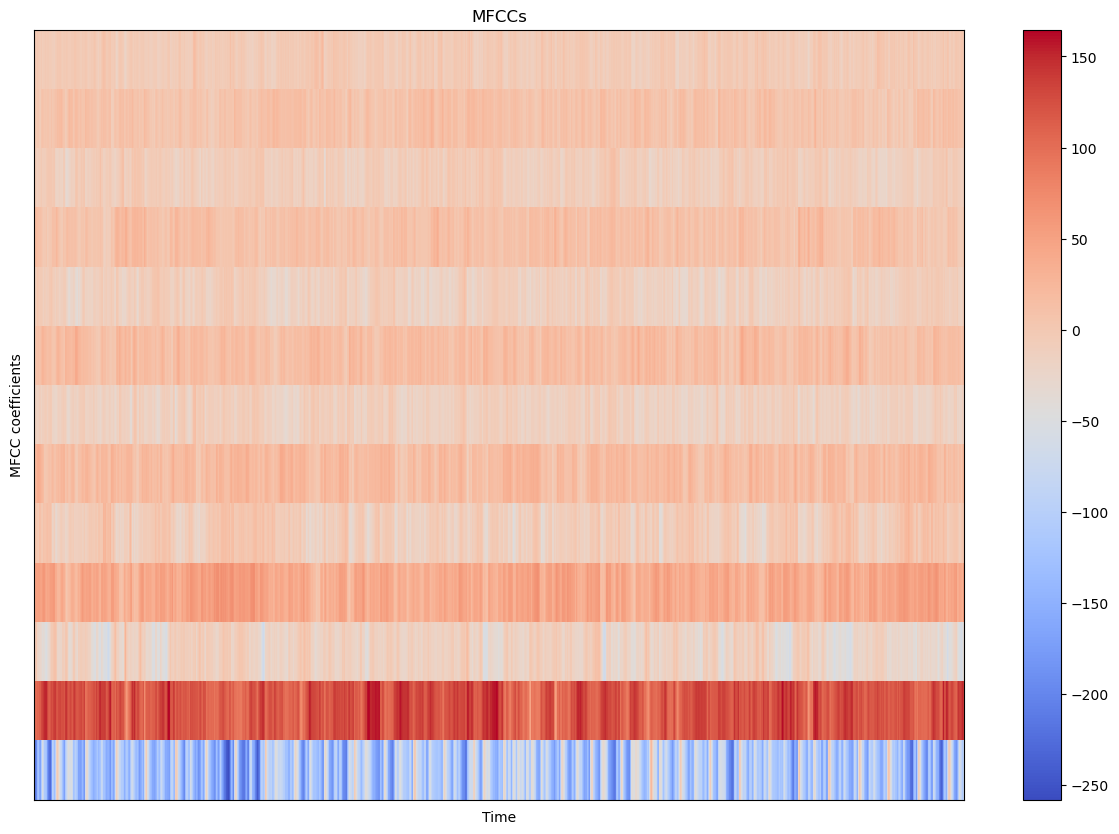

In [124]:
# display MFCCs
plt.figure(figsize=FIG_SIZE)
librosa.display.specshow(MFCCs, sr=sample_rate, hop_length=hop_length)
plt.xlabel("Time")
plt.ylabel("MFCC coefficients")
plt.colorbar()
plt.title("MFCCs")

DATA EXTRACTION

In [125]:
DATASET_PATH = "../Project/dataset/genres_original/"
JSON_PATH = "data_10.json"
SAMPLE_RATE = 22050
TRACK_DURATION = 30 # measured in seconds
SAMPLES_PER_TRACK = SAMPLE_RATE * TRACK_DURATION


def save_mfcc(dataset_path, json_path, num_mfcc=13, n_fft=2048, hop_length=512, num_segments=5):
    """Extracts MFCCs from music dataset and saves them into a json file along witgh genre labels.
        :param dataset_path (str): Path to dataset
        :param json_path (str): Path to json file used to save MFCCs
        :param num_mfcc (int): Number of coefficients to extract
        :param n_fft (int): Interval we consider to apply FFT. Measured in # of samples
        :param hop_length (int): Sliding window for FFT. Measured in # of samples
        :param: num_segments (int): Number of segments we want to divide sample tracks into
        :return:
        """

    # dictionary to store mapping, labels, and MFCCs
    data = {
        "mapping": [],
        "labels": [],
        "mfcc": []
    }

    samples_per_segment = int(SAMPLES_PER_TRACK / num_segments)
    num_mfcc_vectors_per_segment = math.ceil(samples_per_segment / hop_length)

    # loop through all genre sub-folder
    for i, (dirpath, dirnames, filenames) in enumerate(os.walk(dataset_path)):

        # ensure we're processing a genre sub-folder level
        if dirpath is not dataset_path:

            # save genre label (i.e., sub-folder name) in the mapping
            semantic_label = dirpath.split("/")[-1]
            data["mapping"].append(semantic_label)
            print("\nProcessing: {}".format(semantic_label))

            # process all audio files in genre sub-dir
            for f in filenames:

		# load audio file
                file_path = os.path.join(dirpath, f)
                signal, sample_rate = librosa.load(file_path, sr=SAMPLE_RATE)

                # process all segments of audio file
                for d in range(num_segments):

                    # calculate start and finish sample for current segment
                    start = samples_per_segment * d
                    finish = start + samples_per_segment

                    # extract mfcc
                    mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
                    mfcc = mfcc.T

                    # store only mfcc feature with expected number of vectors
                    if len(mfcc) == num_mfcc_vectors_per_segment:
                        data["mfcc"].append(mfcc.tolist())
                        data["labels"].append(i-1)
                        print("{}, segment:{}".format(file_path, d+1))

    # save MFCCs to json file
    with open(json_path, "w") as fp:
        json.dump(data, fp, indent=4)
        
        
if __name__ == "__main__":
    save_mfcc(DATASET_PATH, JSON_PATH, num_segments=10)


Processing: blues
../Project/dataset/genres_original/blues\blues.00000.wav, segment:1
../Project/dataset/genres_original/blues\blues.00000.wav, segment:2
../Project/dataset/genres_original/blues\blues.00000.wav, segment:3
../Project/dataset/genres_original/blues\blues.00000.wav, segment:4
../Project/dataset/genres_original/blues\blues.00000.wav, segment:5
../Project/dataset/genres_original/blues\blues.00000.wav, segment:6
../Project/dataset/genres_original/blues\blues.00000.wav, segment:7
../Project/dataset/genres_original/blues\blues.00000.wav, segment:8
../Project/dataset/genres_original/blues\blues.00000.wav, segment:9
../Project/dataset/genres_original/blues\blues.00000.wav, segment:10
../Project/dataset/genres_original/blues\blues.00001.wav, segment:1
../Project/dataset/genres_original/blues\blues.00001.wav, segment:2
../Project/dataset/genres_original/blues\blues.00001.wav, segment:3
../Project/dataset/genres_original/blues\blues.00001.wav, segment:4
../Project/dataset/genres_or

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.00732422  0.01660156  0.00762939 ... -0.04373169 -0.05706787
 -0.04086304], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.02481079 -0.02005005 -0.0357666  ...  0.00918579  0.03964233
  0.09030151], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.06256104  0.02435303 -0.00405884 ...  0.2854004   0.29364014
  0.25228882], sr=22050 as keyword args. From version 

../Project/dataset/genres_original/blues\blues.00002.wav, segment:6
../Project/dataset/genres_original/blues\blues.00002.wav, segment:7
../Project/dataset/genres_original/blues\blues.00002.wav, segment:8
../Project/dataset/genres_original/blues\blues.00002.wav, segment:9
../Project/dataset/genres_original/blues\blues.00002.wav, segment:10
../Project/dataset/genres_original/blues\blues.00003.wav, segment:1
../Project/dataset/genres_original/blues\blues.00003.wav, segment:2
../Project/dataset/genres_original/blues\blues.00003.wav, segment:3
../Project/dataset/genres_original/blues\blues.00003.wav, segment:4
../Project/dataset/genres_original/blues\blues.00003.wav, segment:5
../Project/dataset/genres_original/blues\blues.00003.wav, segment:6
../Project/dataset/genres_original/blues\blues.00003.wav, segment:7
../Project/dataset/genres_original/blues\blues.00003.wav, segment:8
../Project/dataset/genres_original/blues\blues.00003.wav, segment:9
../Project/dataset/genres_original/blues\blues.

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.23046875 -0.18951416 -0.17907715 ...  0.17263794  0.12786865
  0.05374146], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.01135254 -0.03265381 -0.08026123 ... -0.22531128 -0.13735962
 -0.05740356], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.04751587  0.0012207   0.0640564  ...  0.44729614  0.40100098
  0.34002686], sr=22050 as keyword args. From version 

../Project/dataset/genres_original/blues\blues.00005.wav, segment:3
../Project/dataset/genres_original/blues\blues.00005.wav, segment:4
../Project/dataset/genres_original/blues\blues.00005.wav, segment:5
../Project/dataset/genres_original/blues\blues.00005.wav, segment:6
../Project/dataset/genres_original/blues\blues.00005.wav, segment:7
../Project/dataset/genres_original/blues\blues.00005.wav, segment:8
../Project/dataset/genres_original/blues\blues.00005.wav, segment:9
../Project/dataset/genres_original/blues\blues.00005.wav, segment:10
../Project/dataset/genres_original/blues\blues.00006.wav, segment:1
../Project/dataset/genres_original/blues\blues.00006.wav, segment:2
../Project/dataset/genres_original/blues\blues.00006.wav, segment:3
../Project/dataset/genres_original/blues\blues.00006.wav, segment:4
../Project/dataset/genres_original/blues\blues.00006.wav, segment:5
../Project/dataset/genres_original/blues\blues.00006.wav, segment:6
../Project/dataset/genres_original/blues\blues.

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.03134155  0.03414917  0.0340271  ...  0.0586853  -0.04284668
 -0.11941528], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.1390686  -0.14248657 -0.0899353  ... -0.02719116 -0.0333252
 -0.03308105], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.02841187 -0.02484131 -0.02194214 ... -0.08883667 -0.07183838
 -0.06854248], sr=22050 as keyword args. From version 0

../Project/dataset/genres_original/blues\blues.00008.wav, segment:1
../Project/dataset/genres_original/blues\blues.00008.wav, segment:2
../Project/dataset/genres_original/blues\blues.00008.wav, segment:3
../Project/dataset/genres_original/blues\blues.00008.wav, segment:4
../Project/dataset/genres_original/blues\blues.00008.wav, segment:5
../Project/dataset/genres_original/blues\blues.00008.wav, segment:6
../Project/dataset/genres_original/blues\blues.00008.wav, segment:7
../Project/dataset/genres_original/blues\blues.00008.wav, segment:8
../Project/dataset/genres_original/blues\blues.00008.wav, segment:9
../Project/dataset/genres_original/blues\blues.00008.wav, segment:10
../Project/dataset/genres_original/blues\blues.00009.wav, segment:1
../Project/dataset/genres_original/blues\blues.00009.wav, segment:2
../Project/dataset/genres_original/blues\blues.00009.wav, segment:3
../Project/dataset/genres_original/blues\blues.00009.wav, segment:4
../Project/dataset/genres_original/blues\blues.

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.01843262  0.00799561 -0.00250244 ...  0.09658813  0.09082031
  0.0703125 ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.03726196 -0.00561523 -0.05566406 ... -0.06948853 -0.07192993
 -0.07434082], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.02560425 -0.03881836 -0.03527832 ...  0.0435791   0.04718018
  0.04199219], sr=22050 as keyword args. From version 

../Project/dataset/genres_original/blues\blues.00013.wav, segment:6
../Project/dataset/genres_original/blues\blues.00013.wav, segment:7
../Project/dataset/genres_original/blues\blues.00013.wav, segment:8
../Project/dataset/genres_original/blues\blues.00013.wav, segment:9
../Project/dataset/genres_original/blues\blues.00013.wav, segment:10
../Project/dataset/genres_original/blues\blues.00014.wav, segment:1
../Project/dataset/genres_original/blues\blues.00014.wav, segment:2
../Project/dataset/genres_original/blues\blues.00014.wav, segment:3
../Project/dataset/genres_original/blues\blues.00014.wav, segment:4
../Project/dataset/genres_original/blues\blues.00014.wav, segment:5
../Project/dataset/genres_original/blues\blues.00014.wav, segment:6
../Project/dataset/genres_original/blues\blues.00014.wav, segment:7
../Project/dataset/genres_original/blues\blues.00014.wav, segment:8
../Project/dataset/genres_original/blues\blues.00014.wav, segment:9
../Project/dataset/genres_original/blues\blues.

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[0.00421143 0.00906372 0.00579834 ... 0.03952026 0.03512573 0.0090332 ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.02627563 -0.0557251  -0.07244873 ... -0.08059692 -0.07849121
 -0.0788269 ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.08117676 -0.07943726 -0.07611084 ... -0.1998291  -0.21252441
 -0.21755981], sr=22050 as keyword args. From version 0.10 pa

../Project/dataset/genres_original/blues\blues.00016.wav, segment:4
../Project/dataset/genres_original/blues\blues.00016.wav, segment:5
../Project/dataset/genres_original/blues\blues.00016.wav, segment:6
../Project/dataset/genres_original/blues\blues.00016.wav, segment:7
../Project/dataset/genres_original/blues\blues.00016.wav, segment:8
../Project/dataset/genres_original/blues\blues.00016.wav, segment:9
../Project/dataset/genres_original/blues\blues.00016.wav, segment:10
../Project/dataset/genres_original/blues\blues.00017.wav, segment:1
../Project/dataset/genres_original/blues\blues.00017.wav, segment:2
../Project/dataset/genres_original/blues\blues.00017.wav, segment:3
../Project/dataset/genres_original/blues\blues.00017.wav, segment:4
../Project/dataset/genres_original/blues\blues.00017.wav, segment:5
../Project/dataset/genres_original/blues\blues.00017.wav, segment:6
../Project/dataset/genres_original/blues\blues.00017.wav, segment:7
../Project/dataset/genres_original/blues\blues.

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.02355957 -0.02905273 -0.03234863 ...  0.05758667  0.06027222
  0.06469727], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.05981445  0.04962158  0.03817749 ... -0.006073    0.0022583
  0.00579834], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.00442505  0.00137329  0.00210571 ... -0.04815674 -0.0536499
 -0.05999756], sr=22050 as keyword args. From version 0.

../Project/dataset/genres_original/blues\blues.00019.wav, segment:2
../Project/dataset/genres_original/blues\blues.00019.wav, segment:3
../Project/dataset/genres_original/blues\blues.00019.wav, segment:4
../Project/dataset/genres_original/blues\blues.00019.wav, segment:5
../Project/dataset/genres_original/blues\blues.00019.wav, segment:6
../Project/dataset/genres_original/blues\blues.00019.wav, segment:7
../Project/dataset/genres_original/blues\blues.00019.wav, segment:8
../Project/dataset/genres_original/blues\blues.00019.wav, segment:9
../Project/dataset/genres_original/blues\blues.00019.wav, segment:10
../Project/dataset/genres_original/blues\blues.00020.wav, segment:1
../Project/dataset/genres_original/blues\blues.00020.wav, segment:2
../Project/dataset/genres_original/blues\blues.00020.wav, segment:3
../Project/dataset/genres_original/blues\blues.00020.wav, segment:4
../Project/dataset/genres_original/blues\blues.00020.wav, segment:5
../Project/dataset/genres_original/blues\blues.

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[0.00375366 0.00726318 0.01028442 ... 0.0402832  0.09011841 0.14981079], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.20217896  0.22918701  0.23022461 ... -0.03735352 -0.04751587
 -0.04800415], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.03952026 -0.03216553 -0.03231812 ...  0.03326416  0.03619385
  0.03985596], sr=22050 as keyword args. From version 0.10 pa

../Project/dataset/genres_original/blues\blues.00021.wav, segment:10
../Project/dataset/genres_original/blues\blues.00022.wav, segment:1
../Project/dataset/genres_original/blues\blues.00022.wav, segment:2
../Project/dataset/genres_original/blues\blues.00022.wav, segment:3
../Project/dataset/genres_original/blues\blues.00022.wav, segment:4
../Project/dataset/genres_original/blues\blues.00022.wav, segment:5
../Project/dataset/genres_original/blues\blues.00022.wav, segment:6
../Project/dataset/genres_original/blues\blues.00022.wav, segment:7
../Project/dataset/genres_original/blues\blues.00022.wav, segment:8
../Project/dataset/genres_original/blues\blues.00022.wav, segment:9
../Project/dataset/genres_original/blues\blues.00022.wav, segment:10
../Project/dataset/genres_original/blues\blues.00023.wav, segment:1
../Project/dataset/genres_original/blues\blues.00023.wav, segment:2
../Project/dataset/genres_original/blues\blues.00023.wav, segment:3
../Project/dataset/genres_original/blues\blues

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.07327271 -0.1105957  -0.10214233 ... -0.06503296 -0.05596924
 -0.04669189], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.03518677 -0.02392578 -0.01480103 ...  0.10241699  0.08187866
  0.07125854], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.07354736  0.08670044  0.09439087 ...  0.02908325 -0.06677246
 -0.14480591], sr=22050 as keyword args. From version 

../Project/dataset/genres_original/blues\blues.00024.wav, segment:7
../Project/dataset/genres_original/blues\blues.00024.wav, segment:8
../Project/dataset/genres_original/blues\blues.00024.wav, segment:9
../Project/dataset/genres_original/blues\blues.00024.wav, segment:10
../Project/dataset/genres_original/blues\blues.00025.wav, segment:1
../Project/dataset/genres_original/blues\blues.00025.wav, segment:2
../Project/dataset/genres_original/blues\blues.00025.wav, segment:3
../Project/dataset/genres_original/blues\blues.00025.wav, segment:4
../Project/dataset/genres_original/blues\blues.00025.wav, segment:5
../Project/dataset/genres_original/blues\blues.00025.wav, segment:6
../Project/dataset/genres_original/blues\blues.00025.wav, segment:7
../Project/dataset/genres_original/blues\blues.00025.wav, segment:8
../Project/dataset/genres_original/blues\blues.00025.wav, segment:9
../Project/dataset/genres_original/blues\blues.00025.wav, segment:10
../Project/dataset/genres_original/blues\blues

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[0.02215576 0.02407837 0.02462769 ... 0.21099854 0.23132324 0.23950195], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[0.23284912 0.22930908 0.24578857 ... 0.08761597 0.12905884 0.16809082], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.18661499  0.19140625  0.20080566 ... -0.01086426 -0.00952148
 -0.00756836], sr=22050 as keyword args. From version 0.10 passing t

../Project/dataset/genres_original/blues\blues.00027.wav, segment:4
../Project/dataset/genres_original/blues\blues.00027.wav, segment:5
../Project/dataset/genres_original/blues\blues.00027.wav, segment:6
../Project/dataset/genres_original/blues\blues.00027.wav, segment:7
../Project/dataset/genres_original/blues\blues.00027.wav, segment:8
../Project/dataset/genres_original/blues\blues.00027.wav, segment:9
../Project/dataset/genres_original/blues\blues.00027.wav, segment:10
../Project/dataset/genres_original/blues\blues.00028.wav, segment:1
../Project/dataset/genres_original/blues\blues.00028.wav, segment:2
../Project/dataset/genres_original/blues\blues.00028.wav, segment:3
../Project/dataset/genres_original/blues\blues.00028.wav, segment:4
../Project/dataset/genres_original/blues\blues.00028.wav, segment:5
../Project/dataset/genres_original/blues\blues.00028.wav, segment:6
../Project/dataset/genres_original/blues\blues.00028.wav, segment:7
../Project/dataset/genres_original/blues\blues.

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.11422729  0.08398438  0.0491333  ... -0.02178955 -0.01571655
  0.00387573], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[0.02670288 0.04559326 0.05795288 ... 0.11306763 0.09020996 0.06069946], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.02700806 -0.01766968 -0.07830811 ... -0.04049683 -0.03988647
 -0.04138184], sr=22050 as keyword args. From version 0.10 pa

../Project/dataset/genres_original/blues\blues.00030.wav, segment:2
../Project/dataset/genres_original/blues\blues.00030.wav, segment:3
../Project/dataset/genres_original/blues\blues.00030.wav, segment:4
../Project/dataset/genres_original/blues\blues.00030.wav, segment:5
../Project/dataset/genres_original/blues\blues.00030.wav, segment:6
../Project/dataset/genres_original/blues\blues.00030.wav, segment:7
../Project/dataset/genres_original/blues\blues.00030.wav, segment:8
../Project/dataset/genres_original/blues\blues.00030.wav, segment:9
../Project/dataset/genres_original/blues\blues.00030.wav, segment:10
../Project/dataset/genres_original/blues\blues.00031.wav, segment:1
../Project/dataset/genres_original/blues\blues.00031.wav, segment:2
../Project/dataset/genres_original/blues\blues.00031.wav, segment:3
../Project/dataset/genres_original/blues\blues.00031.wav, segment:4
../Project/dataset/genres_original/blues\blues.00031.wav, segment:5
../Project/dataset/genres_original/blues\blues.

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[0.11328125 0.07928467 0.04437256 ... 0.14672852 0.08337402 0.0479126 ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.06735229  0.05249023  0.05819702 ... -0.20758057 -0.21917725
 -0.24835205], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.2597046  -0.26281738 -0.27523804 ... -0.23788452 -0.28305054
 -0.2614746 ], sr=22050 as keyword args. From version 0.10 pa

../Project/dataset/genres_original/blues\blues.00033.wav, segment:1
../Project/dataset/genres_original/blues\blues.00033.wav, segment:2
../Project/dataset/genres_original/blues\blues.00033.wav, segment:3
../Project/dataset/genres_original/blues\blues.00033.wav, segment:4
../Project/dataset/genres_original/blues\blues.00033.wav, segment:5
../Project/dataset/genres_original/blues\blues.00033.wav, segment:6
../Project/dataset/genres_original/blues\blues.00033.wav, segment:7
../Project/dataset/genres_original/blues\blues.00033.wav, segment:8
../Project/dataset/genres_original/blues\blues.00033.wav, segment:9
../Project/dataset/genres_original/blues\blues.00033.wav, segment:10
../Project/dataset/genres_original/blues\blues.00034.wav, segment:1
../Project/dataset/genres_original/blues\blues.00034.wav, segment:2
../Project/dataset/genres_original/blues\blues.00034.wav, segment:3
../Project/dataset/genres_original/blues\blues.00034.wav, segment:4
../Project/dataset/genres_original/blues\blues.

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[0.02435303 0.02676392 0.0291748  ... 0.18234253 0.14883423 0.184021  ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[0.18869019 0.19281006 0.23617554 ... 0.04275513 0.04284668 0.04006958], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[0.04138184 0.04025269 0.03112793 ... 0.13623047 0.1465149  0.14233398], sr=22050 as keyword args. From version 0.10 passing these as

../Project/dataset/genres_original/blues\blues.00035.wav, segment:9
../Project/dataset/genres_original/blues\blues.00035.wav, segment:10
../Project/dataset/genres_original/blues\blues.00036.wav, segment:1
../Project/dataset/genres_original/blues\blues.00036.wav, segment:2
../Project/dataset/genres_original/blues\blues.00036.wav, segment:3
../Project/dataset/genres_original/blues\blues.00036.wav, segment:4
../Project/dataset/genres_original/blues\blues.00036.wav, segment:5
../Project/dataset/genres_original/blues\blues.00036.wav, segment:6
../Project/dataset/genres_original/blues\blues.00036.wav, segment:7
../Project/dataset/genres_original/blues\blues.00036.wav, segment:8
../Project/dataset/genres_original/blues\blues.00036.wav, segment:9
../Project/dataset/genres_original/blues\blues.00036.wav, segment:10
../Project/dataset/genres_original/blues\blues.00037.wav, segment:1
../Project/dataset/genres_original/blues\blues.00037.wav, segment:2
../Project/dataset/genres_original/blues\blues

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.02301025 -0.02377319 -0.02572632 ...  0.06872559  0.08843994
  0.09674072], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.17077637 -0.27716064 -0.26010132 ... -0.08175659 -0.07315063
 -0.04443359], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.00491333  0.03466797  0.05718994 ... -0.11575317 -0.12753296
 -0.115448  ], sr=22050 as keyword args. From version 

../Project/dataset/genres_original/blues\blues.00038.wav, segment:7
../Project/dataset/genres_original/blues\blues.00038.wav, segment:8
../Project/dataset/genres_original/blues\blues.00038.wav, segment:9
../Project/dataset/genres_original/blues\blues.00038.wav, segment:10
../Project/dataset/genres_original/blues\blues.00039.wav, segment:1
../Project/dataset/genres_original/blues\blues.00039.wav, segment:2
../Project/dataset/genres_original/blues\blues.00039.wav, segment:3
../Project/dataset/genres_original/blues\blues.00039.wav, segment:4
../Project/dataset/genres_original/blues\blues.00039.wav, segment:5
../Project/dataset/genres_original/blues\blues.00039.wav, segment:6
../Project/dataset/genres_original/blues\blues.00039.wav, segment:7
../Project/dataset/genres_original/blues\blues.00039.wav, segment:8
../Project/dataset/genres_original/blues\blues.00039.wav, segment:9
../Project/dataset/genres_original/blues\blues.00039.wav, segment:10
../Project/dataset/genres_original/blues\blues

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.01409912  0.00674438 -0.00100708 ... -0.1324768  -0.09368896
 -0.10928345], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.05899048 -0.00292969 -0.00704956 ...  0.52911377  0.50616455
  0.5074158 ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.51712036  0.5145874   0.534729   ... -0.06173706 -0.04653931
 -0.04977417], sr=22050 as keyword args. From version 

../Project/dataset/genres_original/blues\blues.00041.wav, segment:4
../Project/dataset/genres_original/blues\blues.00041.wav, segment:5
../Project/dataset/genres_original/blues\blues.00041.wav, segment:6
../Project/dataset/genres_original/blues\blues.00041.wav, segment:7
../Project/dataset/genres_original/blues\blues.00041.wav, segment:8
../Project/dataset/genres_original/blues\blues.00041.wav, segment:9
../Project/dataset/genres_original/blues\blues.00041.wav, segment:10
../Project/dataset/genres_original/blues\blues.00042.wav, segment:1
../Project/dataset/genres_original/blues\blues.00042.wav, segment:2
../Project/dataset/genres_original/blues\blues.00042.wav, segment:3
../Project/dataset/genres_original/blues\blues.00042.wav, segment:4
../Project/dataset/genres_original/blues\blues.00042.wav, segment:5
../Project/dataset/genres_original/blues\blues.00042.wav, segment:6
../Project/dataset/genres_original/blues\blues.00042.wav, segment:7
../Project/dataset/genres_original/blues\blues.

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.01568604  0.01364136  0.02792358 ...  0.01589966 -0.06033325
 -0.16290283], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.14205933 -0.04498291  0.02981567 ...  0.1767273   0.16488647
  0.1465149 ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.13000488  0.14440918  0.13931274 ... -0.19952393 -0.20986938
 -0.20321655], sr=22050 as keyword args. From version 

../Project/dataset/genres_original/blues\blues.00044.wav, segment:1
../Project/dataset/genres_original/blues\blues.00044.wav, segment:2
../Project/dataset/genres_original/blues\blues.00044.wav, segment:3
../Project/dataset/genres_original/blues\blues.00044.wav, segment:4
../Project/dataset/genres_original/blues\blues.00044.wav, segment:5
../Project/dataset/genres_original/blues\blues.00044.wav, segment:6
../Project/dataset/genres_original/blues\blues.00044.wav, segment:7
../Project/dataset/genres_original/blues\blues.00044.wav, segment:8
../Project/dataset/genres_original/blues\blues.00044.wav, segment:9
../Project/dataset/genres_original/blues\blues.00044.wav, segment:10
../Project/dataset/genres_original/blues\blues.00045.wav, segment:1
../Project/dataset/genres_original/blues\blues.00045.wav, segment:2
../Project/dataset/genres_original/blues\blues.00045.wav, segment:3
../Project/dataset/genres_original/blues\blues.00045.wav, segment:4
../Project/dataset/genres_original/blues\blues.

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.00796509 -0.0246582  -0.02514648 ... -0.11752319 -0.1298523
 -0.16323853], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.15841675 -0.1411438  -0.18984985 ... -0.05285645 -0.07473755
 -0.03741455], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.11392212 -0.1769104  -0.18286133 ... -0.09176636 -0.11166382
 -0.10177612], sr=22050 as keyword args. From version 0

../Project/dataset/genres_original/blues\blues.00046.wav, segment:8
../Project/dataset/genres_original/blues\blues.00046.wav, segment:9
../Project/dataset/genres_original/blues\blues.00046.wav, segment:10
../Project/dataset/genres_original/blues\blues.00047.wav, segment:1
../Project/dataset/genres_original/blues\blues.00047.wav, segment:2
../Project/dataset/genres_original/blues\blues.00047.wav, segment:3
../Project/dataset/genres_original/blues\blues.00047.wav, segment:4
../Project/dataset/genres_original/blues\blues.00047.wav, segment:5
../Project/dataset/genres_original/blues\blues.00047.wav, segment:6
../Project/dataset/genres_original/blues\blues.00047.wav, segment:7
../Project/dataset/genres_original/blues\blues.00047.wav, segment:8
../Project/dataset/genres_original/blues\blues.00047.wav, segment:9
../Project/dataset/genres_original/blues\blues.00047.wav, segment:10
../Project/dataset/genres_original/blues\blues.00048.wav, segment:1
../Project/dataset/genres_original/blues\blues

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.04925537  0.05923462  0.05993652 ...  0.02267456 -0.00750732
 -0.02886963], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.07302856 -0.09442139 -0.06774902 ...  0.05761719  0.03924561
  0.0022583 ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.10806274 -0.15075684 -0.17327881 ... -0.18600464 -0.1602478
 -0.14117432], sr=22050 as keyword args. From version 0

../Project/dataset/genres_original/blues\blues.00049.wav, segment:3
../Project/dataset/genres_original/blues\blues.00049.wav, segment:4
../Project/dataset/genres_original/blues\blues.00049.wav, segment:5
../Project/dataset/genres_original/blues\blues.00049.wav, segment:6
../Project/dataset/genres_original/blues\blues.00049.wav, segment:7
../Project/dataset/genres_original/blues\blues.00049.wav, segment:8
../Project/dataset/genres_original/blues\blues.00049.wav, segment:9
../Project/dataset/genres_original/blues\blues.00049.wav, segment:10
../Project/dataset/genres_original/blues\blues.00050.wav, segment:1
../Project/dataset/genres_original/blues\blues.00050.wav, segment:2
../Project/dataset/genres_original/blues\blues.00050.wav, segment:3
../Project/dataset/genres_original/blues\blues.00050.wav, segment:4
../Project/dataset/genres_original/blues\blues.00050.wav, segment:5
../Project/dataset/genres_original/blues\blues.00050.wav, segment:6
../Project/dataset/genres_original/blues\blues.

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.15756226  0.14645386  0.15124512 ... -0.07189941 -0.07766724
 -0.0793457 ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.08676147 -0.10150146 -0.09829712 ... -0.00875854  0.01409912
  0.02069092], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.00079346 -0.01037598 -0.00692749 ...  0.02752686  0.0302124
  0.02871704], sr=22050 as keyword args. From version 0

../Project/dataset/genres_original/blues\blues.00051.wav, segment:9
../Project/dataset/genres_original/blues\blues.00051.wav, segment:10
../Project/dataset/genres_original/blues\blues.00052.wav, segment:1
../Project/dataset/genres_original/blues\blues.00052.wav, segment:2
../Project/dataset/genres_original/blues\blues.00052.wav, segment:3
../Project/dataset/genres_original/blues\blues.00052.wav, segment:4
../Project/dataset/genres_original/blues\blues.00052.wav, segment:5
../Project/dataset/genres_original/blues\blues.00052.wav, segment:6
../Project/dataset/genres_original/blues\blues.00052.wav, segment:7
../Project/dataset/genres_original/blues\blues.00052.wav, segment:8
../Project/dataset/genres_original/blues\blues.00052.wav, segment:9
../Project/dataset/genres_original/blues\blues.00052.wav, segment:10
../Project/dataset/genres_original/blues\blues.00053.wav, segment:1
../Project/dataset/genres_original/blues\blues.00053.wav, segment:2
../Project/dataset/genres_original/blues\blues

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.2290039   0.20153809  0.14056396 ... -0.07632446 -0.08181763
 -0.12353516], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.01705933  0.03436279  0.03353882 ...  0.01004028 -0.02752686
  0.03720093], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.11520386  0.10693359  0.01803589 ... -0.11303711 -0.11856079
 -0.10284424], sr=22050 as keyword args. From version 

../Project/dataset/genres_original/blues\blues.00054.wav, segment:6
../Project/dataset/genres_original/blues\blues.00054.wav, segment:7
../Project/dataset/genres_original/blues\blues.00054.wav, segment:8
../Project/dataset/genres_original/blues\blues.00054.wav, segment:9
../Project/dataset/genres_original/blues\blues.00054.wav, segment:10
../Project/dataset/genres_original/blues\blues.00055.wav, segment:1
../Project/dataset/genres_original/blues\blues.00055.wav, segment:2
../Project/dataset/genres_original/blues\blues.00055.wav, segment:3
../Project/dataset/genres_original/blues\blues.00055.wav, segment:4
../Project/dataset/genres_original/blues\blues.00055.wav, segment:5
../Project/dataset/genres_original/blues\blues.00055.wav, segment:6
../Project/dataset/genres_original/blues\blues.00055.wav, segment:7
../Project/dataset/genres_original/blues\blues.00055.wav, segment:8
../Project/dataset/genres_original/blues\blues.00055.wav, segment:9
../Project/dataset/genres_original/blues\blues.

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.17166138  0.11026001  0.17727661 ... -0.0925293  -0.04098511
 -0.03466797], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.09542847 -0.13034058 -0.07199097 ... -0.28103638 -0.33428955
 -0.39297485], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.3539734  -0.36169434 -0.4003296  ... -0.22540283 -0.33312988
 -0.4363098 ], sr=22050 as keyword args. From version 

../Project/dataset/genres_original/blues\blues.00057.wav, segment:3
../Project/dataset/genres_original/blues\blues.00057.wav, segment:4
../Project/dataset/genres_original/blues\blues.00057.wav, segment:5
../Project/dataset/genres_original/blues\blues.00057.wav, segment:6
../Project/dataset/genres_original/blues\blues.00057.wav, segment:7
../Project/dataset/genres_original/blues\blues.00057.wav, segment:8
../Project/dataset/genres_original/blues\blues.00057.wav, segment:9
../Project/dataset/genres_original/blues\blues.00057.wav, segment:10
../Project/dataset/genres_original/blues\blues.00058.wav, segment:1
../Project/dataset/genres_original/blues\blues.00058.wav, segment:2
../Project/dataset/genres_original/blues\blues.00058.wav, segment:3
../Project/dataset/genres_original/blues\blues.00058.wav, segment:4
../Project/dataset/genres_original/blues\blues.00058.wav, segment:5
../Project/dataset/genres_original/blues\blues.00058.wav, segment:6
../Project/dataset/genres_original/blues\blues.

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.11190796  0.084198    0.06015015 ...  0.04074097  0.0151062
 -0.01583862], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.0473938  -0.07171631 -0.07702637 ... -0.02084351 -0.0112915
 -0.0078125 ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.01147461 -0.01473999 -0.01522827 ... -0.2584839  -0.23764038
 -0.17407227], sr=22050 as keyword args. From version 0.

../Project/dataset/genres_original/blues\blues.00059.wav, segment:9
../Project/dataset/genres_original/blues\blues.00059.wav, segment:10
../Project/dataset/genres_original/blues\blues.00060.wav, segment:1
../Project/dataset/genres_original/blues\blues.00060.wav, segment:2
../Project/dataset/genres_original/blues\blues.00060.wav, segment:3
../Project/dataset/genres_original/blues\blues.00060.wav, segment:4
../Project/dataset/genres_original/blues\blues.00060.wav, segment:5
../Project/dataset/genres_original/blues\blues.00060.wav, segment:6
../Project/dataset/genres_original/blues\blues.00060.wav, segment:7
../Project/dataset/genres_original/blues\blues.00060.wav, segment:8
../Project/dataset/genres_original/blues\blues.00060.wav, segment:9
../Project/dataset/genres_original/blues\blues.00060.wav, segment:10
../Project/dataset/genres_original/blues\blues.00061.wav, segment:1
../Project/dataset/genres_original/blues\blues.00061.wav, segment:2
../Project/dataset/genres_original/blues\blues

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.11523438 -0.12982178 -0.11001587 ...  0.04165649 -0.07263184
 -0.13482666], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[0.16952515 0.29315186 0.1512146  ... 0.03158569 0.0562439  0.0335083 ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.09140015  0.13760376  0.1048584  ...  0.07247925  0.06039429
 -0.00094604], sr=22050 as keyword args. From version 0.10 pa

../Project/dataset/genres_original/blues\blues.00062.wav, segment:7
../Project/dataset/genres_original/blues\blues.00062.wav, segment:8
../Project/dataset/genres_original/blues\blues.00062.wav, segment:9
../Project/dataset/genres_original/blues\blues.00062.wav, segment:10
../Project/dataset/genres_original/blues\blues.00063.wav, segment:1
../Project/dataset/genres_original/blues\blues.00063.wav, segment:2
../Project/dataset/genres_original/blues\blues.00063.wav, segment:3
../Project/dataset/genres_original/blues\blues.00063.wav, segment:4
../Project/dataset/genres_original/blues\blues.00063.wav, segment:5
../Project/dataset/genres_original/blues\blues.00063.wav, segment:6
../Project/dataset/genres_original/blues\blues.00063.wav, segment:7
../Project/dataset/genres_original/blues\blues.00063.wav, segment:8
../Project/dataset/genres_original/blues\blues.00063.wav, segment:9
../Project/dataset/genres_original/blues\blues.00063.wav, segment:10
../Project/dataset/genres_original/blues\blues

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.07202148 -0.05123901 -0.04202271 ...  0.17507935  0.19250488
  0.20742798], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.18795776  0.15975952  0.15774536 ...  0.04653931  0.03591919
 -0.00283813], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.03030396 -0.02584839 -0.02017212 ...  0.03610229  0.04330444
 -0.02056885], sr=22050 as keyword args. From version 

../Project/dataset/genres_original/blues\blues.00065.wav, segment:4
../Project/dataset/genres_original/blues\blues.00065.wav, segment:5
../Project/dataset/genres_original/blues\blues.00065.wav, segment:6
../Project/dataset/genres_original/blues\blues.00065.wav, segment:7
../Project/dataset/genres_original/blues\blues.00065.wav, segment:8
../Project/dataset/genres_original/blues\blues.00065.wav, segment:9
../Project/dataset/genres_original/blues\blues.00065.wav, segment:10
../Project/dataset/genres_original/blues\blues.00066.wav, segment:1
../Project/dataset/genres_original/blues\blues.00066.wav, segment:2
../Project/dataset/genres_original/blues\blues.00066.wav, segment:3
../Project/dataset/genres_original/blues\blues.00066.wav, segment:4
../Project/dataset/genres_original/blues\blues.00066.wav, segment:5
../Project/dataset/genres_original/blues\blues.00066.wav, segment:6
../Project/dataset/genres_original/blues\blues.00066.wav, segment:7
../Project/dataset/genres_original/blues\blues.

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.00735474 -0.01742554  0.00692749 ... -0.12030029 -0.14556885
 -0.09976196], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.08581543 -0.0916748  -0.07626343 ...  0.06549072  0.00546265
 -0.03363037], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.03796387 -0.01287842  0.02236938 ... -0.04519653 -0.01315308
 -0.04547119], sr=22050 as keyword args. From version 

../Project/dataset/genres_original/blues\blues.00068.wav, segment:2
../Project/dataset/genres_original/blues\blues.00068.wav, segment:3
../Project/dataset/genres_original/blues\blues.00068.wav, segment:4
../Project/dataset/genres_original/blues\blues.00068.wav, segment:5
../Project/dataset/genres_original/blues\blues.00068.wav, segment:6
../Project/dataset/genres_original/blues\blues.00068.wav, segment:7
../Project/dataset/genres_original/blues\blues.00068.wav, segment:8
../Project/dataset/genres_original/blues\blues.00068.wav, segment:9
../Project/dataset/genres_original/blues\blues.00068.wav, segment:10
../Project/dataset/genres_original/blues\blues.00069.wav, segment:1
../Project/dataset/genres_original/blues\blues.00069.wav, segment:2
../Project/dataset/genres_original/blues\blues.00069.wav, segment:3
../Project/dataset/genres_original/blues\blues.00069.wav, segment:4
../Project/dataset/genres_original/blues\blues.00069.wav, segment:5
../Project/dataset/genres_original/blues\blues.

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.15716553 -0.17272949 -0.2225647  ... -0.27316284 -0.28485107
 -0.21231079], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.07998657  0.05197144  0.04846191 ...  0.0324707   0.04385376
  0.06829834], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.0914917   0.08407593  0.07995605 ... -0.02432251 -0.025177
 -0.06298828], sr=22050 as keyword args. From version 0.

../Project/dataset/genres_original/blues\blues.00071.wav, segment:1
../Project/dataset/genres_original/blues\blues.00071.wav, segment:2
../Project/dataset/genres_original/blues\blues.00071.wav, segment:3
../Project/dataset/genres_original/blues\blues.00071.wav, segment:4
../Project/dataset/genres_original/blues\blues.00071.wav, segment:5
../Project/dataset/genres_original/blues\blues.00071.wav, segment:6
../Project/dataset/genres_original/blues\blues.00071.wav, segment:7
../Project/dataset/genres_original/blues\blues.00071.wav, segment:8
../Project/dataset/genres_original/blues\blues.00071.wav, segment:9
../Project/dataset/genres_original/blues\blues.00071.wav, segment:10
../Project/dataset/genres_original/blues\blues.00072.wav, segment:1
../Project/dataset/genres_original/blues\blues.00072.wav, segment:2
../Project/dataset/genres_original/blues\blues.00072.wav, segment:3
../Project/dataset/genres_original/blues\blues.00072.wav, segment:4
../Project/dataset/genres_original/blues\blues.

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.19961548 -0.30187988 -0.22259521 ... -0.01025391 -0.12252808
 -0.09695435], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.03140259 -0.03878784 -0.01748657 ... -0.09597778 -0.09213257
 -0.10906982], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.05038452  0.02178955  0.04714966 ...  0.11038208  0.11569214
  0.04217529], sr=22050 as keyword args. From version 

../Project/dataset/genres_original/blues\blues.00074.wav, segment:1
../Project/dataset/genres_original/blues\blues.00074.wav, segment:2
../Project/dataset/genres_original/blues\blues.00074.wav, segment:3
../Project/dataset/genres_original/blues\blues.00074.wav, segment:4
../Project/dataset/genres_original/blues\blues.00074.wav, segment:5
../Project/dataset/genres_original/blues\blues.00074.wav, segment:6
../Project/dataset/genres_original/blues\blues.00074.wav, segment:7
../Project/dataset/genres_original/blues\blues.00074.wav, segment:8
../Project/dataset/genres_original/blues\blues.00074.wav, segment:9
../Project/dataset/genres_original/blues\blues.00074.wav, segment:10
../Project/dataset/genres_original/blues\blues.00075.wav, segment:1
../Project/dataset/genres_original/blues\blues.00075.wav, segment:2
../Project/dataset/genres_original/blues\blues.00075.wav, segment:3
../Project/dataset/genres_original/blues\blues.00075.wav, segment:4
../Project/dataset/genres_original/blues\blues.

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.07012939  0.10272217  0.08691406 ... -0.21066284 -0.21792603
 -0.09552002], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.02758789 -0.05310059 -0.05026245 ... -0.10437012 -0.03671265
 -0.0289917 ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.13134766 -0.2236023  -0.11535645 ...  0.03198242  0.097229
  0.18756104], sr=22050 as keyword args. From version 0.

../Project/dataset/genres_original/blues\blues.00076.wav, segment:10
../Project/dataset/genres_original/blues\blues.00077.wav, segment:1
../Project/dataset/genres_original/blues\blues.00077.wav, segment:2
../Project/dataset/genres_original/blues\blues.00077.wav, segment:3
../Project/dataset/genres_original/blues\blues.00077.wav, segment:4
../Project/dataset/genres_original/blues\blues.00077.wav, segment:5
../Project/dataset/genres_original/blues\blues.00077.wav, segment:6
../Project/dataset/genres_original/blues\blues.00077.wav, segment:7
../Project/dataset/genres_original/blues\blues.00077.wav, segment:8
../Project/dataset/genres_original/blues\blues.00077.wav, segment:9
../Project/dataset/genres_original/blues\blues.00077.wav, segment:10
../Project/dataset/genres_original/blues\blues.00078.wav, segment:1
../Project/dataset/genres_original/blues\blues.00078.wav, segment:2
../Project/dataset/genres_original/blues\blues.00078.wav, segment:3
../Project/dataset/genres_original/blues\blues

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.07684326 -0.13812256 -0.118927   ...  0.28741455  0.3812256
  0.40213013], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[0.39697266 0.28979492 0.19519043 ... 0.5593872  0.48364258 0.45046997], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[0.50271606 0.58154297 0.6520996  ... 0.0177002  0.00909424 0.01000977], sr=22050 as keyword args. From version 0.10 passing th

../Project/dataset/genres_original/blues\blues.00079.wav, segment:6
../Project/dataset/genres_original/blues\blues.00079.wav, segment:7
../Project/dataset/genres_original/blues\blues.00079.wav, segment:8
../Project/dataset/genres_original/blues\blues.00079.wav, segment:9
../Project/dataset/genres_original/blues\blues.00079.wav, segment:10
../Project/dataset/genres_original/blues\blues.00080.wav, segment:1
../Project/dataset/genres_original/blues\blues.00080.wav, segment:2
../Project/dataset/genres_original/blues\blues.00080.wav, segment:3
../Project/dataset/genres_original/blues\blues.00080.wav, segment:4
../Project/dataset/genres_original/blues\blues.00080.wav, segment:5
../Project/dataset/genres_original/blues\blues.00080.wav, segment:6
../Project/dataset/genres_original/blues\blues.00080.wav, segment:7
../Project/dataset/genres_original/blues\blues.00080.wav, segment:8
../Project/dataset/genres_original/blues\blues.00080.wav, segment:9
../Project/dataset/genres_original/blues\blues.

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.1008606   0.21081543  0.35739136 ...  0.34854126  0.16104126
  0.10287476], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.28430176  0.12741089  0.137146   ... -0.12515259 -0.32626343
 -0.28329468], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.2232666  -0.23846436 -0.2632141  ...  0.09130859 -0.28094482
 -0.42010498], sr=22050 as keyword args. From version 

../Project/dataset/genres_original/blues\blues.00082.wav, segment:4
../Project/dataset/genres_original/blues\blues.00082.wav, segment:5
../Project/dataset/genres_original/blues\blues.00082.wav, segment:6
../Project/dataset/genres_original/blues\blues.00082.wav, segment:7
../Project/dataset/genres_original/blues\blues.00082.wav, segment:8
../Project/dataset/genres_original/blues\blues.00082.wav, segment:9
../Project/dataset/genres_original/blues\blues.00082.wav, segment:10
../Project/dataset/genres_original/blues\blues.00083.wav, segment:1
../Project/dataset/genres_original/blues\blues.00083.wav, segment:2
../Project/dataset/genres_original/blues\blues.00083.wav, segment:3
../Project/dataset/genres_original/blues\blues.00083.wav, segment:4
../Project/dataset/genres_original/blues\blues.00083.wav, segment:5
../Project/dataset/genres_original/blues\blues.00083.wav, segment:6
../Project/dataset/genres_original/blues\blues.00083.wav, segment:7
../Project/dataset/genres_original/blues\blues.

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.34173584 -0.16485596 -0.02642822 ... -0.0916748  -0.04983521
  0.1711731 ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[0.36901855 0.36779785 0.23190308 ... 0.11776733 0.1005249  0.04333496], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.01455688 -0.03485107 -0.01849365 ...  0.33328247  0.2755432
  0.14657593], sr=22050 as keyword args. From version 0.10 pas

../Project/dataset/genres_original/blues\blues.00085.wav, segment:3
../Project/dataset/genres_original/blues\blues.00085.wav, segment:4
../Project/dataset/genres_original/blues\blues.00085.wav, segment:5
../Project/dataset/genres_original/blues\blues.00085.wav, segment:6
../Project/dataset/genres_original/blues\blues.00085.wav, segment:7
../Project/dataset/genres_original/blues\blues.00085.wav, segment:8
../Project/dataset/genres_original/blues\blues.00085.wav, segment:9
../Project/dataset/genres_original/blues\blues.00085.wav, segment:10
../Project/dataset/genres_original/blues\blues.00086.wav, segment:1
../Project/dataset/genres_original/blues\blues.00086.wav, segment:2
../Project/dataset/genres_original/blues\blues.00086.wav, segment:3
../Project/dataset/genres_original/blues\blues.00086.wav, segment:4
../Project/dataset/genres_original/blues\blues.00086.wav, segment:5
../Project/dataset/genres_original/blues\blues.00086.wav, segment:6
../Project/dataset/genres_original/blues\blues.

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.1439209   0.13482666  0.14389038 ... -0.05038452 -0.06408691
 -0.037323  ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.04431152 -0.03482056  0.00186157 ... -0.14602661 -0.1298523
 -0.11791992], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.13153076 -0.13800049 -0.1322937  ...  0.08013916  0.07839966
  0.07571411], sr=22050 as keyword args. From version 0

../Project/dataset/genres_original/blues\blues.00088.wav, segment:1
../Project/dataset/genres_original/blues\blues.00088.wav, segment:2
../Project/dataset/genres_original/blues\blues.00088.wav, segment:3
../Project/dataset/genres_original/blues\blues.00088.wav, segment:4
../Project/dataset/genres_original/blues\blues.00088.wav, segment:5
../Project/dataset/genres_original/blues\blues.00088.wav, segment:6
../Project/dataset/genres_original/blues\blues.00088.wav, segment:7
../Project/dataset/genres_original/blues\blues.00088.wav, segment:8
../Project/dataset/genres_original/blues\blues.00088.wav, segment:9
../Project/dataset/genres_original/blues\blues.00088.wav, segment:10
../Project/dataset/genres_original/blues\blues.00089.wav, segment:1
../Project/dataset/genres_original/blues\blues.00089.wav, segment:2
../Project/dataset/genres_original/blues\blues.00089.wav, segment:3
../Project/dataset/genres_original/blues\blues.00089.wav, segment:4
../Project/dataset/genres_original/blues\blues.

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.10626221 -0.12298584 -0.13461304 ... -0.13748169 -0.17626953
 -0.15396118], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.08953857 -0.04190063 -0.0072937  ...  0.02874756  0.02877808
  0.02813721], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.02990723  0.03552246  0.03924561 ... -0.10952759 -0.0932312
 -0.08233643], sr=22050 as keyword args. From version 0

../Project/dataset/genres_original/blues\blues.00090.wav, segment:8
../Project/dataset/genres_original/blues\blues.00090.wav, segment:9
../Project/dataset/genres_original/blues\blues.00090.wav, segment:10
../Project/dataset/genres_original/blues\blues.00091.wav, segment:1
../Project/dataset/genres_original/blues\blues.00091.wav, segment:2
../Project/dataset/genres_original/blues\blues.00091.wav, segment:3
../Project/dataset/genres_original/blues\blues.00091.wav, segment:4
../Project/dataset/genres_original/blues\blues.00091.wav, segment:5
../Project/dataset/genres_original/blues\blues.00091.wav, segment:6
../Project/dataset/genres_original/blues\blues.00091.wav, segment:7
../Project/dataset/genres_original/blues\blues.00091.wav, segment:8
../Project/dataset/genres_original/blues\blues.00091.wav, segment:9
../Project/dataset/genres_original/blues\blues.00091.wav, segment:10
../Project/dataset/genres_original/blues\blues.00092.wav, segment:1
../Project/dataset/genres_original/blues\blues

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.17166138 -0.15161133 -0.15457153 ... -0.17019653 -0.18215942
 -0.19055176], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.18930054 -0.18341064 -0.17630005 ... -0.08477783 -0.08163452
 -0.08209229], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.04489136  0.07424927  0.06942749 ... -0.04968262 -0.04354858
 -0.03829956], sr=22050 as keyword args. From version 

../Project/dataset/genres_original/blues\blues.00093.wav, segment:5
../Project/dataset/genres_original/blues\blues.00093.wav, segment:6
../Project/dataset/genres_original/blues\blues.00093.wav, segment:7
../Project/dataset/genres_original/blues\blues.00093.wav, segment:8
../Project/dataset/genres_original/blues\blues.00093.wav, segment:9
../Project/dataset/genres_original/blues\blues.00093.wav, segment:10
../Project/dataset/genres_original/blues\blues.00094.wav, segment:1
../Project/dataset/genres_original/blues\blues.00094.wav, segment:2
../Project/dataset/genres_original/blues\blues.00094.wav, segment:3
../Project/dataset/genres_original/blues\blues.00094.wav, segment:4
../Project/dataset/genres_original/blues\blues.00094.wav, segment:5
../Project/dataset/genres_original/blues\blues.00094.wav, segment:6
../Project/dataset/genres_original/blues\blues.00094.wav, segment:7
../Project/dataset/genres_original/blues\blues.00094.wav, segment:8
../Project/dataset/genres_original/blues\blues.

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.17919922 -0.18270874 -0.17892456 ... -0.04507446 -0.0489502
 -0.05114746], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.05233765 -0.05358887 -0.0541687  ... -0.03549194 -0.04135132
 -0.05264282], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.06658936 -0.0809021  -0.09317017 ... -0.05105591 -0.04766846
 -0.04440308], sr=22050 as keyword args. From version 0

../Project/dataset/genres_original/blues\blues.00095.wav, segment:10
../Project/dataset/genres_original/blues\blues.00096.wav, segment:1
../Project/dataset/genres_original/blues\blues.00096.wav, segment:2
../Project/dataset/genres_original/blues\blues.00096.wav, segment:3
../Project/dataset/genres_original/blues\blues.00096.wav, segment:4
../Project/dataset/genres_original/blues\blues.00096.wav, segment:5
../Project/dataset/genres_original/blues\blues.00096.wav, segment:6
../Project/dataset/genres_original/blues\blues.00096.wav, segment:7
../Project/dataset/genres_original/blues\blues.00096.wav, segment:8
../Project/dataset/genres_original/blues\blues.00096.wav, segment:9
../Project/dataset/genres_original/blues\blues.00096.wav, segment:10
../Project/dataset/genres_original/blues\blues.00097.wav, segment:1
../Project/dataset/genres_original/blues\blues.00097.wav, segment:2
../Project/dataset/genres_original/blues\blues.00097.wav, segment:3
../Project/dataset/genres_original/blues\blues

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.00015259  0.00466919  0.01028442 ...  0.01287842  0.00921631
  0.0055542 ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.00045776 -0.00439453 -0.00857544 ...  0.00622559  0.0072937
  0.00842285], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.00952148  0.01046753  0.01159668 ... -0.03933716 -0.03903198
 -0.03881836], sr=22050 as keyword args. From version 0

../Project/dataset/genres_original/blues\blues.00098.wav, segment:8
../Project/dataset/genres_original/blues\blues.00098.wav, segment:9
../Project/dataset/genres_original/blues\blues.00098.wav, segment:10
../Project/dataset/genres_original/blues\blues.00099.wav, segment:1
../Project/dataset/genres_original/blues\blues.00099.wav, segment:2
../Project/dataset/genres_original/blues\blues.00099.wav, segment:3
../Project/dataset/genres_original/blues\blues.00099.wav, segment:4
../Project/dataset/genres_original/blues\blues.00099.wav, segment:5
../Project/dataset/genres_original/blues\blues.00099.wav, segment:6
../Project/dataset/genres_original/blues\blues.00099.wav, segment:7
../Project/dataset/genres_original/blues\blues.00099.wav, segment:8
../Project/dataset/genres_original/blues\blues.00099.wav, segment:9
../Project/dataset/genres_original/blues\blues.00099.wav, segment:10

Processing: classical
../Project/dataset/genres_original/classical\classical.00000.wav, segment:1
../Project/data

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.23324585  0.23083496  0.21115112 ... -0.04934692 -0.09414673
 -0.10324097], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.06433105 -0.08453369 -0.08557129 ...  0.09591675  0.04598999
  0.06069946], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.00332642 -0.01135254 -0.00799561 ...  0.06253052  0.06427002
  0.06756592], sr=22050 as keyword args. From version 

../Project/dataset/genres_original/classical\classical.00001.wav, segment:2
../Project/dataset/genres_original/classical\classical.00001.wav, segment:3
../Project/dataset/genres_original/classical\classical.00001.wav, segment:4
../Project/dataset/genres_original/classical\classical.00001.wav, segment:5
../Project/dataset/genres_original/classical\classical.00001.wav, segment:6
../Project/dataset/genres_original/classical\classical.00001.wav, segment:7
../Project/dataset/genres_original/classical\classical.00001.wav, segment:8
../Project/dataset/genres_original/classical\classical.00001.wav, segment:9
../Project/dataset/genres_original/classical\classical.00001.wav, segment:10
../Project/dataset/genres_original/classical\classical.00002.wav, segment:1
../Project/dataset/genres_original/classical\classical.00002.wav, segment:2
../Project/dataset/genres_original/classical\classical.00002.wav, segment:3
../Project/dataset/genres_original/classical\classical.00002.wav, segment:4
../Project/

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.00189209  0.00128174 -0.00137329 ... -0.02206421 -0.04367065
 -0.05932617], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.06521606 -0.06420898 -0.06045532 ...  0.02206421  0.01531982
  0.00866699], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.00180054 -0.00601196 -0.01242065 ...  0.00985718  0.03375244
  0.05200195], sr=22050 as keyword args. From version 

../Project/dataset/genres_original/classical\classical.00003.wav, segment:3
../Project/dataset/genres_original/classical\classical.00003.wav, segment:4
../Project/dataset/genres_original/classical\classical.00003.wav, segment:5
../Project/dataset/genres_original/classical\classical.00003.wav, segment:6
../Project/dataset/genres_original/classical\classical.00003.wav, segment:7
../Project/dataset/genres_original/classical\classical.00003.wav, segment:8
../Project/dataset/genres_original/classical\classical.00003.wav, segment:9
../Project/dataset/genres_original/classical\classical.00003.wav, segment:10
../Project/dataset/genres_original/classical\classical.00004.wav, segment:1
../Project/dataset/genres_original/classical\classical.00004.wav, segment:2
../Project/dataset/genres_original/classical\classical.00004.wav, segment:3
../Project/dataset/genres_original/classical\classical.00004.wav, segment:4
../Project/dataset/genres_original/classical\classical.00004.wav, segment:5
../Project/

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.00152588 -0.00234985 -0.0112915  ...  0.03027344  0.01763916
  0.00689697], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[0.00378418 0.00592041 0.00634766 ... 0.01339722 0.01049805 0.0071106 ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.00402832  0.00112915 -0.00115967 ... -0.00878906 -0.01535034
 -0.01242065], sr=22050 as keyword args. From version 0.10 pa

../Project/dataset/genres_original/classical\classical.00005.wav, segment:5
../Project/dataset/genres_original/classical\classical.00005.wav, segment:6
../Project/dataset/genres_original/classical\classical.00005.wav, segment:7
../Project/dataset/genres_original/classical\classical.00005.wav, segment:8
../Project/dataset/genres_original/classical\classical.00005.wav, segment:9
../Project/dataset/genres_original/classical\classical.00005.wav, segment:10
../Project/dataset/genres_original/classical\classical.00006.wav, segment:1
../Project/dataset/genres_original/classical\classical.00006.wav, segment:2
../Project/dataset/genres_original/classical\classical.00006.wav, segment:3
../Project/dataset/genres_original/classical\classical.00006.wav, segment:4
../Project/dataset/genres_original/classical\classical.00006.wav, segment:5
../Project/dataset/genres_original/classical\classical.00006.wav, segment:6
../Project/dataset/genres_original/classical\classical.00006.wav, segment:7
../Project/

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.08059692 -0.06018066 -0.04507446 ... -0.02548218 -0.01950073
 -0.01882935], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.01272583  0.0065918   0.02261353 ...  0.00650024 -0.00222778
 -0.00027466], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.00872803  0.01187134  0.01647949 ... -0.00366211 -0.01651001
 -0.0234375 ], sr=22050 as keyword args. From version 

../Project/dataset/genres_original/classical\classical.00007.wav, segment:6
../Project/dataset/genres_original/classical\classical.00007.wav, segment:7
../Project/dataset/genres_original/classical\classical.00007.wav, segment:8
../Project/dataset/genres_original/classical\classical.00007.wav, segment:9
../Project/dataset/genres_original/classical\classical.00007.wav, segment:10
../Project/dataset/genres_original/classical\classical.00008.wav, segment:1
../Project/dataset/genres_original/classical\classical.00008.wav, segment:2
../Project/dataset/genres_original/classical\classical.00008.wav, segment:3
../Project/dataset/genres_original/classical\classical.00008.wav, segment:4
../Project/dataset/genres_original/classical\classical.00008.wav, segment:5
../Project/dataset/genres_original/classical\classical.00008.wav, segment:6
../Project/dataset/genres_original/classical\classical.00008.wav, segment:7
../Project/dataset/genres_original/classical\classical.00008.wav, segment:8
../Project/

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.05358887  0.04788208  0.0368042  ... -0.00332642 -0.00140381
  0.00201416], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[0.00704956 0.0112915  0.01330566 ... 0.01983643 0.01776123 0.01556396], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.00854492  0.00271606 -0.00561523 ...  0.03421021  0.04064941
  0.04333496], sr=22050 as keyword args. From version 0.10 pa

../Project/dataset/genres_original/classical\classical.00010.wav, segment:2
../Project/dataset/genres_original/classical\classical.00010.wav, segment:3
../Project/dataset/genres_original/classical\classical.00010.wav, segment:4
../Project/dataset/genres_original/classical\classical.00010.wav, segment:5
../Project/dataset/genres_original/classical\classical.00010.wav, segment:6
../Project/dataset/genres_original/classical\classical.00010.wav, segment:7
../Project/dataset/genres_original/classical\classical.00010.wav, segment:8
../Project/dataset/genres_original/classical\classical.00010.wav, segment:9
../Project/dataset/genres_original/classical\classical.00010.wav, segment:10
../Project/dataset/genres_original/classical\classical.00011.wav, segment:1
../Project/dataset/genres_original/classical\classical.00011.wav, segment:2
../Project/dataset/genres_original/classical\classical.00011.wav, segment:3
../Project/dataset/genres_original/classical\classical.00011.wav, segment:4
../Project/

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.01126099  0.0133667   0.01321411 ... -0.05606079 -0.05755615
 -0.05737305], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.05615234 -0.05593872 -0.05703735 ...  0.00119019  0.00183105
  0.00201416], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[0.0015564  0.00073242 0.00039673 ... 0.01635742 0.02078247 0.02194214], sr=22050 as keyword args. From version 0.10 pa

../Project/dataset/genres_original/classical\classical.00012.wav, segment:7
../Project/dataset/genres_original/classical\classical.00012.wav, segment:8
../Project/dataset/genres_original/classical\classical.00012.wav, segment:9
../Project/dataset/genres_original/classical\classical.00012.wav, segment:10
../Project/dataset/genres_original/classical\classical.00013.wav, segment:1
../Project/dataset/genres_original/classical\classical.00013.wav, segment:2
../Project/dataset/genres_original/classical\classical.00013.wav, segment:3
../Project/dataset/genres_original/classical\classical.00013.wav, segment:4
../Project/dataset/genres_original/classical\classical.00013.wav, segment:5
../Project/dataset/genres_original/classical\classical.00013.wav, segment:6
../Project/dataset/genres_original/classical\classical.00013.wav, segment:7
../Project/dataset/genres_original/classical\classical.00013.wav, segment:8
../Project/dataset/genres_original/classical\classical.00013.wav, segment:9
../Project/

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.0045166  -0.00341797 -0.00213623 ... -0.01574707 -0.01913452
 -0.01965332], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.01879883 -0.01818848 -0.0178833  ...  0.00476074  0.00540161
  0.00582886], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.0057373   0.00518799  0.00476074 ... -0.01211548 -0.01080322
 -0.00561523], sr=22050 as keyword args. From version 

../Project/dataset/genres_original/classical\classical.00015.wav, segment:3
../Project/dataset/genres_original/classical\classical.00015.wav, segment:4
../Project/dataset/genres_original/classical\classical.00015.wav, segment:5
../Project/dataset/genres_original/classical\classical.00015.wav, segment:6
../Project/dataset/genres_original/classical\classical.00015.wav, segment:7
../Project/dataset/genres_original/classical\classical.00015.wav, segment:8
../Project/dataset/genres_original/classical\classical.00015.wav, segment:9
../Project/dataset/genres_original/classical\classical.00015.wav, segment:10
../Project/dataset/genres_original/classical\classical.00016.wav, segment:1
../Project/dataset/genres_original/classical\classical.00016.wav, segment:2
../Project/dataset/genres_original/classical\classical.00016.wav, segment:3
../Project/dataset/genres_original/classical\classical.00016.wav, segment:4
../Project/dataset/genres_original/classical\classical.00016.wav, segment:5
../Project/

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.00332642 -0.00357056 -0.00411987 ... -0.00500488 -0.0043335
 -0.00405884], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.00454712 -0.00445557 -0.00378418 ...  0.00488281  0.00588989
  0.00756836], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.00976562  0.01266479  0.01589966 ... -0.00140381  0.01263428
  0.02444458], sr=22050 as keyword args. From version 0

../Project/dataset/genres_original/classical\classical.00018.wav, segment:2
../Project/dataset/genres_original/classical\classical.00018.wav, segment:3
../Project/dataset/genres_original/classical\classical.00018.wav, segment:4
../Project/dataset/genres_original/classical\classical.00018.wav, segment:5
../Project/dataset/genres_original/classical\classical.00018.wav, segment:6
../Project/dataset/genres_original/classical\classical.00018.wav, segment:7
../Project/dataset/genres_original/classical\classical.00018.wav, segment:8
../Project/dataset/genres_original/classical\classical.00018.wav, segment:9
../Project/dataset/genres_original/classical\classical.00018.wav, segment:10
../Project/dataset/genres_original/classical\classical.00019.wav, segment:1
../Project/dataset/genres_original/classical\classical.00019.wav, segment:2
../Project/dataset/genres_original/classical\classical.00019.wav, segment:3
../Project/dataset/genres_original/classical\classical.00019.wav, segment:4
../Project/

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.03128052  0.03427124  0.03100586 ... -0.00460815 -0.00485229
 -0.0045166 ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.00408936 -0.00341797 -0.00292969 ...  0.00796509  0.00454712
  0.00109863], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 2.1362305e-04  1.5869141e-03  3.3569336e-03 ...  3.0517578e-05
 -4.7912598e-03 -1.0986328e-02], sr=22050 as keyword a

../Project/dataset/genres_original/classical\classical.00020.wav, segment:9
../Project/dataset/genres_original/classical\classical.00020.wav, segment:10
../Project/dataset/genres_original/classical\classical.00021.wav, segment:1
../Project/dataset/genres_original/classical\classical.00021.wav, segment:2
../Project/dataset/genres_original/classical\classical.00021.wav, segment:3
../Project/dataset/genres_original/classical\classical.00021.wav, segment:4
../Project/dataset/genres_original/classical\classical.00021.wav, segment:5
../Project/dataset/genres_original/classical\classical.00021.wav, segment:6
../Project/dataset/genres_original/classical\classical.00021.wav, segment:7
../Project/dataset/genres_original/classical\classical.00021.wav, segment:8
../Project/dataset/genres_original/classical\classical.00021.wav, segment:9
../Project/dataset/genres_original/classical\classical.00021.wav, segment:10
../Project/dataset/genres_original/classical\classical.00022.wav, segment:1
../Project

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.04150391  0.04812622  0.06860352 ... -0.05004883 -0.04708862
 -0.0435791 ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.01937866  0.00561523 -0.02761841 ... -0.18908691 -0.15853882
 -0.03735352], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.03417969  0.05136108  0.08114624 ... -0.07199097 -0.07785034
 -0.08612061], sr=22050 as keyword args. From version 

../Project/dataset/genres_original/classical\classical.00023.wav, segment:5
../Project/dataset/genres_original/classical\classical.00023.wav, segment:6
../Project/dataset/genres_original/classical\classical.00023.wav, segment:7
../Project/dataset/genres_original/classical\classical.00023.wav, segment:8
../Project/dataset/genres_original/classical\classical.00023.wav, segment:9
../Project/dataset/genres_original/classical\classical.00023.wav, segment:10
../Project/dataset/genres_original/classical\classical.00024.wav, segment:1
../Project/dataset/genres_original/classical\classical.00024.wav, segment:2
../Project/dataset/genres_original/classical\classical.00024.wav, segment:3
../Project/dataset/genres_original/classical\classical.00024.wav, segment:4
../Project/dataset/genres_original/classical\classical.00024.wav, segment:5
../Project/dataset/genres_original/classical\classical.00024.wav, segment:6
../Project/dataset/genres_original/classical\classical.00024.wav, segment:7
../Project/

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.00323486  0.00283813 -0.00057983 ...  0.00552368  0.00378418
  0.00180054], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.00021362 -0.00234985 -0.00442505 ... -0.01416016 -0.01074219
 -0.00784302], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.00952148 -0.01296997 -0.01416016 ...  0.0100708   0.01052856
  0.01144409], sr=22050 as keyword args. From version 

../Project/dataset/genres_original/classical\classical.00026.wav, segment:3
../Project/dataset/genres_original/classical\classical.00026.wav, segment:4
../Project/dataset/genres_original/classical\classical.00026.wav, segment:5
../Project/dataset/genres_original/classical\classical.00026.wav, segment:6
../Project/dataset/genres_original/classical\classical.00026.wav, segment:7
../Project/dataset/genres_original/classical\classical.00026.wav, segment:8
../Project/dataset/genres_original/classical\classical.00026.wav, segment:9
../Project/dataset/genres_original/classical\classical.00026.wav, segment:10
../Project/dataset/genres_original/classical\classical.00027.wav, segment:1
../Project/dataset/genres_original/classical\classical.00027.wav, segment:2
../Project/dataset/genres_original/classical\classical.00027.wav, segment:3
../Project/dataset/genres_original/classical\classical.00027.wav, segment:4
../Project/dataset/genres_original/classical\classical.00027.wav, segment:5
../Project/

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.00378418  0.00561523  0.0067749  ... -0.00256348 -0.00558472
 -0.01040649], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.01528931 -0.01785278 -0.01785278 ...  0.00302124  0.00268555
  0.00222778], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.00134277  0.00036621 -0.0005188  ...  0.00448608  0.00762939
  0.01065063], sr=22050 as keyword args. From version 

../Project/dataset/genres_original/classical\classical.00029.wav, segment:1
../Project/dataset/genres_original/classical\classical.00029.wav, segment:2
../Project/dataset/genres_original/classical\classical.00029.wav, segment:3
../Project/dataset/genres_original/classical\classical.00029.wav, segment:4
../Project/dataset/genres_original/classical\classical.00029.wav, segment:5
../Project/dataset/genres_original/classical\classical.00029.wav, segment:6
../Project/dataset/genres_original/classical\classical.00029.wav, segment:7
../Project/dataset/genres_original/classical\classical.00029.wav, segment:8
../Project/dataset/genres_original/classical\classical.00029.wav, segment:9
../Project/dataset/genres_original/classical\classical.00029.wav, segment:10
../Project/dataset/genres_original/classical\classical.00030.wav, segment:1
../Project/dataset/genres_original/classical\classical.00030.wav, segment:2
../Project/dataset/genres_original/classical\classical.00030.wav, segment:3
../Project/

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.00161743 -0.00085449 -0.00372314 ...  0.0151062   0.01229858
  0.0043335 ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.00317383 -0.00787354 -0.00701904 ... -0.01223755 -0.01223755
 -0.01177979], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.00967407 -0.00674438 -0.00588989 ...  0.00390625  0.00912476
  0.00827026], sr=22050 as keyword args. From version 

../Project/dataset/genres_original/classical\classical.00031.wav, segment:7
../Project/dataset/genres_original/classical\classical.00031.wav, segment:8
../Project/dataset/genres_original/classical\classical.00031.wav, segment:9
../Project/dataset/genres_original/classical\classical.00031.wav, segment:10
../Project/dataset/genres_original/classical\classical.00032.wav, segment:1
../Project/dataset/genres_original/classical\classical.00032.wav, segment:2
../Project/dataset/genres_original/classical\classical.00032.wav, segment:3
../Project/dataset/genres_original/classical\classical.00032.wav, segment:4
../Project/dataset/genres_original/classical\classical.00032.wav, segment:5
../Project/dataset/genres_original/classical\classical.00032.wav, segment:6
../Project/dataset/genres_original/classical\classical.00032.wav, segment:7
../Project/dataset/genres_original/classical\classical.00032.wav, segment:8
../Project/dataset/genres_original/classical\classical.00032.wav, segment:9
../Project/

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[0.01864624 0.01385498 0.00872803 ... 0.00128174 0.00253296 0.00393677], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.00524902  0.00592041  0.0065918  ... -0.00643921 -0.00582886
 -0.00540161], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.00482178 -0.00393677 -0.0032959  ... -0.00076294 -0.00271606
 -0.00463867], sr=22050 as keyword args. From version 0.10 pa

../Project/dataset/genres_original/classical\classical.00034.wav, segment:2
../Project/dataset/genres_original/classical\classical.00034.wav, segment:3
../Project/dataset/genres_original/classical\classical.00034.wav, segment:4
../Project/dataset/genres_original/classical\classical.00034.wav, segment:5
../Project/dataset/genres_original/classical\classical.00034.wav, segment:6
../Project/dataset/genres_original/classical\classical.00034.wav, segment:7
../Project/dataset/genres_original/classical\classical.00034.wav, segment:8
../Project/dataset/genres_original/classical\classical.00034.wav, segment:9
../Project/dataset/genres_original/classical\classical.00034.wav, segment:10
../Project/dataset/genres_original/classical\classical.00035.wav, segment:1
../Project/dataset/genres_original/classical\classical.00035.wav, segment:2
../Project/dataset/genres_original/classical\classical.00035.wav, segment:3
../Project/dataset/genres_original/classical\classical.00035.wav, segment:4
../Project/

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.03057861 -0.01339722 -0.00494385 ... -0.00231934 -0.00213623
 -0.00219727], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.00238037 -0.00244141 -0.00253296 ...  0.00164795  0.0022583
 -0.00204468], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.00619507 -0.00894165 -0.01470947 ... -0.02694702 -0.03201294
 -0.01974487], sr=22050 as keyword args. From version 0

../Project/dataset/genres_original/classical\classical.00036.wav, segment:9
../Project/dataset/genres_original/classical\classical.00036.wav, segment:10
../Project/dataset/genres_original/classical\classical.00037.wav, segment:1
../Project/dataset/genres_original/classical\classical.00037.wav, segment:2
../Project/dataset/genres_original/classical\classical.00037.wav, segment:3
../Project/dataset/genres_original/classical\classical.00037.wav, segment:4
../Project/dataset/genres_original/classical\classical.00037.wav, segment:5
../Project/dataset/genres_original/classical\classical.00037.wav, segment:6
../Project/dataset/genres_original/classical\classical.00037.wav, segment:7
../Project/dataset/genres_original/classical\classical.00037.wav, segment:8
../Project/dataset/genres_original/classical\classical.00037.wav, segment:9
../Project/dataset/genres_original/classical\classical.00037.wav, segment:10
../Project/dataset/genres_original/classical\classical.00038.wav, segment:1
../Project

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.03503418  0.04135132  0.04904175 ... -0.0007019  -0.00106812
 -0.00109863], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.10583496  0.12988281  0.04690552 ... -0.01086426 -0.01364136
 -0.01782227], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.01916504 -0.012146    0.00308228 ...  0.01464844  0.00811768
  0.00128174], sr=22050 as keyword args. From version 

../Project/dataset/genres_original/classical\classical.00039.wav, segment:7
../Project/dataset/genres_original/classical\classical.00039.wav, segment:8
../Project/dataset/genres_original/classical\classical.00039.wav, segment:9
../Project/dataset/genres_original/classical\classical.00039.wav, segment:10
../Project/dataset/genres_original/classical\classical.00040.wav, segment:1
../Project/dataset/genres_original/classical\classical.00040.wav, segment:2
../Project/dataset/genres_original/classical\classical.00040.wav, segment:3
../Project/dataset/genres_original/classical\classical.00040.wav, segment:4
../Project/dataset/genres_original/classical\classical.00040.wav, segment:5
../Project/dataset/genres_original/classical\classical.00040.wav, segment:6
../Project/dataset/genres_original/classical\classical.00040.wav, segment:7
../Project/dataset/genres_original/classical\classical.00040.wav, segment:8
../Project/dataset/genres_original/classical\classical.00040.wav, segment:9
../Project/

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.00262451  0.00363159  0.00338745 ... -0.00012207 -0.00634766
 -0.00942993], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.0093689  -0.00854492 -0.00518799 ...  0.0015564  -0.0057373
 -0.00698853], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.00558472 -0.00341797  0.00131226 ...  0.01107788  0.00741577
  0.00097656], sr=22050 as keyword args. From version 0

../Project/dataset/genres_original/classical\classical.00042.wav, segment:4
../Project/dataset/genres_original/classical\classical.00042.wav, segment:5
../Project/dataset/genres_original/classical\classical.00042.wav, segment:6
../Project/dataset/genres_original/classical\classical.00042.wav, segment:7
../Project/dataset/genres_original/classical\classical.00042.wav, segment:8
../Project/dataset/genres_original/classical\classical.00042.wav, segment:9
../Project/dataset/genres_original/classical\classical.00042.wav, segment:10
../Project/dataset/genres_original/classical\classical.00043.wav, segment:1
../Project/dataset/genres_original/classical\classical.00043.wav, segment:2
../Project/dataset/genres_original/classical\classical.00043.wav, segment:3
../Project/dataset/genres_original/classical\classical.00043.wav, segment:4
../Project/dataset/genres_original/classical\classical.00043.wav, segment:5
../Project/dataset/genres_original/classical\classical.00043.wav, segment:6
../Project/

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[0.18157959 0.23162842 0.272583   ... 0.2789917  0.28771973 0.2842102 ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[0.27578735 0.2572937  0.21847534 ... 0.29293823 0.32302856 0.32559204], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.29977417  0.2477417   0.19161987 ... -0.08041382 -0.01361084
  0.02502441], sr=22050 as keyword args. From version 0.10 passing t

../Project/dataset/genres_original/classical\classical.00045.wav, segment:1
../Project/dataset/genres_original/classical\classical.00045.wav, segment:2
../Project/dataset/genres_original/classical\classical.00045.wav, segment:3
../Project/dataset/genres_original/classical\classical.00045.wav, segment:4
../Project/dataset/genres_original/classical\classical.00045.wav, segment:5
../Project/dataset/genres_original/classical\classical.00045.wav, segment:6
../Project/dataset/genres_original/classical\classical.00045.wav, segment:7
../Project/dataset/genres_original/classical\classical.00045.wav, segment:8
../Project/dataset/genres_original/classical\classical.00045.wav, segment:9
../Project/dataset/genres_original/classical\classical.00045.wav, segment:10
../Project/dataset/genres_original/classical\classical.00046.wav, segment:1
../Project/dataset/genres_original/classical\classical.00046.wav, segment:2
../Project/dataset/genres_original/classical\classical.00046.wav, segment:3
../Project/

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.38330078 -0.41207886 -0.41519165 ... -0.08001709 -0.10525513
 -0.12701416], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.1454773  -0.16378784 -0.18746948 ... -0.03796387 -0.01626587
 -0.01278687], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.02087402 -0.03707886 -0.05554199 ... -0.15100098 -0.15756226
 -0.16564941], sr=22050 as keyword args. From version 

../Project/dataset/genres_original/classical\classical.00047.wav, segment:8
../Project/dataset/genres_original/classical\classical.00047.wav, segment:9
../Project/dataset/genres_original/classical\classical.00047.wav, segment:10
../Project/dataset/genres_original/classical\classical.00048.wav, segment:1
../Project/dataset/genres_original/classical\classical.00048.wav, segment:2
../Project/dataset/genres_original/classical\classical.00048.wav, segment:3
../Project/dataset/genres_original/classical\classical.00048.wav, segment:4
../Project/dataset/genres_original/classical\classical.00048.wav, segment:5
../Project/dataset/genres_original/classical\classical.00048.wav, segment:6
../Project/dataset/genres_original/classical\classical.00048.wav, segment:7
../Project/dataset/genres_original/classical\classical.00048.wav, segment:8
../Project/dataset/genres_original/classical\classical.00048.wav, segment:9
../Project/dataset/genres_original/classical\classical.00048.wav, segment:10
../Project

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.00750732 -0.00762939 -0.00738525 ... -0.02349854 -0.0289917
 -0.03063965], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.02780151 -0.02093506 -0.01132202 ... -0.00704956 -0.00494385
 -0.00366211], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.22531128 -0.1741333  -0.13241577 ... -0.31680298 -0.23791504
 -0.17315674], sr=22050 as keyword args. From version 0

../Project/dataset/genres_original/classical\classical.00050.wav, segment:6
../Project/dataset/genres_original/classical\classical.00050.wav, segment:7
../Project/dataset/genres_original/classical\classical.00050.wav, segment:8
../Project/dataset/genres_original/classical\classical.00050.wav, segment:9
../Project/dataset/genres_original/classical\classical.00050.wav, segment:10
../Project/dataset/genres_original/classical\classical.00051.wav, segment:1
../Project/dataset/genres_original/classical\classical.00051.wav, segment:2
../Project/dataset/genres_original/classical\classical.00051.wav, segment:3
../Project/dataset/genres_original/classical\classical.00051.wav, segment:4
../Project/dataset/genres_original/classical\classical.00051.wav, segment:5
../Project/dataset/genres_original/classical\classical.00051.wav, segment:6
../Project/dataset/genres_original/classical\classical.00051.wav, segment:7
../Project/dataset/genres_original/classical\classical.00051.wav, segment:8
../Project/

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.00811768  0.00793457  0.00726318 ... -0.00137329 -0.00112915
 -0.00064087], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[0.00033569 0.00143433 0.00192261 ... 0.00665283 0.00872803 0.01150513], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.01324463  0.01379395  0.0133667  ... -0.02264404 -0.02249146
 -0.02108765], sr=22050 as keyword args. From version 0.10 pa

../Project/dataset/genres_original/classical\classical.00053.wav, segment:2
../Project/dataset/genres_original/classical\classical.00053.wav, segment:3
../Project/dataset/genres_original/classical\classical.00053.wav, segment:4
../Project/dataset/genres_original/classical\classical.00053.wav, segment:5
../Project/dataset/genres_original/classical\classical.00053.wav, segment:6
../Project/dataset/genres_original/classical\classical.00053.wav, segment:7
../Project/dataset/genres_original/classical\classical.00053.wav, segment:8
../Project/dataset/genres_original/classical\classical.00053.wav, segment:9
../Project/dataset/genres_original/classical\classical.00053.wav, segment:10
../Project/dataset/genres_original/classical\classical.00054.wav, segment:1
../Project/dataset/genres_original/classical\classical.00054.wav, segment:2
../Project/dataset/genres_original/classical\classical.00054.wav, segment:3
../Project/dataset/genres_original/classical\classical.00054.wav, segment:4
../Project/

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.00524902 -0.00189209  0.00445557 ...  0.04342651  0.03616333
  0.02481079], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.01119995  0.00894165  0.01742554 ... -0.22827148 -0.17333984
 -0.10293579], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.02935791  0.0184021   0.02947998 ...  0.22174072  0.25473022
  0.27575684], sr=22050 as keyword args. From version 

../Project/dataset/genres_original/classical\classical.00055.wav, segment:8
../Project/dataset/genres_original/classical\classical.00055.wav, segment:9
../Project/dataset/genres_original/classical\classical.00055.wav, segment:10
../Project/dataset/genres_original/classical\classical.00056.wav, segment:1
../Project/dataset/genres_original/classical\classical.00056.wav, segment:2
../Project/dataset/genres_original/classical\classical.00056.wav, segment:3
../Project/dataset/genres_original/classical\classical.00056.wav, segment:4
../Project/dataset/genres_original/classical\classical.00056.wav, segment:5
../Project/dataset/genres_original/classical\classical.00056.wav, segment:6
../Project/dataset/genres_original/classical\classical.00056.wav, segment:7
../Project/dataset/genres_original/classical\classical.00056.wav, segment:8
../Project/dataset/genres_original/classical\classical.00056.wav, segment:9
../Project/dataset/genres_original/classical\classical.00056.wav, segment:10
../Project

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.00949097 -0.00808716 -0.00643921 ... -0.01409912 -0.01019287
 -0.00610352], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.00259399  0.00137329  0.00518799 ...  0.02313232  0.02249146
  0.02093506], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.05117798  0.04669189  0.10043335 ...  0.00491333 -0.00161743
 -0.01196289], sr=22050 as keyword args. From version 

../Project/dataset/genres_original/classical\classical.00058.wav, segment:5
../Project/dataset/genres_original/classical\classical.00058.wav, segment:6
../Project/dataset/genres_original/classical\classical.00058.wav, segment:7
../Project/dataset/genres_original/classical\classical.00058.wav, segment:8
../Project/dataset/genres_original/classical\classical.00058.wav, segment:9
../Project/dataset/genres_original/classical\classical.00058.wav, segment:10
../Project/dataset/genres_original/classical\classical.00059.wav, segment:1
../Project/dataset/genres_original/classical\classical.00059.wav, segment:2
../Project/dataset/genres_original/classical\classical.00059.wav, segment:3
../Project/dataset/genres_original/classical\classical.00059.wav, segment:4
../Project/dataset/genres_original/classical\classical.00059.wav, segment:5
../Project/dataset/genres_original/classical\classical.00059.wav, segment:6
../Project/dataset/genres_original/classical\classical.00059.wav, segment:7
../Project/

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.01727295 -0.01657104 -0.019104   ...  0.06124878  0.05627441
  0.04611206], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.03381348  0.02105713  0.00924683 ... -0.00595093 -0.00720215
 -0.00878906], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.00656128 -0.00537109 -0.01165771 ...  0.03616333  0.03768921
  0.034729  ], sr=22050 as keyword args. From version 

../Project/dataset/genres_original/classical\classical.00061.wav, segment:2
../Project/dataset/genres_original/classical\classical.00061.wav, segment:3
../Project/dataset/genres_original/classical\classical.00061.wav, segment:4
../Project/dataset/genres_original/classical\classical.00061.wav, segment:5
../Project/dataset/genres_original/classical\classical.00061.wav, segment:6
../Project/dataset/genres_original/classical\classical.00061.wav, segment:7
../Project/dataset/genres_original/classical\classical.00061.wav, segment:8
../Project/dataset/genres_original/classical\classical.00061.wav, segment:9
../Project/dataset/genres_original/classical\classical.00061.wav, segment:10
../Project/dataset/genres_original/classical\classical.00062.wav, segment:1
../Project/dataset/genres_original/classical\classical.00062.wav, segment:2
../Project/dataset/genres_original/classical\classical.00062.wav, segment:3
../Project/dataset/genres_original/classical\classical.00062.wav, segment:4
../Project/

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.01046753 -0.00457764  0.00268555 ... -0.02322388 -0.03308105
 -0.03475952], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.02316284 -0.00134277  0.02410889 ... -0.03900146 -0.03881836
 -0.03903198], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.0368042  -0.03329468 -0.03118896 ... -0.0557251  -0.06936646
 -0.07479858], sr=22050 as keyword args. From version 

../Project/dataset/genres_original/classical\classical.00063.wav, segment:6
../Project/dataset/genres_original/classical\classical.00063.wav, segment:7
../Project/dataset/genres_original/classical\classical.00063.wav, segment:8
../Project/dataset/genres_original/classical\classical.00063.wav, segment:9
../Project/dataset/genres_original/classical\classical.00063.wav, segment:10
../Project/dataset/genres_original/classical\classical.00064.wav, segment:1
../Project/dataset/genres_original/classical\classical.00064.wav, segment:2
../Project/dataset/genres_original/classical\classical.00064.wav, segment:3
../Project/dataset/genres_original/classical\classical.00064.wav, segment:4
../Project/dataset/genres_original/classical\classical.00064.wav, segment:5
../Project/dataset/genres_original/classical\classical.00064.wav, segment:6
../Project/dataset/genres_original/classical\classical.00064.wav, segment:7
../Project/dataset/genres_original/classical\classical.00064.wav, segment:8
../Project/

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.01498413 -0.01629639 -0.01708984 ... -0.00753784 -0.00778198
 -0.00808716], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.00857544 -0.00839233 -0.00869751 ... -0.00799561 -0.00845337
 -0.00830078], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.00854492 -0.00857544 -0.00836182 ... -0.01251221 -0.01211548
 -0.01184082], sr=22050 as keyword args. From version 

../Project/dataset/genres_original/classical\classical.00065.wav, segment:7
../Project/dataset/genres_original/classical\classical.00065.wav, segment:8
../Project/dataset/genres_original/classical\classical.00065.wav, segment:9
../Project/dataset/genres_original/classical\classical.00065.wav, segment:10
../Project/dataset/genres_original/classical\classical.00066.wav, segment:1
../Project/dataset/genres_original/classical\classical.00066.wav, segment:2
../Project/dataset/genres_original/classical\classical.00066.wav, segment:3
../Project/dataset/genres_original/classical\classical.00066.wav, segment:4
../Project/dataset/genres_original/classical\classical.00066.wav, segment:5
../Project/dataset/genres_original/classical\classical.00066.wav, segment:6
../Project/dataset/genres_original/classical\classical.00066.wav, segment:7
../Project/dataset/genres_original/classical\classical.00066.wav, segment:8
../Project/dataset/genres_original/classical\classical.00066.wav, segment:9
../Project/

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.02557373  0.0234375   0.02044678 ...  0.00640869  0.00079346
 -0.00521851], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.01132202 -0.01776123 -0.02285767 ... -0.14987183 -0.13858032
 -0.12173462], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.10140991 -0.07681274 -0.05438232 ...  0.02175903  0.03656006
  0.05273438], sr=22050 as keyword args. From version 

../Project/dataset/genres_original/classical\classical.00068.wav, segment:3
../Project/dataset/genres_original/classical\classical.00068.wav, segment:4
../Project/dataset/genres_original/classical\classical.00068.wav, segment:5
../Project/dataset/genres_original/classical\classical.00068.wav, segment:6
../Project/dataset/genres_original/classical\classical.00068.wav, segment:7
../Project/dataset/genres_original/classical\classical.00068.wav, segment:8
../Project/dataset/genres_original/classical\classical.00068.wav, segment:9
../Project/dataset/genres_original/classical\classical.00068.wav, segment:10
../Project/dataset/genres_original/classical\classical.00069.wav, segment:1
../Project/dataset/genres_original/classical\classical.00069.wav, segment:2
../Project/dataset/genres_original/classical\classical.00069.wav, segment:3
../Project/dataset/genres_original/classical\classical.00069.wav, segment:4
../Project/dataset/genres_original/classical\classical.00069.wav, segment:5
../Project/

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.03735352 -0.07910156 -0.10791016 ...  0.02706909  0.02923584
  0.02877808], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.02752686  0.02590942  0.02362061 ... -0.02468872 -0.02560425
 -0.01504517], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.00112915  0.01693726  0.034729   ...  0.00588989  0.00167847
 -0.0045166 ], sr=22050 as keyword args. From version 

../Project/dataset/genres_original/classical\classical.00069.wav, segment:10
../Project/dataset/genres_original/classical\classical.00070.wav, segment:1
../Project/dataset/genres_original/classical\classical.00070.wav, segment:2
../Project/dataset/genres_original/classical\classical.00070.wav, segment:3
../Project/dataset/genres_original/classical\classical.00070.wav, segment:4
../Project/dataset/genres_original/classical\classical.00070.wav, segment:5
../Project/dataset/genres_original/classical\classical.00070.wav, segment:6
../Project/dataset/genres_original/classical\classical.00070.wav, segment:7
../Project/dataset/genres_original/classical\classical.00070.wav, segment:8
../Project/dataset/genres_original/classical\classical.00070.wav, segment:9
../Project/dataset/genres_original/classical\classical.00070.wav, segment:10
../Project/dataset/genres_original/classical\classical.00071.wav, segment:1
../Project/dataset/genres_original/classical\classical.00071.wav, segment:2
../Project

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.01803589 -0.02142334 -0.01879883 ... -0.00140381 -0.00152588
 -0.00177002], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.00189209 -0.00201416 -0.00201416 ...  0.00469971  0.015625
  0.02581787], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[0.03283691 0.03793335 0.04098511 ... 0.0045166  0.00466919 0.00460815], sr=22050 as keyword args. From version 0.10 pass

../Project/dataset/genres_original/classical\classical.00072.wav, segment:2
../Project/dataset/genres_original/classical\classical.00072.wav, segment:3
../Project/dataset/genres_original/classical\classical.00072.wav, segment:4
../Project/dataset/genres_original/classical\classical.00072.wav, segment:5
../Project/dataset/genres_original/classical\classical.00072.wav, segment:6
../Project/dataset/genres_original/classical\classical.00072.wav, segment:7
../Project/dataset/genres_original/classical\classical.00072.wav, segment:8
../Project/dataset/genres_original/classical\classical.00072.wav, segment:9
../Project/dataset/genres_original/classical\classical.00072.wav, segment:10
../Project/dataset/genres_original/classical\classical.00073.wav, segment:1
../Project/dataset/genres_original/classical\classical.00073.wav, segment:2
../Project/dataset/genres_original/classical\classical.00073.wav, segment:3
../Project/dataset/genres_original/classical\classical.00073.wav, segment:4
../Project/

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.05529785 -0.0579834  -0.06161499 ...  0.00524902  0.00439453
  0.00363159], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[0.00299072 0.00283813 0.00323486 ... 0.0189209  0.02362061 0.02441406], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.02246094  0.02084351  0.01867676 ... -0.00622559 -0.00509644
 -0.00479126], sr=22050 as keyword args. From version 0.10 pa

../Project/dataset/genres_original/classical\classical.00074.wav, segment:2
../Project/dataset/genres_original/classical\classical.00074.wav, segment:3
../Project/dataset/genres_original/classical\classical.00074.wav, segment:4
../Project/dataset/genres_original/classical\classical.00074.wav, segment:5
../Project/dataset/genres_original/classical\classical.00074.wav, segment:6
../Project/dataset/genres_original/classical\classical.00074.wav, segment:7
../Project/dataset/genres_original/classical\classical.00074.wav, segment:8
../Project/dataset/genres_original/classical\classical.00074.wav, segment:9
../Project/dataset/genres_original/classical\classical.00074.wav, segment:10
../Project/dataset/genres_original/classical\classical.00075.wav, segment:1
../Project/dataset/genres_original/classical\classical.00075.wav, segment:2
../Project/dataset/genres_original/classical\classical.00075.wav, segment:3
../Project/dataset/genres_original/classical\classical.00075.wav, segment:4
../Project/

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.02246094  0.0218811   0.02362061 ... -0.02996826 -0.02822876
 -0.02539062], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.02294922 -0.01879883 -0.01696777 ...  0.14077759  0.15542603
  0.15441895], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.13052368  0.10388184  0.09295654 ... -0.00192261 -0.00067139
 -0.00042725], sr=22050 as keyword args. From version 

../Project/dataset/genres_original/classical\classical.00076.wav, segment:5
../Project/dataset/genres_original/classical\classical.00076.wav, segment:6
../Project/dataset/genres_original/classical\classical.00076.wav, segment:7
../Project/dataset/genres_original/classical\classical.00076.wav, segment:8
../Project/dataset/genres_original/classical\classical.00076.wav, segment:9
../Project/dataset/genres_original/classical\classical.00076.wav, segment:10
../Project/dataset/genres_original/classical\classical.00077.wav, segment:1
../Project/dataset/genres_original/classical\classical.00077.wav, segment:2
../Project/dataset/genres_original/classical\classical.00077.wav, segment:3
../Project/dataset/genres_original/classical\classical.00077.wav, segment:4
../Project/dataset/genres_original/classical\classical.00077.wav, segment:5
../Project/dataset/genres_original/classical\classical.00077.wav, segment:6
../Project/dataset/genres_original/classical\classical.00077.wav, segment:7
../Project/

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.08062744  0.07095337  0.07415771 ... -0.09179688 -0.10604858
 -0.10906982], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.10845947 -0.11212158 -0.12179565 ... -0.00131226  0.00543213
  0.01043701], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.01153564  0.00753784 -0.00228882 ...  0.02032471  0.02481079
  0.02954102], sr=22050 as keyword args. From version 

../Project/dataset/genres_original/classical\classical.00079.wav, segment:1
../Project/dataset/genres_original/classical\classical.00079.wav, segment:2
../Project/dataset/genres_original/classical\classical.00079.wav, segment:3
../Project/dataset/genres_original/classical\classical.00079.wav, segment:4
../Project/dataset/genres_original/classical\classical.00079.wav, segment:5
../Project/dataset/genres_original/classical\classical.00079.wav, segment:6
../Project/dataset/genres_original/classical\classical.00079.wav, segment:7
../Project/dataset/genres_original/classical\classical.00079.wav, segment:8
../Project/dataset/genres_original/classical\classical.00079.wav, segment:9
../Project/dataset/genres_original/classical\classical.00079.wav, segment:10
../Project/dataset/genres_original/classical\classical.00080.wav, segment:1
../Project/dataset/genres_original/classical\classical.00080.wav, segment:2
../Project/dataset/genres_original/classical\classical.00080.wav, segment:3
../Project/

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.01107788 -0.01123047 -0.01119995 ... -0.04351807 -0.05020142
 -0.05548096], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.05987549 -0.06430054 -0.06771851 ... -0.01809692 -0.02252197
 -0.02597046], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.02877808 -0.03152466 -0.03442383 ... -0.00366211 -0.00869751
 -0.01251221], sr=22050 as keyword args. From version 

../Project/dataset/genres_original/classical\classical.00081.wav, segment:7
../Project/dataset/genres_original/classical\classical.00081.wav, segment:8
../Project/dataset/genres_original/classical\classical.00081.wav, segment:9
../Project/dataset/genres_original/classical\classical.00081.wav, segment:10
../Project/dataset/genres_original/classical\classical.00082.wav, segment:1
../Project/dataset/genres_original/classical\classical.00082.wav, segment:2
../Project/dataset/genres_original/classical\classical.00082.wav, segment:3
../Project/dataset/genres_original/classical\classical.00082.wav, segment:4
../Project/dataset/genres_original/classical\classical.00082.wav, segment:5
../Project/dataset/genres_original/classical\classical.00082.wav, segment:6
../Project/dataset/genres_original/classical\classical.00082.wav, segment:7
../Project/dataset/genres_original/classical\classical.00082.wav, segment:8
../Project/dataset/genres_original/classical\classical.00082.wav, segment:9
../Project/

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.01251221 -0.00909424 -0.00790405 ...  0.00067139  0.
 -0.00079346], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.00253296 -0.00500488 -0.00769043 ... -0.03924561 -0.04473877
 -0.04718018], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.04605103 -0.04629517 -0.04873657 ... -0.0769043  -0.08505249
 -0.08447266], sr=22050 as keyword args. From version 0.10 pas

../Project/dataset/genres_original/classical\classical.00084.wav, segment:4
../Project/dataset/genres_original/classical\classical.00084.wav, segment:5
../Project/dataset/genres_original/classical\classical.00084.wav, segment:6
../Project/dataset/genres_original/classical\classical.00084.wav, segment:7
../Project/dataset/genres_original/classical\classical.00084.wav, segment:8
../Project/dataset/genres_original/classical\classical.00084.wav, segment:9
../Project/dataset/genres_original/classical\classical.00084.wav, segment:10
../Project/dataset/genres_original/classical\classical.00085.wav, segment:1
../Project/dataset/genres_original/classical\classical.00085.wav, segment:2
../Project/dataset/genres_original/classical\classical.00085.wav, segment:3
../Project/dataset/genres_original/classical\classical.00085.wav, segment:4
../Project/dataset/genres_original/classical\classical.00085.wav, segment:5
../Project/dataset/genres_original/classical\classical.00085.wav, segment:6
../Project/

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.00289917 -0.00402832 -0.00531006 ... -0.02120972 -0.02105713
 -0.01956177], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.01806641 -0.0168457  -0.01608276 ... -0.02209473 -0.02441406
 -0.02206421], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.0166626  -0.01086426 -0.00701904 ...  0.00378418  0.01223755
  0.01873779], sr=22050 as keyword args. From version 

../Project/dataset/genres_original/classical\classical.00087.wav, segment:1
../Project/dataset/genres_original/classical\classical.00087.wav, segment:2
../Project/dataset/genres_original/classical\classical.00087.wav, segment:3
../Project/dataset/genres_original/classical\classical.00087.wav, segment:4
../Project/dataset/genres_original/classical\classical.00087.wav, segment:5
../Project/dataset/genres_original/classical\classical.00087.wav, segment:6
../Project/dataset/genres_original/classical\classical.00087.wav, segment:7
../Project/dataset/genres_original/classical\classical.00087.wav, segment:8
../Project/dataset/genres_original/classical\classical.00087.wav, segment:9
../Project/dataset/genres_original/classical\classical.00087.wav, segment:10
../Project/dataset/genres_original/classical\classical.00088.wav, segment:1
../Project/dataset/genres_original/classical\classical.00088.wav, segment:2
../Project/dataset/genres_original/classical\classical.00088.wav, segment:3
../Project/

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.00820923 -0.00790405 -0.00756836 ... -0.00091553 -0.00128174
 -0.00354004], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.00604248 -0.0078125  -0.00830078 ... -0.01150513 -0.01055908
 -0.01000977], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.009552   -0.00854492 -0.00668335 ... -0.0093689  -0.01278687
 -0.01678467], sr=22050 as keyword args. From version 

../Project/dataset/genres_original/classical\classical.00089.wav, segment:10
../Project/dataset/genres_original/classical\classical.00090.wav, segment:1
../Project/dataset/genres_original/classical\classical.00090.wav, segment:2
../Project/dataset/genres_original/classical\classical.00090.wav, segment:3
../Project/dataset/genres_original/classical\classical.00090.wav, segment:4
../Project/dataset/genres_original/classical\classical.00090.wav, segment:5
../Project/dataset/genres_original/classical\classical.00090.wav, segment:6
../Project/dataset/genres_original/classical\classical.00090.wav, segment:7
../Project/dataset/genres_original/classical\classical.00090.wav, segment:8
../Project/dataset/genres_original/classical\classical.00090.wav, segment:9
../Project/dataset/genres_original/classical\classical.00090.wav, segment:10
../Project/dataset/genres_original/classical\classical.00091.wav, segment:1
../Project/dataset/genres_original/classical\classical.00091.wav, segment:2
../Project

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.02862549  0.01321411 -0.02185059 ... -0.00326538 -0.0027771
  0.00640869], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.01312256  0.01220703  0.0083313  ... -0.00921631 -0.00561523
 -0.0043335 ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.00518799 -0.00787354 -0.00784302 ...  0.00308228  0.00845337
  0.00119019], sr=22050 as keyword args. From version 0

../Project/dataset/genres_original/classical\classical.00092.wav, segment:6
../Project/dataset/genres_original/classical\classical.00092.wav, segment:7
../Project/dataset/genres_original/classical\classical.00092.wav, segment:8
../Project/dataset/genres_original/classical\classical.00092.wav, segment:9
../Project/dataset/genres_original/classical\classical.00092.wav, segment:10
../Project/dataset/genres_original/classical\classical.00093.wav, segment:1
../Project/dataset/genres_original/classical\classical.00093.wav, segment:2
../Project/dataset/genres_original/classical\classical.00093.wav, segment:3
../Project/dataset/genres_original/classical\classical.00093.wav, segment:4
../Project/dataset/genres_original/classical\classical.00093.wav, segment:5
../Project/dataset/genres_original/classical\classical.00093.wav, segment:6
../Project/dataset/genres_original/classical\classical.00093.wav, segment:7
../Project/dataset/genres_original/classical\classical.00093.wav, segment:8
../Project/

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.14190674 -0.13345337 -0.10723877 ... -0.1479187  -0.17041016
 -0.1204834 ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.04324341  0.01776123  0.06304932 ... -0.05154419 -0.05401611
 -0.0524292 ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.04678345 -0.03793335 -0.02761841 ... -0.06484985 -0.03265381
  0.01766968], sr=22050 as keyword args. From version 

../Project/dataset/genres_original/classical\classical.00095.wav, segment:3
../Project/dataset/genres_original/classical\classical.00095.wav, segment:4
../Project/dataset/genres_original/classical\classical.00095.wav, segment:5
../Project/dataset/genres_original/classical\classical.00095.wav, segment:6
../Project/dataset/genres_original/classical\classical.00095.wav, segment:7
../Project/dataset/genres_original/classical\classical.00095.wav, segment:8
../Project/dataset/genres_original/classical\classical.00095.wav, segment:9
../Project/dataset/genres_original/classical\classical.00095.wav, segment:10
../Project/dataset/genres_original/classical\classical.00096.wav, segment:1
../Project/dataset/genres_original/classical\classical.00096.wav, segment:2
../Project/dataset/genres_original/classical\classical.00096.wav, segment:3
../Project/dataset/genres_original/classical\classical.00096.wav, segment:4
../Project/dataset/genres_original/classical\classical.00096.wav, segment:5
../Project/

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.00360107  0.0088501   0.00881958 ... -0.0045166  -0.00418091
 -0.00363159], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.00424194 -0.00592041 -0.00759888 ...  0.00820923  0.00845337
  0.00524902], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.00030518 -0.00131226  0.00933838 ... -0.00238037 -0.00250244
 -0.00241089], sr=22050 as keyword args. From version 

../Project/dataset/genres_original/classical\classical.00098.wav, segment:1
../Project/dataset/genres_original/classical\classical.00098.wav, segment:2
../Project/dataset/genres_original/classical\classical.00098.wav, segment:3
../Project/dataset/genres_original/classical\classical.00098.wav, segment:4
../Project/dataset/genres_original/classical\classical.00098.wav, segment:5
../Project/dataset/genres_original/classical\classical.00098.wav, segment:6
../Project/dataset/genres_original/classical\classical.00098.wav, segment:7
../Project/dataset/genres_original/classical\classical.00098.wav, segment:8
../Project/dataset/genres_original/classical\classical.00098.wav, segment:9
../Project/dataset/genres_original/classical\classical.00098.wav, segment:10
../Project/dataset/genres_original/classical\classical.00099.wav, segment:1
../Project/dataset/genres_original/classical\classical.00099.wav, segment:2
../Project/dataset/genres_original/classical\classical.00099.wav, segment:3
../Project/

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.05432129 -0.05072021 -0.04443359 ...  0.02807617  0.02890015
  0.04071045], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.04815674  0.04315186  0.03161621 ... -0.03286743 -0.05966187
 -0.05807495], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.04098511 -0.01068115  0.0423584  ... -0.00714111 -0.01107788
 -0.01223755], sr=22050 as keyword args. From version 

../Project/dataset/genres_original/country\country.00000.wav, segment:9
../Project/dataset/genres_original/country\country.00000.wav, segment:10
../Project/dataset/genres_original/country\country.00001.wav, segment:1
../Project/dataset/genres_original/country\country.00001.wav, segment:2
../Project/dataset/genres_original/country\country.00001.wav, segment:3
../Project/dataset/genres_original/country\country.00001.wav, segment:4
../Project/dataset/genres_original/country\country.00001.wav, segment:5
../Project/dataset/genres_original/country\country.00001.wav, segment:6
../Project/dataset/genres_original/country\country.00001.wav, segment:7
../Project/dataset/genres_original/country\country.00001.wav, segment:8
../Project/dataset/genres_original/country\country.00001.wav, segment:9
../Project/dataset/genres_original/country\country.00001.wav, segment:10
../Project/dataset/genres_original/country\country.00002.wav, segment:1
../Project/dataset/genres_original/country\country.00002.wav, 

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.3826294  -0.32861328 -0.37802124 ... -0.40274048 -0.33346558
 -0.26315308], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.29504395  0.23028564 -0.04922485 ...  0.16027832  0.1444397
  0.21240234], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.11331177 -0.06231689  0.16497803 ... -0.0897522   0.03979492
  0.10366821], sr=22050 as keyword args. From version 0

../Project/dataset/genres_original/country\country.00003.wav, segment:6
../Project/dataset/genres_original/country\country.00003.wav, segment:7
../Project/dataset/genres_original/country\country.00003.wav, segment:8
../Project/dataset/genres_original/country\country.00003.wav, segment:9
../Project/dataset/genres_original/country\country.00003.wav, segment:10
../Project/dataset/genres_original/country\country.00004.wav, segment:1
../Project/dataset/genres_original/country\country.00004.wav, segment:2
../Project/dataset/genres_original/country\country.00004.wav, segment:3
../Project/dataset/genres_original/country\country.00004.wav, segment:4
../Project/dataset/genres_original/country\country.00004.wav, segment:5
../Project/dataset/genres_original/country\country.00004.wav, segment:6
../Project/dataset/genres_original/country\country.00004.wav, segment:7
../Project/dataset/genres_original/country\country.00004.wav, segment:8
../Project/dataset/genres_original/country\country.00004.wav, s

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.06539917 -0.09942627 -0.08297729 ... -0.15951538 -0.1741333
 -0.18203735], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.20941162 -0.2579651  -0.28741455 ...  0.03359985 -0.10284424
 -0.19482422], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.20465088 -0.10806274  0.06942749 ... -0.30801392 -0.3355713
 -0.4177246 ], sr=22050 as keyword args. From version 0.

../Project/dataset/genres_original/country\country.00006.wav, segment:1
../Project/dataset/genres_original/country\country.00006.wav, segment:2
../Project/dataset/genres_original/country\country.00006.wav, segment:3
../Project/dataset/genres_original/country\country.00006.wav, segment:4
../Project/dataset/genres_original/country\country.00006.wav, segment:5
../Project/dataset/genres_original/country\country.00006.wav, segment:6
../Project/dataset/genres_original/country\country.00006.wav, segment:7
../Project/dataset/genres_original/country\country.00006.wav, segment:8
../Project/dataset/genres_original/country\country.00006.wav, segment:9
../Project/dataset/genres_original/country\country.00006.wav, segment:10
../Project/dataset/genres_original/country\country.00007.wav, segment:1
../Project/dataset/genres_original/country\country.00007.wav, segment:2
../Project/dataset/genres_original/country\country.00007.wav, segment:3
../Project/dataset/genres_original/country\country.00007.wav, s

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.36505127 -0.38861084 -0.44961548 ... -0.22216797 -0.23147583
 -0.15667725], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.29437256 -0.2315979  -0.22973633 ... -0.09991455 -0.04052734
 -0.03289795], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.11361694 -0.1376648  -0.15359497 ...  0.29882812  0.15240479
  0.16912842], sr=22050 as keyword args. From version 

../Project/dataset/genres_original/country\country.00008.wav, segment:8
../Project/dataset/genres_original/country\country.00008.wav, segment:9
../Project/dataset/genres_original/country\country.00008.wav, segment:10
../Project/dataset/genres_original/country\country.00009.wav, segment:1
../Project/dataset/genres_original/country\country.00009.wav, segment:2
../Project/dataset/genres_original/country\country.00009.wav, segment:3
../Project/dataset/genres_original/country\country.00009.wav, segment:4
../Project/dataset/genres_original/country\country.00009.wav, segment:5
../Project/dataset/genres_original/country\country.00009.wav, segment:6
../Project/dataset/genres_original/country\country.00009.wav, segment:7
../Project/dataset/genres_original/country\country.00009.wav, segment:8
../Project/dataset/genres_original/country\country.00009.wav, segment:9
../Project/dataset/genres_original/country\country.00009.wav, segment:10
../Project/dataset/genres_original/country\country.00010.wav, 

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.4541626  -0.3850708  -0.25845337 ...  0.33117676  0.2503662
  0.3144226 ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[0.3604126  0.4205017  0.38153076 ... 0.3600769  0.38659668 0.40826416], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.00958252  0.00186157  0.21276855 ...  0.01876831 -0.11929321
 -0.08480835], sr=22050 as keyword args. From version 0.10 pas

../Project/dataset/genres_original/country\country.00011.wav, segment:6
../Project/dataset/genres_original/country\country.00011.wav, segment:7
../Project/dataset/genres_original/country\country.00011.wav, segment:8
../Project/dataset/genres_original/country\country.00011.wav, segment:9
../Project/dataset/genres_original/country\country.00011.wav, segment:10
../Project/dataset/genres_original/country\country.00012.wav, segment:1
../Project/dataset/genres_original/country\country.00012.wav, segment:2
../Project/dataset/genres_original/country\country.00012.wav, segment:3
../Project/dataset/genres_original/country\country.00012.wav, segment:4
../Project/dataset/genres_original/country\country.00012.wav, segment:5
../Project/dataset/genres_original/country\country.00012.wav, segment:6
../Project/dataset/genres_original/country\country.00012.wav, segment:7
../Project/dataset/genres_original/country\country.00012.wav, segment:8
../Project/dataset/genres_original/country\country.00012.wav, s

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.16003418 -0.13717651 -0.15115356 ... -0.10391235 -0.07778931
 -0.05657959], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.07546997 -0.08355713 -0.12438965 ... -0.11856079 -0.10250854
 -0.08346558], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.07723999 -0.07821655 -0.07614136 ... -0.0602417   0.06143188
  0.08786011], sr=22050 as keyword args. From version 

../Project/dataset/genres_original/country\country.00014.wav, segment:1
../Project/dataset/genres_original/country\country.00014.wav, segment:2
../Project/dataset/genres_original/country\country.00014.wav, segment:3
../Project/dataset/genres_original/country\country.00014.wav, segment:4
../Project/dataset/genres_original/country\country.00014.wav, segment:5
../Project/dataset/genres_original/country\country.00014.wav, segment:6
../Project/dataset/genres_original/country\country.00014.wav, segment:7
../Project/dataset/genres_original/country\country.00014.wav, segment:8
../Project/dataset/genres_original/country\country.00014.wav, segment:9
../Project/dataset/genres_original/country\country.00014.wav, segment:10
../Project/dataset/genres_original/country\country.00015.wav, segment:1
../Project/dataset/genres_original/country\country.00015.wav, segment:2
../Project/dataset/genres_original/country\country.00015.wav, segment:3
../Project/dataset/genres_original/country\country.00015.wav, s

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[0.04727173 0.06381226 0.03903198 ... 0.18963623 0.19366455 0.1933899 ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[0.17480469 0.1600647  0.14709473 ... 0.01248169 0.01452637 0.00228882], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.03726196  0.02981567  0.02386475 ... -0.12149048 -0.12753296
 -0.1348877 ], sr=22050 as keyword args. From version 0.10 passing t

../Project/dataset/genres_original/country\country.00016.wav, segment:9
../Project/dataset/genres_original/country\country.00016.wav, segment:10
../Project/dataset/genres_original/country\country.00017.wav, segment:1
../Project/dataset/genres_original/country\country.00017.wav, segment:2
../Project/dataset/genres_original/country\country.00017.wav, segment:3
../Project/dataset/genres_original/country\country.00017.wav, segment:4
../Project/dataset/genres_original/country\country.00017.wav, segment:5
../Project/dataset/genres_original/country\country.00017.wav, segment:6
../Project/dataset/genres_original/country\country.00017.wav, segment:7
../Project/dataset/genres_original/country\country.00017.wav, segment:8
../Project/dataset/genres_original/country\country.00017.wav, segment:9
../Project/dataset/genres_original/country\country.00017.wav, segment:10
../Project/dataset/genres_original/country\country.00018.wav, segment:1
../Project/dataset/genres_original/country\country.00018.wav, 

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.06777954  0.03601074 -0.03222656 ...  0.02087402 -0.00018311
 -0.02041626], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.03564453 -0.04803467 -0.05477905 ... -0.06524658 -0.06381226
 -0.06140137], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.0586853  -0.05581665 -0.05160522 ...  0.03756714  0.0423584
  0.03707886], sr=22050 as keyword args. From version 0

../Project/dataset/genres_original/country\country.00022.wav, segment:2
../Project/dataset/genres_original/country\country.00022.wav, segment:3
../Project/dataset/genres_original/country\country.00022.wav, segment:4
../Project/dataset/genres_original/country\country.00022.wav, segment:5
../Project/dataset/genres_original/country\country.00022.wav, segment:6
../Project/dataset/genres_original/country\country.00022.wav, segment:7
../Project/dataset/genres_original/country\country.00022.wav, segment:8
../Project/dataset/genres_original/country\country.00022.wav, segment:9
../Project/dataset/genres_original/country\country.00022.wav, segment:10
../Project/dataset/genres_original/country\country.00023.wav, segment:1
../Project/dataset/genres_original/country\country.00023.wav, segment:2
../Project/dataset/genres_original/country\country.00023.wav, segment:3
../Project/dataset/genres_original/country\country.00023.wav, segment:4
../Project/dataset/genres_original/country\country.00023.wav, s

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[0.01397705 0.03622437 0.03826904 ... 0.02236938 0.03463745 0.03265381], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.02975464  0.02423096  0.0269165  ... -0.00546265 -0.00506592
 -0.00234985], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.00134277  0.00146484  0.00616455 ... -0.08224487 -0.09680176
 -0.08035278], sr=22050 as keyword args. From version 0.10 pa

../Project/dataset/genres_original/country\country.00025.wav, segment:1
../Project/dataset/genres_original/country\country.00025.wav, segment:2
../Project/dataset/genres_original/country\country.00025.wav, segment:3
../Project/dataset/genres_original/country\country.00025.wav, segment:4
../Project/dataset/genres_original/country\country.00025.wav, segment:5
../Project/dataset/genres_original/country\country.00025.wav, segment:6
../Project/dataset/genres_original/country\country.00025.wav, segment:7
../Project/dataset/genres_original/country\country.00025.wav, segment:8
../Project/dataset/genres_original/country\country.00025.wav, segment:9
../Project/dataset/genres_original/country\country.00025.wav, segment:10
../Project/dataset/genres_original/country\country.00026.wav, segment:1
../Project/dataset/genres_original/country\country.00026.wav, segment:2
../Project/dataset/genres_original/country\country.00026.wav, segment:3
../Project/dataset/genres_original/country\country.00026.wav, s

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.03555298 -0.03842163 -0.02557373 ...  0.0357666  -0.0267334
 -0.12756348], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.21878052 -0.16888428 -0.13516235 ... -0.07928467 -0.08685303
 -0.06137085], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.02554321 -0.00210571  0.00796509 ...  0.03741455  0.03799438
  0.03448486], sr=22050 as keyword args. From version 0

../Project/dataset/genres_original/country\country.00027.wav, segment:9
../Project/dataset/genres_original/country\country.00027.wav, segment:10
../Project/dataset/genres_original/country\country.00028.wav, segment:1
../Project/dataset/genres_original/country\country.00028.wav, segment:2
../Project/dataset/genres_original/country\country.00028.wav, segment:3
../Project/dataset/genres_original/country\country.00028.wav, segment:4
../Project/dataset/genres_original/country\country.00028.wav, segment:5
../Project/dataset/genres_original/country\country.00028.wav, segment:6
../Project/dataset/genres_original/country\country.00028.wav, segment:7
../Project/dataset/genres_original/country\country.00028.wav, segment:8
../Project/dataset/genres_original/country\country.00028.wav, segment:9
../Project/dataset/genres_original/country\country.00028.wav, segment:10
../Project/dataset/genres_original/country\country.00029.wav, segment:1
../Project/dataset/genres_original/country\country.00029.wav, 

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.00189209 -0.00497437  0.00262451 ...  0.04202271  0.01074219
 -0.00082397], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.03527832 -0.03302002 -0.02966309 ... -0.00454712 -0.01550293
 -0.04180908], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.05783081 -0.025177    0.06008911 ... -0.05865479 -0.04714966
 -0.02716064], sr=22050 as keyword args. From version 

../Project/dataset/genres_original/country\country.00030.wav, segment:5
../Project/dataset/genres_original/country\country.00030.wav, segment:6
../Project/dataset/genres_original/country\country.00030.wav, segment:7
../Project/dataset/genres_original/country\country.00030.wav, segment:8
../Project/dataset/genres_original/country\country.00030.wav, segment:9
../Project/dataset/genres_original/country\country.00030.wav, segment:10
../Project/dataset/genres_original/country\country.00031.wav, segment:1
../Project/dataset/genres_original/country\country.00031.wav, segment:2
../Project/dataset/genres_original/country\country.00031.wav, segment:3
../Project/dataset/genres_original/country\country.00031.wav, segment:4
../Project/dataset/genres_original/country\country.00031.wav, segment:5
../Project/dataset/genres_original/country\country.00031.wav, segment:6
../Project/dataset/genres_original/country\country.00031.wav, segment:7
../Project/dataset/genres_original/country\country.00031.wav, s

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.17526245 -0.17211914 -0.17227173 ... -0.00888062 -0.01931763
 -0.02252197], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.02261353 -0.0145874  -0.00695801 ... -0.12863159 -0.1308899
 -0.1354065 ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.14086914 -0.13406372 -0.12026978 ...  0.         -0.00100708
  0.00143433], sr=22050 as keyword args. From version 0

../Project/dataset/genres_original/country\country.00033.wav, segment:3
../Project/dataset/genres_original/country\country.00033.wav, segment:4
../Project/dataset/genres_original/country\country.00033.wav, segment:5
../Project/dataset/genres_original/country\country.00033.wav, segment:6
../Project/dataset/genres_original/country\country.00033.wav, segment:7
../Project/dataset/genres_original/country\country.00033.wav, segment:8
../Project/dataset/genres_original/country\country.00033.wav, segment:9
../Project/dataset/genres_original/country\country.00033.wav, segment:10
../Project/dataset/genres_original/country\country.00034.wav, segment:1
../Project/dataset/genres_original/country\country.00034.wav, segment:2
../Project/dataset/genres_original/country\country.00034.wav, segment:3
../Project/dataset/genres_original/country\country.00034.wav, segment:4
../Project/dataset/genres_original/country\country.00034.wav, segment:5
../Project/dataset/genres_original/country\country.00034.wav, s

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.02423096 -0.00671387  0.01315308 ...  0.03353882  0.03652954
  0.03179932], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.02304077  0.01052856  0.00720215 ... -0.25268555 -0.25253296
 -0.16952515], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.07769775  0.00137329  0.00073242 ... -0.06851196 -0.12472534
 -0.05172729], sr=22050 as keyword args. From version 

../Project/dataset/genres_original/country\country.00035.wav, segment:9
../Project/dataset/genres_original/country\country.00035.wav, segment:10
../Project/dataset/genres_original/country\country.00036.wav, segment:1
../Project/dataset/genres_original/country\country.00036.wav, segment:2
../Project/dataset/genres_original/country\country.00036.wav, segment:3
../Project/dataset/genres_original/country\country.00036.wav, segment:4
../Project/dataset/genres_original/country\country.00036.wav, segment:5
../Project/dataset/genres_original/country\country.00036.wav, segment:6
../Project/dataset/genres_original/country\country.00036.wav, segment:7
../Project/dataset/genres_original/country\country.00036.wav, segment:8
../Project/dataset/genres_original/country\country.00036.wav, segment:9
../Project/dataset/genres_original/country\country.00036.wav, segment:10
../Project/dataset/genres_original/country\country.00037.wav, segment:1
../Project/dataset/genres_original/country\country.00037.wav, 

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[0.08404541 0.0881958  0.10430908 ... 0.10272217 0.07339478 0.05032349], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.00720215  0.00741577  0.00692749 ... -0.00866699 -0.00253296
 -0.00326538], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.00238037 -0.00369263 -0.00140381 ... -0.00469971 -0.00466919
 -0.01657104], sr=22050 as keyword args. From version 0.10 pa

../Project/dataset/genres_original/country\country.00038.wav, segment:7
../Project/dataset/genres_original/country\country.00038.wav, segment:8
../Project/dataset/genres_original/country\country.00038.wav, segment:9
../Project/dataset/genres_original/country\country.00038.wav, segment:10
../Project/dataset/genres_original/country\country.00039.wav, segment:1
../Project/dataset/genres_original/country\country.00039.wav, segment:2
../Project/dataset/genres_original/country\country.00039.wav, segment:3
../Project/dataset/genres_original/country\country.00039.wav, segment:4
../Project/dataset/genres_original/country\country.00039.wav, segment:5
../Project/dataset/genres_original/country\country.00039.wav, segment:6
../Project/dataset/genres_original/country\country.00039.wav, segment:7
../Project/dataset/genres_original/country\country.00039.wav, segment:8
../Project/dataset/genres_original/country\country.00039.wav, segment:9
../Project/dataset/genres_original/country\country.00039.wav, s

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.04568481 -0.0446167  -0.01083374 ...  0.09802246  0.05947876
  0.03613281], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.02908325  0.01040649  0.00222778 ...  0.05734253 -0.05606079
 -0.00305176], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.01550293  0.0506897   0.00543213 ... -0.03036499 -0.05715942
 -0.06240845], sr=22050 as keyword args. From version 

../Project/dataset/genres_original/country\country.00041.wav, segment:3
../Project/dataset/genres_original/country\country.00041.wav, segment:4
../Project/dataset/genres_original/country\country.00041.wav, segment:5
../Project/dataset/genres_original/country\country.00041.wav, segment:6
../Project/dataset/genres_original/country\country.00041.wav, segment:7
../Project/dataset/genres_original/country\country.00041.wav, segment:8
../Project/dataset/genres_original/country\country.00041.wav, segment:9
../Project/dataset/genres_original/country\country.00041.wav, segment:10
../Project/dataset/genres_original/country\country.00042.wav, segment:1
../Project/dataset/genres_original/country\country.00042.wav, segment:2
../Project/dataset/genres_original/country\country.00042.wav, segment:3
../Project/dataset/genres_original/country\country.00042.wav, segment:4
../Project/dataset/genres_original/country\country.00042.wav, segment:5
../Project/dataset/genres_original/country\country.00042.wav, s

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.03445435 -0.01889038 -0.04989624 ... -0.00402832 -0.0055542
 -0.03656006], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.06286621 -0.08352661 -0.07150269 ... -0.02734375 -0.05075073
 -0.03814697], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.01425171 -0.03717041 -0.01239014 ... -0.05349731 -0.04714966
 -0.04092407], sr=22050 as keyword args. From version 0

../Project/dataset/genres_original/country\country.00043.wav, segment:10
../Project/dataset/genres_original/country\country.00044.wav, segment:1
../Project/dataset/genres_original/country\country.00044.wav, segment:2
../Project/dataset/genres_original/country\country.00044.wav, segment:3
../Project/dataset/genres_original/country\country.00044.wav, segment:4
../Project/dataset/genres_original/country\country.00044.wav, segment:5
../Project/dataset/genres_original/country\country.00044.wav, segment:6
../Project/dataset/genres_original/country\country.00044.wav, segment:7
../Project/dataset/genres_original/country\country.00044.wav, segment:8
../Project/dataset/genres_original/country\country.00044.wav, segment:9
../Project/dataset/genres_original/country\country.00044.wav, segment:10
../Project/dataset/genres_original/country\country.00045.wav, segment:1
../Project/dataset/genres_original/country\country.00045.wav, segment:2
../Project/dataset/genres_original/country\country.00045.wav, 

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.12930298 -0.13293457 -0.13562012 ... -0.02966309 -0.00372314
  0.01324463], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.03497314  0.04501343  0.04202271 ... -0.08752441 -0.08731079
 -0.08737183], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.08337402 -0.07955933 -0.07571411 ... -0.00158691 -0.0055542
 -0.01535034], sr=22050 as keyword args. From version 0

../Project/dataset/genres_original/country\country.00046.wav, segment:7
../Project/dataset/genres_original/country\country.00046.wav, segment:8
../Project/dataset/genres_original/country\country.00046.wav, segment:9
../Project/dataset/genres_original/country\country.00046.wav, segment:10
../Project/dataset/genres_original/country\country.00047.wav, segment:1
../Project/dataset/genres_original/country\country.00047.wav, segment:2
../Project/dataset/genres_original/country\country.00047.wav, segment:3
../Project/dataset/genres_original/country\country.00047.wav, segment:4
../Project/dataset/genres_original/country\country.00047.wav, segment:5
../Project/dataset/genres_original/country\country.00047.wav, segment:6
../Project/dataset/genres_original/country\country.00047.wav, segment:7
../Project/dataset/genres_original/country\country.00047.wav, segment:8
../Project/dataset/genres_original/country\country.00047.wav, segment:9
../Project/dataset/genres_original/country\country.00047.wav, s

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.18515015 -0.1946106  -0.14144897 ...  0.01080322  0.01397705
  0.01473999], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.01773071  0.01980591  0.02206421 ... -0.02481079 -0.02908325
 -0.03430176], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.03570557 -0.03591919 -0.02627563 ...  0.07003784  0.03326416
  0.02023315], sr=22050 as keyword args. From version 

../Project/dataset/genres_original/country\country.00049.wav, segment:6
../Project/dataset/genres_original/country\country.00049.wav, segment:7
../Project/dataset/genres_original/country\country.00049.wav, segment:8
../Project/dataset/genres_original/country\country.00049.wav, segment:9
../Project/dataset/genres_original/country\country.00049.wav, segment:10
../Project/dataset/genres_original/country\country.00050.wav, segment:1
../Project/dataset/genres_original/country\country.00050.wav, segment:2
../Project/dataset/genres_original/country\country.00050.wav, segment:3
../Project/dataset/genres_original/country\country.00050.wav, segment:4
../Project/dataset/genres_original/country\country.00050.wav, segment:5
../Project/dataset/genres_original/country\country.00050.wav, segment:6
../Project/dataset/genres_original/country\country.00050.wav, segment:7
../Project/dataset/genres_original/country\country.00050.wav, segment:8
../Project/dataset/genres_original/country\country.00050.wav, s

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[0.05731201 0.07385254 0.09002686 ... 0.21386719 0.17712402 0.13879395], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.09979248  0.05065918  0.00576782 ...  0.00601196 -0.00976562
 -0.0395813 ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.09820557 -0.1842041  -0.2793274  ...  0.04412842  0.00692749
 -0.02166748], sr=22050 as keyword args. From version 0.10 pa

../Project/dataset/genres_original/country\country.00051.wav, segment:7
../Project/dataset/genres_original/country\country.00051.wav, segment:8
../Project/dataset/genres_original/country\country.00051.wav, segment:9
../Project/dataset/genres_original/country\country.00051.wav, segment:10
../Project/dataset/genres_original/country\country.00052.wav, segment:1
../Project/dataset/genres_original/country\country.00052.wav, segment:2
../Project/dataset/genres_original/country\country.00052.wav, segment:3
../Project/dataset/genres_original/country\country.00052.wav, segment:4
../Project/dataset/genres_original/country\country.00052.wav, segment:5
../Project/dataset/genres_original/country\country.00052.wav, segment:6
../Project/dataset/genres_original/country\country.00052.wav, segment:7
../Project/dataset/genres_original/country\country.00052.wav, segment:8
../Project/dataset/genres_original/country\country.00052.wav, segment:9
../Project/dataset/genres_original/country\country.00052.wav, s

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.00048828  0.00308228  0.00924683 ... -0.05758667 -0.06762695
 -0.0690918 ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.07287598 -0.07550049 -0.06842041 ... -0.2371521  -0.2453003
 -0.23965454], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.22976685 -0.20193481 -0.14611816 ... -0.24188232 -0.2168274
 -0.18167114], sr=22050 as keyword args. From version 0.

../Project/dataset/genres_original/country\country.00054.wav, segment:4
../Project/dataset/genres_original/country\country.00054.wav, segment:5
../Project/dataset/genres_original/country\country.00054.wav, segment:6
../Project/dataset/genres_original/country\country.00054.wav, segment:7
../Project/dataset/genres_original/country\country.00054.wav, segment:8
../Project/dataset/genres_original/country\country.00054.wav, segment:9
../Project/dataset/genres_original/country\country.00054.wav, segment:10
../Project/dataset/genres_original/country\country.00055.wav, segment:1
../Project/dataset/genres_original/country\country.00055.wav, segment:2
../Project/dataset/genres_original/country\country.00055.wav, segment:3
../Project/dataset/genres_original/country\country.00055.wav, segment:4
../Project/dataset/genres_original/country\country.00055.wav, segment:5
../Project/dataset/genres_original/country\country.00055.wav, segment:6
../Project/dataset/genres_original/country\country.00055.wav, s

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.0246582   0.01367188  0.02758789 ...  0.03936768  0.03988647
  0.03668213], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.03735352  0.05081177  0.07449341 ...  0.02246094  0.0071106
 -0.00253296], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.00671387 -0.00683594 -0.01602173 ...  0.06930542  0.06903076
  0.06930542], sr=22050 as keyword args. From version 0

../Project/dataset/genres_original/country\country.00056.wav, segment:9
../Project/dataset/genres_original/country\country.00056.wav, segment:10
../Project/dataset/genres_original/country\country.00057.wav, segment:1
../Project/dataset/genres_original/country\country.00057.wav, segment:2
../Project/dataset/genres_original/country\country.00057.wav, segment:3
../Project/dataset/genres_original/country\country.00057.wav, segment:4
../Project/dataset/genres_original/country\country.00057.wav, segment:5
../Project/dataset/genres_original/country\country.00057.wav, segment:6
../Project/dataset/genres_original/country\country.00057.wav, segment:7
../Project/dataset/genres_original/country\country.00057.wav, segment:8
../Project/dataset/genres_original/country\country.00057.wav, segment:9
../Project/dataset/genres_original/country\country.00057.wav, segment:10
../Project/dataset/genres_original/country\country.00058.wav, segment:1
../Project/dataset/genres_original/country\country.00058.wav, 

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.23001099  0.19839478  0.19400024 ... -0.20498657 -0.20422363
 -0.17617798], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.05865479 -0.02615356  0.06219482 ...  0.02105713  0.0826416
  0.11038208], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[0.0932312  0.03945923 0.00686646 ... 0.00152588 0.00289917 0.00280762], sr=22050 as keyword args. From version 0.10 pas

../Project/dataset/genres_original/country\country.00059.wav, segment:7
../Project/dataset/genres_original/country\country.00059.wav, segment:8
../Project/dataset/genres_original/country\country.00059.wav, segment:9
../Project/dataset/genres_original/country\country.00059.wav, segment:10
../Project/dataset/genres_original/country\country.00060.wav, segment:1
../Project/dataset/genres_original/country\country.00060.wav, segment:2
../Project/dataset/genres_original/country\country.00060.wav, segment:3
../Project/dataset/genres_original/country\country.00060.wav, segment:4
../Project/dataset/genres_original/country\country.00060.wav, segment:5
../Project/dataset/genres_original/country\country.00060.wav, segment:6
../Project/dataset/genres_original/country\country.00060.wav, segment:7
../Project/dataset/genres_original/country\country.00060.wav, segment:8
../Project/dataset/genres_original/country\country.00060.wav, segment:9
../Project/dataset/genres_original/country\country.00060.wav, s

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[0.03289795 0.02590942 0.02233887 ... 0.21865845 0.15219116 0.1699524 ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[0.14498901 0.09817505 0.04269409 ... 0.15899658 0.12612915 0.11349487], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[0.08181763 0.05648804 0.01013184 ... 0.07583618 0.07415771 0.03579712], sr=22050 as keyword args. From version 0.10 passing these as

../Project/dataset/genres_original/country\country.00062.wav, segment:1
../Project/dataset/genres_original/country\country.00062.wav, segment:2
../Project/dataset/genres_original/country\country.00062.wav, segment:3
../Project/dataset/genres_original/country\country.00062.wav, segment:4
../Project/dataset/genres_original/country\country.00062.wav, segment:5
../Project/dataset/genres_original/country\country.00062.wav, segment:6
../Project/dataset/genres_original/country\country.00062.wav, segment:7
../Project/dataset/genres_original/country\country.00062.wav, segment:8
../Project/dataset/genres_original/country\country.00062.wav, segment:9
../Project/dataset/genres_original/country\country.00062.wav, segment:10
../Project/dataset/genres_original/country\country.00063.wav, segment:1
../Project/dataset/genres_original/country\country.00063.wav, segment:2
../Project/dataset/genres_original/country\country.00063.wav, segment:3
../Project/dataset/genres_original/country\country.00063.wav, s

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.00018311  0.0579834   0.08291626 ...  0.02932739  0.06274414
  0.08401489], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[0.078125   0.06994629 0.03921509 ... 0.11340332 0.1489563  0.1543274 ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[0.17434692 0.26834106 0.29275513 ... 0.11486816 0.14682007 0.1381836 ], sr=22050 as keyword args. From version 0.10 passing t

../Project/dataset/genres_original/country\country.00065.wav, segment:1
../Project/dataset/genres_original/country\country.00065.wav, segment:2
../Project/dataset/genres_original/country\country.00065.wav, segment:3
../Project/dataset/genres_original/country\country.00065.wav, segment:4
../Project/dataset/genres_original/country\country.00065.wav, segment:5
../Project/dataset/genres_original/country\country.00065.wav, segment:6
../Project/dataset/genres_original/country\country.00065.wav, segment:7
../Project/dataset/genres_original/country\country.00065.wav, segment:8
../Project/dataset/genres_original/country\country.00065.wav, segment:9
../Project/dataset/genres_original/country\country.00065.wav, segment:10
../Project/dataset/genres_original/country\country.00066.wav, segment:1
../Project/dataset/genres_original/country\country.00066.wav, segment:2
../Project/dataset/genres_original/country\country.00066.wav, segment:3
../Project/dataset/genres_original/country\country.00066.wav, s

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.00378418 -0.00442505 -0.00497437 ... -0.02264404 -0.02252197
 -0.02380371], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.02658081 -0.03042603 -0.03433228 ...  0.02340698  0.0211792
 -0.04492188], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.09521484 -0.10946655 -0.05905151 ...  0.2829895   0.3019104
  0.3019104 ], sr=22050 as keyword args. From version 0.

../Project/dataset/genres_original/country\country.00067.wav, segment:8
../Project/dataset/genres_original/country\country.00067.wav, segment:9
../Project/dataset/genres_original/country\country.00067.wav, segment:10
../Project/dataset/genres_original/country\country.00068.wav, segment:1
../Project/dataset/genres_original/country\country.00068.wav, segment:2
../Project/dataset/genres_original/country\country.00068.wav, segment:3
../Project/dataset/genres_original/country\country.00068.wav, segment:4
../Project/dataset/genres_original/country\country.00068.wav, segment:5
../Project/dataset/genres_original/country\country.00068.wav, segment:6
../Project/dataset/genres_original/country\country.00068.wav, segment:7
../Project/dataset/genres_original/country\country.00068.wav, segment:8
../Project/dataset/genres_original/country\country.00068.wav, segment:9
../Project/dataset/genres_original/country\country.00068.wav, segment:10
../Project/dataset/genres_original/country\country.00069.wav, 

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.0194397   0.02484131  0.03121948 ... -0.01144409 -0.00933838
 -0.00854492], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.00878906 -0.00805664 -0.00488281 ... -0.03479004 -0.03292847
 -0.02987671], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.012146   -0.01693726 -0.01751709 ... -0.01107788 -0.01419067
 -0.01034546], sr=22050 as keyword args. From version 

../Project/dataset/genres_original/country\country.00070.wav, segment:5
../Project/dataset/genres_original/country\country.00070.wav, segment:6
../Project/dataset/genres_original/country\country.00070.wav, segment:7
../Project/dataset/genres_original/country\country.00070.wav, segment:8
../Project/dataset/genres_original/country\country.00070.wav, segment:9
../Project/dataset/genres_original/country\country.00070.wav, segment:10
../Project/dataset/genres_original/country\country.00071.wav, segment:1
../Project/dataset/genres_original/country\country.00071.wav, segment:2
../Project/dataset/genres_original/country\country.00071.wav, segment:3
../Project/dataset/genres_original/country\country.00071.wav, segment:4
../Project/dataset/genres_original/country\country.00071.wav, segment:5
../Project/dataset/genres_original/country\country.00071.wav, segment:6
../Project/dataset/genres_original/country\country.00071.wav, segment:7
../Project/dataset/genres_original/country\country.00071.wav, s

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.00299072 -0.02844238 -0.01287842 ... -0.13009644 -0.05001831
 -0.06286621], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.14736938 -0.1262207  -0.19314575 ...  0.09674072  0.0592041
  0.06750488], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.03164673  0.02346802  0.03817749 ... -0.24423218 -0.11682129
  0.04556274], sr=22050 as keyword args. From version 0

../Project/dataset/genres_original/country\country.00073.wav, segment:1
../Project/dataset/genres_original/country\country.00073.wav, segment:2
../Project/dataset/genres_original/country\country.00073.wav, segment:3
../Project/dataset/genres_original/country\country.00073.wav, segment:4
../Project/dataset/genres_original/country\country.00073.wav, segment:5
../Project/dataset/genres_original/country\country.00073.wav, segment:6
../Project/dataset/genres_original/country\country.00073.wav, segment:7
../Project/dataset/genres_original/country\country.00073.wav, segment:8
../Project/dataset/genres_original/country\country.00073.wav, segment:9
../Project/dataset/genres_original/country\country.00073.wav, segment:10
../Project/dataset/genres_original/country\country.00074.wav, segment:1
../Project/dataset/genres_original/country\country.00074.wav, segment:2
../Project/dataset/genres_original/country\country.00074.wav, segment:3
../Project/dataset/genres_original/country\country.00074.wav, s

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.00216675  0.0078125   0.00784302 ... -0.12786865 -0.13442993
 -0.13470459], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.1312561  -0.11807251 -0.09854126 ...  0.06658936  0.07504272
  0.10650635], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.13357544  0.12625122  0.11212158 ... -0.04177856 -0.00860596
  0.00534058], sr=22050 as keyword args. From version 

../Project/dataset/genres_original/country\country.00075.wav, segment:6
../Project/dataset/genres_original/country\country.00075.wav, segment:7
../Project/dataset/genres_original/country\country.00075.wav, segment:8
../Project/dataset/genres_original/country\country.00075.wav, segment:9
../Project/dataset/genres_original/country\country.00075.wav, segment:10
../Project/dataset/genres_original/country\country.00076.wav, segment:1
../Project/dataset/genres_original/country\country.00076.wav, segment:2
../Project/dataset/genres_original/country\country.00076.wav, segment:3
../Project/dataset/genres_original/country\country.00076.wav, segment:4
../Project/dataset/genres_original/country\country.00076.wav, segment:5
../Project/dataset/genres_original/country\country.00076.wav, segment:6
../Project/dataset/genres_original/country\country.00076.wav, segment:7
../Project/dataset/genres_original/country\country.00076.wav, segment:8
../Project/dataset/genres_original/country\country.00076.wav, s

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[0.02880859 0.06970215 0.14324951 ... 0.1975708  0.39367676 0.480011  ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[0.4074402  0.28652954 0.21377563 ... 0.34658813 0.28201294 0.36105347], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.3334961   0.22097778  0.16506958 ... -0.06307983 -0.04724121
 -0.07565308], sr=22050 as keyword args. From version 0.10 passing t

../Project/dataset/genres_original/country\country.00078.wav, segment:5
../Project/dataset/genres_original/country\country.00078.wav, segment:6
../Project/dataset/genres_original/country\country.00078.wav, segment:7
../Project/dataset/genres_original/country\country.00078.wav, segment:8
../Project/dataset/genres_original/country\country.00078.wav, segment:9
../Project/dataset/genres_original/country\country.00078.wav, segment:10
../Project/dataset/genres_original/country\country.00079.wav, segment:1
../Project/dataset/genres_original/country\country.00079.wav, segment:2
../Project/dataset/genres_original/country\country.00079.wav, segment:3
../Project/dataset/genres_original/country\country.00079.wav, segment:4
../Project/dataset/genres_original/country\country.00079.wav, segment:5
../Project/dataset/genres_original/country\country.00079.wav, segment:6
../Project/dataset/genres_original/country\country.00079.wav, segment:7
../Project/dataset/genres_original/country\country.00079.wav, s

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.02868652 -0.027771   -0.02731323 ... -0.02105713 -0.02090454
 -0.02087402], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.02084351 -0.02096558 -0.02111816 ... -0.0269165  -0.02380371
 -0.02035522], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.01815796 -0.01571655 -0.01434326 ... -0.02624512 -0.02529907
 -0.02346802], sr=22050 as keyword args. From version 

../Project/dataset/genres_original/country\country.00081.wav, segment:2
../Project/dataset/genres_original/country\country.00081.wav, segment:3
../Project/dataset/genres_original/country\country.00081.wav, segment:4
../Project/dataset/genres_original/country\country.00081.wav, segment:5
../Project/dataset/genres_original/country\country.00081.wav, segment:6
../Project/dataset/genres_original/country\country.00081.wav, segment:7
../Project/dataset/genres_original/country\country.00081.wav, segment:8
../Project/dataset/genres_original/country\country.00081.wav, segment:9
../Project/dataset/genres_original/country\country.00081.wav, segment:10
../Project/dataset/genres_original/country\country.00082.wav, segment:1
../Project/dataset/genres_original/country\country.00082.wav, segment:2
../Project/dataset/genres_original/country\country.00082.wav, segment:3
../Project/dataset/genres_original/country\country.00082.wav, segment:4
../Project/dataset/genres_original/country\country.00082.wav, s

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.09356689  0.06951904  0.08505249 ... -0.4562378  -0.4827881
 -0.45880127], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.46865845 -0.4000244  -0.16775513 ...  0.09378052  0.07818604
  0.04360962], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.01306152 -0.02767944 -0.00415039 ...  0.09164429 -0.01403809
 -0.05718994], sr=22050 as keyword args. From version 0

../Project/dataset/genres_original/country\country.00083.wav, segment:9
../Project/dataset/genres_original/country\country.00083.wav, segment:10
../Project/dataset/genres_original/country\country.00084.wav, segment:1
../Project/dataset/genres_original/country\country.00084.wav, segment:2
../Project/dataset/genres_original/country\country.00084.wav, segment:3
../Project/dataset/genres_original/country\country.00084.wav, segment:4
../Project/dataset/genres_original/country\country.00084.wav, segment:5
../Project/dataset/genres_original/country\country.00084.wav, segment:6
../Project/dataset/genres_original/country\country.00084.wav, segment:7
../Project/dataset/genres_original/country\country.00084.wav, segment:8
../Project/dataset/genres_original/country\country.00084.wav, segment:9
../Project/dataset/genres_original/country\country.00084.wav, segment:10
../Project/dataset/genres_original/country\country.00085.wav, segment:1
../Project/dataset/genres_original/country\country.00085.wav, 

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.10125732 -0.21569824 -0.29345703 ...  0.14660645  0.17041016
  0.18649292], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.00183105 -0.00997925 -0.01464844 ...  0.09039307  0.09072876
  0.07537842], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.03622437 -0.0211792  -0.04922485 ... -0.0859375  -0.02212524
  0.00765991], sr=22050 as keyword args. From version 

../Project/dataset/genres_original/country\country.00086.wav, segment:4
../Project/dataset/genres_original/country\country.00086.wav, segment:5
../Project/dataset/genres_original/country\country.00086.wav, segment:6
../Project/dataset/genres_original/country\country.00086.wav, segment:7
../Project/dataset/genres_original/country\country.00086.wav, segment:8
../Project/dataset/genres_original/country\country.00086.wav, segment:9
../Project/dataset/genres_original/country\country.00086.wav, segment:10
../Project/dataset/genres_original/country\country.00087.wav, segment:1
../Project/dataset/genres_original/country\country.00087.wav, segment:2
../Project/dataset/genres_original/country\country.00087.wav, segment:3
../Project/dataset/genres_original/country\country.00087.wav, segment:4
../Project/dataset/genres_original/country\country.00087.wav, segment:5
../Project/dataset/genres_original/country\country.00087.wav, segment:6
../Project/dataset/genres_original/country\country.00087.wav, s

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[0.10922241 0.07052612 0.07025146 ... 0.02554321 0.04574585 0.04162598], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.00479126 -0.02606201 -0.02627563 ...  0.12814331  0.11437988
  0.02957153], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.02896118 -0.03909302 -0.02294922 ...  0.09628296  0.07376099
  0.04022217], sr=22050 as keyword args. From version 0.10 pa

../Project/dataset/genres_original/country\country.00088.wav, segment:10
../Project/dataset/genres_original/country\country.00089.wav, segment:1
../Project/dataset/genres_original/country\country.00089.wav, segment:2
../Project/dataset/genres_original/country\country.00089.wav, segment:3
../Project/dataset/genres_original/country\country.00089.wav, segment:4
../Project/dataset/genres_original/country\country.00089.wav, segment:5
../Project/dataset/genres_original/country\country.00089.wav, segment:6
../Project/dataset/genres_original/country\country.00089.wav, segment:7
../Project/dataset/genres_original/country\country.00089.wav, segment:8
../Project/dataset/genres_original/country\country.00089.wav, segment:9
../Project/dataset/genres_original/country\country.00089.wav, segment:10
../Project/dataset/genres_original/country\country.00090.wav, segment:1
../Project/dataset/genres_original/country\country.00090.wav, segment:2
../Project/dataset/genres_original/country\country.00090.wav, 

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.01907349  0.01107788 -0.00460815 ...  0.11688232  0.08444214
  0.08041382], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.08312988  0.09173584  0.1076355  ... -0.00854492 -0.00820923
 -0.00765991], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.00817871 -0.01480103 -0.02087402 ...  0.01174927  0.01132202
  0.01196289], sr=22050 as keyword args. From version 

../Project/dataset/genres_original/country\country.00091.wav, segment:8
../Project/dataset/genres_original/country\country.00091.wav, segment:9
../Project/dataset/genres_original/country\country.00091.wav, segment:10
../Project/dataset/genres_original/country\country.00092.wav, segment:1
../Project/dataset/genres_original/country\country.00092.wav, segment:2
../Project/dataset/genres_original/country\country.00092.wav, segment:3
../Project/dataset/genres_original/country\country.00092.wav, segment:4
../Project/dataset/genres_original/country\country.00092.wav, segment:5
../Project/dataset/genres_original/country\country.00092.wav, segment:6
../Project/dataset/genres_original/country\country.00092.wav, segment:7
../Project/dataset/genres_original/country\country.00092.wav, segment:8
../Project/dataset/genres_original/country\country.00092.wav, segment:9
../Project/dataset/genres_original/country\country.00092.wav, segment:10
../Project/dataset/genres_original/country\country.00093.wav, 

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.06848145 -0.06747437 -0.06787109 ... -0.04626465 -0.0269165
 -0.04077148], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.01211548  0.05236816  0.05493164 ... -0.14242554 -0.12536621
 -0.09857178], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.1423645  -0.2215271  -0.11950684 ...  0.15097046  0.17782593
  0.11584473], sr=22050 as keyword args. From version 0

../Project/dataset/genres_original/country\country.00094.wav, segment:3
../Project/dataset/genres_original/country\country.00094.wav, segment:4
../Project/dataset/genres_original/country\country.00094.wav, segment:5
../Project/dataset/genres_original/country\country.00094.wav, segment:6
../Project/dataset/genres_original/country\country.00094.wav, segment:7
../Project/dataset/genres_original/country\country.00094.wav, segment:8
../Project/dataset/genres_original/country\country.00094.wav, segment:9
../Project/dataset/genres_original/country\country.00094.wav, segment:10
../Project/dataset/genres_original/country\country.00095.wav, segment:1
../Project/dataset/genres_original/country\country.00095.wav, segment:2
../Project/dataset/genres_original/country\country.00095.wav, segment:3
../Project/dataset/genres_original/country\country.00095.wav, segment:4
../Project/dataset/genres_original/country\country.00095.wav, segment:5
../Project/dataset/genres_original/country\country.00095.wav, s

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[0.40493774 0.3779297  0.34326172 ... 0.21817017 0.21786499 0.20950317], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.23562622  0.25671387  0.25421143 ... -0.11737061 -0.1298523
 -0.14642334], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.16500854 -0.18502808 -0.20111084 ... -0.08703613 -0.0852356
 -0.07611084], sr=22050 as keyword args. From version 0.10 pass

../Project/dataset/genres_original/country\country.00097.wav, segment:2
../Project/dataset/genres_original/country\country.00097.wav, segment:3
../Project/dataset/genres_original/country\country.00097.wav, segment:4
../Project/dataset/genres_original/country\country.00097.wav, segment:5
../Project/dataset/genres_original/country\country.00097.wav, segment:6
../Project/dataset/genres_original/country\country.00097.wav, segment:7
../Project/dataset/genres_original/country\country.00097.wav, segment:8
../Project/dataset/genres_original/country\country.00097.wav, segment:9
../Project/dataset/genres_original/country\country.00097.wav, segment:10
../Project/dataset/genres_original/country\country.00098.wav, segment:1
../Project/dataset/genres_original/country\country.00098.wav, segment:2
../Project/dataset/genres_original/country\country.00098.wav, segment:3
../Project/dataset/genres_original/country\country.00098.wav, segment:4
../Project/dataset/genres_original/country\country.00098.wav, s

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.29040527 -0.30236816 -0.34735107 ... -0.1156311  -0.10198975
 -0.08602905], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.07452393 -0.07006836 -0.06381226 ... -0.12332153 -0.14035034
 -0.19448853], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.27703857 -0.35235596 -0.4031067  ... -0.11508179 -0.09188843
 -0.06732178], sr=22050 as keyword args. From version 

../Project/dataset/genres_original/country\country.00099.wav, segment:8
../Project/dataset/genres_original/country\country.00099.wav, segment:9
../Project/dataset/genres_original/country\country.00099.wav, segment:10

Processing: disco
../Project/dataset/genres_original/disco\disco.00000.wav, segment:1
../Project/dataset/genres_original/disco\disco.00000.wav, segment:2
../Project/dataset/genres_original/disco\disco.00000.wav, segment:3
../Project/dataset/genres_original/disco\disco.00000.wav, segment:4
../Project/dataset/genres_original/disco\disco.00000.wav, segment:5
../Project/dataset/genres_original/disco\disco.00000.wav, segment:6
../Project/dataset/genres_original/disco\disco.00000.wav, segment:7
../Project/dataset/genres_original/disco\disco.00000.wav, segment:8
../Project/dataset/genres_original/disco\disco.00000.wav, segment:9
../Project/dataset/genres_original/disco\disco.00000.wav, segment:10
../Project/dataset/genres_original/disco\disco.00001.wav, segment:1
../Project/data

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.27212524 -0.23016357 -0.20910645 ... -0.3395691  -0.19857788
 -0.23257446], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.3557434  -0.37145996 -0.3250122  ... -0.07827759 -0.09945679
 -0.20974731], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.23202515 -0.23168945 -0.1979065  ... -0.05249023 -0.07598877
 -0.08093262], sr=22050 as keyword args. From version 

../Project/dataset/genres_original/disco\disco.00002.wav, segment:4
../Project/dataset/genres_original/disco\disco.00002.wav, segment:5
../Project/dataset/genres_original/disco\disco.00002.wav, segment:6
../Project/dataset/genres_original/disco\disco.00002.wav, segment:7
../Project/dataset/genres_original/disco\disco.00002.wav, segment:8
../Project/dataset/genres_original/disco\disco.00002.wav, segment:9
../Project/dataset/genres_original/disco\disco.00002.wav, segment:10
../Project/dataset/genres_original/disco\disco.00003.wav, segment:1
../Project/dataset/genres_original/disco\disco.00003.wav, segment:2
../Project/dataset/genres_original/disco\disco.00003.wav, segment:3
../Project/dataset/genres_original/disco\disco.00003.wav, segment:4
../Project/dataset/genres_original/disco\disco.00003.wav, segment:5
../Project/dataset/genres_original/disco\disco.00003.wav, segment:6
../Project/dataset/genres_original/disco\disco.00003.wav, segment:7
../Project/dataset/genres_original/disco\disco.

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.15188599 -0.24945068 -0.11795044 ... -0.07000732 -0.06304932
 -0.03265381], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.03213501 -0.03274536 -0.04626465 ...  0.17626953  0.0272522
  0.16101074], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[0.12747192 0.15872192 0.13653564 ... 0.15286255 0.16937256 0.15933228], sr=22050 as keyword args. From version 0.10 pas

../Project/dataset/genres_original/disco\disco.00005.wav, segment:1
../Project/dataset/genres_original/disco\disco.00005.wav, segment:2
../Project/dataset/genres_original/disco\disco.00005.wav, segment:3
../Project/dataset/genres_original/disco\disco.00005.wav, segment:4
../Project/dataset/genres_original/disco\disco.00005.wav, segment:5
../Project/dataset/genres_original/disco\disco.00005.wav, segment:6
../Project/dataset/genres_original/disco\disco.00005.wav, segment:7
../Project/dataset/genres_original/disco\disco.00005.wav, segment:8
../Project/dataset/genres_original/disco\disco.00005.wav, segment:9
../Project/dataset/genres_original/disco\disco.00005.wav, segment:10
../Project/dataset/genres_original/disco\disco.00006.wav, segment:1
../Project/dataset/genres_original/disco\disco.00006.wav, segment:2
../Project/dataset/genres_original/disco\disco.00006.wav, segment:3
../Project/dataset/genres_original/disco\disco.00006.wav, segment:4
../Project/dataset/genres_original/disco\disco.

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.05722046  0.0088501  -0.06738281 ... -0.12930298 -0.10906982
 -0.06332397], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.04275513 -0.01992798 -0.01385498 ... -0.06924438 -0.07339478
 -0.0151062 ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[0.02011108 0.02133179 0.0241394  ... 0.08181763 0.08236694 0.07736206], sr=22050 as keyword args. From version 0.10 pa

../Project/dataset/genres_original/disco\disco.00010.wav, segment:7
../Project/dataset/genres_original/disco\disco.00010.wav, segment:8
../Project/dataset/genres_original/disco\disco.00010.wav, segment:9
../Project/dataset/genres_original/disco\disco.00010.wav, segment:10
../Project/dataset/genres_original/disco\disco.00011.wav, segment:1
../Project/dataset/genres_original/disco\disco.00011.wav, segment:2
../Project/dataset/genres_original/disco\disco.00011.wav, segment:3
../Project/dataset/genres_original/disco\disco.00011.wav, segment:4
../Project/dataset/genres_original/disco\disco.00011.wav, segment:5
../Project/dataset/genres_original/disco\disco.00011.wav, segment:6
../Project/dataset/genres_original/disco\disco.00011.wav, segment:7
../Project/dataset/genres_original/disco\disco.00011.wav, segment:8
../Project/dataset/genres_original/disco\disco.00011.wav, segment:9
../Project/dataset/genres_original/disco\disco.00011.wav, segment:10
../Project/dataset/genres_original/disco\disco

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.04257202 -0.09124756 -0.06265259 ... -0.26852417 -0.3453064
 -0.08795166], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.28500366  0.3552246   0.35714722 ... -0.01754761 -0.12686157
 -0.20095825], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.34609985 -0.36950684 -0.30026245 ...  0.26104736  0.32611084
  0.24176025], sr=22050 as keyword args. From version 0

../Project/dataset/genres_original/disco\disco.00012.wav, segment:9
../Project/dataset/genres_original/disco\disco.00012.wav, segment:10
../Project/dataset/genres_original/disco\disco.00013.wav, segment:1
../Project/dataset/genres_original/disco\disco.00013.wav, segment:2
../Project/dataset/genres_original/disco\disco.00013.wav, segment:3
../Project/dataset/genres_original/disco\disco.00013.wav, segment:4
../Project/dataset/genres_original/disco\disco.00013.wav, segment:5
../Project/dataset/genres_original/disco\disco.00013.wav, segment:6
../Project/dataset/genres_original/disco\disco.00013.wav, segment:7
../Project/dataset/genres_original/disco\disco.00013.wav, segment:8
../Project/dataset/genres_original/disco\disco.00013.wav, segment:9
../Project/dataset/genres_original/disco\disco.00013.wav, segment:10
../Project/dataset/genres_original/disco\disco.00014.wav, segment:1
../Project/dataset/genres_original/disco\disco.00014.wav, segment:2
../Project/dataset/genres_original/disco\disco

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.31436157  0.15362549 -0.03878784 ...  0.00637817  0.0032959
  0.01257324], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.11776733  0.04101562  0.0401001  ...  0.19848633  0.0010376
 -0.1418457 ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.10934448  0.07775879  0.07955933 ... -0.38104248 -0.12948608
 -0.41122437], sr=22050 as keyword args. From version 0.

../Project/dataset/genres_original/disco\disco.00015.wav, segment:6
../Project/dataset/genres_original/disco\disco.00015.wav, segment:7
../Project/dataset/genres_original/disco\disco.00015.wav, segment:8
../Project/dataset/genres_original/disco\disco.00015.wav, segment:9
../Project/dataset/genres_original/disco\disco.00015.wav, segment:10
../Project/dataset/genres_original/disco\disco.00016.wav, segment:1
../Project/dataset/genres_original/disco\disco.00016.wav, segment:2
../Project/dataset/genres_original/disco\disco.00016.wav, segment:3
../Project/dataset/genres_original/disco\disco.00016.wav, segment:4
../Project/dataset/genres_original/disco\disco.00016.wav, segment:5
../Project/dataset/genres_original/disco\disco.00016.wav, segment:6
../Project/dataset/genres_original/disco\disco.00016.wav, segment:7
../Project/dataset/genres_original/disco\disco.00016.wav, segment:8
../Project/dataset/genres_original/disco\disco.00016.wav, segment:9
../Project/dataset/genres_original/disco\disco.

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.59143066 -0.6102905  -0.55844116 ...  0.0980835   0.05358887
  0.05981445], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[0.09283447 0.13082886 0.15783691 ... 0.02209473 0.02688599 0.06286621], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.13900757  0.17373657  0.18908691 ... -0.41671753 -0.39367676
 -0.32424927], sr=22050 as keyword args. From version 0.10 pa

../Project/dataset/genres_original/disco\disco.00018.wav, segment:3
../Project/dataset/genres_original/disco\disco.00018.wav, segment:4
../Project/dataset/genres_original/disco\disco.00018.wav, segment:5
../Project/dataset/genres_original/disco\disco.00018.wav, segment:6
../Project/dataset/genres_original/disco\disco.00018.wav, segment:7
../Project/dataset/genres_original/disco\disco.00018.wav, segment:8
../Project/dataset/genres_original/disco\disco.00018.wav, segment:9
../Project/dataset/genres_original/disco\disco.00018.wav, segment:10
../Project/dataset/genres_original/disco\disco.00019.wav, segment:1
../Project/dataset/genres_original/disco\disco.00019.wav, segment:2
../Project/dataset/genres_original/disco\disco.00019.wav, segment:3
../Project/dataset/genres_original/disco\disco.00019.wav, segment:4
../Project/dataset/genres_original/disco\disco.00019.wav, segment:5
../Project/dataset/genres_original/disco\disco.00019.wav, segment:6
../Project/dataset/genres_original/disco\disco.

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.03985596  0.03167725 -0.06005859 ... -0.05770874 -0.11965942
 -0.15725708], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.16348267 -0.11303711 -0.15686035 ...  0.04763794  0.06100464
 -0.02496338], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.0539856   0.05963135  0.0657959  ... -0.06088257 -0.04718018
 -0.10440063], sr=22050 as keyword args. From version 

../Project/dataset/genres_original/disco\disco.00020.wav, segment:9
../Project/dataset/genres_original/disco\disco.00020.wav, segment:10
../Project/dataset/genres_original/disco\disco.00021.wav, segment:1
../Project/dataset/genres_original/disco\disco.00021.wav, segment:2
../Project/dataset/genres_original/disco\disco.00021.wav, segment:3
../Project/dataset/genres_original/disco\disco.00021.wav, segment:4
../Project/dataset/genres_original/disco\disco.00021.wav, segment:5
../Project/dataset/genres_original/disco\disco.00021.wav, segment:6
../Project/dataset/genres_original/disco\disco.00021.wav, segment:7
../Project/dataset/genres_original/disco\disco.00021.wav, segment:8
../Project/dataset/genres_original/disco\disco.00021.wav, segment:9
../Project/dataset/genres_original/disco\disco.00021.wav, segment:10
../Project/dataset/genres_original/disco\disco.00022.wav, segment:1
../Project/dataset/genres_original/disco\disco.00022.wav, segment:2
../Project/dataset/genres_original/disco\disco

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.09384155  0.1086731   0.12268066 ... -0.02349854 -0.01657104
 -0.00866699], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.04623413 -0.01837158  0.01364136 ...  0.00708008  0.01812744
  0.01992798], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.02182007  0.02554321  0.03668213 ... -0.01226807 -0.05047607
 -0.03927612], sr=22050 as keyword args. From version 

../Project/dataset/genres_original/disco\disco.00023.wav, segment:8
../Project/dataset/genres_original/disco\disco.00023.wav, segment:9
../Project/dataset/genres_original/disco\disco.00023.wav, segment:10
../Project/dataset/genres_original/disco\disco.00024.wav, segment:1
../Project/dataset/genres_original/disco\disco.00024.wav, segment:2
../Project/dataset/genres_original/disco\disco.00024.wav, segment:3
../Project/dataset/genres_original/disco\disco.00024.wav, segment:4
../Project/dataset/genres_original/disco\disco.00024.wav, segment:5
../Project/dataset/genres_original/disco\disco.00024.wav, segment:6
../Project/dataset/genres_original/disco\disco.00024.wav, segment:7
../Project/dataset/genres_original/disco\disco.00024.wav, segment:8
../Project/dataset/genres_original/disco\disco.00024.wav, segment:9
../Project/dataset/genres_original/disco\disco.00024.wav, segment:10
../Project/dataset/genres_original/disco\disco.00025.wav, segment:1
../Project/dataset/genres_original/disco\disco

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.40100098 -0.34838867 -0.28146362 ... -0.2763672  -0.25613403
 -0.14685059], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.12176514 -0.09484863 -0.16116333 ...  0.04223633  0.0793457
  0.13232422], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.1060791   0.08496094  0.06210327 ... -0.08331299 -0.06192017
 -0.04818726], sr=22050 as keyword args. From version 0

../Project/dataset/genres_original/disco\disco.00026.wav, segment:6
../Project/dataset/genres_original/disco\disco.00026.wav, segment:7
../Project/dataset/genres_original/disco\disco.00026.wav, segment:8
../Project/dataset/genres_original/disco\disco.00026.wav, segment:9
../Project/dataset/genres_original/disco\disco.00026.wav, segment:10
../Project/dataset/genres_original/disco\disco.00027.wav, segment:1
../Project/dataset/genres_original/disco\disco.00027.wav, segment:2
../Project/dataset/genres_original/disco\disco.00027.wav, segment:3
../Project/dataset/genres_original/disco\disco.00027.wav, segment:4
../Project/dataset/genres_original/disco\disco.00027.wav, segment:5
../Project/dataset/genres_original/disco\disco.00027.wav, segment:6
../Project/dataset/genres_original/disco\disco.00027.wav, segment:7
../Project/dataset/genres_original/disco\disco.00027.wav, segment:8
../Project/dataset/genres_original/disco\disco.00027.wav, segment:9
../Project/dataset/genres_original/disco\disco.

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[0.15545654 0.18029785 0.2980957  ... 0.00216675 0.07675171 0.0484314 ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.05905151  0.09851074  0.02102661 ... -0.1435852  -0.04772949
  0.07092285], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.03128052 -0.03866577 -0.12039185 ... -0.18743896  0.1418457
  0.05978394], sr=22050 as keyword args. From version 0.10 pas

../Project/dataset/genres_original/disco\disco.00029.wav, segment:3
../Project/dataset/genres_original/disco\disco.00029.wav, segment:4
../Project/dataset/genres_original/disco\disco.00029.wav, segment:5
../Project/dataset/genres_original/disco\disco.00029.wav, segment:6
../Project/dataset/genres_original/disco\disco.00029.wav, segment:7
../Project/dataset/genres_original/disco\disco.00029.wav, segment:8
../Project/dataset/genres_original/disco\disco.00029.wav, segment:9
../Project/dataset/genres_original/disco\disco.00029.wav, segment:10
../Project/dataset/genres_original/disco\disco.00030.wav, segment:1
../Project/dataset/genres_original/disco\disco.00030.wav, segment:2
../Project/dataset/genres_original/disco\disco.00030.wav, segment:3
../Project/dataset/genres_original/disco\disco.00030.wav, segment:4
../Project/dataset/genres_original/disco\disco.00030.wav, segment:5
../Project/dataset/genres_original/disco\disco.00030.wav, segment:6
../Project/dataset/genres_original/disco\disco.

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.09896851 -0.05059814 -0.04299927 ...  0.27566528  0.2048645
  0.14614868], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.18136597  0.06149292 -0.00357056 ... -0.32156372 -0.40911865
 -0.3948059 ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.32766724 -0.31472778 -0.15783691 ...  0.13772583  0.22875977
  0.20703125], sr=22050 as keyword args. From version 0

../Project/dataset/genres_original/disco\disco.00032.wav, segment:2
../Project/dataset/genres_original/disco\disco.00032.wav, segment:3
../Project/dataset/genres_original/disco\disco.00032.wav, segment:4
../Project/dataset/genres_original/disco\disco.00032.wav, segment:5
../Project/dataset/genres_original/disco\disco.00032.wav, segment:6
../Project/dataset/genres_original/disco\disco.00032.wav, segment:7
../Project/dataset/genres_original/disco\disco.00032.wav, segment:8
../Project/dataset/genres_original/disco\disco.00032.wav, segment:9
../Project/dataset/genres_original/disco\disco.00032.wav, segment:10
../Project/dataset/genres_original/disco\disco.00033.wav, segment:1
../Project/dataset/genres_original/disco\disco.00033.wav, segment:2
../Project/dataset/genres_original/disco\disco.00033.wav, segment:3
../Project/dataset/genres_original/disco\disco.00033.wav, segment:4
../Project/dataset/genres_original/disco\disco.00033.wav, segment:5
../Project/dataset/genres_original/disco\disco.

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.0067749   0.02224731  0.02215576 ... -0.0592041  -0.02819824
 -0.0105896 ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.01193237  0.00524902  0.01654053 ... -0.02212524 -0.03244019
 -0.03198242], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.02804565 -0.02288818 -0.01647949 ...  0.04141235  0.02932739
  0.0300293 ], sr=22050 as keyword args. From version 

../Project/dataset/genres_original/disco\disco.00034.wav, segment:10
../Project/dataset/genres_original/disco\disco.00035.wav, segment:1
../Project/dataset/genres_original/disco\disco.00035.wav, segment:2
../Project/dataset/genres_original/disco\disco.00035.wav, segment:3
../Project/dataset/genres_original/disco\disco.00035.wav, segment:4
../Project/dataset/genres_original/disco\disco.00035.wav, segment:5
../Project/dataset/genres_original/disco\disco.00035.wav, segment:6
../Project/dataset/genres_original/disco\disco.00035.wav, segment:7
../Project/dataset/genres_original/disco\disco.00035.wav, segment:8
../Project/dataset/genres_original/disco\disco.00035.wav, segment:9
../Project/dataset/genres_original/disco\disco.00035.wav, segment:10
../Project/dataset/genres_original/disco\disco.00036.wav, segment:1
../Project/dataset/genres_original/disco\disco.00036.wav, segment:2
../Project/dataset/genres_original/disco\disco.00036.wav, segment:3
../Project/dataset/genres_original/disco\disco

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.08514404 -0.08752441 -0.09707642 ... -0.08532715  0.10284424
 -0.12145996], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.00250244 -0.09527588  0.02069092 ... -0.09457397 -0.04003906
  0.05667114], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[0.13607788 0.2515869  0.19921875 ... 0.09042358 0.11938477 0.05706787], sr=22050 as keyword args. From version 0.10 pa

../Project/dataset/genres_original/disco\disco.00037.wav, segment:8
../Project/dataset/genres_original/disco\disco.00037.wav, segment:9
../Project/dataset/genres_original/disco\disco.00037.wav, segment:10
../Project/dataset/genres_original/disco\disco.00038.wav, segment:1
../Project/dataset/genres_original/disco\disco.00038.wav, segment:2
../Project/dataset/genres_original/disco\disco.00038.wav, segment:3
../Project/dataset/genres_original/disco\disco.00038.wav, segment:4
../Project/dataset/genres_original/disco\disco.00038.wav, segment:5
../Project/dataset/genres_original/disco\disco.00038.wav, segment:6
../Project/dataset/genres_original/disco\disco.00038.wav, segment:7
../Project/dataset/genres_original/disco\disco.00038.wav, segment:8
../Project/dataset/genres_original/disco\disco.00038.wav, segment:9
../Project/dataset/genres_original/disco\disco.00038.wav, segment:10
../Project/dataset/genres_original/disco\disco.00039.wav, segment:1
../Project/dataset/genres_original/disco\disco

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.661499   -0.55514526 -0.64141846 ...  0.03717041  0.09024048
 -0.0652771 ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.01806641 -0.14935303 -0.16915894 ...  0.05355835  0.08547974
  0.12704468], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.21795654  0.19354248  0.17358398 ...  0.00415039 -0.02612305
 -0.04006958], sr=22050 as keyword args. From version 

../Project/dataset/genres_original/disco\disco.00040.wav, segment:6
../Project/dataset/genres_original/disco\disco.00040.wav, segment:7
../Project/dataset/genres_original/disco\disco.00040.wav, segment:8
../Project/dataset/genres_original/disco\disco.00040.wav, segment:9
../Project/dataset/genres_original/disco\disco.00040.wav, segment:10
../Project/dataset/genres_original/disco\disco.00041.wav, segment:1
../Project/dataset/genres_original/disco\disco.00041.wav, segment:2
../Project/dataset/genres_original/disco\disco.00041.wav, segment:3
../Project/dataset/genres_original/disco\disco.00041.wav, segment:4
../Project/dataset/genres_original/disco\disco.00041.wav, segment:5
../Project/dataset/genres_original/disco\disco.00041.wav, segment:6
../Project/dataset/genres_original/disco\disco.00041.wav, segment:7
../Project/dataset/genres_original/disco\disco.00041.wav, segment:8
../Project/dataset/genres_original/disco\disco.00041.wav, segment:9
../Project/dataset/genres_original/disco\disco.

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.36624146 -0.3125     -0.40112305 ...  0.0859375   0.00280762
 -0.06362915], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.08792114 -0.03381348 -0.03240967 ... -0.01370239 -0.04528809
 -0.01913452], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.0994873   0.16680908  0.270813   ... -0.06646729 -0.03643799
 -0.06851196], sr=22050 as keyword args. From version 

../Project/dataset/genres_original/disco\disco.00043.wav, segment:3
../Project/dataset/genres_original/disco\disco.00043.wav, segment:4
../Project/dataset/genres_original/disco\disco.00043.wav, segment:5
../Project/dataset/genres_original/disco\disco.00043.wav, segment:6
../Project/dataset/genres_original/disco\disco.00043.wav, segment:7
../Project/dataset/genres_original/disco\disco.00043.wav, segment:8
../Project/dataset/genres_original/disco\disco.00043.wav, segment:9
../Project/dataset/genres_original/disco\disco.00043.wav, segment:10
../Project/dataset/genres_original/disco\disco.00044.wav, segment:1
../Project/dataset/genres_original/disco\disco.00044.wav, segment:2
../Project/dataset/genres_original/disco\disco.00044.wav, segment:3
../Project/dataset/genres_original/disco\disco.00044.wav, segment:4
../Project/dataset/genres_original/disco\disco.00044.wav, segment:5
../Project/dataset/genres_original/disco\disco.00044.wav, segment:6
../Project/dataset/genres_original/disco\disco.

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.41226196 -0.41271973 -0.41189575 ...  0.00231934 -0.11331177
 -0.1260376 ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.00384521  0.13781738  0.14041138 ... -0.10632324 -0.11834717
 -0.10903931], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.11218262 -0.11236572 -0.15493774 ... -0.00030518 -0.01483154
 -0.0135498 ], sr=22050 as keyword args. From version 

../Project/dataset/genres_original/disco\disco.00045.wav, segment:9
../Project/dataset/genres_original/disco\disco.00045.wav, segment:10
../Project/dataset/genres_original/disco\disco.00046.wav, segment:1
../Project/dataset/genres_original/disco\disco.00046.wav, segment:2
../Project/dataset/genres_original/disco\disco.00046.wav, segment:3
../Project/dataset/genres_original/disco\disco.00046.wav, segment:4
../Project/dataset/genres_original/disco\disco.00046.wav, segment:5
../Project/dataset/genres_original/disco\disco.00046.wav, segment:6
../Project/dataset/genres_original/disco\disco.00046.wav, segment:7
../Project/dataset/genres_original/disco\disco.00046.wav, segment:8
../Project/dataset/genres_original/disco\disco.00046.wav, segment:9
../Project/dataset/genres_original/disco\disco.00046.wav, segment:10
../Project/dataset/genres_original/disco\disco.00047.wav, segment:1
../Project/dataset/genres_original/disco\disco.00047.wav, segment:2
../Project/dataset/genres_original/disco\disco

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.0144043  -0.02365112 -0.03015137 ...  0.00753784 -0.01235962
 -0.03057861], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[0.0479126  0.05447388 0.17874146 ... 0.16796875 0.15310669 0.13284302], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[0.11489868 0.08346558 0.1072998  ... 0.20422363 0.2675476  0.34552002], sr=22050 as keyword args. From version 0.10 passing t

../Project/dataset/genres_original/disco\disco.00048.wav, segment:7
../Project/dataset/genres_original/disco\disco.00048.wav, segment:8
../Project/dataset/genres_original/disco\disco.00048.wav, segment:9
../Project/dataset/genres_original/disco\disco.00048.wav, segment:10
../Project/dataset/genres_original/disco\disco.00049.wav, segment:1
../Project/dataset/genres_original/disco\disco.00049.wav, segment:2
../Project/dataset/genres_original/disco\disco.00049.wav, segment:3
../Project/dataset/genres_original/disco\disco.00049.wav, segment:4
../Project/dataset/genres_original/disco\disco.00049.wav, segment:5
../Project/dataset/genres_original/disco\disco.00049.wav, segment:6
../Project/dataset/genres_original/disco\disco.00049.wav, segment:7
../Project/dataset/genres_original/disco\disco.00049.wav, segment:8
../Project/dataset/genres_original/disco\disco.00049.wav, segment:9
../Project/dataset/genres_original/disco\disco.00049.wav, segment:10
../Project/dataset/genres_original/disco\disco

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.04980469  0.08337402  0.03436279 ... -0.02331543 -0.02593994
 -0.00515747], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.00335693  0.00643921 -0.01358032 ... -0.2376709  -0.16955566
 -0.0369873 ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.04003906  0.05535889  0.06890869 ... -0.08999634 -0.02218628
 -0.06506348], sr=22050 as keyword args. From version 

../Project/dataset/genres_original/disco\disco.00051.wav, segment:5
../Project/dataset/genres_original/disco\disco.00051.wav, segment:6
../Project/dataset/genres_original/disco\disco.00051.wav, segment:7
../Project/dataset/genres_original/disco\disco.00051.wav, segment:8
../Project/dataset/genres_original/disco\disco.00051.wav, segment:9
../Project/dataset/genres_original/disco\disco.00051.wav, segment:10
../Project/dataset/genres_original/disco\disco.00052.wav, segment:1
../Project/dataset/genres_original/disco\disco.00052.wav, segment:2
../Project/dataset/genres_original/disco\disco.00052.wav, segment:3
../Project/dataset/genres_original/disco\disco.00052.wav, segment:4
../Project/dataset/genres_original/disco\disco.00052.wav, segment:5
../Project/dataset/genres_original/disco\disco.00052.wav, segment:6
../Project/dataset/genres_original/disco\disco.00052.wav, segment:7
../Project/dataset/genres_original/disco\disco.00052.wav, segment:8
../Project/dataset/genres_original/disco\disco.

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[0.09146118 0.08898926 0.02337646 ... 0.02746582 0.02865601 0.0145874 ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.04342651 -0.05465698 -0.01153564 ...  0.10357666  0.10021973
  0.01605225], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.04443359 -0.02719116 -0.04632568 ... -0.07791138 -0.07736206
 -0.04199219], sr=22050 as keyword args. From version 0.10 pa

../Project/dataset/genres_original/disco\disco.00054.wav, segment:1
../Project/dataset/genres_original/disco\disco.00054.wav, segment:2
../Project/dataset/genres_original/disco\disco.00054.wav, segment:3
../Project/dataset/genres_original/disco\disco.00054.wav, segment:4
../Project/dataset/genres_original/disco\disco.00054.wav, segment:5
../Project/dataset/genres_original/disco\disco.00054.wav, segment:6
../Project/dataset/genres_original/disco\disco.00054.wav, segment:7
../Project/dataset/genres_original/disco\disco.00054.wav, segment:8
../Project/dataset/genres_original/disco\disco.00054.wav, segment:9
../Project/dataset/genres_original/disco\disco.00054.wav, segment:10
../Project/dataset/genres_original/disco\disco.00055.wav, segment:1
../Project/dataset/genres_original/disco\disco.00055.wav, segment:2
../Project/dataset/genres_original/disco\disco.00055.wav, segment:3
../Project/dataset/genres_original/disco\disco.00055.wav, segment:4
../Project/dataset/genres_original/disco\disco.

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.00808716 -0.01580811 -0.02716064 ... -0.05252075 -0.08642578
 -0.10177612], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.1072998  -0.11309814 -0.11538696 ...  0.03158569  0.03631592
  0.03704834], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.04074097  0.03097534 -0.01040649 ... -0.00997925 -0.03045654
 -0.05627441], sr=22050 as keyword args. From version 

../Project/dataset/genres_original/disco\disco.00059.wav, segment:5
../Project/dataset/genres_original/disco\disco.00059.wav, segment:6
../Project/dataset/genres_original/disco\disco.00059.wav, segment:7
../Project/dataset/genres_original/disco\disco.00059.wav, segment:8
../Project/dataset/genres_original/disco\disco.00059.wav, segment:9
../Project/dataset/genres_original/disco\disco.00059.wav, segment:10
../Project/dataset/genres_original/disco\disco.00060.wav, segment:1
../Project/dataset/genres_original/disco\disco.00060.wav, segment:2
../Project/dataset/genres_original/disco\disco.00060.wav, segment:3
../Project/dataset/genres_original/disco\disco.00060.wav, segment:4
../Project/dataset/genres_original/disco\disco.00060.wav, segment:5
../Project/dataset/genres_original/disco\disco.00060.wav, segment:6
../Project/dataset/genres_original/disco\disco.00060.wav, segment:7
../Project/dataset/genres_original/disco\disco.00060.wav, segment:8
../Project/dataset/genres_original/disco\disco.

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.0039978  -0.00091553  0.00146484 ... -0.08828735 -0.06039429
 -0.0635376 ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.04696655 -0.01837158 -0.02163696 ... -0.07461548 -0.04110718
  0.01702881], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.04055786  0.06622314  0.06900024 ... -0.01855469 -0.03964233
 -0.03198242], sr=22050 as keyword args. From version 

../Project/dataset/genres_original/disco\disco.00062.wav, segment:3
../Project/dataset/genres_original/disco\disco.00062.wav, segment:4
../Project/dataset/genres_original/disco\disco.00062.wav, segment:5
../Project/dataset/genres_original/disco\disco.00062.wav, segment:6
../Project/dataset/genres_original/disco\disco.00062.wav, segment:7
../Project/dataset/genres_original/disco\disco.00062.wav, segment:8
../Project/dataset/genres_original/disco\disco.00062.wav, segment:9
../Project/dataset/genres_original/disco\disco.00062.wav, segment:10
../Project/dataset/genres_original/disco\disco.00063.wav, segment:1
../Project/dataset/genres_original/disco\disco.00063.wav, segment:2
../Project/dataset/genres_original/disco\disco.00063.wav, segment:3
../Project/dataset/genres_original/disco\disco.00063.wav, segment:4
../Project/dataset/genres_original/disco\disco.00063.wav, segment:5
../Project/dataset/genres_original/disco\disco.00063.wav, segment:6
../Project/dataset/genres_original/disco\disco.

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[0.10726929 0.09347534 0.05096436 ... 0.15179443 0.2441101  0.19415283], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.02105713 -0.08520508 -0.08847046 ... -0.00253296  0.00994873
  0.03674316], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.07156372 -0.1295166  -0.23968506 ... -0.26324463 -0.2492981
 -0.2788391 ], sr=22050 as keyword args. From version 0.10 pas

../Project/dataset/genres_original/disco\disco.00065.wav, segment:1
../Project/dataset/genres_original/disco\disco.00065.wav, segment:2
../Project/dataset/genres_original/disco\disco.00065.wav, segment:3
../Project/dataset/genres_original/disco\disco.00065.wav, segment:4
../Project/dataset/genres_original/disco\disco.00065.wav, segment:5
../Project/dataset/genres_original/disco\disco.00065.wav, segment:6
../Project/dataset/genres_original/disco\disco.00065.wav, segment:7
../Project/dataset/genres_original/disco\disco.00065.wav, segment:8
../Project/dataset/genres_original/disco\disco.00065.wav, segment:9
../Project/dataset/genres_original/disco\disco.00065.wav, segment:10
../Project/dataset/genres_original/disco\disco.00066.wav, segment:1
../Project/dataset/genres_original/disco\disco.00066.wav, segment:2
../Project/dataset/genres_original/disco\disco.00066.wav, segment:3
../Project/dataset/genres_original/disco\disco.00066.wav, segment:4
../Project/dataset/genres_original/disco\disco.

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.06451416  0.04721069  0.00897217 ... -0.03683472 -0.07989502
 -0.11764526], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.14370728 -0.15890503 -0.13943481 ...  0.04144287  0.00378418
  0.01519775], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[0.0435791  0.04830933 0.0553894  ... 0.05783081 0.04626465 0.05361938], sr=22050 as keyword args. From version 0.10 pa

../Project/dataset/genres_original/disco\disco.00070.wav, segment:4
../Project/dataset/genres_original/disco\disco.00070.wav, segment:5
../Project/dataset/genres_original/disco\disco.00070.wav, segment:6
../Project/dataset/genres_original/disco\disco.00070.wav, segment:7
../Project/dataset/genres_original/disco\disco.00070.wav, segment:8
../Project/dataset/genres_original/disco\disco.00070.wav, segment:9
../Project/dataset/genres_original/disco\disco.00070.wav, segment:10
../Project/dataset/genres_original/disco\disco.00071.wav, segment:1
../Project/dataset/genres_original/disco\disco.00071.wav, segment:2
../Project/dataset/genres_original/disco\disco.00071.wav, segment:3
../Project/dataset/genres_original/disco\disco.00071.wav, segment:4
../Project/dataset/genres_original/disco\disco.00071.wav, segment:5
../Project/dataset/genres_original/disco\disco.00071.wav, segment:6
../Project/dataset/genres_original/disco\disco.00071.wav, segment:7
../Project/dataset/genres_original/disco\disco.

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.13034058  0.1373291   0.16201782 ... -0.2050476  -0.29638672
 -0.40283203], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.24090576 -0.02450562 -0.14505005 ...  0.14169312  0.14846802
  0.11056519], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[0.04650879 0.04043579 0.03500366 ... 0.17590332 0.17437744 0.2048645 ], sr=22050 as keyword args. From version 0.10 pa

../Project/dataset/genres_original/disco\disco.00073.wav, segment:2
../Project/dataset/genres_original/disco\disco.00073.wav, segment:3
../Project/dataset/genres_original/disco\disco.00073.wav, segment:4
../Project/dataset/genres_original/disco\disco.00073.wav, segment:5
../Project/dataset/genres_original/disco\disco.00073.wav, segment:6
../Project/dataset/genres_original/disco\disco.00073.wav, segment:7
../Project/dataset/genres_original/disco\disco.00073.wav, segment:8
../Project/dataset/genres_original/disco\disco.00073.wav, segment:9
../Project/dataset/genres_original/disco\disco.00073.wav, segment:10
../Project/dataset/genres_original/disco\disco.00074.wav, segment:1
../Project/dataset/genres_original/disco\disco.00074.wav, segment:2
../Project/dataset/genres_original/disco\disco.00074.wav, segment:3
../Project/dataset/genres_original/disco\disco.00074.wav, segment:4
../Project/dataset/genres_original/disco\disco.00074.wav, segment:5
../Project/dataset/genres_original/disco\disco.

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.09841919  0.10015869  0.08898926 ... -0.10830688 -0.10992432
 -0.11624146], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.1491394  -0.15496826 -0.13458252 ... -0.07345581 -0.02026367
  0.05575562], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.09283447  0.09997559  0.09411621 ... -0.04467773 -0.04296875
 -0.01507568], sr=22050 as keyword args. From version 

../Project/dataset/genres_original/disco\disco.00075.wav, segment:10
../Project/dataset/genres_original/disco\disco.00076.wav, segment:1
../Project/dataset/genres_original/disco\disco.00076.wav, segment:2
../Project/dataset/genres_original/disco\disco.00076.wav, segment:3
../Project/dataset/genres_original/disco\disco.00076.wav, segment:4
../Project/dataset/genres_original/disco\disco.00076.wav, segment:5
../Project/dataset/genres_original/disco\disco.00076.wav, segment:6
../Project/dataset/genres_original/disco\disco.00076.wav, segment:7
../Project/dataset/genres_original/disco\disco.00076.wav, segment:8
../Project/dataset/genres_original/disco\disco.00076.wav, segment:9
../Project/dataset/genres_original/disco\disco.00076.wav, segment:10
../Project/dataset/genres_original/disco\disco.00077.wav, segment:1
../Project/dataset/genres_original/disco\disco.00077.wav, segment:2
../Project/dataset/genres_original/disco\disco.00077.wav, segment:3
../Project/dataset/genres_original/disco\disco

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[0.04318237 0.04827881 0.05279541 ... 0.05737305 0.12042236 0.16390991], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.05654907  0.01828003  0.14007568 ... -0.11190796 -0.22692871
 -0.23468018], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.10528564  0.05703735  0.09060669 ... -0.07174683 -0.16848755
 -0.2013855 ], sr=22050 as keyword args. From version 0.10 pa

../Project/dataset/genres_original/disco\disco.00078.wav, segment:6
../Project/dataset/genres_original/disco\disco.00078.wav, segment:7
../Project/dataset/genres_original/disco\disco.00078.wav, segment:8
../Project/dataset/genres_original/disco\disco.00078.wav, segment:9
../Project/dataset/genres_original/disco\disco.00078.wav, segment:10
../Project/dataset/genres_original/disco\disco.00079.wav, segment:1
../Project/dataset/genres_original/disco\disco.00079.wav, segment:2
../Project/dataset/genres_original/disco\disco.00079.wav, segment:3
../Project/dataset/genres_original/disco\disco.00079.wav, segment:4
../Project/dataset/genres_original/disco\disco.00079.wav, segment:5
../Project/dataset/genres_original/disco\disco.00079.wav, segment:6
../Project/dataset/genres_original/disco\disco.00079.wav, segment:7
../Project/dataset/genres_original/disco\disco.00079.wav, segment:8
../Project/dataset/genres_original/disco\disco.00079.wav, segment:9
../Project/dataset/genres_original/disco\disco.

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.03939819  0.03250122  0.02557373 ... -0.01205444 -0.00814819
 -0.00576782], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.0017395   0.00167847 -0.00170898 ... -0.03167725 -0.04522705
 -0.04266357], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.04067993 -0.04568481 -0.06210327 ... -0.00985718 -0.04455566
 -0.05499268], sr=22050 as keyword args. From version 

../Project/dataset/genres_original/disco\disco.00081.wav, segment:2
../Project/dataset/genres_original/disco\disco.00081.wav, segment:3
../Project/dataset/genres_original/disco\disco.00081.wav, segment:4
../Project/dataset/genres_original/disco\disco.00081.wav, segment:5
../Project/dataset/genres_original/disco\disco.00081.wav, segment:6
../Project/dataset/genres_original/disco\disco.00081.wav, segment:7
../Project/dataset/genres_original/disco\disco.00081.wav, segment:8
../Project/dataset/genres_original/disco\disco.00081.wav, segment:9
../Project/dataset/genres_original/disco\disco.00081.wav, segment:10
../Project/dataset/genres_original/disco\disco.00082.wav, segment:1
../Project/dataset/genres_original/disco\disco.00082.wav, segment:2
../Project/dataset/genres_original/disco\disco.00082.wav, segment:3
../Project/dataset/genres_original/disco\disco.00082.wav, segment:4
../Project/dataset/genres_original/disco\disco.00082.wav, segment:5
../Project/dataset/genres_original/disco\disco.

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.03326416 -0.06671143 -0.07553101 ... -0.09396362 -0.09317017
 -0.09365845], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.07449341 -0.07543945 -0.07723999 ...  0.03665161  0.00540161
 -0.02764893], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.02575684 -0.04083252 -0.04437256 ...  0.04199219  0.07260132
  0.10516357], sr=22050 as keyword args. From version 

../Project/dataset/genres_original/disco\disco.00084.wav, segment:1
../Project/dataset/genres_original/disco\disco.00084.wav, segment:2
../Project/dataset/genres_original/disco\disco.00084.wav, segment:3
../Project/dataset/genres_original/disco\disco.00084.wav, segment:4
../Project/dataset/genres_original/disco\disco.00084.wav, segment:5
../Project/dataset/genres_original/disco\disco.00084.wav, segment:6
../Project/dataset/genres_original/disco\disco.00084.wav, segment:7
../Project/dataset/genres_original/disco\disco.00084.wav, segment:8
../Project/dataset/genres_original/disco\disco.00084.wav, segment:9
../Project/dataset/genres_original/disco\disco.00084.wav, segment:10
../Project/dataset/genres_original/disco\disco.00085.wav, segment:1
../Project/dataset/genres_original/disco\disco.00085.wav, segment:2
../Project/dataset/genres_original/disco\disco.00085.wav, segment:3
../Project/dataset/genres_original/disco\disco.00085.wav, segment:4
../Project/dataset/genres_original/disco\disco.

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[0.03866577 0.03872681 0.03756714 ... 0.12109375 0.12371826 0.12252808], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[0.11975098 0.12640381 0.12521362 ... 0.01132202 0.01153564 0.00302124], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.00588989 -0.00881958 -0.00784302 ...  0.08718872  0.06112671
  0.08197021], sr=22050 as keyword args. From version 0.10 passing t

../Project/dataset/genres_original/disco\disco.00086.wav, segment:10
../Project/dataset/genres_original/disco\disco.00087.wav, segment:1
../Project/dataset/genres_original/disco\disco.00087.wav, segment:2
../Project/dataset/genres_original/disco\disco.00087.wav, segment:3
../Project/dataset/genres_original/disco\disco.00087.wav, segment:4
../Project/dataset/genres_original/disco\disco.00087.wav, segment:5
../Project/dataset/genres_original/disco\disco.00087.wav, segment:6
../Project/dataset/genres_original/disco\disco.00087.wav, segment:7
../Project/dataset/genres_original/disco\disco.00087.wav, segment:8
../Project/dataset/genres_original/disco\disco.00087.wav, segment:9
../Project/dataset/genres_original/disco\disco.00087.wav, segment:10
../Project/dataset/genres_original/disco\disco.00088.wav, segment:1
../Project/dataset/genres_original/disco\disco.00088.wav, segment:2
../Project/dataset/genres_original/disco\disco.00088.wav, segment:3
../Project/dataset/genres_original/disco\disco

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[0.16619873 0.12957764 0.10116577 ... 0.00585938 0.037323   0.02752686], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.02941895  0.04498291  0.06466675 ... -0.0463562  -0.09310913
 -0.15066528], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.19921875 -0.17077637 -0.15194702 ... -0.02383423  0.02676392
  0.05871582], sr=22050 as keyword args. From version 0.10 pa

../Project/dataset/genres_original/disco\disco.00089.wav, segment:8
../Project/dataset/genres_original/disco\disco.00089.wav, segment:9
../Project/dataset/genres_original/disco\disco.00089.wav, segment:10
../Project/dataset/genres_original/disco\disco.00090.wav, segment:1
../Project/dataset/genres_original/disco\disco.00090.wav, segment:2
../Project/dataset/genres_original/disco\disco.00090.wav, segment:3
../Project/dataset/genres_original/disco\disco.00090.wav, segment:4
../Project/dataset/genres_original/disco\disco.00090.wav, segment:5
../Project/dataset/genres_original/disco\disco.00090.wav, segment:6
../Project/dataset/genres_original/disco\disco.00090.wav, segment:7
../Project/dataset/genres_original/disco\disco.00090.wav, segment:8
../Project/dataset/genres_original/disco\disco.00090.wav, segment:9
../Project/dataset/genres_original/disco\disco.00090.wav, segment:10
../Project/dataset/genres_original/disco\disco.00091.wav, segment:1
../Project/dataset/genres_original/disco\disco

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.03582764  0.02496338  0.03598022 ...  0.15719604  0.22698975
  0.24087524], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[0.25637817 0.22000122 0.10528564 ... 0.10217285 0.10733032 0.09359741], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[0.03781128 0.06408691 0.03387451 ... 0.05673218 0.04443359 0.05773926], sr=22050 as keyword args. From version 0.10 passing t

../Project/dataset/genres_original/disco\disco.00092.wav, segment:4
../Project/dataset/genres_original/disco\disco.00092.wav, segment:5
../Project/dataset/genres_original/disco\disco.00092.wav, segment:6
../Project/dataset/genres_original/disco\disco.00092.wav, segment:7
../Project/dataset/genres_original/disco\disco.00092.wav, segment:8
../Project/dataset/genres_original/disco\disco.00092.wav, segment:9
../Project/dataset/genres_original/disco\disco.00092.wav, segment:10
../Project/dataset/genres_original/disco\disco.00093.wav, segment:1
../Project/dataset/genres_original/disco\disco.00093.wav, segment:2
../Project/dataset/genres_original/disco\disco.00093.wav, segment:3
../Project/dataset/genres_original/disco\disco.00093.wav, segment:4
../Project/dataset/genres_original/disco\disco.00093.wav, segment:5
../Project/dataset/genres_original/disco\disco.00093.wav, segment:6
../Project/dataset/genres_original/disco\disco.00093.wav, segment:7
../Project/dataset/genres_original/disco\disco.

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.05447388 -0.01507568 -0.00946045 ...  0.05551147  0.06954956
  0.00497437], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.05047607  0.09414673  0.03909302 ... -0.0223999  -0.02938843
 -0.02688599], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.01965332 -0.03207397 -0.01855469 ... -0.22033691 -0.15615845
 -0.0614624 ], sr=22050 as keyword args. From version 

../Project/dataset/genres_original/disco\disco.00094.wav, segment:10
../Project/dataset/genres_original/disco\disco.00095.wav, segment:1
../Project/dataset/genres_original/disco\disco.00095.wav, segment:2
../Project/dataset/genres_original/disco\disco.00095.wav, segment:3
../Project/dataset/genres_original/disco\disco.00095.wav, segment:4
../Project/dataset/genres_original/disco\disco.00095.wav, segment:5
../Project/dataset/genres_original/disco\disco.00095.wav, segment:6
../Project/dataset/genres_original/disco\disco.00095.wav, segment:7
../Project/dataset/genres_original/disco\disco.00095.wav, segment:8
../Project/dataset/genres_original/disco\disco.00095.wav, segment:9
../Project/dataset/genres_original/disco\disco.00095.wav, segment:10
../Project/dataset/genres_original/disco\disco.00096.wav, segment:1
../Project/dataset/genres_original/disco\disco.00096.wav, segment:2
../Project/dataset/genres_original/disco\disco.00096.wav, segment:3
../Project/dataset/genres_original/disco\disco

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.07159424  0.07232666  0.07189941 ...  0.33218384  0.13598633
 -0.06677246], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.10827637  0.04171753  0.16470337 ... -0.00210571  0.
  0.00384521], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.00778198  0.00863647  0.00656128 ...  0.05072021 -0.00219727
  0.10205078], sr=22050 as keyword args. From version 0.10 pas

../Project/dataset/genres_original/disco\disco.00097.wav, segment:7
../Project/dataset/genres_original/disco\disco.00097.wav, segment:8
../Project/dataset/genres_original/disco\disco.00097.wav, segment:9
../Project/dataset/genres_original/disco\disco.00097.wav, segment:10
../Project/dataset/genres_original/disco\disco.00098.wav, segment:1
../Project/dataset/genres_original/disco\disco.00098.wav, segment:2
../Project/dataset/genres_original/disco\disco.00098.wav, segment:3
../Project/dataset/genres_original/disco\disco.00098.wav, segment:4
../Project/dataset/genres_original/disco\disco.00098.wav, segment:5
../Project/dataset/genres_original/disco\disco.00098.wav, segment:6
../Project/dataset/genres_original/disco\disco.00098.wav, segment:7
../Project/dataset/genres_original/disco\disco.00098.wav, segment:8
../Project/dataset/genres_original/disco\disco.00098.wav, segment:9
../Project/dataset/genres_original/disco\disco.00098.wav, segment:10
../Project/dataset/genres_original/disco\disco

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.04406738 -0.0463562  -0.04754639 ...  0.03005981 -0.01419067
 -0.05758667], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.02236938 -0.00292969 -0.0279541  ...  0.10150146  0.06060791
  0.05267334], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.1229248   0.0461731   0.01538086 ... -0.16186523 -0.04528809
  0.08261108], sr=22050 as keyword args. From version 

../Project/dataset/genres_original/hiphop\hiphop.00000.wav, segment:4
../Project/dataset/genres_original/hiphop\hiphop.00000.wav, segment:5
../Project/dataset/genres_original/hiphop\hiphop.00000.wav, segment:6
../Project/dataset/genres_original/hiphop\hiphop.00000.wav, segment:7
../Project/dataset/genres_original/hiphop\hiphop.00000.wav, segment:8
../Project/dataset/genres_original/hiphop\hiphop.00000.wav, segment:9
../Project/dataset/genres_original/hiphop\hiphop.00000.wav, segment:10
../Project/dataset/genres_original/hiphop\hiphop.00001.wav, segment:1
../Project/dataset/genres_original/hiphop\hiphop.00001.wav, segment:2
../Project/dataset/genres_original/hiphop\hiphop.00001.wav, segment:3
../Project/dataset/genres_original/hiphop\hiphop.00001.wav, segment:4
../Project/dataset/genres_original/hiphop\hiphop.00001.wav, segment:5
../Project/dataset/genres_original/hiphop\hiphop.00001.wav, segment:6
../Project/dataset/genres_original/hiphop\hiphop.00001.wav, segment:7
../Project/dataset/

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.00314331  0.00460815 -0.00076294 ... -0.00497437  0.05047607
  0.07226562], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.02175903  0.0196228   0.06216431 ... -0.06359863 -0.06439209
 -0.05563354], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.02593994 -0.08239746 -0.10198975 ... -0.00247192  0.01806641
  0.03631592], sr=22050 as keyword args. From version 

../Project/dataset/genres_original/hiphop\hiphop.00003.wav, segment:1
../Project/dataset/genres_original/hiphop\hiphop.00003.wav, segment:2
../Project/dataset/genres_original/hiphop\hiphop.00003.wav, segment:3
../Project/dataset/genres_original/hiphop\hiphop.00003.wav, segment:4
../Project/dataset/genres_original/hiphop\hiphop.00003.wav, segment:5
../Project/dataset/genres_original/hiphop\hiphop.00003.wav, segment:6
../Project/dataset/genres_original/hiphop\hiphop.00003.wav, segment:7
../Project/dataset/genres_original/hiphop\hiphop.00003.wav, segment:8
../Project/dataset/genres_original/hiphop\hiphop.00003.wav, segment:9
../Project/dataset/genres_original/hiphop\hiphop.00003.wav, segment:10
../Project/dataset/genres_original/hiphop\hiphop.00004.wav, segment:1
../Project/dataset/genres_original/hiphop\hiphop.00004.wav, segment:2
../Project/dataset/genres_original/hiphop\hiphop.00004.wav, segment:3
../Project/dataset/genres_original/hiphop\hiphop.00004.wav, segment:4
../Project/dataset/

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.20239258 -0.16033936 -0.07485962 ...  0.72869873  0.7036743
  0.7948303 ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[0.73876953 0.68170166 0.62506104 ... 0.15716553 0.08041382 0.02941895], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.07025146  0.06246948  0.0149231  ... -0.0541687  -0.06582642
 -0.08233643], sr=22050 as keyword args. From version 0.10 pas

../Project/dataset/genres_original/hiphop\hiphop.00005.wav, segment:6
../Project/dataset/genres_original/hiphop\hiphop.00005.wav, segment:7
../Project/dataset/genres_original/hiphop\hiphop.00005.wav, segment:8
../Project/dataset/genres_original/hiphop\hiphop.00005.wav, segment:9
../Project/dataset/genres_original/hiphop\hiphop.00005.wav, segment:10
../Project/dataset/genres_original/hiphop\hiphop.00006.wav, segment:1
../Project/dataset/genres_original/hiphop\hiphop.00006.wav, segment:2
../Project/dataset/genres_original/hiphop\hiphop.00006.wav, segment:3
../Project/dataset/genres_original/hiphop\hiphop.00006.wav, segment:4
../Project/dataset/genres_original/hiphop\hiphop.00006.wav, segment:5
../Project/dataset/genres_original/hiphop\hiphop.00006.wav, segment:6
../Project/dataset/genres_original/hiphop\hiphop.00006.wav, segment:7
../Project/dataset/genres_original/hiphop\hiphop.00006.wav, segment:8
../Project/dataset/genres_original/hiphop\hiphop.00006.wav, segment:9
../Project/dataset/

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.01876831 -0.01715088 -0.01419067 ...  0.31414795  0.16168213
  0.20947266], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.3263855   0.17868042  0.20578003 ... -0.05722046 -0.05874634
 -0.01257324], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.02523804  0.0166626  -0.05941772 ... -0.22680664 -0.26953125
 -0.26879883], sr=22050 as keyword args. From version 

../Project/dataset/genres_original/hiphop\hiphop.00011.wav, segment:1
../Project/dataset/genres_original/hiphop\hiphop.00011.wav, segment:2
../Project/dataset/genres_original/hiphop\hiphop.00011.wav, segment:3
../Project/dataset/genres_original/hiphop\hiphop.00011.wav, segment:4
../Project/dataset/genres_original/hiphop\hiphop.00011.wav, segment:5
../Project/dataset/genres_original/hiphop\hiphop.00011.wav, segment:6
../Project/dataset/genres_original/hiphop\hiphop.00011.wav, segment:7
../Project/dataset/genres_original/hiphop\hiphop.00011.wav, segment:8
../Project/dataset/genres_original/hiphop\hiphop.00011.wav, segment:9
../Project/dataset/genres_original/hiphop\hiphop.00011.wav, segment:10
../Project/dataset/genres_original/hiphop\hiphop.00012.wav, segment:1
../Project/dataset/genres_original/hiphop\hiphop.00012.wav, segment:2
../Project/dataset/genres_original/hiphop\hiphop.00012.wav, segment:3
../Project/dataset/genres_original/hiphop\hiphop.00012.wav, segment:4
../Project/dataset/

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.05917358  0.06655884  0.07763672 ... -0.05773926 -0.02056885
 -0.01434326], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.04870605 -0.05291748 -0.0319519  ... -0.2401123  -0.19958496
 -0.1628418 ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.16192627 -0.1982727  -0.22644043 ...  0.15151978  0.1281128
  0.13186646], sr=22050 as keyword args. From version 0

../Project/dataset/genres_original/hiphop\hiphop.00013.wav, segment:9
../Project/dataset/genres_original/hiphop\hiphop.00013.wav, segment:10
../Project/dataset/genres_original/hiphop\hiphop.00014.wav, segment:1
../Project/dataset/genres_original/hiphop\hiphop.00014.wav, segment:2
../Project/dataset/genres_original/hiphop\hiphop.00014.wav, segment:3
../Project/dataset/genres_original/hiphop\hiphop.00014.wav, segment:4
../Project/dataset/genres_original/hiphop\hiphop.00014.wav, segment:5
../Project/dataset/genres_original/hiphop\hiphop.00014.wav, segment:6
../Project/dataset/genres_original/hiphop\hiphop.00014.wav, segment:7
../Project/dataset/genres_original/hiphop\hiphop.00014.wav, segment:8
../Project/dataset/genres_original/hiphop\hiphop.00014.wav, segment:9
../Project/dataset/genres_original/hiphop\hiphop.00014.wav, segment:10
../Project/dataset/genres_original/hiphop\hiphop.00015.wav, segment:1
../Project/dataset/genres_original/hiphop\hiphop.00015.wav, segment:2
../Project/dataset

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.01296997  0.02038574  0.02728271 ... -0.20263672 -0.02999878
 -0.02496338], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.04223633 -0.19863892 -0.24645996 ... -0.09915161 -0.1427002
 -0.2557068 ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.36587524 -0.35147095 -0.280365   ...  0.14413452  0.05706787
 -0.03042603], sr=22050 as keyword args. From version 0

../Project/dataset/genres_original/hiphop\hiphop.00016.wav, segment:5
../Project/dataset/genres_original/hiphop\hiphop.00016.wav, segment:6
../Project/dataset/genres_original/hiphop\hiphop.00016.wav, segment:7
../Project/dataset/genres_original/hiphop\hiphop.00016.wav, segment:8
../Project/dataset/genres_original/hiphop\hiphop.00016.wav, segment:9
../Project/dataset/genres_original/hiphop\hiphop.00016.wav, segment:10
../Project/dataset/genres_original/hiphop\hiphop.00017.wav, segment:1
../Project/dataset/genres_original/hiphop\hiphop.00017.wav, segment:2
../Project/dataset/genres_original/hiphop\hiphop.00017.wav, segment:3
../Project/dataset/genres_original/hiphop\hiphop.00017.wav, segment:4
../Project/dataset/genres_original/hiphop\hiphop.00017.wav, segment:5
../Project/dataset/genres_original/hiphop\hiphop.00017.wav, segment:6
../Project/dataset/genres_original/hiphop\hiphop.00017.wav, segment:7
../Project/dataset/genres_original/hiphop\hiphop.00017.wav, segment:8
../Project/dataset/

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.2394104   0.15625     0.14578247 ... -0.04812622 -0.06329346
 -0.01779175], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.01696777  0.01831055  0.01171875 ...  0.24719238 -0.16531372
 -0.47335815], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.4982605  -0.20770264 -0.04101562 ... -0.96643066 -0.95999146
 -0.9582825 ], sr=22050 as keyword args. From version 

../Project/dataset/genres_original/hiphop\hiphop.00019.wav, segment:1
../Project/dataset/genres_original/hiphop\hiphop.00019.wav, segment:2
../Project/dataset/genres_original/hiphop\hiphop.00019.wav, segment:3
../Project/dataset/genres_original/hiphop\hiphop.00019.wav, segment:4
../Project/dataset/genres_original/hiphop\hiphop.00019.wav, segment:5
../Project/dataset/genres_original/hiphop\hiphop.00019.wav, segment:6
../Project/dataset/genres_original/hiphop\hiphop.00019.wav, segment:7
../Project/dataset/genres_original/hiphop\hiphop.00019.wav, segment:8
../Project/dataset/genres_original/hiphop\hiphop.00019.wav, segment:9
../Project/dataset/genres_original/hiphop\hiphop.00019.wav, segment:10
../Project/dataset/genres_original/hiphop\hiphop.00020.wav, segment:1
../Project/dataset/genres_original/hiphop\hiphop.00020.wav, segment:2
../Project/dataset/genres_original/hiphop\hiphop.00020.wav, segment:3
../Project/dataset/genres_original/hiphop\hiphop.00020.wav, segment:4
../Project/dataset/

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[0.4810791  0.44036865 0.4244995  ... 0.23077393 0.23519897 0.24746704], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[0.30355835 0.31741333 0.31607056 ... 0.29656982 0.2590332  0.08102417], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.08120728 -0.10665894 -0.00402832 ...  0.02978516  0.03335571
  0.01904297], sr=22050 as keyword args. From version 0.10 passing t

../Project/dataset/genres_original/hiphop\hiphop.00021.wav, segment:8
../Project/dataset/genres_original/hiphop\hiphop.00021.wav, segment:9
../Project/dataset/genres_original/hiphop\hiphop.00021.wav, segment:10
../Project/dataset/genres_original/hiphop\hiphop.00022.wav, segment:1
../Project/dataset/genres_original/hiphop\hiphop.00022.wav, segment:2
../Project/dataset/genres_original/hiphop\hiphop.00022.wav, segment:3
../Project/dataset/genres_original/hiphop\hiphop.00022.wav, segment:4
../Project/dataset/genres_original/hiphop\hiphop.00022.wav, segment:5
../Project/dataset/genres_original/hiphop\hiphop.00022.wav, segment:6
../Project/dataset/genres_original/hiphop\hiphop.00022.wav, segment:7
../Project/dataset/genres_original/hiphop\hiphop.00022.wav, segment:8
../Project/dataset/genres_original/hiphop\hiphop.00022.wav, segment:9
../Project/dataset/genres_original/hiphop\hiphop.00022.wav, segment:10
../Project/dataset/genres_original/hiphop\hiphop.00023.wav, segment:1
../Project/dataset

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[0.36691284 0.35879517 0.43997192 ... 0.616272   0.6746826  0.635376  ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.57244873  0.5230408   0.47103882 ...  0.03994751 -0.02005005
 -0.04724121], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.1395874  -0.1746521  -0.06533813 ... -0.06851196 -0.03005981
  0.00112915], sr=22050 as keyword args. From version 0.10 pa

../Project/dataset/genres_original/hiphop\hiphop.00024.wav, segment:3
../Project/dataset/genres_original/hiphop\hiphop.00024.wav, segment:4
../Project/dataset/genres_original/hiphop\hiphop.00024.wav, segment:5
../Project/dataset/genres_original/hiphop\hiphop.00024.wav, segment:6
../Project/dataset/genres_original/hiphop\hiphop.00024.wav, segment:7
../Project/dataset/genres_original/hiphop\hiphop.00024.wav, segment:8
../Project/dataset/genres_original/hiphop\hiphop.00024.wav, segment:9
../Project/dataset/genres_original/hiphop\hiphop.00024.wav, segment:10
../Project/dataset/genres_original/hiphop\hiphop.00025.wav, segment:1
../Project/dataset/genres_original/hiphop\hiphop.00025.wav, segment:2
../Project/dataset/genres_original/hiphop\hiphop.00025.wav, segment:3
../Project/dataset/genres_original/hiphop\hiphop.00025.wav, segment:4
../Project/dataset/genres_original/hiphop\hiphop.00025.wav, segment:5
../Project/dataset/genres_original/hiphop\hiphop.00025.wav, segment:6
../Project/dataset/

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.08297729 -0.08584595 -0.08239746 ... -0.09609985 -0.33789062
 -0.35864258], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.3317566  -0.4145813  -0.35845947 ... -0.27578735 -0.23718262
 -0.22512817], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.2588501  -0.27920532 -0.2578125  ... -0.04736328  0.15768433
  0.2807312 ], sr=22050 as keyword args. From version 

../Project/dataset/genres_original/hiphop\hiphop.00026.wav, segment:10
../Project/dataset/genres_original/hiphop\hiphop.00027.wav, segment:1
../Project/dataset/genres_original/hiphop\hiphop.00027.wav, segment:2
../Project/dataset/genres_original/hiphop\hiphop.00027.wav, segment:3
../Project/dataset/genres_original/hiphop\hiphop.00027.wav, segment:4
../Project/dataset/genres_original/hiphop\hiphop.00027.wav, segment:5
../Project/dataset/genres_original/hiphop\hiphop.00027.wav, segment:6
../Project/dataset/genres_original/hiphop\hiphop.00027.wav, segment:7
../Project/dataset/genres_original/hiphop\hiphop.00027.wav, segment:8
../Project/dataset/genres_original/hiphop\hiphop.00027.wav, segment:9
../Project/dataset/genres_original/hiphop\hiphop.00027.wav, segment:10
../Project/dataset/genres_original/hiphop\hiphop.00028.wav, segment:1
../Project/dataset/genres_original/hiphop\hiphop.00028.wav, segment:2
../Project/dataset/genres_original/hiphop\hiphop.00028.wav, segment:3
../Project/dataset

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.256073   -0.21865845 -0.1581726  ... -0.06793213 -0.14053345
 -0.10644531], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.07904053 -0.09173584 -0.0319519  ... -0.0274353   0.09295654
  0.02542114], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.04385376  0.01358032 -0.0168457  ...  0.0880127   0.12619019
  0.04037476], sr=22050 as keyword args. From version 

../Project/dataset/genres_original/hiphop\hiphop.00029.wav, segment:6
../Project/dataset/genres_original/hiphop\hiphop.00029.wav, segment:7
../Project/dataset/genres_original/hiphop\hiphop.00029.wav, segment:8
../Project/dataset/genres_original/hiphop\hiphop.00029.wav, segment:9
../Project/dataset/genres_original/hiphop\hiphop.00029.wav, segment:10
../Project/dataset/genres_original/hiphop\hiphop.00030.wav, segment:1
../Project/dataset/genres_original/hiphop\hiphop.00030.wav, segment:2
../Project/dataset/genres_original/hiphop\hiphop.00030.wav, segment:3
../Project/dataset/genres_original/hiphop\hiphop.00030.wav, segment:4
../Project/dataset/genres_original/hiphop\hiphop.00030.wav, segment:5
../Project/dataset/genres_original/hiphop\hiphop.00030.wav, segment:6
../Project/dataset/genres_original/hiphop\hiphop.00030.wav, segment:7
../Project/dataset/genres_original/hiphop\hiphop.00030.wav, segment:8
../Project/dataset/genres_original/hiphop\hiphop.00030.wav, segment:9
../Project/dataset/

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.02380371  0.07769775  0.18078613 ...  0.22143555  0.29797363
  0.38134766], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.37628174  0.35751343  0.36343384 ... -0.2927246  -0.17160034
 -0.21786499], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.40359497 -0.46850586 -0.3927307  ...  0.10855103  0.10748291
  0.12408447], sr=22050 as keyword args. From version 

../Project/dataset/genres_original/hiphop\hiphop.00031.wav, segment:10
../Project/dataset/genres_original/hiphop\hiphop.00032.wav, segment:1
../Project/dataset/genres_original/hiphop\hiphop.00032.wav, segment:2
../Project/dataset/genres_original/hiphop\hiphop.00032.wav, segment:3
../Project/dataset/genres_original/hiphop\hiphop.00032.wav, segment:4
../Project/dataset/genres_original/hiphop\hiphop.00032.wav, segment:5
../Project/dataset/genres_original/hiphop\hiphop.00032.wav, segment:6
../Project/dataset/genres_original/hiphop\hiphop.00032.wav, segment:7
../Project/dataset/genres_original/hiphop\hiphop.00032.wav, segment:8
../Project/dataset/genres_original/hiphop\hiphop.00032.wav, segment:9
../Project/dataset/genres_original/hiphop\hiphop.00033.wav, segment:1
../Project/dataset/genres_original/hiphop\hiphop.00033.wav, segment:2
../Project/dataset/genres_original/hiphop\hiphop.00033.wav, segment:3
../Project/dataset/genres_original/hiphop\hiphop.00033.wav, segment:4
../Project/dataset/

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.00967407  0.01702881 -0.00170898 ...  0.08682251  0.08850098
  0.11590576], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[0.12405396 0.13922119 0.12966919 ... 0.24295044 0.23590088 0.23165894], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[0.22164917 0.21069336 0.22229004 ... 0.21078491 0.22937012 0.1960144 ], sr=22050 as keyword args. From version 0.10 passing t

../Project/dataset/genres_original/hiphop\hiphop.00034.wav, segment:8
../Project/dataset/genres_original/hiphop\hiphop.00034.wav, segment:9
../Project/dataset/genres_original/hiphop\hiphop.00034.wav, segment:10
../Project/dataset/genres_original/hiphop\hiphop.00035.wav, segment:1
../Project/dataset/genres_original/hiphop\hiphop.00035.wav, segment:2
../Project/dataset/genres_original/hiphop\hiphop.00035.wav, segment:3
../Project/dataset/genres_original/hiphop\hiphop.00035.wav, segment:4
../Project/dataset/genres_original/hiphop\hiphop.00035.wav, segment:5
../Project/dataset/genres_original/hiphop\hiphop.00035.wav, segment:6
../Project/dataset/genres_original/hiphop\hiphop.00035.wav, segment:7
../Project/dataset/genres_original/hiphop\hiphop.00035.wav, segment:8
../Project/dataset/genres_original/hiphop\hiphop.00035.wav, segment:9
../Project/dataset/genres_original/hiphop\hiphop.00035.wav, segment:10
../Project/dataset/genres_original/hiphop\hiphop.00036.wav, segment:1
../Project/dataset

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.10430908 -0.06881714 -0.0586853  ... -0.12615967 -0.22705078
 -0.20324707], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.20819092 -0.05194092 -0.00531006 ...  0.24221802  0.1362915
  0.11187744], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.17739868  0.19665527  0.21398926 ... -0.25473022 -0.25509644
 -0.25933838], sr=22050 as keyword args. From version 0

../Project/dataset/genres_original/hiphop\hiphop.00037.wav, segment:2
../Project/dataset/genres_original/hiphop\hiphop.00037.wav, segment:3
../Project/dataset/genres_original/hiphop\hiphop.00037.wav, segment:4
../Project/dataset/genres_original/hiphop\hiphop.00037.wav, segment:5
../Project/dataset/genres_original/hiphop\hiphop.00037.wav, segment:6
../Project/dataset/genres_original/hiphop\hiphop.00037.wav, segment:7
../Project/dataset/genres_original/hiphop\hiphop.00037.wav, segment:8
../Project/dataset/genres_original/hiphop\hiphop.00037.wav, segment:9
../Project/dataset/genres_original/hiphop\hiphop.00037.wav, segment:10
../Project/dataset/genres_original/hiphop\hiphop.00038.wav, segment:1
../Project/dataset/genres_original/hiphop\hiphop.00038.wav, segment:2
../Project/dataset/genres_original/hiphop\hiphop.00038.wav, segment:3
../Project/dataset/genres_original/hiphop\hiphop.00038.wav, segment:4
../Project/dataset/genres_original/hiphop\hiphop.00038.wav, segment:5
../Project/dataset/

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.11633301 -0.02908325 -0.07241821 ...  0.07196045  0.07577515
 -0.06536865], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.1373291   0.01358032  0.05490112 ... -0.5498657  -0.49554443
 -0.48669434], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.5380249  -0.5463867  -0.5412903  ... -0.14257812 -0.08917236
 -0.02890015], sr=22050 as keyword args. From version 

../Project/dataset/genres_original/hiphop\hiphop.00040.wav, segment:1
../Project/dataset/genres_original/hiphop\hiphop.00040.wav, segment:2
../Project/dataset/genres_original/hiphop\hiphop.00040.wav, segment:3
../Project/dataset/genres_original/hiphop\hiphop.00040.wav, segment:4
../Project/dataset/genres_original/hiphop\hiphop.00040.wav, segment:5
../Project/dataset/genres_original/hiphop\hiphop.00040.wav, segment:6
../Project/dataset/genres_original/hiphop\hiphop.00040.wav, segment:7
../Project/dataset/genres_original/hiphop\hiphop.00040.wav, segment:8
../Project/dataset/genres_original/hiphop\hiphop.00040.wav, segment:9
../Project/dataset/genres_original/hiphop\hiphop.00040.wav, segment:10
../Project/dataset/genres_original/hiphop\hiphop.00041.wav, segment:1
../Project/dataset/genres_original/hiphop\hiphop.00041.wav, segment:2
../Project/dataset/genres_original/hiphop\hiphop.00041.wav, segment:3
../Project/dataset/genres_original/hiphop\hiphop.00041.wav, segment:4
../Project/dataset/

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.06491089 -0.11407471 -0.22576904 ... -0.01690674 -0.13116455
 -0.14935303], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.04803467 -0.03134155 -0.06097412 ... -0.02389526 -0.07397461
  0.02832031], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.099823   -0.04193115 -0.04156494 ...  0.8017578   0.8412781
  0.86227417], sr=22050 as keyword args. From version 0

../Project/dataset/genres_original/hiphop\hiphop.00045.wav, segment:5
../Project/dataset/genres_original/hiphop\hiphop.00045.wav, segment:6
../Project/dataset/genres_original/hiphop\hiphop.00045.wav, segment:7
../Project/dataset/genres_original/hiphop\hiphop.00045.wav, segment:8
../Project/dataset/genres_original/hiphop\hiphop.00045.wav, segment:9
../Project/dataset/genres_original/hiphop\hiphop.00045.wav, segment:10
../Project/dataset/genres_original/hiphop\hiphop.00046.wav, segment:1
../Project/dataset/genres_original/hiphop\hiphop.00046.wav, segment:2
../Project/dataset/genres_original/hiphop\hiphop.00046.wav, segment:3
../Project/dataset/genres_original/hiphop\hiphop.00046.wav, segment:4
../Project/dataset/genres_original/hiphop\hiphop.00046.wav, segment:5
../Project/dataset/genres_original/hiphop\hiphop.00046.wav, segment:6
../Project/dataset/genres_original/hiphop\hiphop.00046.wav, segment:7
../Project/dataset/genres_original/hiphop\hiphop.00046.wav, segment:8
../Project/dataset/

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.08398438 -0.09640503 -0.06884766 ...  0.01312256  0.01434326
  0.01763916], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.01681519  0.01754761  0.01678467 ... -0.10601807 -0.03027344
  0.02987671], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.18026733 -0.00805664 -0.29873657 ... -0.26083374 -0.27352905
 -0.26522827], sr=22050 as keyword args. From version 

../Project/dataset/genres_original/hiphop\hiphop.00047.wav, segment:10
../Project/dataset/genres_original/hiphop\hiphop.00048.wav, segment:1
../Project/dataset/genres_original/hiphop\hiphop.00048.wav, segment:2
../Project/dataset/genres_original/hiphop\hiphop.00048.wav, segment:3
../Project/dataset/genres_original/hiphop\hiphop.00048.wav, segment:4
../Project/dataset/genres_original/hiphop\hiphop.00048.wav, segment:5
../Project/dataset/genres_original/hiphop\hiphop.00048.wav, segment:6
../Project/dataset/genres_original/hiphop\hiphop.00048.wav, segment:7
../Project/dataset/genres_original/hiphop\hiphop.00048.wav, segment:8
../Project/dataset/genres_original/hiphop\hiphop.00048.wav, segment:9
../Project/dataset/genres_original/hiphop\hiphop.00048.wav, segment:10
../Project/dataset/genres_original/hiphop\hiphop.00049.wav, segment:1
../Project/dataset/genres_original/hiphop\hiphop.00049.wav, segment:2
../Project/dataset/genres_original/hiphop\hiphop.00049.wav, segment:3
../Project/dataset

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.00897217 -0.00430298 -0.01361084 ...  0.08602905  0.043396
  0.0255127 ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.00469971 -0.02331543  0.05178833 ...  0.04165649  0.03155518
  0.07168579], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.05383301 -0.13586426 -0.27313232 ... -0.5041809  -0.48953247
 -0.42773438], sr=22050 as keyword args. From version 0.

../Project/dataset/genres_original/hiphop\hiphop.00050.wav, segment:5
../Project/dataset/genres_original/hiphop\hiphop.00050.wav, segment:6
../Project/dataset/genres_original/hiphop\hiphop.00050.wav, segment:7
../Project/dataset/genres_original/hiphop\hiphop.00050.wav, segment:8
../Project/dataset/genres_original/hiphop\hiphop.00050.wav, segment:9
../Project/dataset/genres_original/hiphop\hiphop.00050.wav, segment:10
../Project/dataset/genres_original/hiphop\hiphop.00051.wav, segment:1
../Project/dataset/genres_original/hiphop\hiphop.00051.wav, segment:2
../Project/dataset/genres_original/hiphop\hiphop.00051.wav, segment:3
../Project/dataset/genres_original/hiphop\hiphop.00051.wav, segment:4
../Project/dataset/genres_original/hiphop\hiphop.00051.wav, segment:5
../Project/dataset/genres_original/hiphop\hiphop.00051.wav, segment:6
../Project/dataset/genres_original/hiphop\hiphop.00051.wav, segment:7
../Project/dataset/genres_original/hiphop\hiphop.00051.wav, segment:8
../Project/dataset/

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.4139099   0.44610596  0.48104858 ... -0.17227173 -0.06494141
  0.0927124 ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.09283447  0.10305786  0.11343384 ...  0.5196228   0.3039856
 -0.42004395], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.48760986 -0.03717041  0.18597412 ... -0.6127014  -0.61590576
 -0.6213684 ], sr=22050 as keyword args. From version 0

../Project/dataset/genres_original/hiphop\hiphop.00053.wav, segment:1
../Project/dataset/genres_original/hiphop\hiphop.00053.wav, segment:2
../Project/dataset/genres_original/hiphop\hiphop.00053.wav, segment:3
../Project/dataset/genres_original/hiphop\hiphop.00053.wav, segment:4
../Project/dataset/genres_original/hiphop\hiphop.00053.wav, segment:5
../Project/dataset/genres_original/hiphop\hiphop.00053.wav, segment:6
../Project/dataset/genres_original/hiphop\hiphop.00053.wav, segment:7
../Project/dataset/genres_original/hiphop\hiphop.00053.wav, segment:8
../Project/dataset/genres_original/hiphop\hiphop.00053.wav, segment:9
../Project/dataset/genres_original/hiphop\hiphop.00053.wav, segment:10
../Project/dataset/genres_original/hiphop\hiphop.00054.wav, segment:1
../Project/dataset/genres_original/hiphop\hiphop.00054.wav, segment:2
../Project/dataset/genres_original/hiphop\hiphop.00054.wav, segment:3
../Project/dataset/genres_original/hiphop\hiphop.00054.wav, segment:4
../Project/dataset/

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[0.12478638 0.11050415 0.11459351 ... 0.11416626 0.06637573 0.0501709 ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.11621094  0.10739136  0.07107544 ... -0.07009888 -0.087677
  0.00973511], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.03292847 -0.06698608 -0.08920288 ...  0.11087036  0.05578613
  0.1529541 ], sr=22050 as keyword args. From version 0.10 pass

../Project/dataset/genres_original/hiphop\hiphop.00055.wav, segment:9
../Project/dataset/genres_original/hiphop\hiphop.00055.wav, segment:10
../Project/dataset/genres_original/hiphop\hiphop.00056.wav, segment:1
../Project/dataset/genres_original/hiphop\hiphop.00056.wav, segment:2
../Project/dataset/genres_original/hiphop\hiphop.00056.wav, segment:3
../Project/dataset/genres_original/hiphop\hiphop.00056.wav, segment:4
../Project/dataset/genres_original/hiphop\hiphop.00056.wav, segment:5
../Project/dataset/genres_original/hiphop\hiphop.00056.wav, segment:6
../Project/dataset/genres_original/hiphop\hiphop.00056.wav, segment:7
../Project/dataset/genres_original/hiphop\hiphop.00056.wav, segment:8
../Project/dataset/genres_original/hiphop\hiphop.00056.wav, segment:9
../Project/dataset/genres_original/hiphop\hiphop.00056.wav, segment:10
../Project/dataset/genres_original/hiphop\hiphop.00057.wav, segment:1
../Project/dataset/genres_original/hiphop\hiphop.00057.wav, segment:2
../Project/dataset

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.07592773  0.06219482  0.05215454 ... -0.01913452 -0.03677368
 -0.11578369], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.24655151 -0.33840942 -0.32711792 ... -0.00726318  0.0007019
  0.009552  ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[0.01602173 0.02307129 0.0166626  ... 0.12722778 0.11383057 0.10241699], sr=22050 as keyword args. From version 0.10 pas

../Project/dataset/genres_original/hiphop\hiphop.00058.wav, segment:3
../Project/dataset/genres_original/hiphop\hiphop.00058.wav, segment:4
../Project/dataset/genres_original/hiphop\hiphop.00058.wav, segment:5
../Project/dataset/genres_original/hiphop\hiphop.00058.wav, segment:6
../Project/dataset/genres_original/hiphop\hiphop.00058.wav, segment:7
../Project/dataset/genres_original/hiphop\hiphop.00058.wav, segment:8
../Project/dataset/genres_original/hiphop\hiphop.00058.wav, segment:9
../Project/dataset/genres_original/hiphop\hiphop.00058.wav, segment:10
../Project/dataset/genres_original/hiphop\hiphop.00059.wav, segment:1
../Project/dataset/genres_original/hiphop\hiphop.00059.wav, segment:2
../Project/dataset/genres_original/hiphop\hiphop.00059.wav, segment:3
../Project/dataset/genres_original/hiphop\hiphop.00059.wav, segment:4
../Project/dataset/genres_original/hiphop\hiphop.00059.wav, segment:5
../Project/dataset/genres_original/hiphop\hiphop.00059.wav, segment:6
../Project/dataset/

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.04522705 -0.05883789  0.00021362 ... -0.18322754 -0.17565918
 -0.19152832], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.14361572 -0.13696289 -0.14282227 ... -0.16616821 -0.1182251
 -0.08093262], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.10061646 -0.11816406 -0.12127686 ...  0.24816895  0.18362427
  0.16830444], sr=22050 as keyword args. From version 0

../Project/dataset/genres_original/hiphop\hiphop.00060.wav, segment:10
../Project/dataset/genres_original/hiphop\hiphop.00061.wav, segment:1
../Project/dataset/genres_original/hiphop\hiphop.00061.wav, segment:2
../Project/dataset/genres_original/hiphop\hiphop.00061.wav, segment:3
../Project/dataset/genres_original/hiphop\hiphop.00061.wav, segment:4
../Project/dataset/genres_original/hiphop\hiphop.00061.wav, segment:5
../Project/dataset/genres_original/hiphop\hiphop.00061.wav, segment:6
../Project/dataset/genres_original/hiphop\hiphop.00061.wav, segment:7
../Project/dataset/genres_original/hiphop\hiphop.00061.wav, segment:8
../Project/dataset/genres_original/hiphop\hiphop.00061.wav, segment:9
../Project/dataset/genres_original/hiphop\hiphop.00061.wav, segment:10
../Project/dataset/genres_original/hiphop\hiphop.00062.wav, segment:1
../Project/dataset/genres_original/hiphop\hiphop.00062.wav, segment:2
../Project/dataset/genres_original/hiphop\hiphop.00062.wav, segment:3
../Project/dataset

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.3071289  -0.26519775 -0.21939087 ...  0.05148315  0.05340576
  0.00189209], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.02133179 -0.01281738  0.00323486 ...  0.02780151  0.01522827
  0.00448608], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.00057983  0.00143433 -0.00738525 ... -0.01452637  0.01913452
  0.06643677], sr=22050 as keyword args. From version 

../Project/dataset/genres_original/hiphop\hiphop.00063.wav, segment:4
../Project/dataset/genres_original/hiphop\hiphop.00063.wav, segment:5
../Project/dataset/genres_original/hiphop\hiphop.00063.wav, segment:6
../Project/dataset/genres_original/hiphop\hiphop.00063.wav, segment:7
../Project/dataset/genres_original/hiphop\hiphop.00063.wav, segment:8
../Project/dataset/genres_original/hiphop\hiphop.00063.wav, segment:9
../Project/dataset/genres_original/hiphop\hiphop.00063.wav, segment:10
../Project/dataset/genres_original/hiphop\hiphop.00064.wav, segment:1
../Project/dataset/genres_original/hiphop\hiphop.00064.wav, segment:2
../Project/dataset/genres_original/hiphop\hiphop.00064.wav, segment:3
../Project/dataset/genres_original/hiphop\hiphop.00064.wav, segment:4
../Project/dataset/genres_original/hiphop\hiphop.00064.wav, segment:5
../Project/dataset/genres_original/hiphop\hiphop.00064.wav, segment:6
../Project/dataset/genres_original/hiphop\hiphop.00064.wav, segment:7
../Project/dataset/

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.38674927 -0.37753296 -0.38153076 ...  0.01318359  0.00604248
  0.00045776], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.00546265  0.00531006  0.00466919 ... -0.25558472 -0.11459351
 -0.1640625 ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.10006714  0.06393433 -0.05865479 ...  0.64193726  0.9203491
  0.93984985], sr=22050 as keyword args. From version 0

../Project/dataset/genres_original/hiphop\hiphop.00065.wav, segment:10
../Project/dataset/genres_original/hiphop\hiphop.00066.wav, segment:1
../Project/dataset/genres_original/hiphop\hiphop.00066.wav, segment:2
../Project/dataset/genres_original/hiphop\hiphop.00066.wav, segment:3
../Project/dataset/genres_original/hiphop\hiphop.00066.wav, segment:4
../Project/dataset/genres_original/hiphop\hiphop.00066.wav, segment:5
../Project/dataset/genres_original/hiphop\hiphop.00066.wav, segment:6
../Project/dataset/genres_original/hiphop\hiphop.00066.wav, segment:7
../Project/dataset/genres_original/hiphop\hiphop.00066.wav, segment:8
../Project/dataset/genres_original/hiphop\hiphop.00066.wav, segment:9
../Project/dataset/genres_original/hiphop\hiphop.00066.wav, segment:10
../Project/dataset/genres_original/hiphop\hiphop.00067.wav, segment:1
../Project/dataset/genres_original/hiphop\hiphop.00067.wav, segment:2
../Project/dataset/genres_original/hiphop\hiphop.00067.wav, segment:3
../Project/dataset

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[0.00872803 0.00598145 0.01022339 ... 0.03881836 0.0350647  0.03305054], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.02645874 -0.00860596  0.02481079 ...  0.04089355  0.0291748
  0.02072144], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.04559326  0.03527832  0.02902222 ... -0.12374878 -0.21923828
 -0.16809082], sr=22050 as keyword args. From version 0.10 pas

../Project/dataset/genres_original/hiphop\hiphop.00068.wav, segment:4
../Project/dataset/genres_original/hiphop\hiphop.00068.wav, segment:5
../Project/dataset/genres_original/hiphop\hiphop.00068.wav, segment:6
../Project/dataset/genres_original/hiphop\hiphop.00068.wav, segment:7
../Project/dataset/genres_original/hiphop\hiphop.00068.wav, segment:8
../Project/dataset/genres_original/hiphop\hiphop.00068.wav, segment:9
../Project/dataset/genres_original/hiphop\hiphop.00068.wav, segment:10
../Project/dataset/genres_original/hiphop\hiphop.00069.wav, segment:1
../Project/dataset/genres_original/hiphop\hiphop.00069.wav, segment:2
../Project/dataset/genres_original/hiphop\hiphop.00069.wav, segment:3
../Project/dataset/genres_original/hiphop\hiphop.00069.wav, segment:4
../Project/dataset/genres_original/hiphop\hiphop.00069.wav, segment:5
../Project/dataset/genres_original/hiphop\hiphop.00069.wav, segment:6
../Project/dataset/genres_original/hiphop\hiphop.00069.wav, segment:7
../Project/dataset/

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.14004517 -0.14523315 -0.16070557 ... -0.6419983  -0.6648865
 -0.6689148 ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.66470337 -0.6216736  -0.61450195 ...  0.29867554  0.30117798
  0.30142212], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[0.32403564 0.30374146 0.2937317  ... 0.1800232  0.20117188 0.26568604], sr=22050 as keyword args. From version 0.10 pas

../Project/dataset/genres_original/hiphop\hiphop.00071.wav, segment:1
../Project/dataset/genres_original/hiphop\hiphop.00071.wav, segment:2
../Project/dataset/genres_original/hiphop\hiphop.00071.wav, segment:3
../Project/dataset/genres_original/hiphop\hiphop.00071.wav, segment:4
../Project/dataset/genres_original/hiphop\hiphop.00071.wav, segment:5
../Project/dataset/genres_original/hiphop\hiphop.00071.wav, segment:6
../Project/dataset/genres_original/hiphop\hiphop.00071.wav, segment:7
../Project/dataset/genres_original/hiphop\hiphop.00071.wav, segment:8
../Project/dataset/genres_original/hiphop\hiphop.00071.wav, segment:9
../Project/dataset/genres_original/hiphop\hiphop.00071.wav, segment:10
../Project/dataset/genres_original/hiphop\hiphop.00072.wav, segment:1
../Project/dataset/genres_original/hiphop\hiphop.00072.wav, segment:2
../Project/dataset/genres_original/hiphop\hiphop.00072.wav, segment:3
../Project/dataset/genres_original/hiphop\hiphop.00072.wav, segment:4
../Project/dataset/

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[0.2996521  0.2970581  0.28582764 ... 0.12741089 0.12689209 0.13165283], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.16305542 -0.17230225 -0.16052246 ... -0.0345459  -0.06790161
 -0.01867676], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.01193237 -0.0105896  -0.01141357 ... -0.1282959  -0.12805176
 -0.15014648], sr=22050 as keyword args. From version 0.10 pa

../Project/dataset/genres_original/hiphop\hiphop.00073.wav, segment:9
../Project/dataset/genres_original/hiphop\hiphop.00073.wav, segment:10
../Project/dataset/genres_original/hiphop\hiphop.00074.wav, segment:1
../Project/dataset/genres_original/hiphop\hiphop.00074.wav, segment:2
../Project/dataset/genres_original/hiphop\hiphop.00074.wav, segment:3
../Project/dataset/genres_original/hiphop\hiphop.00074.wav, segment:4
../Project/dataset/genres_original/hiphop\hiphop.00074.wav, segment:5
../Project/dataset/genres_original/hiphop\hiphop.00074.wav, segment:6
../Project/dataset/genres_original/hiphop\hiphop.00074.wav, segment:7
../Project/dataset/genres_original/hiphop\hiphop.00074.wav, segment:8
../Project/dataset/genres_original/hiphop\hiphop.00074.wav, segment:9
../Project/dataset/genres_original/hiphop\hiphop.00074.wav, segment:10
../Project/dataset/genres_original/hiphop\hiphop.00075.wav, segment:1
../Project/dataset/genres_original/hiphop\hiphop.00075.wav, segment:2
../Project/dataset

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.05187988  0.07168579  0.06640625 ...  0.05999756  0.02783203
 -0.11618042], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.14385986 -0.15280151 -0.1756897  ... -0.18295288 -0.2208252
 -0.18951416], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.15200806 -0.16699219 -0.18405151 ... -0.18991089 -0.10266113
 -0.0071106 ], sr=22050 as keyword args. From version 0

../Project/dataset/genres_original/hiphop\hiphop.00076.wav, segment:4
../Project/dataset/genres_original/hiphop\hiphop.00076.wav, segment:5
../Project/dataset/genres_original/hiphop\hiphop.00076.wav, segment:6
../Project/dataset/genres_original/hiphop\hiphop.00076.wav, segment:7
../Project/dataset/genres_original/hiphop\hiphop.00076.wav, segment:8
../Project/dataset/genres_original/hiphop\hiphop.00076.wav, segment:9
../Project/dataset/genres_original/hiphop\hiphop.00076.wav, segment:10
../Project/dataset/genres_original/hiphop\hiphop.00077.wav, segment:1
../Project/dataset/genres_original/hiphop\hiphop.00077.wav, segment:2
../Project/dataset/genres_original/hiphop\hiphop.00077.wav, segment:3
../Project/dataset/genres_original/hiphop\hiphop.00077.wav, segment:4
../Project/dataset/genres_original/hiphop\hiphop.00077.wav, segment:5
../Project/dataset/genres_original/hiphop\hiphop.00077.wav, segment:6
../Project/dataset/genres_original/hiphop\hiphop.00077.wav, segment:7
../Project/dataset/

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.00717163 -0.01422119  0.06359863 ... -0.2156372  -0.15792847
 -0.01800537], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.01419067 -0.04891968 -0.01922607 ...  0.51831055  0.50601196
  0.54852295], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.49221802  0.5062561   0.5584717  ... -0.03115845 -0.06561279
 -0.02502441], sr=22050 as keyword args. From version 

../Project/dataset/genres_original/hiphop\hiphop.00078.wav, segment:6
../Project/dataset/genres_original/hiphop\hiphop.00078.wav, segment:7
../Project/dataset/genres_original/hiphop\hiphop.00078.wav, segment:8
../Project/dataset/genres_original/hiphop\hiphop.00078.wav, segment:9
../Project/dataset/genres_original/hiphop\hiphop.00078.wav, segment:10
../Project/dataset/genres_original/hiphop\hiphop.00079.wav, segment:1
../Project/dataset/genres_original/hiphop\hiphop.00079.wav, segment:2
../Project/dataset/genres_original/hiphop\hiphop.00079.wav, segment:3
../Project/dataset/genres_original/hiphop\hiphop.00079.wav, segment:4
../Project/dataset/genres_original/hiphop\hiphop.00079.wav, segment:5
../Project/dataset/genres_original/hiphop\hiphop.00079.wav, segment:6
../Project/dataset/genres_original/hiphop\hiphop.00079.wav, segment:7
../Project/dataset/genres_original/hiphop\hiphop.00079.wav, segment:8
../Project/dataset/genres_original/hiphop\hiphop.00079.wav, segment:9
../Project/dataset/

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.01690674 -0.01690674 -0.02212524 ...  0.23703003  0.19778442
  0.2600708 ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.17822266  0.18444824  0.20474243 ...  0.28408813 -0.12463379
 -0.47409058], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.6272888  -0.6225891  -0.49295044 ... -0.10113525 -0.07727051
 -0.12112427], sr=22050 as keyword args. From version 

../Project/dataset/genres_original/hiphop\hiphop.00081.wav, segment:2
../Project/dataset/genres_original/hiphop\hiphop.00081.wav, segment:3
../Project/dataset/genres_original/hiphop\hiphop.00081.wav, segment:4
../Project/dataset/genres_original/hiphop\hiphop.00081.wav, segment:5
../Project/dataset/genres_original/hiphop\hiphop.00081.wav, segment:6
../Project/dataset/genres_original/hiphop\hiphop.00081.wav, segment:7
../Project/dataset/genres_original/hiphop\hiphop.00081.wav, segment:8
../Project/dataset/genres_original/hiphop\hiphop.00081.wav, segment:9
../Project/dataset/genres_original/hiphop\hiphop.00081.wav, segment:10
../Project/dataset/genres_original/hiphop\hiphop.00082.wav, segment:1
../Project/dataset/genres_original/hiphop\hiphop.00082.wav, segment:2
../Project/dataset/genres_original/hiphop\hiphop.00082.wav, segment:3
../Project/dataset/genres_original/hiphop\hiphop.00082.wav, segment:4
../Project/dataset/genres_original/hiphop\hiphop.00082.wav, segment:5
../Project/dataset/

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[0.05651855 0.02703857 0.00201416 ... 0.02423096 0.02279663 0.02163696], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[0.01965332 0.01937866 0.02227783 ... 0.04766846 0.04293823 0.03771973], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[0.03863525 0.04959106 0.06414795 ... 0.31341553 0.30429077 0.29660034], sr=22050 as keyword args. From version 0.10 passing these as

../Project/dataset/genres_original/hiphop\hiphop.00083.wav, segment:10
../Project/dataset/genres_original/hiphop\hiphop.00084.wav, segment:1
../Project/dataset/genres_original/hiphop\hiphop.00084.wav, segment:2
../Project/dataset/genres_original/hiphop\hiphop.00084.wav, segment:3
../Project/dataset/genres_original/hiphop\hiphop.00084.wav, segment:4
../Project/dataset/genres_original/hiphop\hiphop.00084.wav, segment:5
../Project/dataset/genres_original/hiphop\hiphop.00084.wav, segment:6
../Project/dataset/genres_original/hiphop\hiphop.00084.wav, segment:7
../Project/dataset/genres_original/hiphop\hiphop.00084.wav, segment:8
../Project/dataset/genres_original/hiphop\hiphop.00084.wav, segment:9
../Project/dataset/genres_original/hiphop\hiphop.00084.wav, segment:10
../Project/dataset/genres_original/hiphop\hiphop.00085.wav, segment:1
../Project/dataset/genres_original/hiphop\hiphop.00085.wav, segment:2
../Project/dataset/genres_original/hiphop\hiphop.00085.wav, segment:3
../Project/dataset

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[0.03256226 0.05160522 0.04821777 ... 0.02783203 0.03448486 0.03335571], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[0.02801514 0.02099609 0.01339722 ... 0.02539062 0.03262329 0.03738403], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.03948975  0.0402832   0.03604126 ...  0.00057983 -0.01037598
 -0.02005005], sr=22050 as keyword args. From version 0.10 passing t

../Project/dataset/genres_original/hiphop\hiphop.00086.wav, segment:7
../Project/dataset/genres_original/hiphop\hiphop.00086.wav, segment:8
../Project/dataset/genres_original/hiphop\hiphop.00086.wav, segment:9
../Project/dataset/genres_original/hiphop\hiphop.00086.wav, segment:10
../Project/dataset/genres_original/hiphop\hiphop.00087.wav, segment:1
../Project/dataset/genres_original/hiphop\hiphop.00087.wav, segment:2
../Project/dataset/genres_original/hiphop\hiphop.00087.wav, segment:3
../Project/dataset/genres_original/hiphop\hiphop.00087.wav, segment:4
../Project/dataset/genres_original/hiphop\hiphop.00087.wav, segment:5
../Project/dataset/genres_original/hiphop\hiphop.00087.wav, segment:6
../Project/dataset/genres_original/hiphop\hiphop.00087.wav, segment:7
../Project/dataset/genres_original/hiphop\hiphop.00087.wav, segment:8
../Project/dataset/genres_original/hiphop\hiphop.00087.wav, segment:9
../Project/dataset/genres_original/hiphop\hiphop.00087.wav, segment:10
../Project/dataset

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.0090332  -0.01382446 -0.00018311 ... -0.03683472 -0.04403687
 -0.06112671], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.06237793 -0.03314209 -0.02566528 ... -0.06832886 -0.05487061
 -0.04608154], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.050354   -0.04498291 -0.06027222 ... -0.00775146 -0.00375366
  0.00119019], sr=22050 as keyword args. From version 

../Project/dataset/genres_original/hiphop\hiphop.00089.wav, segment:3
../Project/dataset/genres_original/hiphop\hiphop.00089.wav, segment:4
../Project/dataset/genres_original/hiphop\hiphop.00089.wav, segment:5
../Project/dataset/genres_original/hiphop\hiphop.00089.wav, segment:6
../Project/dataset/genres_original/hiphop\hiphop.00089.wav, segment:7
../Project/dataset/genres_original/hiphop\hiphop.00089.wav, segment:8
../Project/dataset/genres_original/hiphop\hiphop.00089.wav, segment:9
../Project/dataset/genres_original/hiphop\hiphop.00089.wav, segment:10
../Project/dataset/genres_original/hiphop\hiphop.00090.wav, segment:1
../Project/dataset/genres_original/hiphop\hiphop.00090.wav, segment:2
../Project/dataset/genres_original/hiphop\hiphop.00090.wav, segment:3
../Project/dataset/genres_original/hiphop\hiphop.00090.wav, segment:4
../Project/dataset/genres_original/hiphop\hiphop.00090.wav, segment:5
../Project/dataset/genres_original/hiphop\hiphop.00090.wav, segment:6
../Project/dataset/

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[0.24505615 0.23632812 0.23602295 ... 0.14239502 0.11169434 0.1131897 ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[0.12487793 0.12030029 0.14248657 ... 0.05386353 0.02407837 0.00790405], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.01394653 -0.02078247 -0.08612061 ... -0.02493286 -0.04135132
 -0.01837158], sr=22050 as keyword args. From version 0.10 passing t

../Project/dataset/genres_original/hiphop\hiphop.00091.wav, segment:10
../Project/dataset/genres_original/hiphop\hiphop.00092.wav, segment:1
../Project/dataset/genres_original/hiphop\hiphop.00092.wav, segment:2
../Project/dataset/genres_original/hiphop\hiphop.00092.wav, segment:3
../Project/dataset/genres_original/hiphop\hiphop.00092.wav, segment:4
../Project/dataset/genres_original/hiphop\hiphop.00092.wav, segment:5
../Project/dataset/genres_original/hiphop\hiphop.00092.wav, segment:6
../Project/dataset/genres_original/hiphop\hiphop.00092.wav, segment:7
../Project/dataset/genres_original/hiphop\hiphop.00092.wav, segment:8
../Project/dataset/genres_original/hiphop\hiphop.00092.wav, segment:9
../Project/dataset/genres_original/hiphop\hiphop.00092.wav, segment:10
../Project/dataset/genres_original/hiphop\hiphop.00093.wav, segment:1
../Project/dataset/genres_original/hiphop\hiphop.00093.wav, segment:2
../Project/dataset/genres_original/hiphop\hiphop.00093.wav, segment:3
../Project/dataset

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.00906372  0.02880859  0.04403687 ...  0.0423584  -0.01257324
  0.0246582 ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.01138306 -0.03582764  0.02801514 ...  0.00238037 -0.01715088
 -0.04907227], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.0607605  -0.02029419 -0.02444458 ...  0.14175415  0.15713501
  0.14047241], sr=22050 as keyword args. From version 

../Project/dataset/genres_original/hiphop\hiphop.00093.wav, segment:5
../Project/dataset/genres_original/hiphop\hiphop.00093.wav, segment:6
../Project/dataset/genres_original/hiphop\hiphop.00093.wav, segment:7
../Project/dataset/genres_original/hiphop\hiphop.00093.wav, segment:8
../Project/dataset/genres_original/hiphop\hiphop.00093.wav, segment:9
../Project/dataset/genres_original/hiphop\hiphop.00093.wav, segment:10
../Project/dataset/genres_original/hiphop\hiphop.00094.wav, segment:1
../Project/dataset/genres_original/hiphop\hiphop.00094.wav, segment:2
../Project/dataset/genres_original/hiphop\hiphop.00094.wav, segment:3
../Project/dataset/genres_original/hiphop\hiphop.00094.wav, segment:4
../Project/dataset/genres_original/hiphop\hiphop.00094.wav, segment:5
../Project/dataset/genres_original/hiphop\hiphop.00094.wav, segment:6
../Project/dataset/genres_original/hiphop\hiphop.00094.wav, segment:7
../Project/dataset/genres_original/hiphop\hiphop.00094.wav, segment:8
../Project/dataset/

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.27297974  0.2680664   0.29803467 ... -0.01074219  0.01351929
  0.00930786], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.00262451  0.00878906  0.01254272 ... -0.06726074 -0.05560303
 -0.05218506], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.04144287 -0.06222534 -0.08016968 ... -0.02630615  0.01223755
  0.03497314], sr=22050 as keyword args. From version 

../Project/dataset/genres_original/hiphop\hiphop.00096.wav, segment:1
../Project/dataset/genres_original/hiphop\hiphop.00096.wav, segment:2
../Project/dataset/genres_original/hiphop\hiphop.00096.wav, segment:3
../Project/dataset/genres_original/hiphop\hiphop.00096.wav, segment:4
../Project/dataset/genres_original/hiphop\hiphop.00096.wav, segment:5
../Project/dataset/genres_original/hiphop\hiphop.00096.wav, segment:6
../Project/dataset/genres_original/hiphop\hiphop.00096.wav, segment:7
../Project/dataset/genres_original/hiphop\hiphop.00096.wav, segment:8
../Project/dataset/genres_original/hiphop\hiphop.00096.wav, segment:9
../Project/dataset/genres_original/hiphop\hiphop.00096.wav, segment:10
../Project/dataset/genres_original/hiphop\hiphop.00097.wav, segment:1
../Project/dataset/genres_original/hiphop\hiphop.00097.wav, segment:2
../Project/dataset/genres_original/hiphop\hiphop.00097.wav, segment:3
../Project/dataset/genres_original/hiphop\hiphop.00097.wav, segment:4
../Project/dataset/

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.09197998 -0.01800537 -0.07266235 ...  0.03659058  0.05148315
  0.05813599], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.06610107  0.04418945  0.0177002  ... -0.03164673 -0.00527954
  0.01525879], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[0.01651001 0.01303101 0.01104736 ... 0.3050537  0.35263062 0.3703003 ], sr=22050 as keyword args. From version 0.10 pa

../Project/dataset/genres_original/hiphop\hiphop.00098.wav, segment:10
../Project/dataset/genres_original/hiphop\hiphop.00099.wav, segment:1
../Project/dataset/genres_original/hiphop\hiphop.00099.wav, segment:2
../Project/dataset/genres_original/hiphop\hiphop.00099.wav, segment:3
../Project/dataset/genres_original/hiphop\hiphop.00099.wav, segment:4
../Project/dataset/genres_original/hiphop\hiphop.00099.wav, segment:5
../Project/dataset/genres_original/hiphop\hiphop.00099.wav, segment:6
../Project/dataset/genres_original/hiphop\hiphop.00099.wav, segment:7
../Project/dataset/genres_original/hiphop\hiphop.00099.wav, segment:8
../Project/dataset/genres_original/hiphop\hiphop.00099.wav, segment:9
../Project/dataset/genres_original/hiphop\hiphop.00099.wav, segment:10

Processing: jazz
../Project/dataset/genres_original/jazz\jazz.00000.wav, segment:1
../Project/dataset/genres_original/jazz\jazz.00000.wav, segment:2
../Project/dataset/genres_original/jazz\jazz.00000.wav, segment:3
../Project/d

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.16567993 -0.14718628 -0.13742065 ...  0.11471558  0.11380005
  0.11495972], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.11853027  0.11535645  0.10116577 ... -0.02835083 -0.04867554
 -0.0657959 ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.0866394  -0.09854126 -0.109375   ...  0.16467285  0.14846802
  0.131073  ], sr=22050 as keyword args. From version 

../Project/dataset/genres_original/jazz\jazz.00001.wav, segment:7
../Project/dataset/genres_original/jazz\jazz.00001.wav, segment:8
../Project/dataset/genres_original/jazz\jazz.00001.wav, segment:9
../Project/dataset/genres_original/jazz\jazz.00001.wav, segment:10
../Project/dataset/genres_original/jazz\jazz.00002.wav, segment:1
../Project/dataset/genres_original/jazz\jazz.00002.wav, segment:2
../Project/dataset/genres_original/jazz\jazz.00002.wav, segment:3
../Project/dataset/genres_original/jazz\jazz.00002.wav, segment:4
../Project/dataset/genres_original/jazz\jazz.00002.wav, segment:5
../Project/dataset/genres_original/jazz\jazz.00002.wav, segment:6
../Project/dataset/genres_original/jazz\jazz.00002.wav, segment:7
../Project/dataset/genres_original/jazz\jazz.00002.wav, segment:8
../Project/dataset/genres_original/jazz\jazz.00002.wav, segment:9
../Project/dataset/genres_original/jazz\jazz.00002.wav, segment:10
../Project/dataset/genres_original/jazz\jazz.00003.wav, segment:1
../Proje

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[0.02407837 0.02566528 0.02703857 ... 0.00912476 0.01220703 0.01528931], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[0.01849365 0.02133179 0.02468872 ... 0.00521851 0.0045166  0.00372314], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.00320435  0.00265503  0.00210571 ... -0.00033569  0.00460815
  0.00396729], sr=22050 as keyword args. From version 0.10 passing t

../Project/dataset/genres_original/jazz\jazz.00004.wav, segment:4
../Project/dataset/genres_original/jazz\jazz.00004.wav, segment:5
../Project/dataset/genres_original/jazz\jazz.00004.wav, segment:6
../Project/dataset/genres_original/jazz\jazz.00004.wav, segment:7
../Project/dataset/genres_original/jazz\jazz.00004.wav, segment:8
../Project/dataset/genres_original/jazz\jazz.00004.wav, segment:9
../Project/dataset/genres_original/jazz\jazz.00004.wav, segment:10
../Project/dataset/genres_original/jazz\jazz.00005.wav, segment:1
../Project/dataset/genres_original/jazz\jazz.00005.wav, segment:2
../Project/dataset/genres_original/jazz\jazz.00005.wav, segment:3
../Project/dataset/genres_original/jazz\jazz.00005.wav, segment:4
../Project/dataset/genres_original/jazz\jazz.00005.wav, segment:5
../Project/dataset/genres_original/jazz\jazz.00005.wav, segment:6
../Project/dataset/genres_original/jazz\jazz.00005.wav, segment:7
../Project/dataset/genres_original/jazz\jazz.00005.wav, segment:8
../Projec

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.1489563  -0.13986206 -0.12857056 ...  0.05651855  0.08255005
  0.09567261], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[0.0932312  0.10931396 0.1253357  ... 0.07492065 0.05187988 0.00234985], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.07476807 -0.1385498  -0.16342163 ... -0.01934814 -0.02642822
 -0.03231812], sr=22050 as keyword args. From version 0.10 pa

../Project/dataset/genres_original/jazz\jazz.00006.wav, segment:10
../Project/dataset/genres_original/jazz\jazz.00007.wav, segment:1
../Project/dataset/genres_original/jazz\jazz.00007.wav, segment:2
../Project/dataset/genres_original/jazz\jazz.00007.wav, segment:3
../Project/dataset/genres_original/jazz\jazz.00007.wav, segment:4
../Project/dataset/genres_original/jazz\jazz.00007.wav, segment:5
../Project/dataset/genres_original/jazz\jazz.00007.wav, segment:6
../Project/dataset/genres_original/jazz\jazz.00007.wav, segment:7
../Project/dataset/genres_original/jazz\jazz.00007.wav, segment:8
../Project/dataset/genres_original/jazz\jazz.00007.wav, segment:9
../Project/dataset/genres_original/jazz\jazz.00007.wav, segment:10
../Project/dataset/genres_original/jazz\jazz.00008.wav, segment:1
../Project/dataset/genres_original/jazz\jazz.00008.wav, segment:2
../Project/dataset/genres_original/jazz\jazz.00008.wav, segment:3
../Project/dataset/genres_original/jazz\jazz.00008.wav, segment:4
../Proje

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.02368164 -0.0335083  -0.02297974 ... -0.16586304 -0.19442749
 -0.20568848], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.2521057  -0.29327393 -0.28399658 ...  0.10305786  0.17495728
  0.2461853 ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[0.30197144 0.3348999  0.33831787 ... 0.08840942 0.0819397  0.06988525], sr=22050 as keyword args. From version 0.10 pa

../Project/dataset/genres_original/jazz\jazz.00009.wav, segment:9
../Project/dataset/genres_original/jazz\jazz.00009.wav, segment:10
../Project/dataset/genres_original/jazz\jazz.00010.wav, segment:1
../Project/dataset/genres_original/jazz\jazz.00010.wav, segment:2
../Project/dataset/genres_original/jazz\jazz.00010.wav, segment:3
../Project/dataset/genres_original/jazz\jazz.00010.wav, segment:4
../Project/dataset/genres_original/jazz\jazz.00010.wav, segment:5
../Project/dataset/genres_original/jazz\jazz.00010.wav, segment:6
../Project/dataset/genres_original/jazz\jazz.00010.wav, segment:7
../Project/dataset/genres_original/jazz\jazz.00010.wav, segment:8
../Project/dataset/genres_original/jazz\jazz.00010.wav, segment:9
../Project/dataset/genres_original/jazz\jazz.00010.wav, segment:10
../Project/dataset/genres_original/jazz\jazz.00011.wav, segment:1
../Project/dataset/genres_original/jazz\jazz.00011.wav, segment:2
../Project/dataset/genres_original/jazz\jazz.00011.wav, segment:3
../Proje

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.027771   -0.0350647  -0.03970337 ...  0.01708984  0.02252197
  0.02798462], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[0.00827026 0.01028442 0.00604248 ... 0.00439453 0.00344849 0.00250244], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 1.2817383e-03  3.0517578e-05 -1.0375977e-03 ...  5.5084229e-02
  5.5877686e-02  5.5603027e-02], sr=22050 as keyword args. Fr

../Project/dataset/genres_original/jazz\jazz.00012.wav, segment:5
../Project/dataset/genres_original/jazz\jazz.00012.wav, segment:6
../Project/dataset/genres_original/jazz\jazz.00012.wav, segment:7
../Project/dataset/genres_original/jazz\jazz.00012.wav, segment:8
../Project/dataset/genres_original/jazz\jazz.00012.wav, segment:9
../Project/dataset/genres_original/jazz\jazz.00012.wav, segment:10
../Project/dataset/genres_original/jazz\jazz.00013.wav, segment:1
../Project/dataset/genres_original/jazz\jazz.00013.wav, segment:2
../Project/dataset/genres_original/jazz\jazz.00013.wav, segment:3
../Project/dataset/genres_original/jazz\jazz.00013.wav, segment:4
../Project/dataset/genres_original/jazz\jazz.00013.wav, segment:5
../Project/dataset/genres_original/jazz\jazz.00013.wav, segment:6
../Project/dataset/genres_original/jazz\jazz.00013.wav, segment:7
../Project/dataset/genres_original/jazz\jazz.00013.wav, segment:8
../Project/dataset/genres_original/jazz\jazz.00013.wav, segment:9
../Projec

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.07962036 -0.07696533 -0.08840942 ...  0.00311279  0.0111084
  0.01931763], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[0.02832031 0.03613281 0.04064941 ... 0.02038574 0.02270508 0.02307129], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.02328491  0.02209473  0.02047729 ... -0.01370239 -0.01837158
 -0.02340698], sr=22050 as keyword args. From version 0.10 pas

../Project/dataset/genres_original/jazz\jazz.00015.wav, segment:1
../Project/dataset/genres_original/jazz\jazz.00015.wav, segment:2
../Project/dataset/genres_original/jazz\jazz.00015.wav, segment:3
../Project/dataset/genres_original/jazz\jazz.00015.wav, segment:4
../Project/dataset/genres_original/jazz\jazz.00015.wav, segment:5
../Project/dataset/genres_original/jazz\jazz.00015.wav, segment:6
../Project/dataset/genres_original/jazz\jazz.00015.wav, segment:7
../Project/dataset/genres_original/jazz\jazz.00015.wav, segment:8
../Project/dataset/genres_original/jazz\jazz.00015.wav, segment:9
../Project/dataset/genres_original/jazz\jazz.00015.wav, segment:10
../Project/dataset/genres_original/jazz\jazz.00016.wav, segment:1
../Project/dataset/genres_original/jazz\jazz.00016.wav, segment:2
../Project/dataset/genres_original/jazz\jazz.00016.wav, segment:3
../Project/dataset/genres_original/jazz\jazz.00016.wav, segment:4
../Project/dataset/genres_original/jazz\jazz.00016.wav, segment:5
../Projec

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[0.10360718 0.09786987 0.10852051 ... 0.05102539 0.0824585  0.0546875 ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-2.4017334e-02 -6.3049316e-02 -7.7606201e-02 ...  5.0964355e-03
  1.0650635e-02 -3.0517578e-05], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.0173645  -0.00982666 -0.01022339 ...  0.03790283  0.05154419
  0.05062866], sr=22050 as keyword args. Fr

../Project/dataset/genres_original/jazz\jazz.00017.wav, segment:8
../Project/dataset/genres_original/jazz\jazz.00017.wav, segment:9
../Project/dataset/genres_original/jazz\jazz.00017.wav, segment:10
../Project/dataset/genres_original/jazz\jazz.00018.wav, segment:1
../Project/dataset/genres_original/jazz\jazz.00018.wav, segment:2
../Project/dataset/genres_original/jazz\jazz.00018.wav, segment:3
../Project/dataset/genres_original/jazz\jazz.00018.wav, segment:4
../Project/dataset/genres_original/jazz\jazz.00018.wav, segment:5
../Project/dataset/genres_original/jazz\jazz.00018.wav, segment:6
../Project/dataset/genres_original/jazz\jazz.00018.wav, segment:7
../Project/dataset/genres_original/jazz\jazz.00018.wav, segment:8
../Project/dataset/genres_original/jazz\jazz.00018.wav, segment:9
../Project/dataset/genres_original/jazz\jazz.00018.wav, segment:10
../Project/dataset/genres_original/jazz\jazz.00019.wav, segment:1
../Project/dataset/genres_original/jazz\jazz.00019.wav, segment:2
../Proje

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.05847168 -0.06625366 -0.06512451 ... -0.03997803 -0.04653931
 -0.04910278], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.0630188  -0.08126831 -0.08618164 ... -0.03890991 -0.04098511
 -0.0440979 ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 3.0517578e-05  1.8920898e-02  2.6275635e-02 ... -2.3895264e-02
 -3.6712646e-02 -4.7912598e-02], sr=22050 as keyword a

../Project/dataset/genres_original/jazz\jazz.00020.wav, segment:5
../Project/dataset/genres_original/jazz\jazz.00020.wav, segment:6
../Project/dataset/genres_original/jazz\jazz.00020.wav, segment:7
../Project/dataset/genres_original/jazz\jazz.00020.wav, segment:8
../Project/dataset/genres_original/jazz\jazz.00020.wav, segment:9
../Project/dataset/genres_original/jazz\jazz.00020.wav, segment:10
../Project/dataset/genres_original/jazz\jazz.00021.wav, segment:1
../Project/dataset/genres_original/jazz\jazz.00021.wav, segment:2
../Project/dataset/genres_original/jazz\jazz.00021.wav, segment:3
../Project/dataset/genres_original/jazz\jazz.00021.wav, segment:4
../Project/dataset/genres_original/jazz\jazz.00021.wav, segment:5
../Project/dataset/genres_original/jazz\jazz.00021.wav, segment:6
../Project/dataset/genres_original/jazz\jazz.00021.wav, segment:7
../Project/dataset/genres_original/jazz\jazz.00021.wav, segment:8
../Project/dataset/genres_original/jazz\jazz.00021.wav, segment:9
../Projec

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.00241089 -0.00280762 -0.00350952 ... -0.04037476 -0.04101562
 -0.04129028], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.04049683 -0.03939819 -0.03845215 ...  0.01452637  0.01403809
  0.01373291], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.01351929  0.01327515  0.01153564 ... -0.01928711 -0.0177002
 -0.01745605], sr=22050 as keyword args. From version 0

../Project/dataset/genres_original/jazz\jazz.00022.wav, segment:8
../Project/dataset/genres_original/jazz\jazz.00022.wav, segment:9
../Project/dataset/genres_original/jazz\jazz.00022.wav, segment:10
../Project/dataset/genres_original/jazz\jazz.00023.wav, segment:1
../Project/dataset/genres_original/jazz\jazz.00023.wav, segment:2
../Project/dataset/genres_original/jazz\jazz.00023.wav, segment:3
../Project/dataset/genres_original/jazz\jazz.00023.wav, segment:4
../Project/dataset/genres_original/jazz\jazz.00023.wav, segment:5
../Project/dataset/genres_original/jazz\jazz.00023.wav, segment:6
../Project/dataset/genres_original/jazz\jazz.00023.wav, segment:7
../Project/dataset/genres_original/jazz\jazz.00023.wav, segment:8
../Project/dataset/genres_original/jazz\jazz.00023.wav, segment:9
../Project/dataset/genres_original/jazz\jazz.00023.wav, segment:10
../Project/dataset/genres_original/jazz\jazz.00024.wav, segment:1
../Project/dataset/genres_original/jazz\jazz.00024.wav, segment:2
../Proje

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.00918579 -0.00247192 -0.01150513 ... -0.01251221 -0.00579834
  0.00436401], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[0.01599121 0.02603149 0.02990723 ... 0.03878784 0.03244019 0.02844238], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-9.7961426e-03 -9.2468262e-03  4.3029785e-03 ...  1.2207031e-03
  6.1035156e-05  1.7700195e-03], sr=22050 as keyword args. Fr

../Project/dataset/genres_original/jazz\jazz.00025.wav, segment:3
../Project/dataset/genres_original/jazz\jazz.00025.wav, segment:4
../Project/dataset/genres_original/jazz\jazz.00025.wav, segment:5
../Project/dataset/genres_original/jazz\jazz.00025.wav, segment:6
../Project/dataset/genres_original/jazz\jazz.00025.wav, segment:7
../Project/dataset/genres_original/jazz\jazz.00025.wav, segment:8
../Project/dataset/genres_original/jazz\jazz.00025.wav, segment:9
../Project/dataset/genres_original/jazz\jazz.00025.wav, segment:10
../Project/dataset/genres_original/jazz\jazz.00026.wav, segment:1
../Project/dataset/genres_original/jazz\jazz.00026.wav, segment:2
../Project/dataset/genres_original/jazz\jazz.00026.wav, segment:3
../Project/dataset/genres_original/jazz\jazz.00026.wav, segment:4
../Project/dataset/genres_original/jazz\jazz.00026.wav, segment:5
../Project/dataset/genres_original/jazz\jazz.00026.wav, segment:6
../Project/dataset/genres_original/jazz\jazz.00026.wav, segment:7
../Projec

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.04714966  0.04855347  0.04153442 ... -0.03051758 -0.02929688
 -0.03161621], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.04452515 -0.05267334 -0.04840088 ... -0.02624512 -0.02075195
 -0.01876831], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.00408936 -0.00042725 -0.01434326 ... -0.01275635 -0.01184082
 -0.01321411], sr=22050 as keyword args. From version 

../Project/dataset/genres_original/jazz\jazz.00028.wav, segment:1
../Project/dataset/genres_original/jazz\jazz.00028.wav, segment:2
../Project/dataset/genres_original/jazz\jazz.00028.wav, segment:3
../Project/dataset/genres_original/jazz\jazz.00028.wav, segment:4
../Project/dataset/genres_original/jazz\jazz.00028.wav, segment:5
../Project/dataset/genres_original/jazz\jazz.00028.wav, segment:6
../Project/dataset/genres_original/jazz\jazz.00028.wav, segment:7
../Project/dataset/genres_original/jazz\jazz.00028.wav, segment:8
../Project/dataset/genres_original/jazz\jazz.00028.wav, segment:9
../Project/dataset/genres_original/jazz\jazz.00028.wav, segment:10
../Project/dataset/genres_original/jazz\jazz.00029.wav, segment:1
../Project/dataset/genres_original/jazz\jazz.00029.wav, segment:2
../Project/dataset/genres_original/jazz\jazz.00029.wav, segment:3
../Project/dataset/genres_original/jazz\jazz.00029.wav, segment:4
../Project/dataset/genres_original/jazz\jazz.00029.wav, segment:5
../Projec

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[0.01937866 0.01690674 0.02236938 ... 0.0173645  0.0171814  0.01513672], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[0.01272583 0.01107788 0.00878906 ... 0.02276611 0.02941895 0.02603149], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.01290894  0.02325439  0.05361938 ... -0.00067139 -0.00076294
 -0.00054932], sr=22050 as keyword args. From version 0.10 passing t

../Project/dataset/genres_original/jazz\jazz.00033.wav, segment:4
../Project/dataset/genres_original/jazz\jazz.00033.wav, segment:5
../Project/dataset/genres_original/jazz\jazz.00033.wav, segment:6
../Project/dataset/genres_original/jazz\jazz.00033.wav, segment:7
../Project/dataset/genres_original/jazz\jazz.00033.wav, segment:8
../Project/dataset/genres_original/jazz\jazz.00033.wav, segment:9
../Project/dataset/genres_original/jazz\jazz.00033.wav, segment:10
../Project/dataset/genres_original/jazz\jazz.00034.wav, segment:1
../Project/dataset/genres_original/jazz\jazz.00034.wav, segment:2
../Project/dataset/genres_original/jazz\jazz.00034.wav, segment:3
../Project/dataset/genres_original/jazz\jazz.00034.wav, segment:4
../Project/dataset/genres_original/jazz\jazz.00034.wav, segment:5
../Project/dataset/genres_original/jazz\jazz.00034.wav, segment:6
../Project/dataset/genres_original/jazz\jazz.00034.wav, segment:7
../Project/dataset/genres_original/jazz\jazz.00034.wav, segment:8
../Projec

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.10766602 -0.1048584  -0.09973145 ...  0.01641846  0.01394653
  0.01251221], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[0.01257324 0.01211548 0.01095581 ... 0.1694336  0.14819336 0.10928345], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.06304932  0.03314209  0.01849365 ... -0.09906006 -0.07778931
 -0.04098511], sr=22050 as keyword args. From version 0.10 pa

../Project/dataset/genres_original/jazz\jazz.00035.wav, segment:10
../Project/dataset/genres_original/jazz\jazz.00036.wav, segment:1
../Project/dataset/genres_original/jazz\jazz.00036.wav, segment:2
../Project/dataset/genres_original/jazz\jazz.00036.wav, segment:3
../Project/dataset/genres_original/jazz\jazz.00036.wav, segment:4
../Project/dataset/genres_original/jazz\jazz.00036.wav, segment:5
../Project/dataset/genres_original/jazz\jazz.00036.wav, segment:6
../Project/dataset/genres_original/jazz\jazz.00036.wav, segment:7
../Project/dataset/genres_original/jazz\jazz.00036.wav, segment:8
../Project/dataset/genres_original/jazz\jazz.00036.wav, segment:9
../Project/dataset/genres_original/jazz\jazz.00036.wav, segment:10
../Project/dataset/genres_original/jazz\jazz.00037.wav, segment:1
../Project/dataset/genres_original/jazz\jazz.00037.wav, segment:2
../Project/dataset/genres_original/jazz\jazz.00037.wav, segment:3
../Project/dataset/genres_original/jazz\jazz.00037.wav, segment:4
../Proje

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.05099487  0.07406616  0.0536499  ... -0.14471436 -0.07876587
  0.03060913], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[0.12762451 0.17300415 0.16854858 ... 0.00195312 0.06225586 0.11325073], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.13995361  0.12857056  0.08557129 ... -0.24246216 -0.21087646
 -0.19760132], sr=22050 as keyword args. From version 0.10 pa

../Project/dataset/genres_original/jazz\jazz.00038.wav, segment:9
../Project/dataset/genres_original/jazz\jazz.00038.wav, segment:10
../Project/dataset/genres_original/jazz\jazz.00039.wav, segment:1
../Project/dataset/genres_original/jazz\jazz.00039.wav, segment:2
../Project/dataset/genres_original/jazz\jazz.00039.wav, segment:3
../Project/dataset/genres_original/jazz\jazz.00039.wav, segment:4
../Project/dataset/genres_original/jazz\jazz.00039.wav, segment:5
../Project/dataset/genres_original/jazz\jazz.00039.wav, segment:6
../Project/dataset/genres_original/jazz\jazz.00039.wav, segment:7
../Project/dataset/genres_original/jazz\jazz.00039.wav, segment:8
../Project/dataset/genres_original/jazz\jazz.00039.wav, segment:9
../Project/dataset/genres_original/jazz\jazz.00039.wav, segment:10
../Project/dataset/genres_original/jazz\jazz.00040.wav, segment:1
../Project/dataset/genres_original/jazz\jazz.00040.wav, segment:2
../Project/dataset/genres_original/jazz\jazz.00040.wav, segment:3
../Proje

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.10101318  0.05383301 -0.01269531 ... -0.03964233 -0.04492188
 -0.05325317], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.0406189  -0.04577637 -0.03967285 ... -0.01654053 -0.00942993
 -0.00268555], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.00045776 -0.00216675 -0.00378418 ... -0.05664062 -0.04714966
 -0.04360962], sr=22050 as keyword args. From version 

../Project/dataset/genres_original/jazz\jazz.00041.wav, segment:6
../Project/dataset/genres_original/jazz\jazz.00041.wav, segment:7
../Project/dataset/genres_original/jazz\jazz.00041.wav, segment:8
../Project/dataset/genres_original/jazz\jazz.00041.wav, segment:9
../Project/dataset/genres_original/jazz\jazz.00041.wav, segment:10
../Project/dataset/genres_original/jazz\jazz.00042.wav, segment:1
../Project/dataset/genres_original/jazz\jazz.00042.wav, segment:2
../Project/dataset/genres_original/jazz\jazz.00042.wav, segment:3
../Project/dataset/genres_original/jazz\jazz.00042.wav, segment:4
../Project/dataset/genres_original/jazz\jazz.00042.wav, segment:5
../Project/dataset/genres_original/jazz\jazz.00042.wav, segment:6
../Project/dataset/genres_original/jazz\jazz.00042.wav, segment:7
../Project/dataset/genres_original/jazz\jazz.00042.wav, segment:8
../Project/dataset/genres_original/jazz\jazz.00042.wav, segment:9
../Project/dataset/genres_original/jazz\jazz.00042.wav, segment:10
../Proje

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.09463501  0.03207397  0.10415649 ... -0.05618286 -0.03985596
 -0.02536011], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.01583862 -0.0050354   0.01016235 ... -0.00390625 -0.0062561
  0.00036621], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[0.01025391 0.01611328 0.01733398 ... 0.00961304 0.00704956 0.00650024], sr=22050 as keyword args. From version 0.10 pas

../Project/dataset/genres_original/jazz\jazz.00044.wav, segment:4
../Project/dataset/genres_original/jazz\jazz.00044.wav, segment:5
../Project/dataset/genres_original/jazz\jazz.00044.wav, segment:6
../Project/dataset/genres_original/jazz\jazz.00044.wav, segment:7
../Project/dataset/genres_original/jazz\jazz.00044.wav, segment:8
../Project/dataset/genres_original/jazz\jazz.00044.wav, segment:9
../Project/dataset/genres_original/jazz\jazz.00044.wav, segment:10
../Project/dataset/genres_original/jazz\jazz.00045.wav, segment:1
../Project/dataset/genres_original/jazz\jazz.00045.wav, segment:2
../Project/dataset/genres_original/jazz\jazz.00045.wav, segment:3
../Project/dataset/genres_original/jazz\jazz.00045.wav, segment:4
../Project/dataset/genres_original/jazz\jazz.00045.wav, segment:5
../Project/dataset/genres_original/jazz\jazz.00045.wav, segment:6
../Project/dataset/genres_original/jazz\jazz.00045.wav, segment:7
../Project/dataset/genres_original/jazz\jazz.00045.wav, segment:8
../Projec

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.03942871 -0.04428101 -0.04971313 ... -0.05984497 -0.05966187
 -0.05825806], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.05154419 -0.04519653 -0.03909302 ...  0.06924438  0.06716919
  0.06335449], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.05664062  0.04803467  0.03613281 ... -0.04800415 -0.04681396
 -0.04223633], sr=22050 as keyword args. From version 

../Project/dataset/genres_original/jazz\jazz.00046.wav, segment:10
../Project/dataset/genres_original/jazz\jazz.00047.wav, segment:1
../Project/dataset/genres_original/jazz\jazz.00047.wav, segment:2
../Project/dataset/genres_original/jazz\jazz.00047.wav, segment:3
../Project/dataset/genres_original/jazz\jazz.00047.wav, segment:4
../Project/dataset/genres_original/jazz\jazz.00047.wav, segment:5
../Project/dataset/genres_original/jazz\jazz.00047.wav, segment:6
../Project/dataset/genres_original/jazz\jazz.00047.wav, segment:7
../Project/dataset/genres_original/jazz\jazz.00047.wav, segment:8
../Project/dataset/genres_original/jazz\jazz.00047.wav, segment:9
../Project/dataset/genres_original/jazz\jazz.00047.wav, segment:10
../Project/dataset/genres_original/jazz\jazz.00048.wav, segment:1
../Project/dataset/genres_original/jazz\jazz.00048.wav, segment:2
../Project/dataset/genres_original/jazz\jazz.00048.wav, segment:3
../Project/dataset/genres_original/jazz\jazz.00048.wav, segment:4
../Proje

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.0062561  -0.00891113 -0.00772095 ...  0.00064087  0.00076294
  0.01452637], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.01797485  0.01345825  0.01019287 ...  0.00143433 -0.00128174
  0.00045776], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.00814819 -0.03637695 -0.05444336 ... -0.09362793 -0.12960815
 -0.12283325], sr=22050 as keyword args. From version 

../Project/dataset/genres_original/jazz\jazz.00049.wav, segment:7
../Project/dataset/genres_original/jazz\jazz.00049.wav, segment:8
../Project/dataset/genres_original/jazz\jazz.00049.wav, segment:9
../Project/dataset/genres_original/jazz\jazz.00049.wav, segment:10
../Project/dataset/genres_original/jazz\jazz.00050.wav, segment:1
../Project/dataset/genres_original/jazz\jazz.00050.wav, segment:2
../Project/dataset/genres_original/jazz\jazz.00050.wav, segment:3
../Project/dataset/genres_original/jazz\jazz.00050.wav, segment:4
../Project/dataset/genres_original/jazz\jazz.00050.wav, segment:5
../Project/dataset/genres_original/jazz\jazz.00050.wav, segment:6
../Project/dataset/genres_original/jazz\jazz.00050.wav, segment:7
../Project/dataset/genres_original/jazz\jazz.00050.wav, segment:8
../Project/dataset/genres_original/jazz\jazz.00050.wav, segment:9
../Project/dataset/genres_original/jazz\jazz.00050.wav, segment:10
../Project/dataset/genres_original/jazz\jazz.00051.wav, segment:1
../Proje

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.2782898  -0.25247192 -0.21942139 ... -0.19869995 -0.17233276
 -0.22897339], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.31884766 -0.43310547 -0.5145874  ... -0.29162598 -0.29412842
 -0.2901001 ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.28311157 -0.24853516 -0.22949219 ...  0.03860474  0.03707886
  0.04974365], sr=22050 as keyword args. From version 

../Project/dataset/genres_original/jazz\jazz.00052.wav, segment:5
../Project/dataset/genres_original/jazz\jazz.00052.wav, segment:6
../Project/dataset/genres_original/jazz\jazz.00052.wav, segment:7
../Project/dataset/genres_original/jazz\jazz.00052.wav, segment:8
../Project/dataset/genres_original/jazz\jazz.00052.wav, segment:9
../Project/dataset/genres_original/jazz\jazz.00052.wav, segment:10
../Project/dataset/genres_original/jazz\jazz.00053.wav, segment:1
../Project/dataset/genres_original/jazz\jazz.00053.wav, segment:2
../Project/dataset/genres_original/jazz\jazz.00053.wav, segment:3
../Project/dataset/genres_original/jazz\jazz.00053.wav, segment:4
../Project/dataset/genres_original/jazz\jazz.00053.wav, segment:5
../Project/dataset/genres_original/jazz\jazz.00053.wav, segment:6
../Project/dataset/genres_original/jazz\jazz.00053.wav, segment:7
../Project/dataset/genres_original/jazz\jazz.00053.wav, segment:8
../Project/dataset/genres_original/jazz\jazz.00053.wav, segment:9
../Projec

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.02331543 -0.03036499 -0.01663208 ... -0.15362549 -0.12045288
 -0.10012817], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.0423584  -0.00875854 -0.10025024 ...  0.01306152 -0.01547241
 -0.00097656], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.04925537 -0.12249756 -0.14471436 ... -0.02389526 -0.02334595
 -0.03155518], sr=22050 as keyword args. From version 

../Project/dataset/genres_original/jazz\jazz.00056.wav, segment:1
../Project/dataset/genres_original/jazz\jazz.00056.wav, segment:2
../Project/dataset/genres_original/jazz\jazz.00056.wav, segment:3
../Project/dataset/genres_original/jazz\jazz.00056.wav, segment:4
../Project/dataset/genres_original/jazz\jazz.00056.wav, segment:5
../Project/dataset/genres_original/jazz\jazz.00056.wav, segment:6
../Project/dataset/genres_original/jazz\jazz.00056.wav, segment:7
../Project/dataset/genres_original/jazz\jazz.00056.wav, segment:8
../Project/dataset/genres_original/jazz\jazz.00056.wav, segment:9
../Project/dataset/genres_original/jazz\jazz.00056.wav, segment:10
../Project/dataset/genres_original/jazz\jazz.00057.wav, segment:1
../Project/dataset/genres_original/jazz\jazz.00057.wav, segment:2
../Project/dataset/genres_original/jazz\jazz.00057.wav, segment:3
../Project/dataset/genres_original/jazz\jazz.00057.wav, segment:4
../Project/dataset/genres_original/jazz\jazz.00057.wav, segment:5
../Projec

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.21936035 -0.21755981 -0.16778564 ... -0.0050354   0.01904297
  0.02902222], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.13626099 -0.15216064 -0.06231689 ...  0.07406616  0.06045532
  0.11495972], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.27111816  0.32901     0.24716187 ...  0.00045776  0.01278687
 -0.03268433], sr=22050 as keyword args. From version 

../Project/dataset/genres_original/jazz\jazz.00058.wav, segment:7
../Project/dataset/genres_original/jazz\jazz.00058.wav, segment:8
../Project/dataset/genres_original/jazz\jazz.00058.wav, segment:9
../Project/dataset/genres_original/jazz\jazz.00058.wav, segment:10
../Project/dataset/genres_original/jazz\jazz.00059.wav, segment:1
../Project/dataset/genres_original/jazz\jazz.00059.wav, segment:2
../Project/dataset/genres_original/jazz\jazz.00059.wav, segment:3
../Project/dataset/genres_original/jazz\jazz.00059.wav, segment:4
../Project/dataset/genres_original/jazz\jazz.00059.wav, segment:5
../Project/dataset/genres_original/jazz\jazz.00059.wav, segment:6
../Project/dataset/genres_original/jazz\jazz.00059.wav, segment:7
../Project/dataset/genres_original/jazz\jazz.00059.wav, segment:8
../Project/dataset/genres_original/jazz\jazz.00059.wav, segment:9
../Project/dataset/genres_original/jazz\jazz.00059.wav, segment:10
../Project/dataset/genres_original/jazz\jazz.00060.wav, segment:1
../Proje

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[0.05221558 0.06011963 0.07077026 ... 0.03433228 0.03341675 0.02688599], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[0.02255249 0.02072144 0.02252197 ... 0.13092041 0.13900757 0.10131836], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.03152466 -0.02209473 -0.01220703 ...  0.05776978  0.05865479
  0.05786133], sr=22050 as keyword args. From version 0.10 passing t

../Project/dataset/genres_original/jazz\jazz.00061.wav, segment:3
../Project/dataset/genres_original/jazz\jazz.00061.wav, segment:4
../Project/dataset/genres_original/jazz\jazz.00061.wav, segment:5
../Project/dataset/genres_original/jazz\jazz.00061.wav, segment:6
../Project/dataset/genres_original/jazz\jazz.00061.wav, segment:7
../Project/dataset/genres_original/jazz\jazz.00061.wav, segment:8
../Project/dataset/genres_original/jazz\jazz.00061.wav, segment:9
../Project/dataset/genres_original/jazz\jazz.00061.wav, segment:10
../Project/dataset/genres_original/jazz\jazz.00062.wav, segment:1
../Project/dataset/genres_original/jazz\jazz.00062.wav, segment:2
../Project/dataset/genres_original/jazz\jazz.00062.wav, segment:3
../Project/dataset/genres_original/jazz\jazz.00062.wav, segment:4
../Project/dataset/genres_original/jazz\jazz.00062.wav, segment:5
../Project/dataset/genres_original/jazz\jazz.00062.wav, segment:6
../Project/dataset/genres_original/jazz\jazz.00062.wav, segment:7
../Projec

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.2906494   0.2718811   0.16421509 ... -0.08856201 -0.09411621
 -0.01068115], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.1880188   0.05801392  0.13607788 ... -0.01159668  0.02471924
 -0.04425049], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.12091064 -0.12240601 -0.12780762 ...  0.02346802  0.19561768
  0.01437378], sr=22050 as keyword args. From version 

../Project/dataset/genres_original/jazz\jazz.00063.wav, segment:8
../Project/dataset/genres_original/jazz\jazz.00063.wav, segment:9
../Project/dataset/genres_original/jazz\jazz.00063.wav, segment:10
../Project/dataset/genres_original/jazz\jazz.00064.wav, segment:1
../Project/dataset/genres_original/jazz\jazz.00064.wav, segment:2
../Project/dataset/genres_original/jazz\jazz.00064.wav, segment:3
../Project/dataset/genres_original/jazz\jazz.00064.wav, segment:4
../Project/dataset/genres_original/jazz\jazz.00064.wav, segment:5
../Project/dataset/genres_original/jazz\jazz.00064.wav, segment:6
../Project/dataset/genres_original/jazz\jazz.00064.wav, segment:7
../Project/dataset/genres_original/jazz\jazz.00064.wav, segment:8
../Project/dataset/genres_original/jazz\jazz.00064.wav, segment:9
../Project/dataset/genres_original/jazz\jazz.00064.wav, segment:10
../Project/dataset/genres_original/jazz\jazz.00065.wav, segment:1
../Project/dataset/genres_original/jazz\jazz.00065.wav, segment:2
../Proje

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.00744629 -0.03289795 -0.01760864 ... -0.28103638 -0.21221924
 -0.18759155], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.07373047  0.02105713  0.0045166  ... -0.11962891 -0.03967285
 -0.04663086], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.22244263  0.05227661 -0.05319214 ...  0.22525024  0.30993652
  0.24816895], sr=22050 as keyword args. From version 

../Project/dataset/genres_original/jazz\jazz.00066.wav, segment:3
../Project/dataset/genres_original/jazz\jazz.00066.wav, segment:4
../Project/dataset/genres_original/jazz\jazz.00066.wav, segment:5
../Project/dataset/genres_original/jazz\jazz.00066.wav, segment:6
../Project/dataset/genres_original/jazz\jazz.00066.wav, segment:7
../Project/dataset/genres_original/jazz\jazz.00066.wav, segment:8
../Project/dataset/genres_original/jazz\jazz.00066.wav, segment:9
../Project/dataset/genres_original/jazz\jazz.00066.wav, segment:10
../Project/dataset/genres_original/jazz\jazz.00067.wav, segment:1
../Project/dataset/genres_original/jazz\jazz.00067.wav, segment:2
../Project/dataset/genres_original/jazz\jazz.00067.wav, segment:3
../Project/dataset/genres_original/jazz\jazz.00067.wav, segment:4
../Project/dataset/genres_original/jazz\jazz.00067.wav, segment:5
../Project/dataset/genres_original/jazz\jazz.00067.wav, segment:6
../Project/dataset/genres_original/jazz\jazz.00067.wav, segment:7
../Projec

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.02529907 -0.01242065  0.01220703 ...  0.03811646  0.02700806
  0.01846313], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[0.01147461 0.01159668 0.00747681 ... 0.07339478 0.11688232 0.06930542], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[0.01528931 0.00326538 0.01177979 ... 0.07202148 0.08508301 0.10491943], sr=22050 as keyword args. From version 0.10 passing t

../Project/dataset/genres_original/jazz\jazz.00068.wav, segment:7
../Project/dataset/genres_original/jazz\jazz.00068.wav, segment:8
../Project/dataset/genres_original/jazz\jazz.00068.wav, segment:9
../Project/dataset/genres_original/jazz\jazz.00068.wav, segment:10
../Project/dataset/genres_original/jazz\jazz.00069.wav, segment:1
../Project/dataset/genres_original/jazz\jazz.00069.wav, segment:2
../Project/dataset/genres_original/jazz\jazz.00069.wav, segment:3
../Project/dataset/genres_original/jazz\jazz.00069.wav, segment:4
../Project/dataset/genres_original/jazz\jazz.00069.wav, segment:5
../Project/dataset/genres_original/jazz\jazz.00069.wav, segment:6
../Project/dataset/genres_original/jazz\jazz.00069.wav, segment:7
../Project/dataset/genres_original/jazz\jazz.00069.wav, segment:8
../Project/dataset/genres_original/jazz\jazz.00069.wav, segment:9
../Project/dataset/genres_original/jazz\jazz.00069.wav, segment:10
../Project/dataset/genres_original/jazz\jazz.00070.wav, segment:1
../Proje

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[0.0329895  0.04037476 0.05187988 ... 0.07220459 0.08215332 0.09115601], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.10055542  0.1109314   0.12142944 ... -0.13677979 -0.13409424
 -0.11825562], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.10531616 -0.0949707  -0.07946777 ... -0.05172729 -0.04129028
 -0.02954102], sr=22050 as keyword args. From version 0.10 pa

../Project/dataset/genres_original/jazz\jazz.00071.wav, segment:3
../Project/dataset/genres_original/jazz\jazz.00071.wav, segment:4
../Project/dataset/genres_original/jazz\jazz.00071.wav, segment:5
../Project/dataset/genres_original/jazz\jazz.00071.wav, segment:6
../Project/dataset/genres_original/jazz\jazz.00071.wav, segment:7
../Project/dataset/genres_original/jazz\jazz.00071.wav, segment:8
../Project/dataset/genres_original/jazz\jazz.00071.wav, segment:9
../Project/dataset/genres_original/jazz\jazz.00071.wav, segment:10
../Project/dataset/genres_original/jazz\jazz.00072.wav, segment:1
../Project/dataset/genres_original/jazz\jazz.00072.wav, segment:2
../Project/dataset/genres_original/jazz\jazz.00072.wav, segment:3
../Project/dataset/genres_original/jazz\jazz.00072.wav, segment:4
../Project/dataset/genres_original/jazz\jazz.00072.wav, segment:5
../Project/dataset/genres_original/jazz\jazz.00072.wav, segment:6
../Project/dataset/genres_original/jazz\jazz.00072.wav, segment:7
../Projec

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.20993042 -0.20324707 -0.1932373  ...  0.02835083  0.02822876
  0.02658081], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.02758789  0.02960205  0.03158569 ... -0.17468262 -0.14614868
 -0.11712646], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.08950806 -0.05734253 -0.02410889 ... -0.03329468 -0.03823853
 -0.04724121], sr=22050 as keyword args. From version 

../Project/dataset/genres_original/jazz\jazz.00073.wav, segment:9
../Project/dataset/genres_original/jazz\jazz.00073.wav, segment:10
../Project/dataset/genres_original/jazz\jazz.00074.wav, segment:1
../Project/dataset/genres_original/jazz\jazz.00074.wav, segment:2
../Project/dataset/genres_original/jazz\jazz.00074.wav, segment:3
../Project/dataset/genres_original/jazz\jazz.00074.wav, segment:4
../Project/dataset/genres_original/jazz\jazz.00074.wav, segment:5
../Project/dataset/genres_original/jazz\jazz.00074.wav, segment:6
../Project/dataset/genres_original/jazz\jazz.00074.wav, segment:7
../Project/dataset/genres_original/jazz\jazz.00074.wav, segment:8
../Project/dataset/genres_original/jazz\jazz.00074.wav, segment:9
../Project/dataset/genres_original/jazz\jazz.00074.wav, segment:10
../Project/dataset/genres_original/jazz\jazz.00075.wav, segment:1
../Project/dataset/genres_original/jazz\jazz.00075.wav, segment:2
../Project/dataset/genres_original/jazz\jazz.00075.wav, segment:3
../Proje

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.06393433 -0.04098511  0.01119995 ... -0.01480103 -0.0098877
 -0.00811768], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.13952637 -0.13168335 -0.14813232 ... -0.07931519 -0.11679077
 -0.12680054], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.1368103  -0.12753296 -0.14675903 ... -0.00939941 -0.00973511
 -0.00305176], sr=22050 as keyword args. From version 0

../Project/dataset/genres_original/jazz\jazz.00076.wav, segment:6
../Project/dataset/genres_original/jazz\jazz.00076.wav, segment:7
../Project/dataset/genres_original/jazz\jazz.00076.wav, segment:8
../Project/dataset/genres_original/jazz\jazz.00076.wav, segment:9
../Project/dataset/genres_original/jazz\jazz.00076.wav, segment:10
../Project/dataset/genres_original/jazz\jazz.00077.wav, segment:1
../Project/dataset/genres_original/jazz\jazz.00077.wav, segment:2
../Project/dataset/genres_original/jazz\jazz.00077.wav, segment:3
../Project/dataset/genres_original/jazz\jazz.00077.wav, segment:4
../Project/dataset/genres_original/jazz\jazz.00077.wav, segment:5
../Project/dataset/genres_original/jazz\jazz.00077.wav, segment:6
../Project/dataset/genres_original/jazz\jazz.00077.wav, segment:7
../Project/dataset/genres_original/jazz\jazz.00077.wav, segment:8
../Project/dataset/genres_original/jazz\jazz.00077.wav, segment:9
../Project/dataset/genres_original/jazz\jazz.00077.wav, segment:10
../Proje

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.18106079 -0.07382202  0.0324707  ... -0.05889893 -0.05435181
 -0.04858398], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.03128052 -0.01626587 -0.01141357 ...  0.05084229  0.04772949
  0.04559326], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.04470825  0.04669189  0.04467773 ... -0.03244019 -0.01660156
  0.00308228], sr=22050 as keyword args. From version 

../Project/dataset/genres_original/jazz\jazz.00079.wav, segment:1
../Project/dataset/genres_original/jazz\jazz.00079.wav, segment:2
../Project/dataset/genres_original/jazz\jazz.00079.wav, segment:3
../Project/dataset/genres_original/jazz\jazz.00079.wav, segment:4
../Project/dataset/genres_original/jazz\jazz.00079.wav, segment:5
../Project/dataset/genres_original/jazz\jazz.00079.wav, segment:6
../Project/dataset/genres_original/jazz\jazz.00079.wav, segment:7
../Project/dataset/genres_original/jazz\jazz.00079.wav, segment:8
../Project/dataset/genres_original/jazz\jazz.00079.wav, segment:9
../Project/dataset/genres_original/jazz\jazz.00079.wav, segment:10
../Project/dataset/genres_original/jazz\jazz.00080.wav, segment:1
../Project/dataset/genres_original/jazz\jazz.00080.wav, segment:2
../Project/dataset/genres_original/jazz\jazz.00080.wav, segment:3
../Project/dataset/genres_original/jazz\jazz.00080.wav, segment:4
../Project/dataset/genres_original/jazz\jazz.00080.wav, segment:5
../Projec

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.01950073  0.02172852  0.01211548 ... -0.00091553 -0.01974487
 -0.01669312], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.01763916 -0.015625   -0.00146484 ... -0.01364136 -0.02523804
 -0.0355835 ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.0369873  -0.03060913 -0.00888062 ...  0.07824707  0.06057739
  0.0512085 ], sr=22050 as keyword args. From version 

../Project/dataset/genres_original/jazz\jazz.00084.wav, segment:2
../Project/dataset/genres_original/jazz\jazz.00084.wav, segment:3
../Project/dataset/genres_original/jazz\jazz.00084.wav, segment:4
../Project/dataset/genres_original/jazz\jazz.00084.wav, segment:5
../Project/dataset/genres_original/jazz\jazz.00084.wav, segment:6
../Project/dataset/genres_original/jazz\jazz.00084.wav, segment:7
../Project/dataset/genres_original/jazz\jazz.00084.wav, segment:8
../Project/dataset/genres_original/jazz\jazz.00084.wav, segment:9
../Project/dataset/genres_original/jazz\jazz.00084.wav, segment:10
../Project/dataset/genres_original/jazz\jazz.00085.wav, segment:1
../Project/dataset/genres_original/jazz\jazz.00085.wav, segment:2
../Project/dataset/genres_original/jazz\jazz.00085.wav, segment:3
../Project/dataset/genres_original/jazz\jazz.00085.wav, segment:4
../Project/dataset/genres_original/jazz\jazz.00085.wav, segment:5
../Project/dataset/genres_original/jazz\jazz.00085.wav, segment:6
../Projec

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.00515747  0.00674438 -0.00921631 ... -0.04473877 -0.04351807
 -0.04119873], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.02505493 -0.01083374 -0.01657104 ...  0.0461731   0.04803467
  0.03881836], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.04241943  0.06036377  0.06307983 ...  0.04046631  0.02456665
 -0.00262451], sr=22050 as keyword args. From version 

../Project/dataset/genres_original/jazz\jazz.00086.wav, segment:8
../Project/dataset/genres_original/jazz\jazz.00086.wav, segment:9
../Project/dataset/genres_original/jazz\jazz.00086.wav, segment:10
../Project/dataset/genres_original/jazz\jazz.00087.wav, segment:1
../Project/dataset/genres_original/jazz\jazz.00087.wav, segment:2
../Project/dataset/genres_original/jazz\jazz.00087.wav, segment:3
../Project/dataset/genres_original/jazz\jazz.00087.wav, segment:4
../Project/dataset/genres_original/jazz\jazz.00087.wav, segment:5
../Project/dataset/genres_original/jazz\jazz.00087.wav, segment:6
../Project/dataset/genres_original/jazz\jazz.00087.wav, segment:7
../Project/dataset/genres_original/jazz\jazz.00087.wav, segment:8
../Project/dataset/genres_original/jazz\jazz.00087.wav, segment:9
../Project/dataset/genres_original/jazz\jazz.00087.wav, segment:10
../Project/dataset/genres_original/jazz\jazz.00088.wav, segment:1
../Project/dataset/genres_original/jazz\jazz.00088.wav, segment:2
../Proje

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.07952881 -0.08691406 -0.00378418 ... -0.04595947 -0.00762939
 -0.00595093], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.04116821 -0.03024292 -0.03048706 ... -0.00057983 -0.00201416
  0.00302124], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[0.02398682 0.02374268 0.02572632 ... 0.02810669 0.02886963 0.03088379], sr=22050 as keyword args. From version 0.10 pa

../Project/dataset/genres_original/jazz\jazz.00089.wav, segment:3
../Project/dataset/genres_original/jazz\jazz.00089.wav, segment:4
../Project/dataset/genres_original/jazz\jazz.00089.wav, segment:5
../Project/dataset/genres_original/jazz\jazz.00089.wav, segment:6
../Project/dataset/genres_original/jazz\jazz.00089.wav, segment:7
../Project/dataset/genres_original/jazz\jazz.00089.wav, segment:8
../Project/dataset/genres_original/jazz\jazz.00089.wav, segment:9
../Project/dataset/genres_original/jazz\jazz.00089.wav, segment:10
../Project/dataset/genres_original/jazz\jazz.00090.wav, segment:1
../Project/dataset/genres_original/jazz\jazz.00090.wav, segment:2
../Project/dataset/genres_original/jazz\jazz.00090.wav, segment:3
../Project/dataset/genres_original/jazz\jazz.00090.wav, segment:4
../Project/dataset/genres_original/jazz\jazz.00090.wav, segment:5
../Project/dataset/genres_original/jazz\jazz.00090.wav, segment:6
../Project/dataset/genres_original/jazz\jazz.00090.wav, segment:7
../Projec

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.01693726  0.01516724  0.00949097 ... -0.06756592 -0.06643677
 -0.06207275], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.06152344 -0.06414795 -0.0713501  ... -0.08575439 -0.08810425
 -0.08526611], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.08721924 -0.08462524 -0.08642578 ...  0.02026367  0.02282715
  0.02520752], sr=22050 as keyword args. From version 

../Project/dataset/genres_original/jazz\jazz.00091.wav, segment:8
../Project/dataset/genres_original/jazz\jazz.00091.wav, segment:9
../Project/dataset/genres_original/jazz\jazz.00091.wav, segment:10
../Project/dataset/genres_original/jazz\jazz.00092.wav, segment:1
../Project/dataset/genres_original/jazz\jazz.00092.wav, segment:2
../Project/dataset/genres_original/jazz\jazz.00092.wav, segment:3
../Project/dataset/genres_original/jazz\jazz.00092.wav, segment:4
../Project/dataset/genres_original/jazz\jazz.00092.wav, segment:5
../Project/dataset/genres_original/jazz\jazz.00092.wav, segment:6
../Project/dataset/genres_original/jazz\jazz.00092.wav, segment:7
../Project/dataset/genres_original/jazz\jazz.00092.wav, segment:8
../Project/dataset/genres_original/jazz\jazz.00092.wav, segment:9
../Project/dataset/genres_original/jazz\jazz.00092.wav, segment:10
../Project/dataset/genres_original/jazz\jazz.00093.wav, segment:1
../Project/dataset/genres_original/jazz\jazz.00093.wav, segment:2
../Proje

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.0802002   0.05612183  0.13912964 ... -0.00595093 -0.00720215
 -0.01412964], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.0486145  -0.00350952 -0.00854492 ...  0.00076294 -0.01477051
  0.02896118], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[0.02526855 0.02520752 0.02957153 ... 0.00793457 0.00765991 0.00863647], sr=22050 as keyword args. From version 0.10 pa

../Project/dataset/genres_original/jazz\jazz.00094.wav, segment:2
../Project/dataset/genres_original/jazz\jazz.00094.wav, segment:3
../Project/dataset/genres_original/jazz\jazz.00094.wav, segment:4
../Project/dataset/genres_original/jazz\jazz.00094.wav, segment:5
../Project/dataset/genres_original/jazz\jazz.00094.wav, segment:6
../Project/dataset/genres_original/jazz\jazz.00094.wav, segment:7
../Project/dataset/genres_original/jazz\jazz.00094.wav, segment:8
../Project/dataset/genres_original/jazz\jazz.00094.wav, segment:9
../Project/dataset/genres_original/jazz\jazz.00094.wav, segment:10
../Project/dataset/genres_original/jazz\jazz.00095.wav, segment:1
../Project/dataset/genres_original/jazz\jazz.00095.wav, segment:2
../Project/dataset/genres_original/jazz\jazz.00095.wav, segment:3
../Project/dataset/genres_original/jazz\jazz.00095.wav, segment:4
../Project/dataset/genres_original/jazz\jazz.00095.wav, segment:5
../Project/dataset/genres_original/jazz\jazz.00095.wav, segment:6
../Projec

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.0255127  -0.03579712 -0.04553223 ... -0.01394653 -0.0138855
 -0.01425171], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.01507568 -0.01504517 -0.0145874  ... -0.0541687  -0.05639648
 -0.05603027], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.0557251  -0.0534668  -0.04919434 ...  0.02215576  0.01663208
  0.01318359], sr=22050 as keyword args. From version 0

../Project/dataset/genres_original/jazz\jazz.00096.wav, segment:7
../Project/dataset/genres_original/jazz\jazz.00096.wav, segment:8
../Project/dataset/genres_original/jazz\jazz.00096.wav, segment:9
../Project/dataset/genres_original/jazz\jazz.00096.wav, segment:10
../Project/dataset/genres_original/jazz\jazz.00097.wav, segment:1
../Project/dataset/genres_original/jazz\jazz.00097.wav, segment:2
../Project/dataset/genres_original/jazz\jazz.00097.wav, segment:3
../Project/dataset/genres_original/jazz\jazz.00097.wav, segment:4
../Project/dataset/genres_original/jazz\jazz.00097.wav, segment:5
../Project/dataset/genres_original/jazz\jazz.00097.wav, segment:6
../Project/dataset/genres_original/jazz\jazz.00097.wav, segment:7
../Project/dataset/genres_original/jazz\jazz.00097.wav, segment:8
../Project/dataset/genres_original/jazz\jazz.00097.wav, segment:9
../Project/dataset/genres_original/jazz\jazz.00097.wav, segment:10
../Project/dataset/genres_original/jazz\jazz.00098.wav, segment:1
../Proje

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[0.00192261 0.00906372 0.0138855  ... 0.00396729 0.02841187 0.06192017], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.04763794  0.02780151  0.0189209  ... -0.05584717 -0.05630493
 -0.05450439], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.04998779 -0.04449463 -0.04016113 ...  0.1265564   0.12350464
  0.12524414], sr=22050 as keyword args. From version 0.10 pa

../Project/dataset/genres_original/jazz\jazz.00099.wav, segment:1
../Project/dataset/genres_original/jazz\jazz.00099.wav, segment:2
../Project/dataset/genres_original/jazz\jazz.00099.wav, segment:3
../Project/dataset/genres_original/jazz\jazz.00099.wav, segment:4
../Project/dataset/genres_original/jazz\jazz.00099.wav, segment:5
../Project/dataset/genres_original/jazz\jazz.00099.wav, segment:6
../Project/dataset/genres_original/jazz\jazz.00099.wav, segment:7
../Project/dataset/genres_original/jazz\jazz.00099.wav, segment:8
../Project/dataset/genres_original/jazz\jazz.00099.wav, segment:9
../Project/dataset/genres_original/jazz\jazz.00099.wav, segment:10

Processing: metal
../Project/dataset/genres_original/metal\metal.00000.wav, segment:1
../Project/dataset/genres_original/metal\metal.00000.wav, segment:2
../Project/dataset/genres_original/metal\metal.00000.wav, segment:3
../Project/dataset/genres_original/metal\metal.00000.wav, segment:4
../Project/dataset/genres_original/metal\metal.0

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.04309082 -0.04867554  0.04669189 ... -0.06051636  0.00137329
  0.03463745], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.07635498  0.06829834  0.0357666  ...  0.06896973 -0.05032349
 -0.03579712], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.03106689 -0.04476929  0.00317383 ...  0.1390686   0.1257019
  0.10394287], sr=22050 as keyword args. From version 0

../Project/dataset/genres_original/metal\metal.00004.wav, segment:1
../Project/dataset/genres_original/metal\metal.00004.wav, segment:2
../Project/dataset/genres_original/metal\metal.00004.wav, segment:3
../Project/dataset/genres_original/metal\metal.00004.wav, segment:4
../Project/dataset/genres_original/metal\metal.00004.wav, segment:5
../Project/dataset/genres_original/metal\metal.00004.wav, segment:6
../Project/dataset/genres_original/metal\metal.00004.wav, segment:7
../Project/dataset/genres_original/metal\metal.00004.wav, segment:8
../Project/dataset/genres_original/metal\metal.00004.wav, segment:9
../Project/dataset/genres_original/metal\metal.00004.wav, segment:10
../Project/dataset/genres_original/metal\metal.00005.wav, segment:1
../Project/dataset/genres_original/metal\metal.00005.wav, segment:2
../Project/dataset/genres_original/metal\metal.00005.wav, segment:3
../Project/dataset/genres_original/metal\metal.00005.wav, segment:4
../Project/dataset/genres_original/metal\metal.

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.01940918  0.00167847  0.0065918  ... -0.02853394 -0.00408936
  0.00473022], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.02432251 -0.02087402  0.00964355 ... -0.03741455  0.00292969
 -0.03320312], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.03741455 -0.02914429 -0.04043579 ...  0.04244995  0.05810547
  0.02886963], sr=22050 as keyword args. From version 

../Project/dataset/genres_original/metal\metal.00009.wav, segment:1
../Project/dataset/genres_original/metal\metal.00009.wav, segment:2
../Project/dataset/genres_original/metal\metal.00009.wav, segment:3
../Project/dataset/genres_original/metal\metal.00009.wav, segment:4
../Project/dataset/genres_original/metal\metal.00009.wav, segment:5
../Project/dataset/genres_original/metal\metal.00009.wav, segment:6
../Project/dataset/genres_original/metal\metal.00009.wav, segment:7
../Project/dataset/genres_original/metal\metal.00009.wav, segment:8
../Project/dataset/genres_original/metal\metal.00009.wav, segment:9
../Project/dataset/genres_original/metal\metal.00009.wav, segment:10
../Project/dataset/genres_original/metal\metal.00010.wav, segment:1
../Project/dataset/genres_original/metal\metal.00010.wav, segment:2
../Project/dataset/genres_original/metal\metal.00010.wav, segment:3
../Project/dataset/genres_original/metal\metal.00010.wav, segment:4
../Project/dataset/genres_original/metal\metal.

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.72720337 -0.6362915  -0.60858154 ...  0.26922607  0.32983398
  0.21273804], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.05477905 -0.14575195 -0.0897522  ...  0.26654053  0.18682861
 -0.13391113], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.19012451 -0.2116394  -0.19491577 ... -0.2998047  -0.5347595
 -0.5131836 ], sr=22050 as keyword args. From version 0

../Project/dataset/genres_original/metal\metal.00011.wav, segment:7
../Project/dataset/genres_original/metal\metal.00011.wav, segment:8
../Project/dataset/genres_original/metal\metal.00011.wav, segment:9
../Project/dataset/genres_original/metal\metal.00011.wav, segment:10
../Project/dataset/genres_original/metal\metal.00012.wav, segment:1
../Project/dataset/genres_original/metal\metal.00012.wav, segment:2
../Project/dataset/genres_original/metal\metal.00012.wav, segment:3
../Project/dataset/genres_original/metal\metal.00012.wav, segment:4
../Project/dataset/genres_original/metal\metal.00012.wav, segment:5
../Project/dataset/genres_original/metal\metal.00012.wav, segment:6
../Project/dataset/genres_original/metal\metal.00012.wav, segment:7
../Project/dataset/genres_original/metal\metal.00012.wav, segment:8
../Project/dataset/genres_original/metal\metal.00012.wav, segment:9
../Project/dataset/genres_original/metal\metal.00012.wav, segment:10
../Project/dataset/genres_original/metal\metal

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.11300659 -0.09164429 -0.03884888 ... -0.06158447 -0.09588623
 -0.18017578], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.15124512 -0.01281738  0.06448364 ...  0.12463379  0.13778687
  0.12207031], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.11932373  0.1269226   0.10018921 ... -0.03823853  0.00958252
  0.02716064], sr=22050 as keyword args. From version 

../Project/dataset/genres_original/metal\metal.00016.wav, segment:7
../Project/dataset/genres_original/metal\metal.00016.wav, segment:8
../Project/dataset/genres_original/metal\metal.00016.wav, segment:9
../Project/dataset/genres_original/metal\metal.00016.wav, segment:10
../Project/dataset/genres_original/metal\metal.00017.wav, segment:1
../Project/dataset/genres_original/metal\metal.00017.wav, segment:2
../Project/dataset/genres_original/metal\metal.00017.wav, segment:3
../Project/dataset/genres_original/metal\metal.00017.wav, segment:4
../Project/dataset/genres_original/metal\metal.00017.wav, segment:5
../Project/dataset/genres_original/metal\metal.00017.wav, segment:6
../Project/dataset/genres_original/metal\metal.00017.wav, segment:7
../Project/dataset/genres_original/metal\metal.00017.wav, segment:8
../Project/dataset/genres_original/metal\metal.00017.wav, segment:9
../Project/dataset/genres_original/metal\metal.00017.wav, segment:10
../Project/dataset/genres_original/metal\metal

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.03009033 -0.025177   -0.00952148 ... -0.06613159 -0.18267822
 -0.35827637], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.3133545  -0.18045044 -0.19381714 ...  0.1954956   0.15826416
  0.07791138], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[0.06347656 0.04928589 0.07177734 ... 0.3456421  0.20324707 0.13201904], sr=22050 as keyword args. From version 0.10 pa

../Project/dataset/genres_original/metal\metal.00019.wav, segment:2
../Project/dataset/genres_original/metal\metal.00019.wav, segment:3
../Project/dataset/genres_original/metal\metal.00019.wav, segment:4
../Project/dataset/genres_original/metal\metal.00019.wav, segment:5
../Project/dataset/genres_original/metal\metal.00019.wav, segment:6
../Project/dataset/genres_original/metal\metal.00019.wav, segment:7
../Project/dataset/genres_original/metal\metal.00019.wav, segment:8
../Project/dataset/genres_original/metal\metal.00019.wav, segment:9
../Project/dataset/genres_original/metal\metal.00019.wav, segment:10
../Project/dataset/genres_original/metal\metal.00020.wav, segment:1
../Project/dataset/genres_original/metal\metal.00020.wav, segment:2
../Project/dataset/genres_original/metal\metal.00020.wav, segment:3
../Project/dataset/genres_original/metal\metal.00020.wav, segment:4
../Project/dataset/genres_original/metal\metal.00020.wav, segment:5
../Project/dataset/genres_original/metal\metal.

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.05767822  0.04898071  0.02560425 ... -0.08483887 -0.10354614
 -0.05023193], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.02322388  0.01593018 -0.00430298 ... -0.00964355  0.06411743
  0.07965088], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.04870605  0.10931396  0.04858398 ...  0.01837158  0.01046753
 -0.01821899], sr=22050 as keyword args. From version 

../Project/dataset/genres_original/metal\metal.00021.wav, segment:8
../Project/dataset/genres_original/metal\metal.00021.wav, segment:9
../Project/dataset/genres_original/metal\metal.00021.wav, segment:10
../Project/dataset/genres_original/metal\metal.00022.wav, segment:1
../Project/dataset/genres_original/metal\metal.00022.wav, segment:2
../Project/dataset/genres_original/metal\metal.00022.wav, segment:3
../Project/dataset/genres_original/metal\metal.00022.wav, segment:4
../Project/dataset/genres_original/metal\metal.00022.wav, segment:5
../Project/dataset/genres_original/metal\metal.00022.wav, segment:6
../Project/dataset/genres_original/metal\metal.00022.wav, segment:7
../Project/dataset/genres_original/metal\metal.00022.wav, segment:8
../Project/dataset/genres_original/metal\metal.00022.wav, segment:9
../Project/dataset/genres_original/metal\metal.00022.wav, segment:10
../Project/dataset/genres_original/metal\metal.00023.wav, segment:1
../Project/dataset/genres_original/metal\metal

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.1279602   0.07846069  0.02203369 ... -0.12005615 -0.15112305
 -0.14224243], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.07717896  0.02825928 -0.08477783 ... -0.07235718 -0.05566406
 -0.14733887], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.03897095 -0.06414795 -0.09539795 ... -0.1567688  -0.11404419
 -0.07559204], sr=22050 as keyword args. From version 

../Project/dataset/genres_original/metal\metal.00024.wav, segment:5
../Project/dataset/genres_original/metal\metal.00024.wav, segment:6
../Project/dataset/genres_original/metal\metal.00024.wav, segment:7
../Project/dataset/genres_original/metal\metal.00024.wav, segment:8
../Project/dataset/genres_original/metal\metal.00024.wav, segment:9
../Project/dataset/genres_original/metal\metal.00024.wav, segment:10
../Project/dataset/genres_original/metal\metal.00025.wav, segment:1
../Project/dataset/genres_original/metal\metal.00025.wav, segment:2
../Project/dataset/genres_original/metal\metal.00025.wav, segment:3
../Project/dataset/genres_original/metal\metal.00025.wav, segment:4
../Project/dataset/genres_original/metal\metal.00025.wav, segment:5
../Project/dataset/genres_original/metal\metal.00025.wav, segment:6
../Project/dataset/genres_original/metal\metal.00025.wav, segment:7
../Project/dataset/genres_original/metal\metal.00025.wav, segment:8
../Project/dataset/genres_original/metal\metal.

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.04873657 -0.09243774 -0.26046753 ...  0.23815918 -0.05465698
 -0.15093994], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.01858521  0.1463623   0.26654053 ...  0.00793457  0.18261719
  0.2690735 ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.16827393 -0.02337646 -0.17816162 ... -0.19320679  0.00085449
  0.00817871], sr=22050 as keyword args. From version 

../Project/dataset/genres_original/metal\metal.00027.wav, segment:2
../Project/dataset/genres_original/metal\metal.00027.wav, segment:3
../Project/dataset/genres_original/metal\metal.00027.wav, segment:4
../Project/dataset/genres_original/metal\metal.00027.wav, segment:5
../Project/dataset/genres_original/metal\metal.00027.wav, segment:6
../Project/dataset/genres_original/metal\metal.00027.wav, segment:7
../Project/dataset/genres_original/metal\metal.00027.wav, segment:8
../Project/dataset/genres_original/metal\metal.00027.wav, segment:9
../Project/dataset/genres_original/metal\metal.00027.wav, segment:10
../Project/dataset/genres_original/metal\metal.00028.wav, segment:1
../Project/dataset/genres_original/metal\metal.00028.wav, segment:2
../Project/dataset/genres_original/metal\metal.00028.wav, segment:3
../Project/dataset/genres_original/metal\metal.00028.wav, segment:4
../Project/dataset/genres_original/metal\metal.00028.wav, segment:5
../Project/dataset/genres_original/metal\metal.

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.3946228  -0.32147217 -0.2987976  ... -0.03817749 -0.06259155
 -0.08837891], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.10635376 -0.09500122 -0.18377686 ... -0.09197998 -0.15487671
 -0.17941284], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.13452148 -0.06225586 -0.00271606 ... -0.0632019  -0.11016846
 -0.12771606], sr=22050 as keyword args. From version 

../Project/dataset/genres_original/metal\metal.00029.wav, segment:7
../Project/dataset/genres_original/metal\metal.00029.wav, segment:8
../Project/dataset/genres_original/metal\metal.00029.wav, segment:9
../Project/dataset/genres_original/metal\metal.00029.wav, segment:10
../Project/dataset/genres_original/metal\metal.00030.wav, segment:1
../Project/dataset/genres_original/metal\metal.00030.wav, segment:2
../Project/dataset/genres_original/metal\metal.00030.wav, segment:3
../Project/dataset/genres_original/metal\metal.00030.wav, segment:4
../Project/dataset/genres_original/metal\metal.00030.wav, segment:5
../Project/dataset/genres_original/metal\metal.00030.wav, segment:6
../Project/dataset/genres_original/metal\metal.00030.wav, segment:7
../Project/dataset/genres_original/metal\metal.00030.wav, segment:8
../Project/dataset/genres_original/metal\metal.00030.wav, segment:9
../Project/dataset/genres_original/metal\metal.00030.wav, segment:10
../Project/dataset/genres_original/metal\metal

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.10375977 -0.05703735 -0.03973389 ...  0.10055542  0.03540039
 -0.04006958], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[0.04199219 0.10302734 0.06912231 ... 0.08505249 0.02310181 0.03622437], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.06430054  0.06970215  0.08380127 ... -0.13015747 -0.02151489
 -0.05276489], sr=22050 as keyword args. From version 0.10 pa

../Project/dataset/genres_original/metal\metal.00032.wav, segment:3
../Project/dataset/genres_original/metal\metal.00032.wav, segment:4
../Project/dataset/genres_original/metal\metal.00032.wav, segment:5
../Project/dataset/genres_original/metal\metal.00032.wav, segment:6
../Project/dataset/genres_original/metal\metal.00032.wav, segment:7
../Project/dataset/genres_original/metal\metal.00032.wav, segment:8
../Project/dataset/genres_original/metal\metal.00032.wav, segment:9
../Project/dataset/genres_original/metal\metal.00032.wav, segment:10
../Project/dataset/genres_original/metal\metal.00033.wav, segment:1
../Project/dataset/genres_original/metal\metal.00033.wav, segment:2
../Project/dataset/genres_original/metal\metal.00033.wav, segment:3
../Project/dataset/genres_original/metal\metal.00033.wav, segment:4
../Project/dataset/genres_original/metal\metal.00033.wav, segment:5
../Project/dataset/genres_original/metal\metal.00033.wav, segment:6
../Project/dataset/genres_original/metal\metal.

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.14874268 -0.14294434 -0.06005859 ...  0.04907227  0.14053345
  0.11968994], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[0.02694702 0.22720337 0.25317383 ... 0.10894775 0.11782837 0.09951782], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.08776855  0.04345703 -0.0007019  ...  0.03048706  0.00067139
 -0.16421509], sr=22050 as keyword args. From version 0.10 pa

../Project/dataset/genres_original/metal\metal.00034.wav, segment:5
../Project/dataset/genres_original/metal\metal.00034.wav, segment:6
../Project/dataset/genres_original/metal\metal.00034.wav, segment:7
../Project/dataset/genres_original/metal\metal.00034.wav, segment:8
../Project/dataset/genres_original/metal\metal.00034.wav, segment:9
../Project/dataset/genres_original/metal\metal.00034.wav, segment:10
../Project/dataset/genres_original/metal\metal.00035.wav, segment:1
../Project/dataset/genres_original/metal\metal.00035.wav, segment:2
../Project/dataset/genres_original/metal\metal.00035.wav, segment:3
../Project/dataset/genres_original/metal\metal.00035.wav, segment:4
../Project/dataset/genres_original/metal\metal.00035.wav, segment:5
../Project/dataset/genres_original/metal\metal.00035.wav, segment:6
../Project/dataset/genres_original/metal\metal.00035.wav, segment:7
../Project/dataset/genres_original/metal\metal.00035.wav, segment:8
../Project/dataset/genres_original/metal\metal.

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.03085327 -0.05825806 -0.06973267 ...  0.02941895  0.00164795
 -0.00561523], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.01519775  0.04211426  0.04367065 ... -0.04467773 -0.01019287
 -0.01138306], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.02609253 -0.00247192  0.00622559 ... -0.025177   -0.03485107
 -0.01132202], sr=22050 as keyword args. From version 

../Project/dataset/genres_original/metal\metal.00037.wav, segment:1
../Project/dataset/genres_original/metal\metal.00037.wav, segment:2
../Project/dataset/genres_original/metal\metal.00037.wav, segment:3
../Project/dataset/genres_original/metal\metal.00037.wav, segment:4
../Project/dataset/genres_original/metal\metal.00037.wav, segment:5
../Project/dataset/genres_original/metal\metal.00037.wav, segment:6
../Project/dataset/genres_original/metal\metal.00037.wav, segment:7
../Project/dataset/genres_original/metal\metal.00037.wav, segment:8
../Project/dataset/genres_original/metal\metal.00037.wav, segment:9
../Project/dataset/genres_original/metal\metal.00037.wav, segment:10
../Project/dataset/genres_original/metal\metal.00038.wav, segment:1
../Project/dataset/genres_original/metal\metal.00038.wav, segment:2
../Project/dataset/genres_original/metal\metal.00038.wav, segment:3
../Project/dataset/genres_original/metal\metal.00038.wav, segment:4
../Project/dataset/genres_original/metal\metal.

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.19378662 -0.19143677 -0.18759155 ... -0.10681152 -0.10418701
 -0.10168457], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[0.13366699 0.20907593 0.18832397 ... 0.09152222 0.03765869 0.01242065], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.00485229  0.06408691  0.08789062 ... -0.04022217  0.05175781
  0.19552612], sr=22050 as keyword args. From version 0.10 pa

../Project/dataset/genres_original/metal\metal.00042.wav, segment:3
../Project/dataset/genres_original/metal\metal.00042.wav, segment:4
../Project/dataset/genres_original/metal\metal.00042.wav, segment:5
../Project/dataset/genres_original/metal\metal.00042.wav, segment:6
../Project/dataset/genres_original/metal\metal.00042.wav, segment:7
../Project/dataset/genres_original/metal\metal.00042.wav, segment:8
../Project/dataset/genres_original/metal\metal.00042.wav, segment:9
../Project/dataset/genres_original/metal\metal.00042.wav, segment:10
../Project/dataset/genres_original/metal\metal.00043.wav, segment:1
../Project/dataset/genres_original/metal\metal.00043.wav, segment:2
../Project/dataset/genres_original/metal\metal.00043.wav, segment:3
../Project/dataset/genres_original/metal\metal.00043.wav, segment:4
../Project/dataset/genres_original/metal\metal.00043.wav, segment:5
../Project/dataset/genres_original/metal\metal.00043.wav, segment:6
../Project/dataset/genres_original/metal\metal.

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.05490112  0.05529785  0.03717041 ... -0.05944824 -0.07769775
 -0.05334473], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.0256958   0.04998779  0.02096558 ... -0.07244873 -0.10403442
 -0.04116821], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.00137329  0.05767822  0.16046143 ...  0.06936646  0.01730347
 -0.00598145], sr=22050 as keyword args. From version 

../Project/dataset/genres_original/metal\metal.00044.wav, segment:7
../Project/dataset/genres_original/metal\metal.00044.wav, segment:8
../Project/dataset/genres_original/metal\metal.00044.wav, segment:9
../Project/dataset/genres_original/metal\metal.00044.wav, segment:10
../Project/dataset/genres_original/metal\metal.00045.wav, segment:1
../Project/dataset/genres_original/metal\metal.00045.wav, segment:2
../Project/dataset/genres_original/metal\metal.00045.wav, segment:3
../Project/dataset/genres_original/metal\metal.00045.wav, segment:4
../Project/dataset/genres_original/metal\metal.00045.wav, segment:5
../Project/dataset/genres_original/metal\metal.00045.wav, segment:6
../Project/dataset/genres_original/metal\metal.00045.wav, segment:7
../Project/dataset/genres_original/metal\metal.00045.wav, segment:8
../Project/dataset/genres_original/metal\metal.00045.wav, segment:9
../Project/dataset/genres_original/metal\metal.00045.wav, segment:10
../Project/dataset/genres_original/metal\metal

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.02062988 -0.0446167  -0.04595947 ... -0.08163452 -0.14816284
 -0.1583252 ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.13110352 -0.19125366 -0.22958374 ...  0.09277344  0.13586426
  0.1272583 ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.10018921  0.01098633 -0.06854248 ...  0.16131592  0.22418213
  0.23321533], sr=22050 as keyword args. From version 

../Project/dataset/genres_original/metal\metal.00047.wav, segment:4
../Project/dataset/genres_original/metal\metal.00047.wav, segment:5
../Project/dataset/genres_original/metal\metal.00047.wav, segment:6
../Project/dataset/genres_original/metal\metal.00047.wav, segment:7
../Project/dataset/genres_original/metal\metal.00047.wav, segment:8
../Project/dataset/genres_original/metal\metal.00047.wav, segment:9
../Project/dataset/genres_original/metal\metal.00047.wav, segment:10
../Project/dataset/genres_original/metal\metal.00048.wav, segment:1
../Project/dataset/genres_original/metal\metal.00048.wav, segment:2
../Project/dataset/genres_original/metal\metal.00048.wav, segment:3
../Project/dataset/genres_original/metal\metal.00048.wav, segment:4
../Project/dataset/genres_original/metal\metal.00048.wav, segment:5
../Project/dataset/genres_original/metal\metal.00048.wav, segment:6
../Project/dataset/genres_original/metal\metal.00048.wav, segment:7
../Project/dataset/genres_original/metal\metal.

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.58795166 -0.47476196 -0.25457764 ... -0.02462769 -0.04782104
 -0.13705444], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.17294312 -0.02645874  0.16790771 ...  0.02798462  0.04290771
  0.10903931], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[0.24267578 0.3477478  0.32260132 ... 0.2987976  0.33291626 0.1503601 ], sr=22050 as keyword args. From version 0.10 pa

../Project/dataset/genres_original/metal\metal.00050.wav, segment:1
../Project/dataset/genres_original/metal\metal.00050.wav, segment:2
../Project/dataset/genres_original/metal\metal.00050.wav, segment:3
../Project/dataset/genres_original/metal\metal.00050.wav, segment:4
../Project/dataset/genres_original/metal\metal.00050.wav, segment:5
../Project/dataset/genres_original/metal\metal.00050.wav, segment:6
../Project/dataset/genres_original/metal\metal.00050.wav, segment:7
../Project/dataset/genres_original/metal\metal.00050.wav, segment:8
../Project/dataset/genres_original/metal\metal.00050.wav, segment:9
../Project/dataset/genres_original/metal\metal.00050.wav, segment:10
../Project/dataset/genres_original/metal\metal.00051.wav, segment:1
../Project/dataset/genres_original/metal\metal.00051.wav, segment:2
../Project/dataset/genres_original/metal\metal.00051.wav, segment:3
../Project/dataset/genres_original/metal\metal.00051.wav, segment:4
../Project/dataset/genres_original/metal\metal.

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.04772949 -0.06744385 -0.12649536 ...  0.3416443   0.6396179
  0.74990845], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.52389526  0.25061035  0.08114624 ... -0.09359741  0.02740479
  0.10421753], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.48910522 -0.77838135 -0.70703125 ... -0.10067749 -0.04302979
  0.0944519 ], sr=22050 as keyword args. From version 0

../Project/dataset/genres_original/metal\metal.00055.wav, segment:5
../Project/dataset/genres_original/metal\metal.00055.wav, segment:6
../Project/dataset/genres_original/metal\metal.00055.wav, segment:7
../Project/dataset/genres_original/metal\metal.00055.wav, segment:8
../Project/dataset/genres_original/metal\metal.00055.wav, segment:9
../Project/dataset/genres_original/metal\metal.00055.wav, segment:10
../Project/dataset/genres_original/metal\metal.00056.wav, segment:1
../Project/dataset/genres_original/metal\metal.00056.wav, segment:2
../Project/dataset/genres_original/metal\metal.00056.wav, segment:3
../Project/dataset/genres_original/metal\metal.00056.wav, segment:4
../Project/dataset/genres_original/metal\metal.00056.wav, segment:5
../Project/dataset/genres_original/metal\metal.00056.wav, segment:6
../Project/dataset/genres_original/metal\metal.00056.wav, segment:7
../Project/dataset/genres_original/metal\metal.00056.wav, segment:8
../Project/dataset/genres_original/metal\metal.

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.00280762 -0.11154175 -0.17129517 ... -0.0612793  -0.13186646
 -0.23999023], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.18188477 -0.03347778 -0.0796814  ... -0.02896118  0.24493408
  0.41381836], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.27270508  0.1963501   0.2529297  ... -0.5441284  -0.6865845
 -0.32196045], sr=22050 as keyword args. From version 0

../Project/dataset/genres_original/metal\metal.00058.wav, segment:1
../Project/dataset/genres_original/metal\metal.00058.wav, segment:2
../Project/dataset/genres_original/metal\metal.00058.wav, segment:3
../Project/dataset/genres_original/metal\metal.00058.wav, segment:4
../Project/dataset/genres_original/metal\metal.00058.wav, segment:5
../Project/dataset/genres_original/metal\metal.00058.wav, segment:6
../Project/dataset/genres_original/metal\metal.00058.wav, segment:7
../Project/dataset/genres_original/metal\metal.00058.wav, segment:8
../Project/dataset/genres_original/metal\metal.00058.wav, segment:9
../Project/dataset/genres_original/metal\metal.00058.wav, segment:10
../Project/dataset/genres_original/metal\metal.00059.wav, segment:1
../Project/dataset/genres_original/metal\metal.00059.wav, segment:2
../Project/dataset/genres_original/metal\metal.00059.wav, segment:3
../Project/dataset/genres_original/metal\metal.00059.wav, segment:4
../Project/dataset/genres_original/metal\metal.

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.08889771  0.07415771  0.04241943 ... -0.09484863 -0.10003662
 -0.08093262], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)


../Project/dataset/genres_original/metal\metal.00063.wav, segment:4
../Project/dataset/genres_original/metal\metal.00063.wav, segment:5
../Project/dataset/genres_original/metal\metal.00063.wav, segment:6
../Project/dataset/genres_original/metal\metal.00063.wav, segment:7
../Project/dataset/genres_original/metal\metal.00063.wav, segment:8
../Project/dataset/genres_original/metal\metal.00063.wav, segment:9
../Project/dataset/genres_original/metal\metal.00063.wav, segment:10
../Project/dataset/genres_original/metal\metal.00064.wav, segment:1
../Project/dataset/genres_original/metal\metal.00064.wav, segment:2
../Project/dataset/genres_original/metal\metal.00064.wav, segment:3
../Project/dataset/genres_original/metal\metal.00064.wav, segment:4
../Project/dataset/genres_original/metal\metal.00064.wav, segment:5
../Project/dataset/genres_original/metal\metal.00064.wav, segment:6
../Project/dataset/genres_original/metal\metal.00064.wav, segment:7
../Project/dataset/genres_original/metal\metal.

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.12936401 -0.14221191 -0.11578369 ...  0.24383545  0.20037842
  0.09173584], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.03320312  0.00741577 -0.01116943 ... -0.20986938 -0.24502563
 -0.21054077], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.14639282 -0.01794434  0.12771606 ...  0.03182983  0.05258179
  0.04104614], sr=22050 as keyword args. From version 

../Project/dataset/genres_original/metal\metal.00068.wav, segment:6
../Project/dataset/genres_original/metal\metal.00068.wav, segment:7
../Project/dataset/genres_original/metal\metal.00068.wav, segment:8
../Project/dataset/genres_original/metal\metal.00068.wav, segment:9
../Project/dataset/genres_original/metal\metal.00068.wav, segment:10
../Project/dataset/genres_original/metal\metal.00069.wav, segment:1
../Project/dataset/genres_original/metal\metal.00069.wav, segment:2
../Project/dataset/genres_original/metal\metal.00069.wav, segment:3
../Project/dataset/genres_original/metal\metal.00069.wav, segment:4
../Project/dataset/genres_original/metal\metal.00069.wav, segment:5
../Project/dataset/genres_original/metal\metal.00069.wav, segment:6
../Project/dataset/genres_original/metal\metal.00069.wav, segment:7
../Project/dataset/genres_original/metal\metal.00069.wav, segment:8
../Project/dataset/genres_original/metal\metal.00069.wav, segment:9
../Project/dataset/genres_original/metal\metal.

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.02108765  0.01095581  0.02514648 ... -0.02093506  0.03967285
  0.06399536], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.03518677 -0.03213501 -0.10394287 ... -0.14761353 -0.14022827
 -0.12188721], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.10626221 -0.08758545 -0.0776062  ...  0.27069092  0.28503418
  0.28302002], sr=22050 as keyword args. From version 

../Project/dataset/genres_original/metal\metal.00071.wav, segment:1
../Project/dataset/genres_original/metal\metal.00071.wav, segment:2
../Project/dataset/genres_original/metal\metal.00071.wav, segment:3
../Project/dataset/genres_original/metal\metal.00071.wav, segment:4
../Project/dataset/genres_original/metal\metal.00071.wav, segment:5
../Project/dataset/genres_original/metal\metal.00071.wav, segment:6
../Project/dataset/genres_original/metal\metal.00071.wav, segment:7
../Project/dataset/genres_original/metal\metal.00071.wav, segment:8
../Project/dataset/genres_original/metal\metal.00071.wav, segment:9
../Project/dataset/genres_original/metal\metal.00071.wav, segment:10
../Project/dataset/genres_original/metal\metal.00072.wav, segment:1
../Project/dataset/genres_original/metal\metal.00072.wav, segment:2
../Project/dataset/genres_original/metal\metal.00072.wav, segment:3
../Project/dataset/genres_original/metal\metal.00072.wav, segment:4
../Project/dataset/genres_original/metal\metal.

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.3258667  -0.3736267  -0.3897705  ...  0.07876587  0.05123901
  0.04205322], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.01696777 -0.06729126 -0.0953064  ... -0.24975586 -0.2411499
 -0.29013062], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.2849121  -0.25726318 -0.21575928 ... -0.06799316 -0.04556274
 -0.0227356 ], sr=22050 as keyword args. From version 0

../Project/dataset/genres_original/metal\metal.00073.wav, segment:5
../Project/dataset/genres_original/metal\metal.00073.wav, segment:6
../Project/dataset/genres_original/metal\metal.00073.wav, segment:7
../Project/dataset/genres_original/metal\metal.00073.wav, segment:8
../Project/dataset/genres_original/metal\metal.00073.wav, segment:9
../Project/dataset/genres_original/metal\metal.00073.wav, segment:10
../Project/dataset/genres_original/metal\metal.00074.wav, segment:1
../Project/dataset/genres_original/metal\metal.00074.wav, segment:2
../Project/dataset/genres_original/metal\metal.00074.wav, segment:3
../Project/dataset/genres_original/metal\metal.00074.wav, segment:4
../Project/dataset/genres_original/metal\metal.00074.wav, segment:5
../Project/dataset/genres_original/metal\metal.00074.wav, segment:6
../Project/dataset/genres_original/metal\metal.00074.wav, segment:7
../Project/dataset/genres_original/metal\metal.00074.wav, segment:8
../Project/dataset/genres_original/metal\metal.

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.0007019  -0.00488281 -0.00546265 ... -0.03311157 -0.11743164
 -0.00424194], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.06219482 -0.05947876 -0.09890747 ...  0.00549316 -0.00219727
 -0.00460815], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.00985718 -0.01345825  0.00012207 ...  0.03591919  0.03674316
  0.03646851], sr=22050 as keyword args. From version 

../Project/dataset/genres_original/metal\metal.00075.wav, segment:8
../Project/dataset/genres_original/metal\metal.00075.wav, segment:9
../Project/dataset/genres_original/metal\metal.00075.wav, segment:10
../Project/dataset/genres_original/metal\metal.00076.wav, segment:1
../Project/dataset/genres_original/metal\metal.00076.wav, segment:2
../Project/dataset/genres_original/metal\metal.00076.wav, segment:3
../Project/dataset/genres_original/metal\metal.00076.wav, segment:4
../Project/dataset/genres_original/metal\metal.00076.wav, segment:5
../Project/dataset/genres_original/metal\metal.00076.wav, segment:6
../Project/dataset/genres_original/metal\metal.00076.wav, segment:7
../Project/dataset/genres_original/metal\metal.00076.wav, segment:8
../Project/dataset/genres_original/metal\metal.00076.wav, segment:9
../Project/dataset/genres_original/metal\metal.00076.wav, segment:10
../Project/dataset/genres_original/metal\metal.00077.wav, segment:1
../Project/dataset/genres_original/metal\metal

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.03143311  0.07388306 -0.0274353  ... -0.00717163  0.12252808
  0.06619263], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.01623535  0.078125    0.05532837 ... -0.06723022 -0.05545044
 -0.07211304], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.0100708   0.06564331  0.06677246 ...  0.06463623  0.05551147
 -0.04248047], sr=22050 as keyword args. From version 

../Project/dataset/genres_original/metal\metal.00078.wav, segment:5
../Project/dataset/genres_original/metal\metal.00078.wav, segment:6
../Project/dataset/genres_original/metal\metal.00078.wav, segment:7
../Project/dataset/genres_original/metal\metal.00078.wav, segment:8
../Project/dataset/genres_original/metal\metal.00078.wav, segment:9
../Project/dataset/genres_original/metal\metal.00078.wav, segment:10
../Project/dataset/genres_original/metal\metal.00079.wav, segment:1
../Project/dataset/genres_original/metal\metal.00079.wav, segment:2
../Project/dataset/genres_original/metal\metal.00079.wav, segment:3
../Project/dataset/genres_original/metal\metal.00079.wav, segment:4
../Project/dataset/genres_original/metal\metal.00079.wav, segment:5
../Project/dataset/genres_original/metal\metal.00079.wav, segment:6
../Project/dataset/genres_original/metal\metal.00079.wav, segment:7
../Project/dataset/genres_original/metal\metal.00079.wav, segment:8
../Project/dataset/genres_original/metal\metal.

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[0.12310791 0.18057251 0.17010498 ... 0.07565308 0.05554199 0.06420898], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.00717163 -0.1645813  -0.20629883 ... -0.08520508 -0.08605957
 -0.18908691], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.21835327 -0.22363281 -0.21270752 ...  0.09289551  0.12774658
  0.13357544], sr=22050 as keyword args. From version 0.10 pa

../Project/dataset/genres_original/metal\metal.00081.wav, segment:1
../Project/dataset/genres_original/metal\metal.00081.wav, segment:2
../Project/dataset/genres_original/metal\metal.00081.wav, segment:3
../Project/dataset/genres_original/metal\metal.00081.wav, segment:4
../Project/dataset/genres_original/metal\metal.00081.wav, segment:5
../Project/dataset/genres_original/metal\metal.00081.wav, segment:6
../Project/dataset/genres_original/metal\metal.00081.wav, segment:7
../Project/dataset/genres_original/metal\metal.00081.wav, segment:8
../Project/dataset/genres_original/metal\metal.00081.wav, segment:9
../Project/dataset/genres_original/metal\metal.00081.wav, segment:10
../Project/dataset/genres_original/metal\metal.00082.wav, segment:1
../Project/dataset/genres_original/metal\metal.00082.wav, segment:2
../Project/dataset/genres_original/metal\metal.00082.wav, segment:3
../Project/dataset/genres_original/metal\metal.00082.wav, segment:4
../Project/dataset/genres_original/metal\metal.

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.03741455 -0.0725708  -0.11480713 ... -0.0111084  -0.01144409
  0.03729248], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[0.10940552 0.10296631 0.03494263 ... 0.07333374 0.02212524 0.01489258], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.04159546  0.00665283 -0.06359863 ... -0.06677246 -0.06072998
  0.03109741], sr=22050 as keyword args. From version 0.10 pa

../Project/dataset/genres_original/metal\metal.00083.wav, segment:6
../Project/dataset/genres_original/metal\metal.00083.wav, segment:7
../Project/dataset/genres_original/metal\metal.00083.wav, segment:8
../Project/dataset/genres_original/metal\metal.00083.wav, segment:9
../Project/dataset/genres_original/metal\metal.00083.wav, segment:10
../Project/dataset/genres_original/metal\metal.00084.wav, segment:1
../Project/dataset/genres_original/metal\metal.00084.wav, segment:2
../Project/dataset/genres_original/metal\metal.00084.wav, segment:3
../Project/dataset/genres_original/metal\metal.00084.wav, segment:4
../Project/dataset/genres_original/metal\metal.00084.wav, segment:5
../Project/dataset/genres_original/metal\metal.00084.wav, segment:6
../Project/dataset/genres_original/metal\metal.00084.wav, segment:7
../Project/dataset/genres_original/metal\metal.00084.wav, segment:8
../Project/dataset/genres_original/metal\metal.00084.wav, segment:9
../Project/dataset/genres_original/metal\metal.

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.13433838 -0.14892578 -0.06472778 ...  0.17028809  0.45877075
  0.4199829 ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.23995972  0.10144043 -0.18045044 ...  0.11312866  0.11599731
  0.16723633], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.22729492  0.16152954  0.09967041 ... -0.23764038 -0.02114868
 -0.03500366], sr=22050 as keyword args. From version 

../Project/dataset/genres_original/metal\metal.00085.wav, segment:9
../Project/dataset/genres_original/metal\metal.00085.wav, segment:10
../Project/dataset/genres_original/metal\metal.00086.wav, segment:1
../Project/dataset/genres_original/metal\metal.00086.wav, segment:2
../Project/dataset/genres_original/metal\metal.00086.wav, segment:3
../Project/dataset/genres_original/metal\metal.00086.wav, segment:4
../Project/dataset/genres_original/metal\metal.00086.wav, segment:5
../Project/dataset/genres_original/metal\metal.00086.wav, segment:6
../Project/dataset/genres_original/metal\metal.00086.wav, segment:7
../Project/dataset/genres_original/metal\metal.00086.wav, segment:8
../Project/dataset/genres_original/metal\metal.00086.wav, segment:9
../Project/dataset/genres_original/metal\metal.00086.wav, segment:10
../Project/dataset/genres_original/metal\metal.00087.wav, segment:1
../Project/dataset/genres_original/metal\metal.00087.wav, segment:2
../Project/dataset/genres_original/metal\metal

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.06298828  0.07351685  0.07461548 ... -0.00753784 -0.12155151
 -0.19198608], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.2373352  -0.14147949  0.06500244 ...  0.11038208 -0.0062561
 -0.04949951], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.5633545   0.65719604  0.42919922 ... -0.32537842 -0.2121582
 -0.14282227], sr=22050 as keyword args. From version 0.

../Project/dataset/genres_original/metal\metal.00088.wav, segment:3
../Project/dataset/genres_original/metal\metal.00088.wav, segment:4
../Project/dataset/genres_original/metal\metal.00088.wav, segment:5
../Project/dataset/genres_original/metal\metal.00088.wav, segment:6
../Project/dataset/genres_original/metal\metal.00088.wav, segment:7
../Project/dataset/genres_original/metal\metal.00088.wav, segment:8
../Project/dataset/genres_original/metal\metal.00088.wav, segment:9
../Project/dataset/genres_original/metal\metal.00088.wav, segment:10
../Project/dataset/genres_original/metal\metal.00089.wav, segment:1
../Project/dataset/genres_original/metal\metal.00089.wav, segment:2
../Project/dataset/genres_original/metal\metal.00089.wav, segment:3
../Project/dataset/genres_original/metal\metal.00089.wav, segment:4
../Project/dataset/genres_original/metal\metal.00089.wav, segment:5
../Project/dataset/genres_original/metal\metal.00089.wav, segment:6
../Project/dataset/genres_original/metal\metal.

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.18688965  0.17181396  0.16506958 ...  0.02062988 -0.01599121
 -0.02587891], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.03317261  0.12005615  0.17141724 ... -0.46102905 -0.45220947
 -0.4487915 ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.44692993 -0.45043945 -0.45269775 ...  0.4836731   0.47930908
  0.35443115], sr=22050 as keyword args. From version 

../Project/dataset/genres_original/metal\metal.00090.wav, segment:8
../Project/dataset/genres_original/metal\metal.00090.wav, segment:9
../Project/dataset/genres_original/metal\metal.00090.wav, segment:10
../Project/dataset/genres_original/metal\metal.00091.wav, segment:1
../Project/dataset/genres_original/metal\metal.00091.wav, segment:2
../Project/dataset/genres_original/metal\metal.00091.wav, segment:3
../Project/dataset/genres_original/metal\metal.00091.wav, segment:4
../Project/dataset/genres_original/metal\metal.00091.wav, segment:5
../Project/dataset/genres_original/metal\metal.00091.wav, segment:6
../Project/dataset/genres_original/metal\metal.00091.wav, segment:7
../Project/dataset/genres_original/metal\metal.00091.wav, segment:8
../Project/dataset/genres_original/metal\metal.00091.wav, segment:9
../Project/dataset/genres_original/metal\metal.00091.wav, segment:10
../Project/dataset/genres_original/metal\metal.00092.wav, segment:1
../Project/dataset/genres_original/metal\metal

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[0.04190063 0.0821228  0.07653809 ... 0.05715942 0.06246948 0.04803467], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.04388428  0.05407715  0.0567627  ... -0.00949097 -0.03427124
 -0.02972412], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.04052734 -0.05020142 -0.04196167 ... -0.18341064 -0.14312744
 -0.04592896], sr=22050 as keyword args. From version 0.10 pa

../Project/dataset/genres_original/metal\metal.00093.wav, segment:2
../Project/dataset/genres_original/metal\metal.00093.wav, segment:3
../Project/dataset/genres_original/metal\metal.00093.wav, segment:4
../Project/dataset/genres_original/metal\metal.00093.wav, segment:5
../Project/dataset/genres_original/metal\metal.00093.wav, segment:6
../Project/dataset/genres_original/metal\metal.00093.wav, segment:7
../Project/dataset/genres_original/metal\metal.00093.wav, segment:8
../Project/dataset/genres_original/metal\metal.00093.wav, segment:9
../Project/dataset/genres_original/metal\metal.00093.wav, segment:10
../Project/dataset/genres_original/metal\metal.00094.wav, segment:1
../Project/dataset/genres_original/metal\metal.00094.wav, segment:2
../Project/dataset/genres_original/metal\metal.00094.wav, segment:3
../Project/dataset/genres_original/metal\metal.00094.wav, segment:4
../Project/dataset/genres_original/metal\metal.00094.wav, segment:5
../Project/dataset/genres_original/metal\metal.

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.12442017 -0.20019531 -0.14730835 ...  0.05923462  0.07693481
  0.09152222], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.05923462  0.02838135  0.01199341 ...  0.04574585 -0.0675354
 -0.04315186], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.07693481 -0.09744263  0.03613281 ...  0.0803833   0.05480957
 -0.01156616], sr=22050 as keyword args. From version 0

../Project/dataset/genres_original/metal\metal.00095.wav, segment:7
../Project/dataset/genres_original/metal\metal.00095.wav, segment:8
../Project/dataset/genres_original/metal\metal.00095.wav, segment:9
../Project/dataset/genres_original/metal\metal.00095.wav, segment:10
../Project/dataset/genres_original/metal\metal.00096.wav, segment:1
../Project/dataset/genres_original/metal\metal.00096.wav, segment:2
../Project/dataset/genres_original/metal\metal.00096.wav, segment:3
../Project/dataset/genres_original/metal\metal.00096.wav, segment:4
../Project/dataset/genres_original/metal\metal.00096.wav, segment:5
../Project/dataset/genres_original/metal\metal.00096.wav, segment:6
../Project/dataset/genres_original/metal\metal.00096.wav, segment:7
../Project/dataset/genres_original/metal\metal.00096.wav, segment:8
../Project/dataset/genres_original/metal\metal.00096.wav, segment:9
../Project/dataset/genres_original/metal\metal.00096.wav, segment:10
../Project/dataset/genres_original/metal\metal

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.24880981 -0.2706604  -0.2911682  ... -0.02380371 -0.01150513
 -0.03268433], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.01330566  0.00601196 -0.01855469 ... -0.14697266 -0.1288147
 -0.08297729], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.1333313  -0.17538452 -0.10028076 ... -0.01242065 -0.15664673
 -0.23297119], sr=22050 as keyword args. From version 0

../Project/dataset/genres_original/metal\metal.00098.wav, segment:5
../Project/dataset/genres_original/metal\metal.00098.wav, segment:6
../Project/dataset/genres_original/metal\metal.00098.wav, segment:7
../Project/dataset/genres_original/metal\metal.00098.wav, segment:8
../Project/dataset/genres_original/metal\metal.00098.wav, segment:9
../Project/dataset/genres_original/metal\metal.00098.wav, segment:10
../Project/dataset/genres_original/metal\metal.00099.wav, segment:1
../Project/dataset/genres_original/metal\metal.00099.wav, segment:2
../Project/dataset/genres_original/metal\metal.00099.wav, segment:3
../Project/dataset/genres_original/metal\metal.00099.wav, segment:4
../Project/dataset/genres_original/metal\metal.00099.wav, segment:5
../Project/dataset/genres_original/metal\metal.00099.wav, segment:6
../Project/dataset/genres_original/metal\metal.00099.wav, segment:7
../Project/dataset/genres_original/metal\metal.00099.wav, segment:8
../Project/dataset/genres_original/metal\metal.

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.0887146  -0.09524536 -0.10275269 ...  0.04321289  0.05712891
 -0.01040649], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.03198242 -0.09292603 -0.01040649 ...  0.10342407  0.08337402
  0.12860107], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.09860229  0.0630188   0.00109863 ... -0.00860596 -0.03625488
 -0.02947998], sr=22050 as keyword args. From version 

../Project/dataset/genres_original/pop\pop.00001.wav, segment:1
../Project/dataset/genres_original/pop\pop.00001.wav, segment:2
../Project/dataset/genres_original/pop\pop.00001.wav, segment:3
../Project/dataset/genres_original/pop\pop.00001.wav, segment:4
../Project/dataset/genres_original/pop\pop.00001.wav, segment:5
../Project/dataset/genres_original/pop\pop.00001.wav, segment:6
../Project/dataset/genres_original/pop\pop.00001.wav, segment:7
../Project/dataset/genres_original/pop\pop.00001.wav, segment:8
../Project/dataset/genres_original/pop\pop.00001.wav, segment:9
../Project/dataset/genres_original/pop\pop.00001.wav, segment:10
../Project/dataset/genres_original/pop\pop.00002.wav, segment:1
../Project/dataset/genres_original/pop\pop.00002.wav, segment:2
../Project/dataset/genres_original/pop\pop.00002.wav, segment:3
../Project/dataset/genres_original/pop\pop.00002.wav, segment:4
../Project/dataset/genres_original/pop\pop.00002.wav, segment:5
../Project/dataset/genres_original/pop\

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.14328003 -0.00759888  0.04586792 ...  0.408844    0.38824463
  0.3769226 ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[0.3585205  0.34127808 0.34466553 ... 0.22103882 0.07290649 0.18045044], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[0.14364624 0.16360474 0.12283325 ... 0.24291992 0.11740112 0.13980103], sr=22050 as keyword args. From version 0.10 passing t

../Project/dataset/genres_original/pop\pop.00003.wav, segment:8
../Project/dataset/genres_original/pop\pop.00003.wav, segment:9
../Project/dataset/genres_original/pop\pop.00003.wav, segment:10
../Project/dataset/genres_original/pop\pop.00004.wav, segment:1
../Project/dataset/genres_original/pop\pop.00004.wav, segment:2
../Project/dataset/genres_original/pop\pop.00004.wav, segment:3
../Project/dataset/genres_original/pop\pop.00004.wav, segment:4
../Project/dataset/genres_original/pop\pop.00004.wav, segment:5
../Project/dataset/genres_original/pop\pop.00004.wav, segment:6
../Project/dataset/genres_original/pop\pop.00004.wav, segment:7
../Project/dataset/genres_original/pop\pop.00004.wav, segment:8
../Project/dataset/genres_original/pop\pop.00004.wav, segment:9
../Project/dataset/genres_original/pop\pop.00004.wav, segment:10
../Project/dataset/genres_original/pop\pop.00005.wav, segment:1
../Project/dataset/genres_original/pop\pop.00005.wav, segment:2
../Project/dataset/genres_original/pop

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.08566284 -0.06256104 -0.05767822 ...  0.10403442  0.10968018
  0.05209351], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.00186157  0.01016235  0.00979614 ... -0.10067749 -0.08694458
 -0.11187744], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.08200073 -0.09631348 -0.25219727 ... -0.15350342 -0.10797119
 -0.08026123], sr=22050 as keyword args. From version 

../Project/dataset/genres_original/pop\pop.00006.wav, segment:3
../Project/dataset/genres_original/pop\pop.00006.wav, segment:4
../Project/dataset/genres_original/pop\pop.00006.wav, segment:5
../Project/dataset/genres_original/pop\pop.00006.wav, segment:6
../Project/dataset/genres_original/pop\pop.00006.wav, segment:7
../Project/dataset/genres_original/pop\pop.00006.wav, segment:8
../Project/dataset/genres_original/pop\pop.00006.wav, segment:9
../Project/dataset/genres_original/pop\pop.00006.wav, segment:10
../Project/dataset/genres_original/pop\pop.00007.wav, segment:1
../Project/dataset/genres_original/pop\pop.00007.wav, segment:2
../Project/dataset/genres_original/pop\pop.00007.wav, segment:3
../Project/dataset/genres_original/pop\pop.00007.wav, segment:4
../Project/dataset/genres_original/pop\pop.00007.wav, segment:5
../Project/dataset/genres_original/pop\pop.00007.wav, segment:6
../Project/dataset/genres_original/pop\pop.00007.wav, segment:7
../Project/dataset/genres_original/pop\

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.1308899   0.12808228  0.1242981  ...  0.00445557  0.00317383
 -0.00082397], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.00888062 -0.0189209  -0.02203369 ...  0.10723877  0.0737915
  0.02731323], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[0.4713745  0.42648315 0.41140747 ... 0.41937256 0.36270142 0.35488892], sr=22050 as keyword args. From version 0.10 pas

../Project/dataset/genres_original/pop\pop.00008.wav, segment:8
../Project/dataset/genres_original/pop\pop.00008.wav, segment:9
../Project/dataset/genres_original/pop\pop.00008.wav, segment:10
../Project/dataset/genres_original/pop\pop.00009.wav, segment:1
../Project/dataset/genres_original/pop\pop.00009.wav, segment:2
../Project/dataset/genres_original/pop\pop.00009.wav, segment:3
../Project/dataset/genres_original/pop\pop.00009.wav, segment:4
../Project/dataset/genres_original/pop\pop.00009.wav, segment:5
../Project/dataset/genres_original/pop\pop.00009.wav, segment:6
../Project/dataset/genres_original/pop\pop.00009.wav, segment:7
../Project/dataset/genres_original/pop\pop.00009.wav, segment:8
../Project/dataset/genres_original/pop\pop.00009.wav, segment:9
../Project/dataset/genres_original/pop\pop.00009.wav, segment:10
../Project/dataset/genres_original/pop\pop.00010.wav, segment:1
../Project/dataset/genres_original/pop\pop.00010.wav, segment:2
../Project/dataset/genres_original/pop

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.00939941  0.00671387 -0.00286865 ...  0.22027588  0.20852661
  0.19610596], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[0.18103027 0.15609741 0.14611816 ... 0.199646   0.22143555 0.2348938 ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.25201416  0.26812744  0.24575806 ... -0.2538147  -0.2800293
 -0.3291626 ], sr=22050 as keyword args. From version 0.10 pas

../Project/dataset/genres_original/pop\pop.00011.wav, segment:2
../Project/dataset/genres_original/pop\pop.00011.wav, segment:3
../Project/dataset/genres_original/pop\pop.00011.wav, segment:4
../Project/dataset/genres_original/pop\pop.00011.wav, segment:5
../Project/dataset/genres_original/pop\pop.00011.wav, segment:6
../Project/dataset/genres_original/pop\pop.00011.wav, segment:7
../Project/dataset/genres_original/pop\pop.00011.wav, segment:8
../Project/dataset/genres_original/pop\pop.00011.wav, segment:9
../Project/dataset/genres_original/pop\pop.00011.wav, segment:10
../Project/dataset/genres_original/pop\pop.00012.wav, segment:1
../Project/dataset/genres_original/pop\pop.00012.wav, segment:2
../Project/dataset/genres_original/pop\pop.00012.wav, segment:3
../Project/dataset/genres_original/pop\pop.00012.wav, segment:4
../Project/dataset/genres_original/pop\pop.00012.wav, segment:5
../Project/dataset/genres_original/pop\pop.00012.wav, segment:6
../Project/dataset/genres_original/pop\

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.1435852   0.14837646  0.13699341 ... -0.08984375 -0.09344482
 -0.09509277], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.10321045 -0.10159302 -0.10733032 ... -0.19692993 -0.19680786
 -0.18527222], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.18963623 -0.18417358 -0.18240356 ... -0.17398071 -0.16217041
 -0.16720581], sr=22050 as keyword args. From version 

../Project/dataset/genres_original/pop\pop.00013.wav, segment:8
../Project/dataset/genres_original/pop\pop.00013.wav, segment:9
../Project/dataset/genres_original/pop\pop.00013.wav, segment:10
../Project/dataset/genres_original/pop\pop.00014.wav, segment:1
../Project/dataset/genres_original/pop\pop.00014.wav, segment:2
../Project/dataset/genres_original/pop\pop.00014.wav, segment:3
../Project/dataset/genres_original/pop\pop.00014.wav, segment:4
../Project/dataset/genres_original/pop\pop.00014.wav, segment:5
../Project/dataset/genres_original/pop\pop.00014.wav, segment:6
../Project/dataset/genres_original/pop\pop.00014.wav, segment:7
../Project/dataset/genres_original/pop\pop.00014.wav, segment:8
../Project/dataset/genres_original/pop\pop.00014.wav, segment:9
../Project/dataset/genres_original/pop\pop.00014.wav, segment:10
../Project/dataset/genres_original/pop\pop.00015.wav, segment:1
../Project/dataset/genres_original/pop\pop.00015.wav, segment:2
../Project/dataset/genres_original/pop

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.22094727 -0.21810913 -0.20236206 ... -0.04888916 -0.07843018
  0.01571655], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.07803345 -0.07736206 -0.08889771 ... -0.29733276  0.0770874
  0.32669067], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.2291565   0.00357056 -0.2467041  ...  0.17681885  0.23968506
  0.26080322], sr=22050 as keyword args. From version 0

../Project/dataset/genres_original/pop\pop.00016.wav, segment:5
../Project/dataset/genres_original/pop\pop.00016.wav, segment:6
../Project/dataset/genres_original/pop\pop.00016.wav, segment:7
../Project/dataset/genres_original/pop\pop.00016.wav, segment:8
../Project/dataset/genres_original/pop\pop.00016.wav, segment:9
../Project/dataset/genres_original/pop\pop.00016.wav, segment:10
../Project/dataset/genres_original/pop\pop.00017.wav, segment:1
../Project/dataset/genres_original/pop\pop.00017.wav, segment:2
../Project/dataset/genres_original/pop\pop.00017.wav, segment:3
../Project/dataset/genres_original/pop\pop.00017.wav, segment:4
../Project/dataset/genres_original/pop\pop.00017.wav, segment:5
../Project/dataset/genres_original/pop\pop.00017.wav, segment:6
../Project/dataset/genres_original/pop\pop.00017.wav, segment:7
../Project/dataset/genres_original/pop\pop.00017.wav, segment:8
../Project/dataset/genres_original/pop\pop.00017.wav, segment:9
../Project/dataset/genres_original/pop\

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[0.19973755 0.19616699 0.2041626  ... 0.12539673 0.13873291 0.1401062 ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[0.14492798 0.13809204 0.15481567 ... 0.0597229  0.10452271 0.11868286], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.15307617  0.1864624   0.20397949 ... -0.12875366  0.03488159
  0.07815552], sr=22050 as keyword args. From version 0.10 passing t

../Project/dataset/genres_original/pop\pop.00018.wav, segment:10
../Project/dataset/genres_original/pop\pop.00019.wav, segment:1


C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.34521484 -0.27685547 -0.22634888 ...  0.00924683 -0.05911255
 -0.11322021], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.1159668  -0.16699219 -0.13174438 ... -0.00198364  0.05279541
 -0.0368042 ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.01159668 -0.03033447 -0.03796387 ... -0.20559692 -0.17675781
 -0.21347046], sr=22050 as keyword args. From version 

../Project/dataset/genres_original/pop\pop.00019.wav, segment:2
../Project/dataset/genres_original/pop\pop.00019.wav, segment:3
../Project/dataset/genres_original/pop\pop.00019.wav, segment:4
../Project/dataset/genres_original/pop\pop.00019.wav, segment:5
../Project/dataset/genres_original/pop\pop.00019.wav, segment:6
../Project/dataset/genres_original/pop\pop.00019.wav, segment:7
../Project/dataset/genres_original/pop\pop.00019.wav, segment:8
../Project/dataset/genres_original/pop\pop.00019.wav, segment:9
../Project/dataset/genres_original/pop\pop.00019.wav, segment:10
../Project/dataset/genres_original/pop\pop.00020.wav, segment:1
../Project/dataset/genres_original/pop\pop.00020.wav, segment:2
../Project/dataset/genres_original/pop\pop.00020.wav, segment:3
../Project/dataset/genres_original/pop\pop.00020.wav, segment:4
../Project/dataset/genres_original/pop\pop.00020.wav, segment:5
../Project/dataset/genres_original/pop\pop.00020.wav, segment:6
../Project/dataset/genres_original/pop\

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[0.3466797  0.43414307 0.51452637 ... 0.21676636 0.15298462 0.12399292], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.07376099  0.03253174  0.06402588 ... -0.3930664  -0.338562
 -0.2659607 ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.36218262 -0.25585938 -0.3109436  ... -0.74679565 -0.5599365
 -0.3289795 ], sr=22050 as keyword args. From version 0.10 passi

../Project/dataset/genres_original/pop\pop.00024.wav, segment:3
../Project/dataset/genres_original/pop\pop.00024.wav, segment:4
../Project/dataset/genres_original/pop\pop.00024.wav, segment:5
../Project/dataset/genres_original/pop\pop.00024.wav, segment:6
../Project/dataset/genres_original/pop\pop.00024.wav, segment:7
../Project/dataset/genres_original/pop\pop.00024.wav, segment:8
../Project/dataset/genres_original/pop\pop.00024.wav, segment:9
../Project/dataset/genres_original/pop\pop.00024.wav, segment:10
../Project/dataset/genres_original/pop\pop.00025.wav, segment:1
../Project/dataset/genres_original/pop\pop.00025.wav, segment:2
../Project/dataset/genres_original/pop\pop.00025.wav, segment:3
../Project/dataset/genres_original/pop\pop.00025.wav, segment:4
../Project/dataset/genres_original/pop\pop.00025.wav, segment:5
../Project/dataset/genres_original/pop\pop.00025.wav, segment:6
../Project/dataset/genres_original/pop\pop.00025.wav, segment:7
../Project/dataset/genres_original/pop\

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.03140259 -0.03292847  0.01477051 ... -0.11758423 -0.17669678
 -0.2154541 ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.2841797  -0.262146   -0.22946167 ...  0.27114868  0.3303833
  0.1659851 ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.24520874  0.23242188  0.11419678 ... -0.01992798  0.0350647
 -0.03579712], sr=22050 as keyword args. From version 0.

../Project/dataset/genres_original/pop\pop.00027.wav, segment:2
../Project/dataset/genres_original/pop\pop.00027.wav, segment:3
../Project/dataset/genres_original/pop\pop.00027.wav, segment:4
../Project/dataset/genres_original/pop\pop.00027.wav, segment:5
../Project/dataset/genres_original/pop\pop.00027.wav, segment:6
../Project/dataset/genres_original/pop\pop.00027.wav, segment:7
../Project/dataset/genres_original/pop\pop.00027.wav, segment:8
../Project/dataset/genres_original/pop\pop.00027.wav, segment:9
../Project/dataset/genres_original/pop\pop.00027.wav, segment:10
../Project/dataset/genres_original/pop\pop.00028.wav, segment:1
../Project/dataset/genres_original/pop\pop.00028.wav, segment:2
../Project/dataset/genres_original/pop\pop.00028.wav, segment:3
../Project/dataset/genres_original/pop\pop.00028.wav, segment:4
../Project/dataset/genres_original/pop\pop.00028.wav, segment:5
../Project/dataset/genres_original/pop\pop.00028.wav, segment:6
../Project/dataset/genres_original/pop\

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.1072998   0.14035034  0.06863403 ... -0.01620483  0.04443359
 -0.01373291], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.02352905 -0.01260376 -0.01223755 ...  0.04129028  0.07470703
  0.05151367], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[0.07641602 0.07641602 0.11169434 ... 0.13604736 0.13006592 0.14630127], sr=22050 as keyword args. From version 0.10 pa

../Project/dataset/genres_original/pop\pop.00029.wav, segment:9
../Project/dataset/genres_original/pop\pop.00029.wav, segment:10
../Project/dataset/genres_original/pop\pop.00030.wav, segment:1
../Project/dataset/genres_original/pop\pop.00030.wav, segment:2
../Project/dataset/genres_original/pop\pop.00030.wav, segment:3
../Project/dataset/genres_original/pop\pop.00030.wav, segment:4
../Project/dataset/genres_original/pop\pop.00030.wav, segment:5
../Project/dataset/genres_original/pop\pop.00030.wav, segment:6
../Project/dataset/genres_original/pop\pop.00030.wav, segment:7
../Project/dataset/genres_original/pop\pop.00030.wav, segment:8
../Project/dataset/genres_original/pop\pop.00030.wav, segment:9
../Project/dataset/genres_original/pop\pop.00030.wav, segment:10
../Project/dataset/genres_original/pop\pop.00031.wav, segment:1
../Project/dataset/genres_original/pop\pop.00031.wav, segment:2
../Project/dataset/genres_original/pop\pop.00031.wav, segment:3
../Project/dataset/genres_original/pop

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.0229187   0.05374146  0.04605103 ... -0.20050049 -0.28771973
 -0.3201294 ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.11010742 -0.15396118  0.02597046 ... -0.12738037 -0.13302612
 -0.18493652], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.18658447 -0.23638916 -0.2263794  ... -0.1730957  -0.2951355
 -0.34683228], sr=22050 as keyword args. From version 0

../Project/dataset/genres_original/pop\pop.00032.wav, segment:5
../Project/dataset/genres_original/pop\pop.00032.wav, segment:6
../Project/dataset/genres_original/pop\pop.00032.wav, segment:7
../Project/dataset/genres_original/pop\pop.00032.wav, segment:8
../Project/dataset/genres_original/pop\pop.00032.wav, segment:9
../Project/dataset/genres_original/pop\pop.00032.wav, segment:10
../Project/dataset/genres_original/pop\pop.00033.wav, segment:1
../Project/dataset/genres_original/pop\pop.00033.wav, segment:2
../Project/dataset/genres_original/pop\pop.00033.wav, segment:3
../Project/dataset/genres_original/pop\pop.00033.wav, segment:4
../Project/dataset/genres_original/pop\pop.00033.wav, segment:5
../Project/dataset/genres_original/pop\pop.00033.wav, segment:6
../Project/dataset/genres_original/pop\pop.00033.wav, segment:7
../Project/dataset/genres_original/pop\pop.00033.wav, segment:8
../Project/dataset/genres_original/pop\pop.00033.wav, segment:9
../Project/dataset/genres_original/pop\

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.0690918   0.06069946  0.06686401 ...  0.01245117 -0.00408936
  0.02258301], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[0.00323486 0.02331543 0.00665283 ... 0.2824707  0.28320312 0.2012024 ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.08535767  0.02984619  0.08413696 ... -0.04800415 -0.03982544
 -0.02746582], sr=22050 as keyword args. From version 0.10 pa

../Project/dataset/genres_original/pop\pop.00035.wav, segment:1
../Project/dataset/genres_original/pop\pop.00035.wav, segment:2
../Project/dataset/genres_original/pop\pop.00035.wav, segment:3
../Project/dataset/genres_original/pop\pop.00035.wav, segment:4
../Project/dataset/genres_original/pop\pop.00035.wav, segment:5
../Project/dataset/genres_original/pop\pop.00035.wav, segment:6
../Project/dataset/genres_original/pop\pop.00035.wav, segment:7
../Project/dataset/genres_original/pop\pop.00035.wav, segment:8
../Project/dataset/genres_original/pop\pop.00035.wav, segment:9
../Project/dataset/genres_original/pop\pop.00035.wav, segment:10
../Project/dataset/genres_original/pop\pop.00036.wav, segment:1
../Project/dataset/genres_original/pop\pop.00036.wav, segment:2
../Project/dataset/genres_original/pop\pop.00036.wav, segment:3
../Project/dataset/genres_original/pop\pop.00036.wav, segment:4
../Project/dataset/genres_original/pop\pop.00036.wav, segment:5
../Project/dataset/genres_original/pop\

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.2826233  -0.02911377  0.00460815 ...  0.17523193  0.0725708
  0.06991577], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.09121704 -0.34820557  0.14544678 ...  0.02294922  0.00231934
 -0.04333496], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.05517578 -0.05752563 -0.05883789 ... -0.04824829 -0.00390625
  0.12698364], sr=22050 as keyword args. From version 0

../Project/dataset/genres_original/pop\pop.00038.wav, segment:1
../Project/dataset/genres_original/pop\pop.00038.wav, segment:2
../Project/dataset/genres_original/pop\pop.00038.wav, segment:3
../Project/dataset/genres_original/pop\pop.00038.wav, segment:4
../Project/dataset/genres_original/pop\pop.00038.wav, segment:5
../Project/dataset/genres_original/pop\pop.00038.wav, segment:6
../Project/dataset/genres_original/pop\pop.00038.wav, segment:7
../Project/dataset/genres_original/pop\pop.00038.wav, segment:8
../Project/dataset/genres_original/pop\pop.00038.wav, segment:9
../Project/dataset/genres_original/pop\pop.00038.wav, segment:10
../Project/dataset/genres_original/pop\pop.00039.wav, segment:1
../Project/dataset/genres_original/pop\pop.00039.wav, segment:2
../Project/dataset/genres_original/pop\pop.00039.wav, segment:3
../Project/dataset/genres_original/pop\pop.00039.wav, segment:4
../Project/dataset/genres_original/pop\pop.00039.wav, segment:5
../Project/dataset/genres_original/pop\

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.23156738  0.31692505  0.33587646 ... -0.4286499  -0.39746094
 -0.37695312], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.33068848 -0.14065552 -0.17196655 ...  0.15188599  0.18215942
  0.19445801], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[0.14221191 0.15090942 0.11172485 ... 0.12414551 0.17883301 0.17977905], sr=22050 as keyword args. From version 0.10 pa

../Project/dataset/genres_original/pop\pop.00040.wav, segment:8
../Project/dataset/genres_original/pop\pop.00040.wav, segment:9
../Project/dataset/genres_original/pop\pop.00040.wav, segment:10
../Project/dataset/genres_original/pop\pop.00041.wav, segment:1
../Project/dataset/genres_original/pop\pop.00041.wav, segment:2
../Project/dataset/genres_original/pop\pop.00041.wav, segment:3
../Project/dataset/genres_original/pop\pop.00041.wav, segment:4
../Project/dataset/genres_original/pop\pop.00041.wav, segment:5
../Project/dataset/genres_original/pop\pop.00041.wav, segment:6
../Project/dataset/genres_original/pop\pop.00041.wav, segment:7
../Project/dataset/genres_original/pop\pop.00041.wav, segment:8
../Project/dataset/genres_original/pop\pop.00041.wav, segment:9
../Project/dataset/genres_original/pop\pop.00041.wav, segment:10
../Project/dataset/genres_original/pop\pop.00042.wav, segment:1
../Project/dataset/genres_original/pop\pop.00042.wav, segment:2
../Project/dataset/genres_original/pop

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.08108521  0.09521484  0.12689209 ... -0.00952148 -0.12069702
 -0.14938354], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.09039307 -0.01296997 -0.00061035 ... -0.0506897   0.05828857
  0.1506958 ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.06167603  0.06103516  0.06005859 ... -0.01275635 -0.08325195
 -0.0871582 ], sr=22050 as keyword args. From version 

../Project/dataset/genres_original/pop\pop.00043.wav, segment:4
../Project/dataset/genres_original/pop\pop.00043.wav, segment:5
../Project/dataset/genres_original/pop\pop.00043.wav, segment:6
../Project/dataset/genres_original/pop\pop.00043.wav, segment:7
../Project/dataset/genres_original/pop\pop.00043.wav, segment:8
../Project/dataset/genres_original/pop\pop.00043.wav, segment:9
../Project/dataset/genres_original/pop\pop.00043.wav, segment:10
../Project/dataset/genres_original/pop\pop.00044.wav, segment:1
../Project/dataset/genres_original/pop\pop.00044.wav, segment:2
../Project/dataset/genres_original/pop\pop.00044.wav, segment:3
../Project/dataset/genres_original/pop\pop.00044.wav, segment:4
../Project/dataset/genres_original/pop\pop.00044.wav, segment:5
../Project/dataset/genres_original/pop\pop.00044.wav, segment:6
../Project/dataset/genres_original/pop\pop.00044.wav, segment:7
../Project/dataset/genres_original/pop\pop.00044.wav, segment:8
../Project/dataset/genres_original/pop\

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[0.87994385 0.8761902  0.8493347  ... 0.22921753 0.27294922 0.21359253], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.1875      0.16577148  0.18057251 ... -0.19204712 -0.09793091
 -0.01422119], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.01882935  0.00680542 -0.02203369 ...  0.8300781   0.81604004
  0.77838135], sr=22050 as keyword args. From version 0.10 pa

../Project/dataset/genres_original/pop\pop.00046.wav, segment:1
../Project/dataset/genres_original/pop\pop.00046.wav, segment:2
../Project/dataset/genres_original/pop\pop.00046.wav, segment:3
../Project/dataset/genres_original/pop\pop.00046.wav, segment:4
../Project/dataset/genres_original/pop\pop.00046.wav, segment:5
../Project/dataset/genres_original/pop\pop.00046.wav, segment:6
../Project/dataset/genres_original/pop\pop.00046.wav, segment:7
../Project/dataset/genres_original/pop\pop.00046.wav, segment:8
../Project/dataset/genres_original/pop\pop.00046.wav, segment:9
../Project/dataset/genres_original/pop\pop.00046.wav, segment:10
../Project/dataset/genres_original/pop\pop.00047.wav, segment:1
../Project/dataset/genres_original/pop\pop.00047.wav, segment:2
../Project/dataset/genres_original/pop\pop.00047.wav, segment:3
../Project/dataset/genres_original/pop\pop.00047.wav, segment:4
../Project/dataset/genres_original/pop\pop.00047.wav, segment:5
../Project/dataset/genres_original/pop\

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[0.32510376 0.3378601  0.34603882 ... 0.6399231  0.6879883  0.5957031 ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.6737976   0.64938354  0.59658813 ... -0.07833862 -0.06350708
 -0.05569458], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.05737305 -0.07550049 -0.10296631 ... -0.17932129 -0.19320679
 -0.26391602], sr=22050 as keyword args. From version 0.10 pa

../Project/dataset/genres_original/pop\pop.00048.wav, segment:7
../Project/dataset/genres_original/pop\pop.00048.wav, segment:8
../Project/dataset/genres_original/pop\pop.00048.wav, segment:9
../Project/dataset/genres_original/pop\pop.00048.wav, segment:10
../Project/dataset/genres_original/pop\pop.00049.wav, segment:1
../Project/dataset/genres_original/pop\pop.00049.wav, segment:2
../Project/dataset/genres_original/pop\pop.00049.wav, segment:3
../Project/dataset/genres_original/pop\pop.00049.wav, segment:4
../Project/dataset/genres_original/pop\pop.00049.wav, segment:5
../Project/dataset/genres_original/pop\pop.00049.wav, segment:6
../Project/dataset/genres_original/pop\pop.00049.wav, segment:7
../Project/dataset/genres_original/pop\pop.00049.wav, segment:8
../Project/dataset/genres_original/pop\pop.00049.wav, segment:9
../Project/dataset/genres_original/pop\pop.00049.wav, segment:10
../Project/dataset/genres_original/pop\pop.00050.wav, segment:1
../Project/dataset/genres_original/pop

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.21072388 -0.03363037  0.13052368 ...  0.13842773  0.09542847
  0.10083008], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.12420654  0.06262207  0.08575439 ... -0.01647949  0.03118896
  0.08093262], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.01425171  0.00759888  0.07806396 ... -0.02532959  0.1055603
  0.12121582], sr=22050 as keyword args. From version 0

../Project/dataset/genres_original/pop\pop.00051.wav, segment:4
../Project/dataset/genres_original/pop\pop.00051.wav, segment:5
../Project/dataset/genres_original/pop\pop.00051.wav, segment:6
../Project/dataset/genres_original/pop\pop.00051.wav, segment:7
../Project/dataset/genres_original/pop\pop.00051.wav, segment:8
../Project/dataset/genres_original/pop\pop.00051.wav, segment:9
../Project/dataset/genres_original/pop\pop.00051.wav, segment:10
../Project/dataset/genres_original/pop\pop.00052.wav, segment:1
../Project/dataset/genres_original/pop\pop.00052.wav, segment:2
../Project/dataset/genres_original/pop\pop.00052.wav, segment:3
../Project/dataset/genres_original/pop\pop.00052.wav, segment:4
../Project/dataset/genres_original/pop\pop.00052.wav, segment:5
../Project/dataset/genres_original/pop\pop.00052.wav, segment:6
../Project/dataset/genres_original/pop\pop.00052.wav, segment:7
../Project/dataset/genres_original/pop\pop.00052.wav, segment:8
../Project/dataset/genres_original/pop\

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.0567627   0.12445068  0.3039856  ... -0.00210571 -0.16223145
  0.08361816], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.07849121 -0.06225586  0.20333862 ...  0.11712646  0.08859253
  0.09439087], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[0.11697388 0.11572266 0.06268311 ... 0.034729   0.2677307  0.03738403], sr=22050 as keyword args. From version 0.10 pa

../Project/dataset/genres_original/pop\pop.00053.wav, segment:10
../Project/dataset/genres_original/pop\pop.00054.wav, segment:1
../Project/dataset/genres_original/pop\pop.00054.wav, segment:2
../Project/dataset/genres_original/pop\pop.00054.wav, segment:3
../Project/dataset/genres_original/pop\pop.00054.wav, segment:4
../Project/dataset/genres_original/pop\pop.00054.wav, segment:5
../Project/dataset/genres_original/pop\pop.00054.wav, segment:6
../Project/dataset/genres_original/pop\pop.00054.wav, segment:7
../Project/dataset/genres_original/pop\pop.00054.wav, segment:8
../Project/dataset/genres_original/pop\pop.00054.wav, segment:9
../Project/dataset/genres_original/pop\pop.00054.wav, segment:10
../Project/dataset/genres_original/pop\pop.00055.wav, segment:1
../Project/dataset/genres_original/pop\pop.00055.wav, segment:2
../Project/dataset/genres_original/pop\pop.00055.wav, segment:3
../Project/dataset/genres_original/pop\pop.00055.wav, segment:4
../Project/dataset/genres_original/pop

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.04229736 -0.05657959 -0.12426758 ... -0.09130859 -0.0947876
 -0.07275391], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.06411743 -0.09307861 -0.0932312  ... -0.430542   -0.5350647
 -0.42132568], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.46707153 -0.43026733 -0.42944336 ...  0.583313    0.6671448
  0.48999023], sr=22050 as keyword args. From version 0.1

../Project/dataset/genres_original/pop\pop.00056.wav, segment:9
../Project/dataset/genres_original/pop\pop.00056.wav, segment:10
../Project/dataset/genres_original/pop\pop.00057.wav, segment:1
../Project/dataset/genres_original/pop\pop.00057.wav, segment:2
../Project/dataset/genres_original/pop\pop.00057.wav, segment:3
../Project/dataset/genres_original/pop\pop.00057.wav, segment:4
../Project/dataset/genres_original/pop\pop.00057.wav, segment:5
../Project/dataset/genres_original/pop\pop.00057.wav, segment:6
../Project/dataset/genres_original/pop\pop.00057.wav, segment:7
../Project/dataset/genres_original/pop\pop.00057.wav, segment:8
../Project/dataset/genres_original/pop\pop.00057.wav, segment:9
../Project/dataset/genres_original/pop\pop.00057.wav, segment:10
../Project/dataset/genres_original/pop\pop.00058.wav, segment:1
../Project/dataset/genres_original/pop\pop.00058.wav, segment:2
../Project/dataset/genres_original/pop\pop.00058.wav, segment:3
../Project/dataset/genres_original/pop

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.03048706 -0.00393677  0.02304077 ...  0.14016724  0.2720337
  0.18630981], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.05557251 -0.0430603  -0.13937378 ... -0.23358154 -0.39434814
 -0.21768188], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.22714233 -0.22998047 -0.23788452 ...  0.04678345 -0.02297974
  0.01885986], sr=22050 as keyword args. From version 0

../Project/dataset/genres_original/pop\pop.00059.wav, segment:5
../Project/dataset/genres_original/pop\pop.00059.wav, segment:6
../Project/dataset/genres_original/pop\pop.00059.wav, segment:7
../Project/dataset/genres_original/pop\pop.00059.wav, segment:8
../Project/dataset/genres_original/pop\pop.00059.wav, segment:9
../Project/dataset/genres_original/pop\pop.00059.wav, segment:10
../Project/dataset/genres_original/pop\pop.00060.wav, segment:1
../Project/dataset/genres_original/pop\pop.00060.wav, segment:2
../Project/dataset/genres_original/pop\pop.00060.wav, segment:3
../Project/dataset/genres_original/pop\pop.00060.wav, segment:4
../Project/dataset/genres_original/pop\pop.00060.wav, segment:5
../Project/dataset/genres_original/pop\pop.00060.wav, segment:6
../Project/dataset/genres_original/pop\pop.00060.wav, segment:7
../Project/dataset/genres_original/pop\pop.00060.wav, segment:8
../Project/dataset/genres_original/pop\pop.00060.wav, segment:9
../Project/dataset/genres_original/pop\

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[0.02609253 0.01599121 0.01196289 ... 0.22897339 0.22009277 0.23983765], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[0.22994995 0.21362305 0.26031494 ... 0.08468628 0.35424805 0.1720581 ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.07748413 -0.10147095 -0.12426758 ...  0.23226929  0.3126831
 -0.01062012], sr=22050 as keyword args. From version 0.10 passing th

../Project/dataset/genres_original/pop\pop.00062.wav, segment:1
../Project/dataset/genres_original/pop\pop.00062.wav, segment:2
../Project/dataset/genres_original/pop\pop.00062.wav, segment:3
../Project/dataset/genres_original/pop\pop.00062.wav, segment:4
../Project/dataset/genres_original/pop\pop.00062.wav, segment:5
../Project/dataset/genres_original/pop\pop.00062.wav, segment:6
../Project/dataset/genres_original/pop\pop.00062.wav, segment:7
../Project/dataset/genres_original/pop\pop.00062.wav, segment:8
../Project/dataset/genres_original/pop\pop.00062.wav, segment:9
../Project/dataset/genres_original/pop\pop.00062.wav, segment:10
../Project/dataset/genres_original/pop\pop.00063.wav, segment:1
../Project/dataset/genres_original/pop\pop.00063.wav, segment:2
../Project/dataset/genres_original/pop\pop.00063.wav, segment:3
../Project/dataset/genres_original/pop\pop.00063.wav, segment:4
../Project/dataset/genres_original/pop\pop.00063.wav, segment:5
../Project/dataset/genres_original/pop\

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.31530762 -0.49893188 -0.58273315 ...  0.06112671  0.03317261
  0.15588379], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.16247559 -0.0329895   0.01748657 ...  0.131073    0.09481812
  0.16046143], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.05865479  0.04794312  0.02441406 ... -0.86087036 -0.60128784
 -0.31661987], sr=22050 as keyword args. From version 

../Project/dataset/genres_original/pop\pop.00064.wav, segment:8
../Project/dataset/genres_original/pop\pop.00064.wav, segment:9
../Project/dataset/genres_original/pop\pop.00064.wav, segment:10
../Project/dataset/genres_original/pop\pop.00065.wav, segment:1
../Project/dataset/genres_original/pop\pop.00065.wav, segment:2
../Project/dataset/genres_original/pop\pop.00065.wav, segment:3
../Project/dataset/genres_original/pop\pop.00065.wav, segment:4
../Project/dataset/genres_original/pop\pop.00065.wav, segment:5
../Project/dataset/genres_original/pop\pop.00065.wav, segment:6
../Project/dataset/genres_original/pop\pop.00065.wav, segment:7
../Project/dataset/genres_original/pop\pop.00065.wav, segment:8
../Project/dataset/genres_original/pop\pop.00065.wav, segment:9
../Project/dataset/genres_original/pop\pop.00065.wav, segment:10
../Project/dataset/genres_original/pop\pop.00066.wav, segment:1
../Project/dataset/genres_original/pop\pop.00066.wav, segment:2
../Project/dataset/genres_original/pop

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.20739746 -0.15762329 -0.24349976 ...  0.40304565  0.06161499
 -0.4847412 ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.15258789 -0.35159302  0.07720947 ... -0.32983398 -0.3366089
 -0.3559265 ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.02783203  0.03942871  0.01895142 ...  0.01919556  0.03094482
  0.04293823], sr=22050 as keyword args. From version 0

../Project/dataset/genres_original/pop\pop.00067.wav, segment:4
../Project/dataset/genres_original/pop\pop.00067.wav, segment:5
../Project/dataset/genres_original/pop\pop.00067.wav, segment:6
../Project/dataset/genres_original/pop\pop.00067.wav, segment:7
../Project/dataset/genres_original/pop\pop.00067.wav, segment:8
../Project/dataset/genres_original/pop\pop.00067.wav, segment:9
../Project/dataset/genres_original/pop\pop.00067.wav, segment:10
../Project/dataset/genres_original/pop\pop.00068.wav, segment:1
../Project/dataset/genres_original/pop\pop.00068.wav, segment:2
../Project/dataset/genres_original/pop\pop.00068.wav, segment:3
../Project/dataset/genres_original/pop\pop.00068.wav, segment:4
../Project/dataset/genres_original/pop\pop.00068.wav, segment:5
../Project/dataset/genres_original/pop\pop.00068.wav, segment:6
../Project/dataset/genres_original/pop\pop.00068.wav, segment:7
../Project/dataset/genres_original/pop\pop.00068.wav, segment:8
../Project/dataset/genres_original/pop\

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.13806152  0.19787598  0.3857727  ...  0.07711792 -0.03823853
 -0.09820557], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.1552124   0.04464722  0.27127075 ... -0.23568726 -0.2558899
 -0.1979065 ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.17529297 -0.18374634 -0.21453857 ...  0.1072998   0.09838867
  0.08807373], sr=22050 as keyword args. From version 0

../Project/dataset/genres_original/pop\pop.00069.wav, segment:9
../Project/dataset/genres_original/pop\pop.00069.wav, segment:10
../Project/dataset/genres_original/pop\pop.00070.wav, segment:1
../Project/dataset/genres_original/pop\pop.00070.wav, segment:2
../Project/dataset/genres_original/pop\pop.00070.wav, segment:3
../Project/dataset/genres_original/pop\pop.00070.wav, segment:4
../Project/dataset/genres_original/pop\pop.00070.wav, segment:5
../Project/dataset/genres_original/pop\pop.00070.wav, segment:6
../Project/dataset/genres_original/pop\pop.00070.wav, segment:7
../Project/dataset/genres_original/pop\pop.00070.wav, segment:8
../Project/dataset/genres_original/pop\pop.00070.wav, segment:9
../Project/dataset/genres_original/pop\pop.00070.wav, segment:10
../Project/dataset/genres_original/pop\pop.00071.wav, segment:1
../Project/dataset/genres_original/pop\pop.00071.wav, segment:2
../Project/dataset/genres_original/pop\pop.00071.wav, segment:3
../Project/dataset/genres_original/pop

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[0.1538086  0.1769104  0.19726562 ... 0.00097656 0.0135498  0.02615356], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[0.03933716 0.04083252 0.04171753 ... 0.14355469 0.11883545 0.08895874], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.11233521  0.07629395  0.06893921 ... -0.05249023 -0.03790283
  0.0480957 ], sr=22050 as keyword args. From version 0.10 passing t

../Project/dataset/genres_original/pop\pop.00072.wav, segment:6
../Project/dataset/genres_original/pop\pop.00072.wav, segment:7
../Project/dataset/genres_original/pop\pop.00072.wav, segment:8
../Project/dataset/genres_original/pop\pop.00072.wav, segment:9
../Project/dataset/genres_original/pop\pop.00072.wav, segment:10
../Project/dataset/genres_original/pop\pop.00073.wav, segment:1
../Project/dataset/genres_original/pop\pop.00073.wav, segment:2
../Project/dataset/genres_original/pop\pop.00073.wav, segment:3
../Project/dataset/genres_original/pop\pop.00073.wav, segment:4
../Project/dataset/genres_original/pop\pop.00073.wav, segment:5
../Project/dataset/genres_original/pop\pop.00073.wav, segment:6
../Project/dataset/genres_original/pop\pop.00073.wav, segment:7
../Project/dataset/genres_original/pop\pop.00073.wav, segment:8
../Project/dataset/genres_original/pop\pop.00073.wav, segment:9
../Project/dataset/genres_original/pop\pop.00073.wav, segment:10
../Project/dataset/genres_original/pop

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[0.09701538 0.12640381 0.14660645 ... 0.02896118 0.23980713 0.4121704 ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.40008545  0.37194824  0.39016724 ... -0.03979492 -0.05789185
 -0.07644653], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.09973145 -0.10153198 -0.10784912 ...  0.09243774  0.03967285
  0.03427124], sr=22050 as keyword args. From version 0.10 pa

../Project/dataset/genres_original/pop\pop.00074.wav, segment:10
../Project/dataset/genres_original/pop\pop.00075.wav, segment:1
../Project/dataset/genres_original/pop\pop.00075.wav, segment:2
../Project/dataset/genres_original/pop\pop.00075.wav, segment:3
../Project/dataset/genres_original/pop\pop.00075.wav, segment:4
../Project/dataset/genres_original/pop\pop.00075.wav, segment:5
../Project/dataset/genres_original/pop\pop.00075.wav, segment:6
../Project/dataset/genres_original/pop\pop.00075.wav, segment:7
../Project/dataset/genres_original/pop\pop.00075.wav, segment:8
../Project/dataset/genres_original/pop\pop.00075.wav, segment:9
../Project/dataset/genres_original/pop\pop.00075.wav, segment:10
../Project/dataset/genres_original/pop\pop.00076.wav, segment:1
../Project/dataset/genres_original/pop\pop.00076.wav, segment:2
../Project/dataset/genres_original/pop\pop.00076.wav, segment:3
../Project/dataset/genres_original/pop\pop.00076.wav, segment:4
../Project/dataset/genres_original/pop

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.10604858 -0.08395386 -0.09460449 ...  0.01275635 -0.07073975
  0.00827026], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.01193237 -0.00942993  0.09561157 ...  0.14093018  0.20880127
  0.15093994], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.17401123  0.25732422  0.23214722 ... -0.01745605 -0.03103638
 -0.05319214], sr=22050 as keyword args. From version 

../Project/dataset/genres_original/pop\pop.00077.wav, segment:7
../Project/dataset/genres_original/pop\pop.00077.wav, segment:8
../Project/dataset/genres_original/pop\pop.00077.wav, segment:9
../Project/dataset/genres_original/pop\pop.00077.wav, segment:10
../Project/dataset/genres_original/pop\pop.00078.wav, segment:1
../Project/dataset/genres_original/pop\pop.00078.wav, segment:2
../Project/dataset/genres_original/pop\pop.00078.wav, segment:3
../Project/dataset/genres_original/pop\pop.00078.wav, segment:4
../Project/dataset/genres_original/pop\pop.00078.wav, segment:5
../Project/dataset/genres_original/pop\pop.00078.wav, segment:6
../Project/dataset/genres_original/pop\pop.00078.wav, segment:7
../Project/dataset/genres_original/pop\pop.00078.wav, segment:8
../Project/dataset/genres_original/pop\pop.00078.wav, segment:9
../Project/dataset/genres_original/pop\pop.00078.wav, segment:10
../Project/dataset/genres_original/pop\pop.00079.wav, segment:1
../Project/dataset/genres_original/pop

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.01651001 -0.15106201 -0.11312866 ...  0.02764893 -0.20245361
 -0.23150635], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.48532104 -0.2088623  -0.61157227 ...  0.14959717  0.04922485
  0.13467407], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.11917114  0.17816162  0.17312622 ... -0.1925354  -0.0463562
 -0.02938843], sr=22050 as keyword args. From version 0

../Project/dataset/genres_original/pop\pop.00080.wav, segment:2
../Project/dataset/genres_original/pop\pop.00080.wav, segment:3
../Project/dataset/genres_original/pop\pop.00080.wav, segment:4
../Project/dataset/genres_original/pop\pop.00080.wav, segment:5
../Project/dataset/genres_original/pop\pop.00080.wav, segment:6
../Project/dataset/genres_original/pop\pop.00080.wav, segment:7
../Project/dataset/genres_original/pop\pop.00080.wav, segment:8
../Project/dataset/genres_original/pop\pop.00080.wav, segment:9
../Project/dataset/genres_original/pop\pop.00080.wav, segment:10
../Project/dataset/genres_original/pop\pop.00081.wav, segment:1
../Project/dataset/genres_original/pop\pop.00081.wav, segment:2
../Project/dataset/genres_original/pop\pop.00081.wav, segment:3
../Project/dataset/genres_original/pop\pop.00081.wav, segment:4
../Project/dataset/genres_original/pop\pop.00081.wav, segment:5
../Project/dataset/genres_original/pop\pop.00081.wav, segment:6
../Project/dataset/genres_original/pop\

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[0.14797974 0.09533691 0.08743286 ... 0.04022217 0.04763794 0.06097412], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.08074951  0.05862427  0.0307312  ... -0.24258423 -0.2640381
 -0.31134033], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.31063843 -0.32946777 -0.34829712 ...  0.03201294 -0.02081299
  0.02163696], sr=22050 as keyword args. From version 0.10 pas

../Project/dataset/genres_original/pop\pop.00082.wav, segment:9
../Project/dataset/genres_original/pop\pop.00082.wav, segment:10
../Project/dataset/genres_original/pop\pop.00083.wav, segment:1
../Project/dataset/genres_original/pop\pop.00083.wav, segment:2
../Project/dataset/genres_original/pop\pop.00083.wav, segment:3
../Project/dataset/genres_original/pop\pop.00083.wav, segment:4
../Project/dataset/genres_original/pop\pop.00083.wav, segment:5
../Project/dataset/genres_original/pop\pop.00083.wav, segment:6
../Project/dataset/genres_original/pop\pop.00083.wav, segment:7
../Project/dataset/genres_original/pop\pop.00083.wav, segment:8
../Project/dataset/genres_original/pop\pop.00083.wav, segment:9
../Project/dataset/genres_original/pop\pop.00083.wav, segment:10
../Project/dataset/genres_original/pop\pop.00084.wav, segment:1
../Project/dataset/genres_original/pop\pop.00084.wav, segment:2
../Project/dataset/genres_original/pop\pop.00084.wav, segment:3
../Project/dataset/genres_original/pop

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.81500244 -0.79782104 -0.9171753  ...  0.01864624  0.16845703
 -0.0397644 ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.08834839  0.08383179  0.05740356 ... -0.03747559 -0.01986694
 -0.02331543], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.01177979  0.01867676 -0.00640869 ...  0.06802368  0.11572266
  0.16577148], sr=22050 as keyword args. From version 

../Project/dataset/genres_original/pop\pop.00085.wav, segment:7
../Project/dataset/genres_original/pop\pop.00085.wav, segment:8
../Project/dataset/genres_original/pop\pop.00085.wav, segment:9
../Project/dataset/genres_original/pop\pop.00085.wav, segment:10
../Project/dataset/genres_original/pop\pop.00086.wav, segment:1
../Project/dataset/genres_original/pop\pop.00086.wav, segment:2
../Project/dataset/genres_original/pop\pop.00086.wav, segment:3
../Project/dataset/genres_original/pop\pop.00086.wav, segment:4
../Project/dataset/genres_original/pop\pop.00086.wav, segment:5
../Project/dataset/genres_original/pop\pop.00086.wav, segment:6
../Project/dataset/genres_original/pop\pop.00086.wav, segment:7
../Project/dataset/genres_original/pop\pop.00086.wav, segment:8
../Project/dataset/genres_original/pop\pop.00086.wav, segment:9
../Project/dataset/genres_original/pop\pop.00086.wav, segment:10
../Project/dataset/genres_original/pop\pop.00087.wav, segment:1
../Project/dataset/genres_original/pop

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.11196899 -0.06323242 -0.04730225 ... -0.18695068 -0.19308472
 -0.20239258], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.22619629 -0.2579956  -0.2548523  ...  0.25308228  0.2952881
  0.34713745], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.2661438   0.36315918  0.306427   ... -0.39154053 -0.32122803
 -0.18862915], sr=22050 as keyword args. From version 0

../Project/dataset/genres_original/pop\pop.00088.wav, segment:6
../Project/dataset/genres_original/pop\pop.00088.wav, segment:7
../Project/dataset/genres_original/pop\pop.00088.wav, segment:8
../Project/dataset/genres_original/pop\pop.00088.wav, segment:9
../Project/dataset/genres_original/pop\pop.00088.wav, segment:10
../Project/dataset/genres_original/pop\pop.00089.wav, segment:1
../Project/dataset/genres_original/pop\pop.00089.wav, segment:2
../Project/dataset/genres_original/pop\pop.00089.wav, segment:3
../Project/dataset/genres_original/pop\pop.00089.wav, segment:4
../Project/dataset/genres_original/pop\pop.00089.wav, segment:5
../Project/dataset/genres_original/pop\pop.00089.wav, segment:6
../Project/dataset/genres_original/pop\pop.00089.wav, segment:7
../Project/dataset/genres_original/pop\pop.00089.wav, segment:8
../Project/dataset/genres_original/pop\pop.00089.wav, segment:9
../Project/dataset/genres_original/pop\pop.00089.wav, segment:10
../Project/dataset/genres_original/pop

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.04214478  0.037323    0.02468872 ...  0.15515137  0.20861816
  0.24719238], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.22387695  0.19747925  0.1949768  ...  0.03338623 -0.22738647
  0.15731812], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.04611206 -0.12451172  0.16079712 ...  0.21322632  0.28848267
  0.4359131 ], sr=22050 as keyword args. From version 

../Project/dataset/genres_original/pop\pop.00091.wav, segment:2
../Project/dataset/genres_original/pop\pop.00091.wav, segment:3
../Project/dataset/genres_original/pop\pop.00091.wav, segment:4
../Project/dataset/genres_original/pop\pop.00091.wav, segment:5
../Project/dataset/genres_original/pop\pop.00091.wav, segment:6
../Project/dataset/genres_original/pop\pop.00091.wav, segment:7
../Project/dataset/genres_original/pop\pop.00091.wav, segment:8
../Project/dataset/genres_original/pop\pop.00091.wav, segment:9
../Project/dataset/genres_original/pop\pop.00091.wav, segment:10
../Project/dataset/genres_original/pop\pop.00092.wav, segment:1
../Project/dataset/genres_original/pop\pop.00092.wav, segment:2
../Project/dataset/genres_original/pop\pop.00092.wav, segment:3
../Project/dataset/genres_original/pop\pop.00092.wav, segment:4
../Project/dataset/genres_original/pop\pop.00092.wav, segment:5
../Project/dataset/genres_original/pop\pop.00092.wav, segment:6
../Project/dataset/genres_original/pop\

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.03582764  0.01864624  0.05828857 ...  0.32254028 -0.11819458
  0.15838623], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.23464966 -0.1242981  -0.15719604 ... -0.26602173 -0.03710938
 -0.23480225], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.11221313 -0.07199097 -0.10202026 ...  0.1749878  -0.1343689
 -0.20193481], sr=22050 as keyword args. From version 0

../Project/dataset/genres_original/pop\pop.00093.wav, segment:9
../Project/dataset/genres_original/pop\pop.00093.wav, segment:10
../Project/dataset/genres_original/pop\pop.00094.wav, segment:1
../Project/dataset/genres_original/pop\pop.00094.wav, segment:2
../Project/dataset/genres_original/pop\pop.00094.wav, segment:3
../Project/dataset/genres_original/pop\pop.00094.wav, segment:4
../Project/dataset/genres_original/pop\pop.00094.wav, segment:5
../Project/dataset/genres_original/pop\pop.00094.wav, segment:6
../Project/dataset/genres_original/pop\pop.00094.wav, segment:7
../Project/dataset/genres_original/pop\pop.00094.wav, segment:8
../Project/dataset/genres_original/pop\pop.00094.wav, segment:9
../Project/dataset/genres_original/pop\pop.00094.wav, segment:10
../Project/dataset/genres_original/pop\pop.00095.wav, segment:1
../Project/dataset/genres_original/pop\pop.00095.wav, segment:2
../Project/dataset/genres_original/pop\pop.00095.wav, segment:3
../Project/dataset/genres_original/pop

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.30603027 -0.27645874 -0.2746582  ... -0.09225464 -0.13824463
 -0.06610107], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.20877075  0.05661011  0.1496582  ... -0.22439575 -0.14706421
 -0.14065552], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.18106079 -0.20181274 -0.13174438 ... -0.0249939   0.0222168
  0.07400513], sr=22050 as keyword args. From version 0

../Project/dataset/genres_original/pop\pop.00096.wav, segment:6
../Project/dataset/genres_original/pop\pop.00096.wav, segment:7
../Project/dataset/genres_original/pop\pop.00096.wav, segment:8
../Project/dataset/genres_original/pop\pop.00096.wav, segment:9
../Project/dataset/genres_original/pop\pop.00096.wav, segment:10
../Project/dataset/genres_original/pop\pop.00097.wav, segment:1
../Project/dataset/genres_original/pop\pop.00097.wav, segment:2
../Project/dataset/genres_original/pop\pop.00097.wav, segment:3
../Project/dataset/genres_original/pop\pop.00097.wav, segment:4
../Project/dataset/genres_original/pop\pop.00097.wav, segment:5
../Project/dataset/genres_original/pop\pop.00097.wav, segment:6
../Project/dataset/genres_original/pop\pop.00097.wav, segment:7
../Project/dataset/genres_original/pop\pop.00097.wav, segment:8
../Project/dataset/genres_original/pop\pop.00097.wav, segment:9
../Project/dataset/genres_original/pop\pop.00097.wav, segment:10
../Project/dataset/genres_original/pop

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.28671265 -0.23077393  0.14022827 ...  0.03167725  0.05718994
  0.13305664], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[0.17434692 0.19180298 0.31253052 ... 0.13583374 0.14749146 0.11538696], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.15185547  0.1473999   0.11959839 ... -0.36828613 -0.38861084
 -0.43060303], sr=22050 as keyword args. From version 0.10 pa

../Project/dataset/genres_original/pop\pop.00099.wav, segment:1
../Project/dataset/genres_original/pop\pop.00099.wav, segment:2
../Project/dataset/genres_original/pop\pop.00099.wav, segment:3
../Project/dataset/genres_original/pop\pop.00099.wav, segment:4
../Project/dataset/genres_original/pop\pop.00099.wav, segment:5
../Project/dataset/genres_original/pop\pop.00099.wav, segment:6
../Project/dataset/genres_original/pop\pop.00099.wav, segment:7
../Project/dataset/genres_original/pop\pop.00099.wav, segment:8
../Project/dataset/genres_original/pop\pop.00099.wav, segment:9
../Project/dataset/genres_original/pop\pop.00099.wav, segment:10

Processing: reggae
../Project/dataset/genres_original/reggae\reggae.00000.wav, segment:1
../Project/dataset/genres_original/reggae\reggae.00000.wav, segment:2
../Project/dataset/genres_original/reggae\reggae.00000.wav, segment:3
../Project/dataset/genres_original/reggae\reggae.00000.wav, segment:4
../Project/dataset/genres_original/reggae\reggae.00000.wav,

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.11804199 -0.07070923 -0.07736206 ... -0.2744751  -0.30551147
 -0.32885742], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.3809204  -0.26611328 -0.27825928 ... -0.10293579 -0.04779053
 -0.03109741], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.11538696 -0.08520508 -0.1812439  ... -0.23916626 -0.11752319
  0.12411499], sr=22050 as keyword args. From version 

../Project/dataset/genres_original/reggae\reggae.00001.wav, segment:8
../Project/dataset/genres_original/reggae\reggae.00001.wav, segment:9
../Project/dataset/genres_original/reggae\reggae.00001.wav, segment:10
../Project/dataset/genres_original/reggae\reggae.00002.wav, segment:1
../Project/dataset/genres_original/reggae\reggae.00002.wav, segment:2
../Project/dataset/genres_original/reggae\reggae.00002.wav, segment:3
../Project/dataset/genres_original/reggae\reggae.00002.wav, segment:4
../Project/dataset/genres_original/reggae\reggae.00002.wav, segment:5
../Project/dataset/genres_original/reggae\reggae.00002.wav, segment:6
../Project/dataset/genres_original/reggae\reggae.00002.wav, segment:7
../Project/dataset/genres_original/reggae\reggae.00002.wav, segment:8
../Project/dataset/genres_original/reggae\reggae.00002.wav, segment:9
../Project/dataset/genres_original/reggae\reggae.00002.wav, segment:10
../Project/dataset/genres_original/reggae\reggae.00003.wav, segment:1
../Project/dataset

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[0.08178711 0.08947754 0.07009888 ... 0.01754761 0.02197266 0.00595093], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.03457642 -0.09414673 -0.03994751 ... -0.00686646 -0.00958252
 -0.01226807], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.05203247 -0.08825684 -0.09857178 ... -0.19247437 -0.17849731
 -0.16610718], sr=22050 as keyword args. From version 0.10 pa

../Project/dataset/genres_original/reggae\reggae.00004.wav, segment:5
../Project/dataset/genres_original/reggae\reggae.00004.wav, segment:6
../Project/dataset/genres_original/reggae\reggae.00004.wav, segment:7
../Project/dataset/genres_original/reggae\reggae.00004.wav, segment:8
../Project/dataset/genres_original/reggae\reggae.00004.wav, segment:9
../Project/dataset/genres_original/reggae\reggae.00004.wav, segment:10
../Project/dataset/genres_original/reggae\reggae.00005.wav, segment:1
../Project/dataset/genres_original/reggae\reggae.00005.wav, segment:2
../Project/dataset/genres_original/reggae\reggae.00005.wav, segment:3
../Project/dataset/genres_original/reggae\reggae.00005.wav, segment:4
../Project/dataset/genres_original/reggae\reggae.00005.wav, segment:5
../Project/dataset/genres_original/reggae\reggae.00005.wav, segment:6
../Project/dataset/genres_original/reggae\reggae.00005.wav, segment:7
../Project/dataset/genres_original/reggae\reggae.00005.wav, segment:8
../Project/dataset/

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[0.1767273  0.18273926 0.17028809 ... 0.13461304 0.12088013 0.13827515], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.16055298  0.19134521  0.1831665  ... -0.03289795 -0.02883911
 -0.0249939 ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.02697754 -0.03060913 -0.03289795 ... -0.23742676 -0.23678589
 -0.2253418 ], sr=22050 as keyword args. From version 0.10 pa

../Project/dataset/genres_original/reggae\reggae.00007.wav, segment:2
../Project/dataset/genres_original/reggae\reggae.00007.wav, segment:3
../Project/dataset/genres_original/reggae\reggae.00007.wav, segment:4
../Project/dataset/genres_original/reggae\reggae.00007.wav, segment:5
../Project/dataset/genres_original/reggae\reggae.00007.wav, segment:6
../Project/dataset/genres_original/reggae\reggae.00007.wav, segment:7
../Project/dataset/genres_original/reggae\reggae.00007.wav, segment:8
../Project/dataset/genres_original/reggae\reggae.00007.wav, segment:9
../Project/dataset/genres_original/reggae\reggae.00007.wav, segment:10
../Project/dataset/genres_original/reggae\reggae.00008.wav, segment:1
../Project/dataset/genres_original/reggae\reggae.00008.wav, segment:2
../Project/dataset/genres_original/reggae\reggae.00008.wav, segment:3
../Project/dataset/genres_original/reggae\reggae.00008.wav, segment:4
../Project/dataset/genres_original/reggae\reggae.00008.wav, segment:5
../Project/dataset/

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.0168457  -0.02740479 -0.03152466 ... -0.00524902  0.00161743
 -0.08389282], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.02206421  0.03430176  0.02401733 ... -0.00317383  0.00741577
  0.00299072], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.00033569 -0.00875854 -0.02682495 ...  0.25195312  0.21044922
  0.1581726 ], sr=22050 as keyword args. From version 

../Project/dataset/genres_original/reggae\reggae.00009.wav, segment:9
../Project/dataset/genres_original/reggae\reggae.00009.wav, segment:10
../Project/dataset/genres_original/reggae\reggae.00010.wav, segment:1
../Project/dataset/genres_original/reggae\reggae.00010.wav, segment:2
../Project/dataset/genres_original/reggae\reggae.00010.wav, segment:3
../Project/dataset/genres_original/reggae\reggae.00010.wav, segment:4
../Project/dataset/genres_original/reggae\reggae.00010.wav, segment:5
../Project/dataset/genres_original/reggae\reggae.00010.wav, segment:6
../Project/dataset/genres_original/reggae\reggae.00010.wav, segment:7
../Project/dataset/genres_original/reggae\reggae.00010.wav, segment:8
../Project/dataset/genres_original/reggae\reggae.00010.wav, segment:9
../Project/dataset/genres_original/reggae\reggae.00010.wav, segment:10
../Project/dataset/genres_original/reggae\reggae.00011.wav, segment:1
../Project/dataset/genres_original/reggae\reggae.00011.wav, segment:2
../Project/dataset

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[0.10623169 0.10440063 0.09500122 ... 0.0657959  0.03259277 0.02011108], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.00576782 -0.0065918  -0.00161743 ...  0.10391235  0.10595703
  0.12197876], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[0.12988281 0.12374878 0.11547852 ... 0.01745605 0.02630615 0.02798462], sr=22050 as keyword args. From version 0.10 passing t

../Project/dataset/genres_original/reggae\reggae.00012.wav, segment:7
../Project/dataset/genres_original/reggae\reggae.00012.wav, segment:8
../Project/dataset/genres_original/reggae\reggae.00012.wav, segment:9
../Project/dataset/genres_original/reggae\reggae.00012.wav, segment:10
../Project/dataset/genres_original/reggae\reggae.00013.wav, segment:1
../Project/dataset/genres_original/reggae\reggae.00013.wav, segment:2
../Project/dataset/genres_original/reggae\reggae.00013.wav, segment:3
../Project/dataset/genres_original/reggae\reggae.00013.wav, segment:4
../Project/dataset/genres_original/reggae\reggae.00013.wav, segment:5
../Project/dataset/genres_original/reggae\reggae.00013.wav, segment:6
../Project/dataset/genres_original/reggae\reggae.00013.wav, segment:7
../Project/dataset/genres_original/reggae\reggae.00013.wav, segment:8
../Project/dataset/genres_original/reggae\reggae.00013.wav, segment:9
../Project/dataset/genres_original/reggae\reggae.00013.wav, segment:10
../Project/dataset

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.17791748  0.1449585   0.1357727  ... -0.13485718 -0.15557861
 -0.16625977], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.18432617 -0.18603516 -0.16668701 ...  0.04489136  0.00354004
 -0.04800415], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.0463562   0.01864624  0.14712524 ... -0.03253174 -0.04022217
 -0.04891968], sr=22050 as keyword args. From version 

../Project/dataset/genres_original/reggae\reggae.00015.wav, segment:4
../Project/dataset/genres_original/reggae\reggae.00015.wav, segment:5
../Project/dataset/genres_original/reggae\reggae.00015.wav, segment:6
../Project/dataset/genres_original/reggae\reggae.00015.wav, segment:7
../Project/dataset/genres_original/reggae\reggae.00015.wav, segment:8
../Project/dataset/genres_original/reggae\reggae.00015.wav, segment:9
../Project/dataset/genres_original/reggae\reggae.00015.wav, segment:10
../Project/dataset/genres_original/reggae\reggae.00016.wav, segment:1
../Project/dataset/genres_original/reggae\reggae.00016.wav, segment:2
../Project/dataset/genres_original/reggae\reggae.00016.wav, segment:3
../Project/dataset/genres_original/reggae\reggae.00016.wav, segment:4
../Project/dataset/genres_original/reggae\reggae.00016.wav, segment:5
../Project/dataset/genres_original/reggae\reggae.00016.wav, segment:6
../Project/dataset/genres_original/reggae\reggae.00016.wav, segment:7
../Project/dataset/

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.09863281 -0.11743164 -0.13638306 ... -0.10021973 -0.13040161
 -0.15252686], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.15219116 -0.131073   -0.08584595 ... -0.13446045 -0.12310791
 -0.10513306], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.07992554 -0.0770874  -0.05447388 ... -0.00653076 -0.01287842
 -0.02813721], sr=22050 as keyword args. From version 

../Project/dataset/genres_original/reggae\reggae.00018.wav, segment:2
../Project/dataset/genres_original/reggae\reggae.00018.wav, segment:3
../Project/dataset/genres_original/reggae\reggae.00018.wav, segment:4
../Project/dataset/genres_original/reggae\reggae.00018.wav, segment:5
../Project/dataset/genres_original/reggae\reggae.00018.wav, segment:6
../Project/dataset/genres_original/reggae\reggae.00018.wav, segment:7
../Project/dataset/genres_original/reggae\reggae.00018.wav, segment:8
../Project/dataset/genres_original/reggae\reggae.00018.wav, segment:9
../Project/dataset/genres_original/reggae\reggae.00018.wav, segment:10
../Project/dataset/genres_original/reggae\reggae.00019.wav, segment:1
../Project/dataset/genres_original/reggae\reggae.00019.wav, segment:2
../Project/dataset/genres_original/reggae\reggae.00019.wav, segment:3
../Project/dataset/genres_original/reggae\reggae.00019.wav, segment:4
../Project/dataset/genres_original/reggae\reggae.00019.wav, segment:5
../Project/dataset/

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.17654419  0.21859741  0.20343018 ... -0.09866333 -0.09103394
 -0.07717896], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.05599976 -0.02590942  0.00332642 ... -0.28656006 -0.28735352
 -0.27487183], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.2704773  -0.26904297 -0.26480103 ... -0.1569519  -0.15698242
 -0.15213013], sr=22050 as keyword args. From version 

../Project/dataset/genres_original/reggae\reggae.00020.wav, segment:10
../Project/dataset/genres_original/reggae\reggae.00021.wav, segment:1
../Project/dataset/genres_original/reggae\reggae.00021.wav, segment:2
../Project/dataset/genres_original/reggae\reggae.00021.wav, segment:3
../Project/dataset/genres_original/reggae\reggae.00021.wav, segment:4
../Project/dataset/genres_original/reggae\reggae.00021.wav, segment:5
../Project/dataset/genres_original/reggae\reggae.00021.wav, segment:6
../Project/dataset/genres_original/reggae\reggae.00021.wav, segment:7
../Project/dataset/genres_original/reggae\reggae.00021.wav, segment:8
../Project/dataset/genres_original/reggae\reggae.00021.wav, segment:9
../Project/dataset/genres_original/reggae\reggae.00021.wav, segment:10
../Project/dataset/genres_original/reggae\reggae.00022.wav, segment:1
../Project/dataset/genres_original/reggae\reggae.00022.wav, segment:2
../Project/dataset/genres_original/reggae\reggae.00022.wav, segment:3
../Project/dataset

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.03271484  0.02819824 -0.00933838 ... -0.32086182 -0.26412964
 -0.24276733], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.22683716 -0.2088623  -0.18487549 ...  0.05584717  0.05526733
  0.0581665 ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.02041626 -0.02908325 -0.03979492 ...  0.08047485  0.11715698
  0.17501831], sr=22050 as keyword args. From version 

../Project/dataset/genres_original/reggae\reggae.00023.wav, segment:5
../Project/dataset/genres_original/reggae\reggae.00023.wav, segment:6
../Project/dataset/genres_original/reggae\reggae.00023.wav, segment:7
../Project/dataset/genres_original/reggae\reggae.00023.wav, segment:8
../Project/dataset/genres_original/reggae\reggae.00023.wav, segment:9
../Project/dataset/genres_original/reggae\reggae.00023.wav, segment:10
../Project/dataset/genres_original/reggae\reggae.00024.wav, segment:1
../Project/dataset/genres_original/reggae\reggae.00024.wav, segment:2
../Project/dataset/genres_original/reggae\reggae.00024.wav, segment:3
../Project/dataset/genres_original/reggae\reggae.00024.wav, segment:4
../Project/dataset/genres_original/reggae\reggae.00024.wav, segment:5
../Project/dataset/genres_original/reggae\reggae.00024.wav, segment:6
../Project/dataset/genres_original/reggae\reggae.00024.wav, segment:7
../Project/dataset/genres_original/reggae\reggae.00024.wav, segment:8
../Project/dataset/

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.02349854 -0.00863647 -0.00692749 ...  0.01687622  0.01940918
  0.03637695], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.05264282  0.00762939 -0.0039978  ...  0.03729248  0.04177856
  0.04193115], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.04266357  0.04174805  0.04827881 ... -0.14071655 -0.09298706
 -0.01861572], sr=22050 as keyword args. From version 

../Project/dataset/genres_original/reggae\reggae.00026.wav, segment:3
../Project/dataset/genres_original/reggae\reggae.00026.wav, segment:4
../Project/dataset/genres_original/reggae\reggae.00026.wav, segment:5
../Project/dataset/genres_original/reggae\reggae.00026.wav, segment:6
../Project/dataset/genres_original/reggae\reggae.00026.wav, segment:7
../Project/dataset/genres_original/reggae\reggae.00026.wav, segment:8
../Project/dataset/genres_original/reggae\reggae.00026.wav, segment:9
../Project/dataset/genres_original/reggae\reggae.00026.wav, segment:10
../Project/dataset/genres_original/reggae\reggae.00027.wav, segment:1
../Project/dataset/genres_original/reggae\reggae.00027.wav, segment:2
../Project/dataset/genres_original/reggae\reggae.00027.wav, segment:3
../Project/dataset/genres_original/reggae\reggae.00027.wav, segment:4
../Project/dataset/genres_original/reggae\reggae.00027.wav, segment:5
../Project/dataset/genres_original/reggae\reggae.00027.wav, segment:6
../Project/dataset/

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[0.25820923 0.224823   0.20083618 ... 0.05502319 0.0546875  0.06707764], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[0.05337524 0.06240845 0.04977417 ... 0.07141113 0.06744385 0.06607056], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.06100464  0.05770874  0.06658936 ... -0.30474854 -0.2624817
 -0.20703125], sr=22050 as keyword args. From version 0.10 passing th

../Project/dataset/genres_original/reggae\reggae.00029.wav, segment:1
../Project/dataset/genres_original/reggae\reggae.00029.wav, segment:2
../Project/dataset/genres_original/reggae\reggae.00029.wav, segment:3
../Project/dataset/genres_original/reggae\reggae.00029.wav, segment:4
../Project/dataset/genres_original/reggae\reggae.00029.wav, segment:5
../Project/dataset/genres_original/reggae\reggae.00029.wav, segment:6
../Project/dataset/genres_original/reggae\reggae.00029.wav, segment:7
../Project/dataset/genres_original/reggae\reggae.00029.wav, segment:8
../Project/dataset/genres_original/reggae\reggae.00029.wav, segment:9
../Project/dataset/genres_original/reggae\reggae.00029.wav, segment:10
../Project/dataset/genres_original/reggae\reggae.00030.wav, segment:1
../Project/dataset/genres_original/reggae\reggae.00030.wav, segment:2
../Project/dataset/genres_original/reggae\reggae.00030.wav, segment:3
../Project/dataset/genres_original/reggae\reggae.00030.wav, segment:4
../Project/dataset/

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.04370117 -0.04501343 -0.04620361 ... -0.09664917 -0.0982666
 -0.09817505], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.09634399 -0.09490967 -0.09573364 ... -0.08764648 -0.08694458
 -0.08654785], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.08627319 -0.08685303 -0.09140015 ...  0.134552    0.13739014
  0.13479614], sr=22050 as keyword args. From version 0

../Project/dataset/genres_original/reggae\reggae.00034.wav, segment:1
../Project/dataset/genres_original/reggae\reggae.00034.wav, segment:2
../Project/dataset/genres_original/reggae\reggae.00034.wav, segment:3
../Project/dataset/genres_original/reggae\reggae.00034.wav, segment:4
../Project/dataset/genres_original/reggae\reggae.00034.wav, segment:5
../Project/dataset/genres_original/reggae\reggae.00034.wav, segment:6
../Project/dataset/genres_original/reggae\reggae.00034.wav, segment:7
../Project/dataset/genres_original/reggae\reggae.00034.wav, segment:8
../Project/dataset/genres_original/reggae\reggae.00034.wav, segment:9
../Project/dataset/genres_original/reggae\reggae.00034.wav, segment:10
../Project/dataset/genres_original/reggae\reggae.00035.wav, segment:1
../Project/dataset/genres_original/reggae\reggae.00035.wav, segment:2
../Project/dataset/genres_original/reggae\reggae.00035.wav, segment:3
../Project/dataset/genres_original/reggae\reggae.00035.wav, segment:4
../Project/dataset/

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.10980225 -0.10882568 -0.1072998  ... -0.07928467 -0.10922241
 -0.11413574], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.12658691 -0.11709595 -0.11404419 ... -0.00125122 -0.00204468
 -0.00363159], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.00552368 -0.0100708  -0.01348877 ... -0.13925171 -0.1338501
 -0.12731934], sr=22050 as keyword args. From version 0

../Project/dataset/genres_original/reggae\reggae.00036.wav, segment:8
../Project/dataset/genres_original/reggae\reggae.00036.wav, segment:9
../Project/dataset/genres_original/reggae\reggae.00036.wav, segment:10
../Project/dataset/genres_original/reggae\reggae.00037.wav, segment:1
../Project/dataset/genres_original/reggae\reggae.00037.wav, segment:2
../Project/dataset/genres_original/reggae\reggae.00037.wav, segment:3
../Project/dataset/genres_original/reggae\reggae.00037.wav, segment:4
../Project/dataset/genres_original/reggae\reggae.00037.wav, segment:5
../Project/dataset/genres_original/reggae\reggae.00037.wav, segment:6
../Project/dataset/genres_original/reggae\reggae.00037.wav, segment:7
../Project/dataset/genres_original/reggae\reggae.00037.wav, segment:8
../Project/dataset/genres_original/reggae\reggae.00037.wav, segment:9
../Project/dataset/genres_original/reggae\reggae.00037.wav, segment:10
../Project/dataset/genres_original/reggae\reggae.00038.wav, segment:1
../Project/dataset

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.03790283  0.0380249   0.0362854  ... -0.0496521  -0.03646851
 -0.02557373], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.04138184 -0.06124878 -0.06576538 ... -0.05621338 -0.05187988
 -0.05194092], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.0357666  -0.06692505 -0.03018188 ... -0.02130127 -0.00537109
  0.01208496], sr=22050 as keyword args. From version 

../Project/dataset/genres_original/reggae\reggae.00039.wav, segment:4
../Project/dataset/genres_original/reggae\reggae.00039.wav, segment:5
../Project/dataset/genres_original/reggae\reggae.00039.wav, segment:6
../Project/dataset/genres_original/reggae\reggae.00039.wav, segment:7
../Project/dataset/genres_original/reggae\reggae.00039.wav, segment:8
../Project/dataset/genres_original/reggae\reggae.00039.wav, segment:9
../Project/dataset/genres_original/reggae\reggae.00039.wav, segment:10
../Project/dataset/genres_original/reggae\reggae.00040.wav, segment:1
../Project/dataset/genres_original/reggae\reggae.00040.wav, segment:2
../Project/dataset/genres_original/reggae\reggae.00040.wav, segment:3
../Project/dataset/genres_original/reggae\reggae.00040.wav, segment:4
../Project/dataset/genres_original/reggae\reggae.00040.wav, segment:5
../Project/dataset/genres_original/reggae\reggae.00040.wav, segment:6
../Project/dataset/genres_original/reggae\reggae.00040.wav, segment:7
../Project/dataset/

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.0206604  -0.0222168  -0.02359009 ... -0.01452637 -0.01699829
 -0.01947021], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.02182007 -0.02651978 -0.02975464 ... -0.24139404 -0.24960327
 -0.26644897], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.26898193 -0.26846313 -0.28390503 ... -0.08248901 -0.08798218
 -0.09210205], sr=22050 as keyword args. From version 

../Project/dataset/genres_original/reggae\reggae.00041.wav, segment:10
../Project/dataset/genres_original/reggae\reggae.00042.wav, segment:1
../Project/dataset/genres_original/reggae\reggae.00042.wav, segment:2
../Project/dataset/genres_original/reggae\reggae.00042.wav, segment:3
../Project/dataset/genres_original/reggae\reggae.00042.wav, segment:4
../Project/dataset/genres_original/reggae\reggae.00042.wav, segment:5
../Project/dataset/genres_original/reggae\reggae.00042.wav, segment:6
../Project/dataset/genres_original/reggae\reggae.00042.wav, segment:7
../Project/dataset/genres_original/reggae\reggae.00042.wav, segment:8
../Project/dataset/genres_original/reggae\reggae.00042.wav, segment:9
../Project/dataset/genres_original/reggae\reggae.00042.wav, segment:10
../Project/dataset/genres_original/reggae\reggae.00043.wav, segment:1
../Project/dataset/genres_original/reggae\reggae.00043.wav, segment:2
../Project/dataset/genres_original/reggae\reggae.00043.wav, segment:3
../Project/dataset

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.27105713 -0.22567749 -0.09362793 ...  0.02301025  0.01498413
  0.02801514], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[0.02810669 0.00695801 0.03198242 ... 0.07418823 0.06369019 0.05871582], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.06600952  0.06994629  0.07110596 ... -0.01879883 -0.00543213
 -0.0100708 ], sr=22050 as keyword args. From version 0.10 pa

../Project/dataset/genres_original/reggae\reggae.00044.wav, segment:8
../Project/dataset/genres_original/reggae\reggae.00044.wav, segment:9
../Project/dataset/genres_original/reggae\reggae.00044.wav, segment:10
../Project/dataset/genres_original/reggae\reggae.00045.wav, segment:1
../Project/dataset/genres_original/reggae\reggae.00045.wav, segment:2
../Project/dataset/genres_original/reggae\reggae.00045.wav, segment:3
../Project/dataset/genres_original/reggae\reggae.00045.wav, segment:4
../Project/dataset/genres_original/reggae\reggae.00045.wav, segment:5
../Project/dataset/genres_original/reggae\reggae.00045.wav, segment:6
../Project/dataset/genres_original/reggae\reggae.00045.wav, segment:7
../Project/dataset/genres_original/reggae\reggae.00045.wav, segment:8
../Project/dataset/genres_original/reggae\reggae.00045.wav, segment:9
../Project/dataset/genres_original/reggae\reggae.00045.wav, segment:10
../Project/dataset/genres_original/reggae\reggae.00046.wav, segment:1
../Project/dataset

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 9.1552734e-05 -1.1444092e-02 -2.2827148e-02 ...  3.0401611e-01
  3.3544922e-01  2.8494263e-01], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.26412964  0.26715088  0.25479126 ... -0.24029541 -0.08511353
  0.03213501], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.02566528 -0.03268433 -0.01937866 ...  0.02670288  0.00839233
 -0.06399536], sr=22050 as keyword a

../Project/dataset/genres_original/reggae\reggae.00047.wav, segment:7
../Project/dataset/genres_original/reggae\reggae.00047.wav, segment:8
../Project/dataset/genres_original/reggae\reggae.00047.wav, segment:9
../Project/dataset/genres_original/reggae\reggae.00047.wav, segment:10
../Project/dataset/genres_original/reggae\reggae.00048.wav, segment:1
../Project/dataset/genres_original/reggae\reggae.00048.wav, segment:2
../Project/dataset/genres_original/reggae\reggae.00048.wav, segment:3
../Project/dataset/genres_original/reggae\reggae.00048.wav, segment:4
../Project/dataset/genres_original/reggae\reggae.00048.wav, segment:5
../Project/dataset/genres_original/reggae\reggae.00048.wav, segment:6
../Project/dataset/genres_original/reggae\reggae.00048.wav, segment:7
../Project/dataset/genres_original/reggae\reggae.00048.wav, segment:8
../Project/dataset/genres_original/reggae\reggae.00048.wav, segment:9
../Project/dataset/genres_original/reggae\reggae.00048.wav, segment:10
../Project/dataset

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.2048645   0.15298462  0.13598633 ... -0.19332886 -0.20367432
 -0.24868774], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.34310913 -0.4607544  -0.4671936  ...  0.0480957   0.04025269
  0.02658081], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.01437378  0.01849365  0.02850342 ...  0.01513672 -0.0687561
 -0.13607788], sr=22050 as keyword args. From version 0

../Project/dataset/genres_original/reggae\reggae.00050.wav, segment:3
../Project/dataset/genres_original/reggae\reggae.00050.wav, segment:4
../Project/dataset/genres_original/reggae\reggae.00050.wav, segment:5
../Project/dataset/genres_original/reggae\reggae.00050.wav, segment:6
../Project/dataset/genres_original/reggae\reggae.00050.wav, segment:7
../Project/dataset/genres_original/reggae\reggae.00050.wav, segment:8
../Project/dataset/genres_original/reggae\reggae.00050.wav, segment:9
../Project/dataset/genres_original/reggae\reggae.00050.wav, segment:10
../Project/dataset/genres_original/reggae\reggae.00051.wav, segment:1
../Project/dataset/genres_original/reggae\reggae.00051.wav, segment:2
../Project/dataset/genres_original/reggae\reggae.00051.wav, segment:3
../Project/dataset/genres_original/reggae\reggae.00051.wav, segment:4
../Project/dataset/genres_original/reggae\reggae.00051.wav, segment:5
../Project/dataset/genres_original/reggae\reggae.00051.wav, segment:6
../Project/dataset/

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.06634521 -0.046875   -0.04721069 ...  0.06228638  0.04177856
  0.02151489], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[0.00894165 0.01611328 0.05303955 ... 0.12527466 0.0692749  0.01763916], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[0.02459717 0.0489502  0.02380371 ... 0.04592896 0.1769104  0.090271  ], sr=22050 as keyword args. From version 0.10 passing t

../Project/dataset/genres_original/reggae\reggae.00053.wav, segment:1
../Project/dataset/genres_original/reggae\reggae.00053.wav, segment:2
../Project/dataset/genres_original/reggae\reggae.00053.wav, segment:3
../Project/dataset/genres_original/reggae\reggae.00053.wav, segment:4
../Project/dataset/genres_original/reggae\reggae.00053.wav, segment:5
../Project/dataset/genres_original/reggae\reggae.00053.wav, segment:6
../Project/dataset/genres_original/reggae\reggae.00053.wav, segment:7
../Project/dataset/genres_original/reggae\reggae.00053.wav, segment:8
../Project/dataset/genres_original/reggae\reggae.00053.wav, segment:9
../Project/dataset/genres_original/reggae\reggae.00053.wav, segment:10
../Project/dataset/genres_original/reggae\reggae.00054.wav, segment:1
../Project/dataset/genres_original/reggae\reggae.00054.wav, segment:2
../Project/dataset/genres_original/reggae\reggae.00054.wav, segment:3
../Project/dataset/genres_original/reggae\reggae.00054.wav, segment:4
../Project/dataset/

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[0.00976562 0.01046753 0.01138306 ... 0.00830078 0.00790405 0.00830078], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.00848389  0.00811768  0.0090332  ... -0.06872559 -0.05905151
 -0.06481934], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.06335449 -0.04873657 -0.06600952 ...  0.00396729  0.00128174
  0.00479126], sr=22050 as keyword args. From version 0.10 pa

../Project/dataset/genres_original/reggae\reggae.00055.wav, segment:4
../Project/dataset/genres_original/reggae\reggae.00055.wav, segment:5
../Project/dataset/genres_original/reggae\reggae.00055.wav, segment:6
../Project/dataset/genres_original/reggae\reggae.00055.wav, segment:7
../Project/dataset/genres_original/reggae\reggae.00055.wav, segment:8
../Project/dataset/genres_original/reggae\reggae.00055.wav, segment:9
../Project/dataset/genres_original/reggae\reggae.00055.wav, segment:10
../Project/dataset/genres_original/reggae\reggae.00056.wav, segment:1
../Project/dataset/genres_original/reggae\reggae.00056.wav, segment:2
../Project/dataset/genres_original/reggae\reggae.00056.wav, segment:3
../Project/dataset/genres_original/reggae\reggae.00056.wav, segment:4
../Project/dataset/genres_original/reggae\reggae.00056.wav, segment:5
../Project/dataset/genres_original/reggae\reggae.00056.wav, segment:6
../Project/dataset/genres_original/reggae\reggae.00056.wav, segment:7
../Project/dataset/

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.00033569  0.00991821 -0.00463867 ... -0.04278564 -0.03427124
 -0.03128052], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.02957153 -0.0284729  -0.03094482 ...  0.01052856  0.0015564
 -0.02053833], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.00186157 -0.0105896  -0.0385437  ... -0.11798096 -0.11584473
 -0.11520386], sr=22050 as keyword args. From version 0

../Project/dataset/genres_original/reggae\reggae.00058.wav, segment:2
../Project/dataset/genres_original/reggae\reggae.00058.wav, segment:3
../Project/dataset/genres_original/reggae\reggae.00058.wav, segment:4
../Project/dataset/genres_original/reggae\reggae.00058.wav, segment:5
../Project/dataset/genres_original/reggae\reggae.00058.wav, segment:6
../Project/dataset/genres_original/reggae\reggae.00058.wav, segment:7
../Project/dataset/genres_original/reggae\reggae.00058.wav, segment:8
../Project/dataset/genres_original/reggae\reggae.00058.wav, segment:9
../Project/dataset/genres_original/reggae\reggae.00058.wav, segment:10
../Project/dataset/genres_original/reggae\reggae.00059.wav, segment:1
../Project/dataset/genres_original/reggae\reggae.00059.wav, segment:2
../Project/dataset/genres_original/reggae\reggae.00059.wav, segment:3
../Project/dataset/genres_original/reggae\reggae.00059.wav, segment:4
../Project/dataset/genres_original/reggae\reggae.00059.wav, segment:5
../Project/dataset/

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.10971069 -0.17333984 -0.21463013 ... -0.04675293 -0.04528809
 -0.04312134], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.04089355 -0.0406189  -0.04205322 ... -0.05844116 -0.06842041
 -0.08197021], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.08404541 -0.07461548 -0.07202148 ...  0.01379395  0.07479858
  0.07904053], sr=22050 as keyword args. From version 

../Project/dataset/genres_original/reggae\reggae.00060.wav, segment:8
../Project/dataset/genres_original/reggae\reggae.00060.wav, segment:9
../Project/dataset/genres_original/reggae\reggae.00060.wav, segment:10
../Project/dataset/genres_original/reggae\reggae.00061.wav, segment:1
../Project/dataset/genres_original/reggae\reggae.00061.wav, segment:2
../Project/dataset/genres_original/reggae\reggae.00061.wav, segment:3
../Project/dataset/genres_original/reggae\reggae.00061.wav, segment:4
../Project/dataset/genres_original/reggae\reggae.00061.wav, segment:5
../Project/dataset/genres_original/reggae\reggae.00061.wav, segment:6
../Project/dataset/genres_original/reggae\reggae.00061.wav, segment:7
../Project/dataset/genres_original/reggae\reggae.00061.wav, segment:8
../Project/dataset/genres_original/reggae\reggae.00061.wav, segment:9
../Project/dataset/genres_original/reggae\reggae.00061.wav, segment:10
../Project/dataset/genres_original/reggae\reggae.00062.wav, segment:1
../Project/dataset

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.00222778  0.04644775 -0.04110718 ...  0.0012207   0.00213623
  0.00079346], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.00097656 -0.00115967  0.00048828 ... -0.00250244 -0.00085449
 -0.00143433], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.13165283 -0.1355896  -0.13720703 ...  0.16885376  0.13146973
  0.10723877], sr=22050 as keyword args. From version 

../Project/dataset/genres_original/reggae\reggae.00063.wav, segment:8
../Project/dataset/genres_original/reggae\reggae.00063.wav, segment:9
../Project/dataset/genres_original/reggae\reggae.00063.wav, segment:10
../Project/dataset/genres_original/reggae\reggae.00064.wav, segment:1
../Project/dataset/genres_original/reggae\reggae.00064.wav, segment:2
../Project/dataset/genres_original/reggae\reggae.00064.wav, segment:3
../Project/dataset/genres_original/reggae\reggae.00064.wav, segment:4
../Project/dataset/genres_original/reggae\reggae.00064.wav, segment:5
../Project/dataset/genres_original/reggae\reggae.00064.wav, segment:6
../Project/dataset/genres_original/reggae\reggae.00064.wav, segment:7
../Project/dataset/genres_original/reggae\reggae.00064.wav, segment:8
../Project/dataset/genres_original/reggae\reggae.00064.wav, segment:9
../Project/dataset/genres_original/reggae\reggae.00064.wav, segment:10
../Project/dataset/genres_original/reggae\reggae.00065.wav, segment:1
../Project/dataset

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.00302124 -0.02297974 -0.02023315 ...  0.00640869  0.00512695
 -0.00015259], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.00292969 -0.0005188   0.00350952 ... -0.05718994 -0.05621338
 -0.05389404], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.3501892   0.34851074  0.32894897 ...  0.04370117 -0.01391602
 -0.04165649], sr=22050 as keyword args. From version 

../Project/dataset/genres_original/reggae\reggae.00066.wav, segment:5
../Project/dataset/genres_original/reggae\reggae.00066.wav, segment:6
../Project/dataset/genres_original/reggae\reggae.00066.wav, segment:7
../Project/dataset/genres_original/reggae\reggae.00066.wav, segment:8
../Project/dataset/genres_original/reggae\reggae.00066.wav, segment:9
../Project/dataset/genres_original/reggae\reggae.00066.wav, segment:10
../Project/dataset/genres_original/reggae\reggae.00067.wav, segment:1
../Project/dataset/genres_original/reggae\reggae.00067.wav, segment:2
../Project/dataset/genres_original/reggae\reggae.00067.wav, segment:3
../Project/dataset/genres_original/reggae\reggae.00067.wav, segment:4
../Project/dataset/genres_original/reggae\reggae.00067.wav, segment:5
../Project/dataset/genres_original/reggae\reggae.00067.wav, segment:6
../Project/dataset/genres_original/reggae\reggae.00067.wav, segment:7
../Project/dataset/genres_original/reggae\reggae.00067.wav, segment:8
../Project/dataset/

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[0.14068604 0.13430786 0.15896606 ... 0.06619263 0.04785156 0.03942871], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[0.06674194 0.1161499  0.16491699 ... 0.22113037 0.27301025 0.29745483], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[0.35003662 0.36123657 0.35412598 ... 0.1854248  0.15737915 0.12689209], sr=22050 as keyword args. From version 0.10 passing these as

../Project/dataset/genres_original/reggae\reggae.00069.wav, segment:2
../Project/dataset/genres_original/reggae\reggae.00069.wav, segment:3
../Project/dataset/genres_original/reggae\reggae.00069.wav, segment:4
../Project/dataset/genres_original/reggae\reggae.00069.wav, segment:5
../Project/dataset/genres_original/reggae\reggae.00069.wav, segment:6
../Project/dataset/genres_original/reggae\reggae.00069.wav, segment:7
../Project/dataset/genres_original/reggae\reggae.00069.wav, segment:8
../Project/dataset/genres_original/reggae\reggae.00069.wav, segment:9
../Project/dataset/genres_original/reggae\reggae.00069.wav, segment:10
../Project/dataset/genres_original/reggae\reggae.00070.wav, segment:1
../Project/dataset/genres_original/reggae\reggae.00070.wav, segment:2
../Project/dataset/genres_original/reggae\reggae.00070.wav, segment:3
../Project/dataset/genres_original/reggae\reggae.00070.wav, segment:4
../Project/dataset/genres_original/reggae\reggae.00070.wav, segment:5
../Project/dataset/

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.19274902  0.16842651  0.14654541 ... -0.14630127 -0.14456177
 -0.146698  ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.15740967 -0.14926147 -0.13986206 ... -0.00799561  0.03134155
  0.05905151], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.03985596  0.04501343  0.0854187  ... -0.10925293 -0.10327148
 -0.09317017], sr=22050 as keyword args. From version 

../Project/dataset/genres_original/reggae\reggae.00071.wav, segment:10
../Project/dataset/genres_original/reggae\reggae.00072.wav, segment:1
../Project/dataset/genres_original/reggae\reggae.00072.wav, segment:2
../Project/dataset/genres_original/reggae\reggae.00072.wav, segment:3
../Project/dataset/genres_original/reggae\reggae.00072.wav, segment:4
../Project/dataset/genres_original/reggae\reggae.00072.wav, segment:5
../Project/dataset/genres_original/reggae\reggae.00072.wav, segment:6
../Project/dataset/genres_original/reggae\reggae.00072.wav, segment:7
../Project/dataset/genres_original/reggae\reggae.00072.wav, segment:8
../Project/dataset/genres_original/reggae\reggae.00072.wav, segment:9
../Project/dataset/genres_original/reggae\reggae.00072.wav, segment:10
../Project/dataset/genres_original/reggae\reggae.00073.wav, segment:1
../Project/dataset/genres_original/reggae\reggae.00073.wav, segment:2
../Project/dataset/genres_original/reggae\reggae.00073.wav, segment:3
../Project/dataset

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.28475952  0.24075317  0.3190918  ... -0.11965942 -0.09454346
 -0.11291504], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.13232422 -0.05007935 -0.10498047 ...  0.07351685  0.08706665
  0.10906982], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[0.10366821 0.11605835 0.11224365 ... 0.08364868 0.05822754 0.04196167], sr=22050 as keyword args. From version 0.10 pa

../Project/dataset/genres_original/reggae\reggae.00074.wav, segment:8
../Project/dataset/genres_original/reggae\reggae.00074.wav, segment:9
../Project/dataset/genres_original/reggae\reggae.00074.wav, segment:10
../Project/dataset/genres_original/reggae\reggae.00075.wav, segment:1
../Project/dataset/genres_original/reggae\reggae.00075.wav, segment:2
../Project/dataset/genres_original/reggae\reggae.00075.wav, segment:3
../Project/dataset/genres_original/reggae\reggae.00075.wav, segment:4
../Project/dataset/genres_original/reggae\reggae.00075.wav, segment:5
../Project/dataset/genres_original/reggae\reggae.00075.wav, segment:6
../Project/dataset/genres_original/reggae\reggae.00075.wav, segment:7
../Project/dataset/genres_original/reggae\reggae.00075.wav, segment:8
../Project/dataset/genres_original/reggae\reggae.00075.wav, segment:9
../Project/dataset/genres_original/reggae\reggae.00075.wav, segment:10
../Project/dataset/genres_original/reggae\reggae.00076.wav, segment:1
../Project/dataset

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.07339478 -0.02774048  0.00970459 ... -0.2154541  -0.18127441
 -0.20236206], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.22164917 -0.19387817 -0.16784668 ... -0.16793823 -0.17056274
 -0.1949768 ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[0.11520386 0.06674194 0.00909424 ... 0.05905151 0.08901978 0.10388184], sr=22050 as keyword args. From version 0.10 pa

../Project/dataset/genres_original/reggae\reggae.00077.wav, segment:6
../Project/dataset/genres_original/reggae\reggae.00077.wav, segment:7
../Project/dataset/genres_original/reggae\reggae.00077.wav, segment:8
../Project/dataset/genres_original/reggae\reggae.00077.wav, segment:9
../Project/dataset/genres_original/reggae\reggae.00077.wav, segment:10
../Project/dataset/genres_original/reggae\reggae.00078.wav, segment:1
../Project/dataset/genres_original/reggae\reggae.00078.wav, segment:2
../Project/dataset/genres_original/reggae\reggae.00078.wav, segment:3
../Project/dataset/genres_original/reggae\reggae.00078.wav, segment:4
../Project/dataset/genres_original/reggae\reggae.00078.wav, segment:5
../Project/dataset/genres_original/reggae\reggae.00078.wav, segment:6
../Project/dataset/genres_original/reggae\reggae.00078.wav, segment:7
../Project/dataset/genres_original/reggae\reggae.00078.wav, segment:8
../Project/dataset/genres_original/reggae\reggae.00078.wav, segment:9
../Project/dataset/

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.01385498 -0.00033569 -0.01257324 ...  0.07409668  0.07028198
  0.06402588], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.06225586  0.05264282  0.0385437  ... -0.01052856 -0.00628662
  0.00149536], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.00183105 -0.00784302 -0.01571655 ...  0.08157349  0.07266235
  0.06137085], sr=22050 as keyword args. From version 

../Project/dataset/genres_original/reggae\reggae.00080.wav, segment:2
../Project/dataset/genres_original/reggae\reggae.00080.wav, segment:3
../Project/dataset/genres_original/reggae\reggae.00080.wav, segment:4
../Project/dataset/genres_original/reggae\reggae.00080.wav, segment:5
../Project/dataset/genres_original/reggae\reggae.00080.wav, segment:6
../Project/dataset/genres_original/reggae\reggae.00080.wav, segment:7
../Project/dataset/genres_original/reggae\reggae.00080.wav, segment:8
../Project/dataset/genres_original/reggae\reggae.00080.wav, segment:9
../Project/dataset/genres_original/reggae\reggae.00080.wav, segment:10
../Project/dataset/genres_original/reggae\reggae.00081.wav, segment:1
../Project/dataset/genres_original/reggae\reggae.00081.wav, segment:2
../Project/dataset/genres_original/reggae\reggae.00081.wav, segment:3
../Project/dataset/genres_original/reggae\reggae.00081.wav, segment:4
../Project/dataset/genres_original/reggae\reggae.00081.wav, segment:5
../Project/dataset/

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.03433228  0.00323486  0.02816772 ... -0.26205444 -0.26733398
 -0.25234985], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.24417114 -0.23620605 -0.22647095 ... -0.03488159 -0.03634644
  0.08392334], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.13214111 -0.01843262  0.06604004 ...  0.06048584  0.05984497
  0.0664978 ], sr=22050 as keyword args. From version 

../Project/dataset/genres_original/reggae\reggae.00082.wav, segment:7
../Project/dataset/genres_original/reggae\reggae.00082.wav, segment:8
../Project/dataset/genres_original/reggae\reggae.00082.wav, segment:9
../Project/dataset/genres_original/reggae\reggae.00082.wav, segment:10
../Project/dataset/genres_original/reggae\reggae.00083.wav, segment:1
../Project/dataset/genres_original/reggae\reggae.00083.wav, segment:2
../Project/dataset/genres_original/reggae\reggae.00083.wav, segment:3
../Project/dataset/genres_original/reggae\reggae.00083.wav, segment:4
../Project/dataset/genres_original/reggae\reggae.00083.wav, segment:5
../Project/dataset/genres_original/reggae\reggae.00083.wav, segment:6
../Project/dataset/genres_original/reggae\reggae.00083.wav, segment:7
../Project/dataset/genres_original/reggae\reggae.00083.wav, segment:8
../Project/dataset/genres_original/reggae\reggae.00083.wav, segment:9
../Project/dataset/genres_original/reggae\reggae.00083.wav, segment:10
../Project/dataset

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.10681152  0.00787354  0.08511353 ... -0.03060913 -0.02740479
 -0.02542114], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.02304077 -0.02145386 -0.02001953 ...  0.03076172  0.02700806
  0.02264404], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[0.01916504 0.01330566 0.0085144  ... 0.2496643  0.27346802 0.27008057], sr=22050 as keyword args. From version 0.10 pa

../Project/dataset/genres_original/reggae\reggae.00085.wav, segment:5
../Project/dataset/genres_original/reggae\reggae.00085.wav, segment:6
../Project/dataset/genres_original/reggae\reggae.00085.wav, segment:7
../Project/dataset/genres_original/reggae\reggae.00085.wav, segment:8
../Project/dataset/genres_original/reggae\reggae.00085.wav, segment:9
../Project/dataset/genres_original/reggae\reggae.00085.wav, segment:10
../Project/dataset/genres_original/reggae\reggae.00086.wav, segment:1
../Project/dataset/genres_original/reggae\reggae.00086.wav, segment:2
../Project/dataset/genres_original/reggae\reggae.00086.wav, segment:3
../Project/dataset/genres_original/reggae\reggae.00086.wav, segment:4
../Project/dataset/genres_original/reggae\reggae.00086.wav, segment:5
../Project/dataset/genres_original/reggae\reggae.00086.wav, segment:6
../Project/dataset/genres_original/reggae\reggae.00086.wav, segment:7
../Project/dataset/genres_original/reggae\reggae.00086.wav, segment:8
../Project/dataset/

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.14730835  0.1496582   0.16220093 ...  0.01409912 -0.18356323
 -0.35894775], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.49972534 -0.5701294  -0.5713501  ...  0.03045654  0.02090454
  0.01083374], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.00598145  0.00521851  0.0043335  ... -0.08044434  0.04995728
 -0.00857544], sr=22050 as keyword args. From version 

../Project/dataset/genres_original/reggae\reggae.00088.wav, segment:4
../Project/dataset/genres_original/reggae\reggae.00088.wav, segment:5
../Project/dataset/genres_original/reggae\reggae.00088.wav, segment:6
../Project/dataset/genres_original/reggae\reggae.00088.wav, segment:7
../Project/dataset/genres_original/reggae\reggae.00088.wav, segment:8
../Project/dataset/genres_original/reggae\reggae.00088.wav, segment:9
../Project/dataset/genres_original/reggae\reggae.00088.wav, segment:10
../Project/dataset/genres_original/reggae\reggae.00089.wav, segment:1
../Project/dataset/genres_original/reggae\reggae.00089.wav, segment:2
../Project/dataset/genres_original/reggae\reggae.00089.wav, segment:3
../Project/dataset/genres_original/reggae\reggae.00089.wav, segment:4
../Project/dataset/genres_original/reggae\reggae.00089.wav, segment:5
../Project/dataset/genres_original/reggae\reggae.00089.wav, segment:6
../Project/dataset/genres_original/reggae\reggae.00089.wav, segment:7
../Project/dataset/

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.00021362  0.16986084  0.10113525 ... -0.14489746 -0.11923218
 -0.05249023], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.05096436  0.17437744  0.21136475 ... -0.0425415  -0.02981567
 -0.13671875], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.08349609 -0.14804077 -0.1234436  ... -0.4098816  -0.25604248
 -0.34146118], sr=22050 as keyword args. From version 

../Project/dataset/genres_original/reggae\reggae.00091.wav, segment:1
../Project/dataset/genres_original/reggae\reggae.00091.wav, segment:2
../Project/dataset/genres_original/reggae\reggae.00091.wav, segment:3
../Project/dataset/genres_original/reggae\reggae.00091.wav, segment:4
../Project/dataset/genres_original/reggae\reggae.00091.wav, segment:5
../Project/dataset/genres_original/reggae\reggae.00091.wav, segment:6
../Project/dataset/genres_original/reggae\reggae.00091.wav, segment:7
../Project/dataset/genres_original/reggae\reggae.00091.wav, segment:8
../Project/dataset/genres_original/reggae\reggae.00091.wav, segment:9
../Project/dataset/genres_original/reggae\reggae.00091.wav, segment:10
../Project/dataset/genres_original/reggae\reggae.00092.wav, segment:1
../Project/dataset/genres_original/reggae\reggae.00092.wav, segment:2
../Project/dataset/genres_original/reggae\reggae.00092.wav, segment:3
../Project/dataset/genres_original/reggae\reggae.00092.wav, segment:4
../Project/dataset/

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[0.00704956 0.00488281 0.00628662 ... 0.23626709 0.24536133 0.22555542], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.21429443  0.23175049  0.24145508 ... -0.0128479  -0.01400757
  0.00366211], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.00765991 -0.0090332  -0.0111084  ...  0.07775879  0.00915527
  0.05187988], sr=22050 as keyword args. From version 0.10 pa

../Project/dataset/genres_original/reggae\reggae.00093.wav, segment:9
../Project/dataset/genres_original/reggae\reggae.00093.wav, segment:10
../Project/dataset/genres_original/reggae\reggae.00094.wav, segment:1
../Project/dataset/genres_original/reggae\reggae.00094.wav, segment:2
../Project/dataset/genres_original/reggae\reggae.00094.wav, segment:3
../Project/dataset/genres_original/reggae\reggae.00094.wav, segment:4
../Project/dataset/genres_original/reggae\reggae.00094.wav, segment:5
../Project/dataset/genres_original/reggae\reggae.00094.wav, segment:6
../Project/dataset/genres_original/reggae\reggae.00094.wav, segment:7
../Project/dataset/genres_original/reggae\reggae.00094.wav, segment:8
../Project/dataset/genres_original/reggae\reggae.00094.wav, segment:9
../Project/dataset/genres_original/reggae\reggae.00094.wav, segment:10
../Project/dataset/genres_original/reggae\reggae.00095.wav, segment:1
../Project/dataset/genres_original/reggae\reggae.00095.wav, segment:2
../Project/dataset

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.02185059  0.03265381  0.03036499 ...  0.01843262 -0.00531006
 -0.02560425], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.03390503 -0.02319336 -0.0637207  ...  0.19332886  0.20309448
  0.16879272], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.11129761  0.03533936 -0.05819702 ...  0.12304688  0.2326355
  0.2579956 ], sr=22050 as keyword args. From version 0

../Project/dataset/genres_original/reggae\reggae.00096.wav, segment:6
../Project/dataset/genres_original/reggae\reggae.00096.wav, segment:7
../Project/dataset/genres_original/reggae\reggae.00096.wav, segment:8
../Project/dataset/genres_original/reggae\reggae.00096.wav, segment:9
../Project/dataset/genres_original/reggae\reggae.00096.wav, segment:10
../Project/dataset/genres_original/reggae\reggae.00097.wav, segment:1
../Project/dataset/genres_original/reggae\reggae.00097.wav, segment:2
../Project/dataset/genres_original/reggae\reggae.00097.wav, segment:3
../Project/dataset/genres_original/reggae\reggae.00097.wav, segment:4
../Project/dataset/genres_original/reggae\reggae.00097.wav, segment:5
../Project/dataset/genres_original/reggae\reggae.00097.wav, segment:6
../Project/dataset/genres_original/reggae\reggae.00097.wav, segment:7
../Project/dataset/genres_original/reggae\reggae.00097.wav, segment:8
../Project/dataset/genres_original/reggae\reggae.00097.wav, segment:9
../Project/dataset/

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.02688599 -0.02832031 -0.03265381 ... -0.20251465 -0.2315979
 -0.25604248], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.25668335 -0.24057007 -0.21621704 ...  0.07913208 -0.03231812
 -0.09823608], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.12350464 -0.1434021  -0.15908813 ... -0.07580566 -0.08093262
 -0.08532715], sr=22050 as keyword args. From version 0

../Project/dataset/genres_original/reggae\reggae.00099.wav, segment:5
../Project/dataset/genres_original/reggae\reggae.00099.wav, segment:6
../Project/dataset/genres_original/reggae\reggae.00099.wav, segment:7
../Project/dataset/genres_original/reggae\reggae.00099.wav, segment:8
../Project/dataset/genres_original/reggae\reggae.00099.wav, segment:9
../Project/dataset/genres_original/reggae\reggae.00099.wav, segment:10

Processing: rock
../Project/dataset/genres_original/rock\rock.00000.wav, segment:1
../Project/dataset/genres_original/rock\rock.00000.wav, segment:2
../Project/dataset/genres_original/rock\rock.00000.wav, segment:3
../Project/dataset/genres_original/rock\rock.00000.wav, segment:4
../Project/dataset/genres_original/rock\rock.00000.wav, segment:5
../Project/dataset/genres_original/rock\rock.00000.wav, segment:6
../Project/dataset/genres_original/rock\rock.00000.wav, segment:7
../Project/dataset/genres_original/rock\rock.00000.wav, segment:8
../Project/dataset/genres_origina

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.05447388 -0.04458618 -0.03549194 ... -0.1126709  -0.06304932
  0.1008606 ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.33398438  0.5067444   0.5192871  ... -0.45489502 -0.3551941
 -0.25909424], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.2927246  -0.3454895  -0.32418823 ... -0.09588623 -0.07611084
  0.00164795], sr=22050 as keyword args. From version 0

../Project/dataset/genres_original/rock\rock.00001.wav, segment:10
../Project/dataset/genres_original/rock\rock.00002.wav, segment:1
../Project/dataset/genres_original/rock\rock.00002.wav, segment:2
../Project/dataset/genres_original/rock\rock.00002.wav, segment:3
../Project/dataset/genres_original/rock\rock.00002.wav, segment:4
../Project/dataset/genres_original/rock\rock.00002.wav, segment:5
../Project/dataset/genres_original/rock\rock.00002.wav, segment:6
../Project/dataset/genres_original/rock\rock.00002.wav, segment:7
../Project/dataset/genres_original/rock\rock.00002.wav, segment:8
../Project/dataset/genres_original/rock\rock.00002.wav, segment:9
../Project/dataset/genres_original/rock\rock.00002.wav, segment:10
../Project/dataset/genres_original/rock\rock.00003.wav, segment:1
../Project/dataset/genres_original/rock\rock.00003.wav, segment:2
../Project/dataset/genres_original/rock\rock.00003.wav, segment:3
../Project/dataset/genres_original/rock\rock.00003.wav, segment:4
../Proje

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.08190918 -0.11526489 -0.08959961 ... -0.17279053 -0.18551636
 -0.19076538], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.17456055 -0.14852905 -0.13769531 ... -0.282135   -0.3741455
 -0.43481445], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.45629883 -0.45285034 -0.4295044  ...  0.05175781  0.06243896
  0.0798645 ], sr=22050 as keyword args. From version 0

../Project/dataset/genres_original/rock\rock.00004.wav, segment:6
../Project/dataset/genres_original/rock\rock.00004.wav, segment:7
../Project/dataset/genres_original/rock\rock.00004.wav, segment:8
../Project/dataset/genres_original/rock\rock.00004.wav, segment:9
../Project/dataset/genres_original/rock\rock.00004.wav, segment:10
../Project/dataset/genres_original/rock\rock.00005.wav, segment:1
../Project/dataset/genres_original/rock\rock.00005.wav, segment:2
../Project/dataset/genres_original/rock\rock.00005.wav, segment:3
../Project/dataset/genres_original/rock\rock.00005.wav, segment:4
../Project/dataset/genres_original/rock\rock.00005.wav, segment:5
../Project/dataset/genres_original/rock\rock.00005.wav, segment:6
../Project/dataset/genres_original/rock\rock.00005.wav, segment:7
../Project/dataset/genres_original/rock\rock.00005.wav, segment:8
../Project/dataset/genres_original/rock\rock.00005.wav, segment:9
../Project/dataset/genres_original/rock\rock.00005.wav, segment:10
../Proje

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.10476685  0.09915161  0.09368896 ... -0.06033325 -0.04556274
 -0.03317261], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.02734375 -0.01687622 -0.00073242 ... -0.17636108 -0.24356079
 -0.313385  ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.40756226 -0.5586548  -0.7166748  ...  0.06167603  0.0602417
  0.05593872], sr=22050 as keyword args. From version 0

../Project/dataset/genres_original/rock\rock.00007.wav, segment:2
../Project/dataset/genres_original/rock\rock.00007.wav, segment:3
../Project/dataset/genres_original/rock\rock.00007.wav, segment:4
../Project/dataset/genres_original/rock\rock.00007.wav, segment:5
../Project/dataset/genres_original/rock\rock.00007.wav, segment:6
../Project/dataset/genres_original/rock\rock.00007.wav, segment:7
../Project/dataset/genres_original/rock\rock.00007.wav, segment:8
../Project/dataset/genres_original/rock\rock.00007.wav, segment:9
../Project/dataset/genres_original/rock\rock.00007.wav, segment:10
../Project/dataset/genres_original/rock\rock.00008.wav, segment:1
../Project/dataset/genres_original/rock\rock.00008.wav, segment:2
../Project/dataset/genres_original/rock\rock.00008.wav, segment:3
../Project/dataset/genres_original/rock\rock.00008.wav, segment:4
../Project/dataset/genres_original/rock\rock.00008.wav, segment:5
../Project/dataset/genres_original/rock\rock.00008.wav, segment:6
../Projec

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.14108276 -0.13665771 -0.13412476 ... -0.14459229 -0.08215332
 -0.01269531], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.01547241 -0.04553223 -0.08868408 ... -0.17266846 -0.17324829
 -0.1954956 ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.21920776 -0.22106934 -0.21520996 ... -0.45596313 -0.39779663
 -0.32901   ], sr=22050 as keyword args. From version 

../Project/dataset/genres_original/rock\rock.00010.wav, segment:1
../Project/dataset/genres_original/rock\rock.00010.wav, segment:2
../Project/dataset/genres_original/rock\rock.00010.wav, segment:3
../Project/dataset/genres_original/rock\rock.00010.wav, segment:4
../Project/dataset/genres_original/rock\rock.00010.wav, segment:5
../Project/dataset/genres_original/rock\rock.00010.wav, segment:6
../Project/dataset/genres_original/rock\rock.00010.wav, segment:7
../Project/dataset/genres_original/rock\rock.00010.wav, segment:8
../Project/dataset/genres_original/rock\rock.00010.wav, segment:9
../Project/dataset/genres_original/rock\rock.00010.wav, segment:10
../Project/dataset/genres_original/rock\rock.00011.wav, segment:1
../Project/dataset/genres_original/rock\rock.00011.wav, segment:2
../Project/dataset/genres_original/rock\rock.00011.wav, segment:3
../Project/dataset/genres_original/rock\rock.00011.wav, segment:4
../Project/dataset/genres_original/rock\rock.00011.wav, segment:5
../Projec

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[0.06588745 0.10037231 0.08508301 ... 0.02081299 0.02456665 0.0328064 ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.04196167  0.03616333  0.05651855 ... -0.07305908 -0.00146484
 -0.05975342], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.08526611 -0.06878662 -0.12503052 ... -0.07949829 -0.06665039
 -0.05209351], sr=22050 as keyword args. From version 0.10 pa

../Project/dataset/genres_original/rock\rock.00015.wav, segment:7
../Project/dataset/genres_original/rock\rock.00015.wav, segment:8
../Project/dataset/genres_original/rock\rock.00015.wav, segment:9
../Project/dataset/genres_original/rock\rock.00015.wav, segment:10
../Project/dataset/genres_original/rock\rock.00016.wav, segment:1
../Project/dataset/genres_original/rock\rock.00016.wav, segment:2
../Project/dataset/genres_original/rock\rock.00016.wav, segment:3
../Project/dataset/genres_original/rock\rock.00016.wav, segment:4
../Project/dataset/genres_original/rock\rock.00016.wav, segment:5
../Project/dataset/genres_original/rock\rock.00016.wav, segment:6
../Project/dataset/genres_original/rock\rock.00016.wav, segment:7
../Project/dataset/genres_original/rock\rock.00016.wav, segment:8
../Project/dataset/genres_original/rock\rock.00016.wav, segment:9
../Project/dataset/genres_original/rock\rock.00016.wav, segment:10
../Project/dataset/genres_original/rock\rock.00017.wav, segment:1
../Proje

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.02575684  0.03735352  0.05801392 ... -0.01385498 -0.04925537
 -0.06814575], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.07217407 -0.09176636 -0.08920288 ...  0.08129883  0.08517456
  0.08099365], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[0.06866455 0.06109619 0.06729126 ... 0.07406616 0.07019043 0.06958008], sr=22050 as keyword args. From version 0.10 pa

../Project/dataset/genres_original/rock\rock.00018.wav, segment:4
../Project/dataset/genres_original/rock\rock.00018.wav, segment:5
../Project/dataset/genres_original/rock\rock.00018.wav, segment:6
../Project/dataset/genres_original/rock\rock.00018.wav, segment:7
../Project/dataset/genres_original/rock\rock.00018.wav, segment:8
../Project/dataset/genres_original/rock\rock.00018.wav, segment:9
../Project/dataset/genres_original/rock\rock.00018.wav, segment:10
../Project/dataset/genres_original/rock\rock.00019.wav, segment:1
../Project/dataset/genres_original/rock\rock.00019.wav, segment:2
../Project/dataset/genres_original/rock\rock.00019.wav, segment:3
../Project/dataset/genres_original/rock\rock.00019.wav, segment:4
../Project/dataset/genres_original/rock\rock.00019.wav, segment:5
../Project/dataset/genres_original/rock\rock.00019.wav, segment:6
../Project/dataset/genres_original/rock\rock.00019.wav, segment:7
../Project/dataset/genres_original/rock\rock.00019.wav, segment:8
../Projec

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.33761597 -0.17114258 -0.01318359 ... -0.09939575 -0.10116577
 -0.09783936], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.09262085 -0.07589722 -0.06192017 ...  0.07388306  0.08758545
  0.08718872], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.11459351  0.14471436  0.15371704 ... -0.01004028  0.00231934
 -0.01126099], sr=22050 as keyword args. From version 

../Project/dataset/genres_original/rock\rock.00021.wav, segment:2
../Project/dataset/genres_original/rock\rock.00021.wav, segment:3
../Project/dataset/genres_original/rock\rock.00021.wav, segment:4
../Project/dataset/genres_original/rock\rock.00021.wav, segment:5
../Project/dataset/genres_original/rock\rock.00021.wav, segment:6
../Project/dataset/genres_original/rock\rock.00021.wav, segment:7
../Project/dataset/genres_original/rock\rock.00021.wav, segment:8
../Project/dataset/genres_original/rock\rock.00021.wav, segment:9
../Project/dataset/genres_original/rock\rock.00021.wav, segment:10
../Project/dataset/genres_original/rock\rock.00022.wav, segment:1
../Project/dataset/genres_original/rock\rock.00022.wav, segment:2
../Project/dataset/genres_original/rock\rock.00022.wav, segment:3
../Project/dataset/genres_original/rock\rock.00022.wav, segment:4
../Project/dataset/genres_original/rock\rock.00022.wav, segment:5
../Project/dataset/genres_original/rock\rock.00022.wav, segment:6
../Projec

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.23406982 -0.29925537 -0.28652954 ... -0.02880859  0.06741333
  0.11474609], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.11590576 -0.19805908  0.03393555 ...  0.01019287  0.06390381
  0.08251953], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.08111572  0.07791138  0.01242065 ... -0.24621582 -0.18844604
 -0.17007446], sr=22050 as keyword args. From version 

../Project/dataset/genres_original/rock\rock.00023.wav, segment:10
../Project/dataset/genres_original/rock\rock.00024.wav, segment:1
../Project/dataset/genres_original/rock\rock.00024.wav, segment:2
../Project/dataset/genres_original/rock\rock.00024.wav, segment:3
../Project/dataset/genres_original/rock\rock.00024.wav, segment:4
../Project/dataset/genres_original/rock\rock.00024.wav, segment:5
../Project/dataset/genres_original/rock\rock.00024.wav, segment:6
../Project/dataset/genres_original/rock\rock.00024.wav, segment:7
../Project/dataset/genres_original/rock\rock.00024.wav, segment:8
../Project/dataset/genres_original/rock\rock.00024.wav, segment:9
../Project/dataset/genres_original/rock\rock.00024.wav, segment:10
../Project/dataset/genres_original/rock\rock.00025.wav, segment:1
../Project/dataset/genres_original/rock\rock.00025.wav, segment:2
../Project/dataset/genres_original/rock\rock.00025.wav, segment:3
../Project/dataset/genres_original/rock\rock.00025.wav, segment:4
../Proje

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.09228516 -0.20037842 -0.27676392 ... -0.02130127 -0.03005981
 -0.03149414], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.03872681 -0.04916382 -0.08383179 ...  0.00927734  0.00390625
 -0.04977417], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.27560425 -0.299469   -0.16497803 ...  0.07601929  0.11584473
  0.15734863], sr=22050 as keyword args. From version 

../Project/dataset/genres_original/rock\rock.00026.wav, segment:4
../Project/dataset/genres_original/rock\rock.00026.wav, segment:5
../Project/dataset/genres_original/rock\rock.00026.wav, segment:6
../Project/dataset/genres_original/rock\rock.00026.wav, segment:7
../Project/dataset/genres_original/rock\rock.00026.wav, segment:8
../Project/dataset/genres_original/rock\rock.00026.wav, segment:9
../Project/dataset/genres_original/rock\rock.00026.wav, segment:10
../Project/dataset/genres_original/rock\rock.00027.wav, segment:1
../Project/dataset/genres_original/rock\rock.00027.wav, segment:2
../Project/dataset/genres_original/rock\rock.00027.wav, segment:3
../Project/dataset/genres_original/rock\rock.00027.wav, segment:4
../Project/dataset/genres_original/rock\rock.00027.wav, segment:5
../Project/dataset/genres_original/rock\rock.00027.wav, segment:6
../Project/dataset/genres_original/rock\rock.00027.wav, segment:7
../Project/dataset/genres_original/rock\rock.00027.wav, segment:8
../Projec

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.3816223  -0.3911438  -0.2711792  ...  0.02526855  0.04077148
  0.06512451], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.06799316  0.02264404 -0.04443359 ...  0.10046387 -0.0166626
 -0.11624146], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.15234375 -0.17520142 -0.17800903 ... -0.02130127 -0.00427246
  0.06582642], sr=22050 as keyword args. From version 0

../Project/dataset/genres_original/rock\rock.00029.wav, segment:1
../Project/dataset/genres_original/rock\rock.00029.wav, segment:2
../Project/dataset/genres_original/rock\rock.00029.wav, segment:3
../Project/dataset/genres_original/rock\rock.00029.wav, segment:4
../Project/dataset/genres_original/rock\rock.00029.wav, segment:5
../Project/dataset/genres_original/rock\rock.00029.wav, segment:6
../Project/dataset/genres_original/rock\rock.00029.wav, segment:7
../Project/dataset/genres_original/rock\rock.00029.wav, segment:8
../Project/dataset/genres_original/rock\rock.00029.wav, segment:9
../Project/dataset/genres_original/rock\rock.00029.wav, segment:10
../Project/dataset/genres_original/rock\rock.00030.wav, segment:1
../Project/dataset/genres_original/rock\rock.00030.wav, segment:2
../Project/dataset/genres_original/rock\rock.00030.wav, segment:3
../Project/dataset/genres_original/rock\rock.00030.wav, segment:4
../Project/dataset/genres_original/rock\rock.00030.wav, segment:5
../Projec

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.06210327  0.09960938  0.12957764 ...  0.02099609 -0.0098877
 -0.02874756], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.01806641  0.09204102  0.0402832  ... -0.07504272 -0.08840942
 -0.0496521 ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.00714111  0.00140381 -0.04180908 ... -0.28076172 -0.34570312
 -0.44314575], sr=22050 as keyword args. From version 0

../Project/dataset/genres_original/rock\rock.00031.wav, segment:9
../Project/dataset/genres_original/rock\rock.00031.wav, segment:10
../Project/dataset/genres_original/rock\rock.00032.wav, segment:1
../Project/dataset/genres_original/rock\rock.00032.wav, segment:2
../Project/dataset/genres_original/rock\rock.00032.wav, segment:3
../Project/dataset/genres_original/rock\rock.00032.wav, segment:4
../Project/dataset/genres_original/rock\rock.00032.wav, segment:5
../Project/dataset/genres_original/rock\rock.00032.wav, segment:6
../Project/dataset/genres_original/rock\rock.00032.wav, segment:7
../Project/dataset/genres_original/rock\rock.00032.wav, segment:8
../Project/dataset/genres_original/rock\rock.00032.wav, segment:9
../Project/dataset/genres_original/rock\rock.00032.wav, segment:10
../Project/dataset/genres_original/rock\rock.00033.wav, segment:1
../Project/dataset/genres_original/rock\rock.00033.wav, segment:2
../Project/dataset/genres_original/rock\rock.00033.wav, segment:3
../Proje

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.00143433 -0.07595825 -0.22595215 ...  0.39630127  0.37347412
  0.2932434 ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[0.0489502  0.01687622 0.06091309 ... 0.65130615 0.68304443 0.6799927 ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.658905    0.66171265  0.65805054 ... -0.24609375 -0.23654175
 -0.23770142], sr=22050 as keyword args. From version 0.10 pa

../Project/dataset/genres_original/rock\rock.00034.wav, segment:5
../Project/dataset/genres_original/rock\rock.00034.wav, segment:6
../Project/dataset/genres_original/rock\rock.00034.wav, segment:7
../Project/dataset/genres_original/rock\rock.00034.wav, segment:8
../Project/dataset/genres_original/rock\rock.00034.wav, segment:9
../Project/dataset/genres_original/rock\rock.00034.wav, segment:10
../Project/dataset/genres_original/rock\rock.00035.wav, segment:1
../Project/dataset/genres_original/rock\rock.00035.wav, segment:2
../Project/dataset/genres_original/rock\rock.00035.wav, segment:3
../Project/dataset/genres_original/rock\rock.00035.wav, segment:4
../Project/dataset/genres_original/rock\rock.00035.wav, segment:5
../Project/dataset/genres_original/rock\rock.00035.wav, segment:6
../Project/dataset/genres_original/rock\rock.00035.wav, segment:7
../Project/dataset/genres_original/rock\rock.00035.wav, segment:8
../Project/dataset/genres_original/rock\rock.00035.wav, segment:9
../Projec

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.5076599  -0.5643616  -0.49557495 ... -0.17529297 -0.20080566
 -0.29260254], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.3694458  -0.31515503 -0.20223999 ...  0.03768921  0.0022583
  0.0279541 ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.04162598 -0.06561279 -0.02246094 ... -0.1767273  -0.18014526
 -0.19100952], sr=22050 as keyword args. From version 0

../Project/dataset/genres_original/rock\rock.00037.wav, segment:1
../Project/dataset/genres_original/rock\rock.00037.wav, segment:2
../Project/dataset/genres_original/rock\rock.00037.wav, segment:3
../Project/dataset/genres_original/rock\rock.00037.wav, segment:4
../Project/dataset/genres_original/rock\rock.00037.wav, segment:5
../Project/dataset/genres_original/rock\rock.00037.wav, segment:6
../Project/dataset/genres_original/rock\rock.00037.wav, segment:7
../Project/dataset/genres_original/rock\rock.00037.wav, segment:8
../Project/dataset/genres_original/rock\rock.00037.wav, segment:9
../Project/dataset/genres_original/rock\rock.00037.wav, segment:10
../Project/dataset/genres_original/rock\rock.00038.wav, segment:1
../Project/dataset/genres_original/rock\rock.00038.wav, segment:2
../Project/dataset/genres_original/rock\rock.00038.wav, segment:3
../Project/dataset/genres_original/rock\rock.00038.wav, segment:4
../Project/dataset/genres_original/rock\rock.00038.wav, segment:5
../Projec

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.06613159 -0.10519409 -0.05615234 ... -0.0866394  -0.09216309
 -0.08990479], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.08389282 -0.10458374 -0.13168335 ...  0.07250977  0.07443237
  0.06637573], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[0.0987854  0.14407349 0.12313843 ... 0.21939087 0.25888062 0.2789917 ], sr=22050 as keyword args. From version 0.10 pa

../Project/dataset/genres_original/rock\rock.00039.wav, segment:9
../Project/dataset/genres_original/rock\rock.00039.wav, segment:10
../Project/dataset/genres_original/rock\rock.00040.wav, segment:1
../Project/dataset/genres_original/rock\rock.00040.wav, segment:2
../Project/dataset/genres_original/rock\rock.00040.wav, segment:3
../Project/dataset/genres_original/rock\rock.00040.wav, segment:4
../Project/dataset/genres_original/rock\rock.00040.wav, segment:5
../Project/dataset/genres_original/rock\rock.00040.wav, segment:6
../Project/dataset/genres_original/rock\rock.00040.wav, segment:7
../Project/dataset/genres_original/rock\rock.00040.wav, segment:8
../Project/dataset/genres_original/rock\rock.00040.wav, segment:9
../Project/dataset/genres_original/rock\rock.00040.wav, segment:10
../Project/dataset/genres_original/rock\rock.00041.wav, segment:1
../Project/dataset/genres_original/rock\rock.00041.wav, segment:2
../Project/dataset/genres_original/rock\rock.00041.wav, segment:3
../Proje

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.10586548  0.16323853  0.13265991 ... -0.13375854 -0.13977051
 -0.20452881], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[0.0586853  0.04315186 0.06188965 ... 0.3371582  0.20965576 0.13674927], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[0.09375    0.1086731  0.15209961 ... 0.05212402 0.06085205 0.05218506], sr=22050 as keyword args. From version 0.10 passing t

../Project/dataset/genres_original/rock\rock.00042.wav, segment:6
../Project/dataset/genres_original/rock\rock.00042.wav, segment:7
../Project/dataset/genres_original/rock\rock.00042.wav, segment:8
../Project/dataset/genres_original/rock\rock.00042.wav, segment:9
../Project/dataset/genres_original/rock\rock.00042.wav, segment:10
../Project/dataset/genres_original/rock\rock.00043.wav, segment:1
../Project/dataset/genres_original/rock\rock.00043.wav, segment:2
../Project/dataset/genres_original/rock\rock.00043.wav, segment:3
../Project/dataset/genres_original/rock\rock.00043.wav, segment:4
../Project/dataset/genres_original/rock\rock.00043.wav, segment:5
../Project/dataset/genres_original/rock\rock.00043.wav, segment:6
../Project/dataset/genres_original/rock\rock.00043.wav, segment:7
../Project/dataset/genres_original/rock\rock.00043.wav, segment:8
../Project/dataset/genres_original/rock\rock.00043.wav, segment:9
../Project/dataset/genres_original/rock\rock.00043.wav, segment:10
../Proje

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[0.01937866 0.05996704 0.07217407 ... 0.03912354 0.03057861 0.01791382], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[0.01419067 0.06539917 0.06402588 ... 0.01928711 0.02896118 0.01577759], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.01696777  0.03552246  0.03884888 ... -0.06472778 -0.03796387
 -0.1375122 ], sr=22050 as keyword args. From version 0.10 passing t

../Project/dataset/genres_original/rock\rock.00045.wav, segment:4
../Project/dataset/genres_original/rock\rock.00045.wav, segment:5
../Project/dataset/genres_original/rock\rock.00045.wav, segment:6
../Project/dataset/genres_original/rock\rock.00045.wav, segment:7
../Project/dataset/genres_original/rock\rock.00045.wav, segment:8
../Project/dataset/genres_original/rock\rock.00045.wav, segment:9
../Project/dataset/genres_original/rock\rock.00045.wav, segment:10
../Project/dataset/genres_original/rock\rock.00046.wav, segment:1
../Project/dataset/genres_original/rock\rock.00046.wav, segment:2
../Project/dataset/genres_original/rock\rock.00046.wav, segment:3
../Project/dataset/genres_original/rock\rock.00046.wav, segment:4
../Project/dataset/genres_original/rock\rock.00046.wav, segment:5
../Project/dataset/genres_original/rock\rock.00046.wav, segment:6
../Project/dataset/genres_original/rock\rock.00046.wav, segment:7
../Project/dataset/genres_original/rock\rock.00046.wav, segment:8
../Projec

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.03283691  0.0692749   0.12036133 ... -0.07299805 -0.00302124
  0.04742432], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.03466797 -0.02780151 -0.09603882 ... -0.07550049 -0.08251953
 -0.09817505], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.12271118 -0.13793945 -0.1361084  ... -0.07058716 -0.04101562
 -0.04159546], sr=22050 as keyword args. From version 

../Project/dataset/genres_original/rock\rock.00048.wav, segment:1
../Project/dataset/genres_original/rock\rock.00048.wav, segment:2
../Project/dataset/genres_original/rock\rock.00048.wav, segment:3
../Project/dataset/genres_original/rock\rock.00048.wav, segment:4
../Project/dataset/genres_original/rock\rock.00048.wav, segment:5
../Project/dataset/genres_original/rock\rock.00048.wav, segment:6
../Project/dataset/genres_original/rock\rock.00048.wav, segment:7
../Project/dataset/genres_original/rock\rock.00048.wav, segment:8
../Project/dataset/genres_original/rock\rock.00048.wav, segment:9
../Project/dataset/genres_original/rock\rock.00048.wav, segment:10
../Project/dataset/genres_original/rock\rock.00049.wav, segment:1
../Project/dataset/genres_original/rock\rock.00049.wav, segment:2
../Project/dataset/genres_original/rock\rock.00049.wav, segment:3
../Project/dataset/genres_original/rock\rock.00049.wav, segment:4
../Project/dataset/genres_original/rock\rock.00049.wav, segment:5
../Projec

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.08486938  0.10632324  0.11627197 ... -0.00054932  0.0005188
 -0.01397705], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.03768921 -0.0557251  -0.05163574 ...  0.07278442  0.0128479
  0.00735474], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.02877808  0.09896851  0.18234253 ... -0.32363892 -0.37384033
 -0.39413452], sr=22050 as keyword args. From version 0.

../Project/dataset/genres_original/rock\rock.00050.wav, segment:6
../Project/dataset/genres_original/rock\rock.00050.wav, segment:7
../Project/dataset/genres_original/rock\rock.00050.wav, segment:8
../Project/dataset/genres_original/rock\rock.00050.wav, segment:9
../Project/dataset/genres_original/rock\rock.00050.wav, segment:10
../Project/dataset/genres_original/rock\rock.00051.wav, segment:1
../Project/dataset/genres_original/rock\rock.00051.wav, segment:2
../Project/dataset/genres_original/rock\rock.00051.wav, segment:3
../Project/dataset/genres_original/rock\rock.00051.wav, segment:4
../Project/dataset/genres_original/rock\rock.00051.wav, segment:5
../Project/dataset/genres_original/rock\rock.00051.wav, segment:6
../Project/dataset/genres_original/rock\rock.00051.wav, segment:7
../Project/dataset/genres_original/rock\rock.00051.wav, segment:8
../Project/dataset/genres_original/rock\rock.00051.wav, segment:9
../Project/dataset/genres_original/rock\rock.00051.wav, segment:10
../Proje

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.00112915 -0.0020752  -0.00234985 ...  0.13113403  0.13250732
  0.1269226 ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[0.10461426 0.08105469 0.06665039 ... 0.3453369  0.3572998  0.36730957], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.3774109   0.3522339   0.3609314  ... -0.07391357 -0.0770874
 -0.07806396], sr=22050 as keyword args. From version 0.10 pas

../Project/dataset/genres_original/rock\rock.00053.wav, segment:2
../Project/dataset/genres_original/rock\rock.00053.wav, segment:3
../Project/dataset/genres_original/rock\rock.00053.wav, segment:4
../Project/dataset/genres_original/rock\rock.00053.wav, segment:5
../Project/dataset/genres_original/rock\rock.00053.wav, segment:6
../Project/dataset/genres_original/rock\rock.00053.wav, segment:7
../Project/dataset/genres_original/rock\rock.00053.wav, segment:8
../Project/dataset/genres_original/rock\rock.00053.wav, segment:9
../Project/dataset/genres_original/rock\rock.00053.wav, segment:10
../Project/dataset/genres_original/rock\rock.00054.wav, segment:1
../Project/dataset/genres_original/rock\rock.00054.wav, segment:2
../Project/dataset/genres_original/rock\rock.00054.wav, segment:3
../Project/dataset/genres_original/rock\rock.00054.wav, segment:4
../Project/dataset/genres_original/rock\rock.00054.wav, segment:5
../Project/dataset/genres_original/rock\rock.00054.wav, segment:6
../Projec

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.11752319 -0.09115601 -0.14361572 ... -0.03601074 -0.09933472
 -0.07592773], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.00909424  0.0269165   0.099823   ...  0.06286621 -0.00491333
 -0.06311035], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.14685059 -0.12817383  0.01922607 ...  0.36846924  0.35647583
  0.36450195], sr=22050 as keyword args. From version 

../Project/dataset/genres_original/rock\rock.00056.wav, segment:1
../Project/dataset/genres_original/rock\rock.00056.wav, segment:2
../Project/dataset/genres_original/rock\rock.00056.wav, segment:3
../Project/dataset/genres_original/rock\rock.00056.wav, segment:4
../Project/dataset/genres_original/rock\rock.00056.wav, segment:5
../Project/dataset/genres_original/rock\rock.00056.wav, segment:6
../Project/dataset/genres_original/rock\rock.00056.wav, segment:7
../Project/dataset/genres_original/rock\rock.00056.wav, segment:8
../Project/dataset/genres_original/rock\rock.00056.wav, segment:9
../Project/dataset/genres_original/rock\rock.00056.wav, segment:10
../Project/dataset/genres_original/rock\rock.00057.wav, segment:1
../Project/dataset/genres_original/rock\rock.00057.wav, segment:2
../Project/dataset/genres_original/rock\rock.00057.wav, segment:3
../Project/dataset/genres_original/rock\rock.00057.wav, segment:4
../Project/dataset/genres_original/rock\rock.00057.wav, segment:5
../Projec

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.27111816  0.22833252  0.22940063 ...  0.0128479  -0.09265137
 -0.25820923], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.27850342 -0.32333374 -0.35516357 ...  0.06820679  0.03890991
  0.01104736], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.07714844  0.01385498 -0.01049805 ... -0.01882935 -0.07989502
 -0.12921143], sr=22050 as keyword args. From version 

../Project/dataset/genres_original/rock\rock.00058.wav, segment:8
../Project/dataset/genres_original/rock\rock.00058.wav, segment:9
../Project/dataset/genres_original/rock\rock.00058.wav, segment:10
../Project/dataset/genres_original/rock\rock.00059.wav, segment:1
../Project/dataset/genres_original/rock\rock.00059.wav, segment:2
../Project/dataset/genres_original/rock\rock.00059.wav, segment:3
../Project/dataset/genres_original/rock\rock.00059.wav, segment:4
../Project/dataset/genres_original/rock\rock.00059.wav, segment:5
../Project/dataset/genres_original/rock\rock.00059.wav, segment:6
../Project/dataset/genres_original/rock\rock.00059.wav, segment:7
../Project/dataset/genres_original/rock\rock.00059.wav, segment:8
../Project/dataset/genres_original/rock\rock.00059.wav, segment:9
../Project/dataset/genres_original/rock\rock.00059.wav, segment:10
../Project/dataset/genres_original/rock\rock.00060.wav, segment:1
../Project/dataset/genres_original/rock\rock.00060.wav, segment:2
../Proje

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.11349487  0.12286377  0.11294556 ... -0.03060913 -0.02044678
 -0.0062561 ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.02984619 -0.04452515 -0.06118774 ...  0.07232666  0.0637207
  0.01846313], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.17285156  0.16674805  0.16027832 ... -0.09875488 -0.08145142
 -0.05905151], sr=22050 as keyword args. From version 0

../Project/dataset/genres_original/rock\rock.00061.wav, segment:7
../Project/dataset/genres_original/rock\rock.00061.wav, segment:8
../Project/dataset/genres_original/rock\rock.00061.wav, segment:9
../Project/dataset/genres_original/rock\rock.00061.wav, segment:10
../Project/dataset/genres_original/rock\rock.00062.wav, segment:1
../Project/dataset/genres_original/rock\rock.00062.wav, segment:2
../Project/dataset/genres_original/rock\rock.00062.wav, segment:3
../Project/dataset/genres_original/rock\rock.00062.wav, segment:4
../Project/dataset/genres_original/rock\rock.00062.wav, segment:5
../Project/dataset/genres_original/rock\rock.00062.wav, segment:6
../Project/dataset/genres_original/rock\rock.00062.wav, segment:7
../Project/dataset/genres_original/rock\rock.00062.wav, segment:8
../Project/dataset/genres_original/rock\rock.00062.wav, segment:9
../Project/dataset/genres_original/rock\rock.00062.wav, segment:10
../Project/dataset/genres_original/rock\rock.00063.wav, segment:1
../Proje

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.17233276  0.13989258  0.10250854 ... -0.11984253 -0.16265869
 -0.19119263], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.205719   -0.2204895  -0.23577881 ...  0.02825928  0.03317261
  0.01855469], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.02822876 -0.03088379 -0.03118896 ...  0.01467896  0.01504517
  0.01205444], sr=22050 as keyword args. From version 

../Project/dataset/genres_original/rock\rock.00064.wav, segment:4
../Project/dataset/genres_original/rock\rock.00064.wav, segment:5
../Project/dataset/genres_original/rock\rock.00064.wav, segment:6
../Project/dataset/genres_original/rock\rock.00064.wav, segment:7
../Project/dataset/genres_original/rock\rock.00064.wav, segment:8
../Project/dataset/genres_original/rock\rock.00064.wav, segment:9
../Project/dataset/genres_original/rock\rock.00064.wav, segment:10
../Project/dataset/genres_original/rock\rock.00065.wav, segment:1
../Project/dataset/genres_original/rock\rock.00065.wav, segment:2
../Project/dataset/genres_original/rock\rock.00065.wav, segment:3
../Project/dataset/genres_original/rock\rock.00065.wav, segment:4
../Project/dataset/genres_original/rock\rock.00065.wav, segment:5
../Project/dataset/genres_original/rock\rock.00065.wav, segment:6
../Project/dataset/genres_original/rock\rock.00065.wav, segment:7
../Project/dataset/genres_original/rock\rock.00065.wav, segment:8
../Projec

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.04882812 -0.02334595  0.021698   ...  0.02471924 -0.09442139
 -0.14807129], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.09173584 -0.152771   -0.25827026 ...  0.29092407  0.390625
  0.40963745], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.40307617  0.41210938  0.38708496 ... -0.06848145 -0.09130859
 -0.14361572], sr=22050 as keyword args. From version 0.

../Project/dataset/genres_original/rock\rock.00067.wav, segment:2
../Project/dataset/genres_original/rock\rock.00067.wav, segment:3
../Project/dataset/genres_original/rock\rock.00067.wav, segment:4
../Project/dataset/genres_original/rock\rock.00067.wav, segment:5
../Project/dataset/genres_original/rock\rock.00067.wav, segment:6
../Project/dataset/genres_original/rock\rock.00067.wav, segment:7
../Project/dataset/genres_original/rock\rock.00067.wav, segment:8
../Project/dataset/genres_original/rock\rock.00067.wav, segment:9
../Project/dataset/genres_original/rock\rock.00067.wav, segment:10
../Project/dataset/genres_original/rock\rock.00068.wav, segment:1
../Project/dataset/genres_original/rock\rock.00068.wav, segment:2
../Project/dataset/genres_original/rock\rock.00068.wav, segment:3
../Project/dataset/genres_original/rock\rock.00068.wav, segment:4
../Project/dataset/genres_original/rock\rock.00068.wav, segment:5
../Project/dataset/genres_original/rock\rock.00068.wav, segment:6
../Projec

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.01049805  0.00375366 -0.01159668 ...  0.07089233  0.1060791
  0.14468384], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.15509033  0.12106323  0.07666016 ... -0.02957153 -0.05718994
  0.01306152], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[0.04745483 0.07815552 0.05969238 ... 0.09558105 0.09066772 0.09524536], sr=22050 as keyword args. From version 0.10 pas

../Project/dataset/genres_original/rock\rock.00069.wav, segment:10
../Project/dataset/genres_original/rock\rock.00070.wav, segment:1
../Project/dataset/genres_original/rock\rock.00070.wav, segment:2
../Project/dataset/genres_original/rock\rock.00070.wav, segment:3
../Project/dataset/genres_original/rock\rock.00070.wav, segment:4
../Project/dataset/genres_original/rock\rock.00070.wav, segment:5
../Project/dataset/genres_original/rock\rock.00070.wav, segment:6
../Project/dataset/genres_original/rock\rock.00070.wav, segment:7
../Project/dataset/genres_original/rock\rock.00070.wav, segment:8
../Project/dataset/genres_original/rock\rock.00070.wav, segment:9
../Project/dataset/genres_original/rock\rock.00070.wav, segment:10
../Project/dataset/genres_original/rock\rock.00071.wav, segment:1
../Project/dataset/genres_original/rock\rock.00071.wav, segment:2
../Project/dataset/genres_original/rock\rock.00071.wav, segment:3
../Project/dataset/genres_original/rock\rock.00071.wav, segment:4
../Proje

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.00915527 -0.00558472 -0.03121948 ...  0.0512085   0.04107666
 -0.00656128], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.0057373   0.04553223  0.03424072 ...  0.05187988  0.05361938
  0.05224609], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.04837036  0.03216553  0.01425171 ... -0.14230347 -0.18545532
 -0.19839478], sr=22050 as keyword args. From version 

../Project/dataset/genres_original/rock\rock.00072.wav, segment:7
../Project/dataset/genres_original/rock\rock.00072.wav, segment:8
../Project/dataset/genres_original/rock\rock.00072.wav, segment:9
../Project/dataset/genres_original/rock\rock.00072.wav, segment:10
../Project/dataset/genres_original/rock\rock.00073.wav, segment:1
../Project/dataset/genres_original/rock\rock.00073.wav, segment:2
../Project/dataset/genres_original/rock\rock.00073.wav, segment:3
../Project/dataset/genres_original/rock\rock.00073.wav, segment:4
../Project/dataset/genres_original/rock\rock.00073.wav, segment:5
../Project/dataset/genres_original/rock\rock.00073.wav, segment:6
../Project/dataset/genres_original/rock\rock.00073.wav, segment:7
../Project/dataset/genres_original/rock\rock.00073.wav, segment:8
../Project/dataset/genres_original/rock\rock.00073.wav, segment:9
../Project/dataset/genres_original/rock\rock.00073.wav, segment:10
../Project/dataset/genres_original/rock\rock.00074.wav, segment:1
../Proje

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[0.12255859 0.11169434 0.10946655 ... 0.08001709 0.11199951 0.06866455], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[0.09121704 0.11843872 0.11978149 ... 0.42892456 0.4404297  0.39733887], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[0.36557007 0.33703613 0.2715149  ... 0.13934326 0.165802   0.16113281], sr=22050 as keyword args. From version 0.10 passing these as

../Project/dataset/genres_original/rock\rock.00075.wav, segment:3
../Project/dataset/genres_original/rock\rock.00075.wav, segment:4
../Project/dataset/genres_original/rock\rock.00075.wav, segment:5
../Project/dataset/genres_original/rock\rock.00075.wav, segment:6
../Project/dataset/genres_original/rock\rock.00075.wav, segment:7
../Project/dataset/genres_original/rock\rock.00075.wav, segment:8
../Project/dataset/genres_original/rock\rock.00075.wav, segment:9
../Project/dataset/genres_original/rock\rock.00075.wav, segment:10
../Project/dataset/genres_original/rock\rock.00076.wav, segment:1
../Project/dataset/genres_original/rock\rock.00076.wav, segment:2
../Project/dataset/genres_original/rock\rock.00076.wav, segment:3
../Project/dataset/genres_original/rock\rock.00076.wav, segment:4
../Project/dataset/genres_original/rock\rock.00076.wav, segment:5
../Project/dataset/genres_original/rock\rock.00076.wav, segment:6
../Project/dataset/genres_original/rock\rock.00076.wav, segment:7
../Projec

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[0.00143433 0.02258301 0.04388428 ... 0.3765564  0.42855835 0.4555359 ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.4506836   0.42282104  0.40774536 ... -0.06628418 -0.06286621
 -0.06610107], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.07513428 -0.07772827 -0.09457397 ...  0.01654053  0.03482056
  0.0085144 ], sr=22050 as keyword args. From version 0.10 pa

../Project/dataset/genres_original/rock\rock.00077.wav, segment:10
../Project/dataset/genres_original/rock\rock.00078.wav, segment:1
../Project/dataset/genres_original/rock\rock.00078.wav, segment:2
../Project/dataset/genres_original/rock\rock.00078.wav, segment:3
../Project/dataset/genres_original/rock\rock.00078.wav, segment:4
../Project/dataset/genres_original/rock\rock.00078.wav, segment:5
../Project/dataset/genres_original/rock\rock.00078.wav, segment:6
../Project/dataset/genres_original/rock\rock.00078.wav, segment:7
../Project/dataset/genres_original/rock\rock.00078.wav, segment:8
../Project/dataset/genres_original/rock\rock.00078.wav, segment:9
../Project/dataset/genres_original/rock\rock.00078.wav, segment:10
../Project/dataset/genres_original/rock\rock.00079.wav, segment:1
../Project/dataset/genres_original/rock\rock.00079.wav, segment:2
../Project/dataset/genres_original/rock\rock.00079.wav, segment:3
../Project/dataset/genres_original/rock\rock.00079.wav, segment:4
../Proje

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.21136475 -0.39596558 -0.3473816  ... -0.16403198 -0.17401123
 -0.17532349], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.17468262 -0.17572021 -0.16973877 ... -0.16207886  0.02850342
  0.0859375 ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.04989624 -0.12451172  0.03494263 ...  0.18093872  0.19104004
  0.20388794], sr=22050 as keyword args. From version 

../Project/dataset/genres_original/rock\rock.00080.wav, segment:9
../Project/dataset/genres_original/rock\rock.00080.wav, segment:10
../Project/dataset/genres_original/rock\rock.00081.wav, segment:1
../Project/dataset/genres_original/rock\rock.00081.wav, segment:2
../Project/dataset/genres_original/rock\rock.00081.wav, segment:3
../Project/dataset/genres_original/rock\rock.00081.wav, segment:4
../Project/dataset/genres_original/rock\rock.00081.wav, segment:5
../Project/dataset/genres_original/rock\rock.00081.wav, segment:6
../Project/dataset/genres_original/rock\rock.00081.wav, segment:7
../Project/dataset/genres_original/rock\rock.00081.wav, segment:8
../Project/dataset/genres_original/rock\rock.00081.wav, segment:9
../Project/dataset/genres_original/rock\rock.00081.wav, segment:10
../Project/dataset/genres_original/rock\rock.00082.wav, segment:1
../Project/dataset/genres_original/rock\rock.00082.wav, segment:2
../Project/dataset/genres_original/rock\rock.00082.wav, segment:3
../Proje

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.14187622 -0.09872437 -0.0881958  ... -0.19473267 -0.20739746
 -0.1756897 ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.02493286  0.00021362  0.10403442 ...  0.00039673 -0.05892944
 -0.0690918 ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-5.0109863e-02 -4.9041748e-02 -2.5573730e-02 ...  2.0751953e-03
 -6.1035156e-05  1.0375977e-03], sr=22050 as keyword a

../Project/dataset/genres_original/rock\rock.00083.wav, segment:6
../Project/dataset/genres_original/rock\rock.00083.wav, segment:7
../Project/dataset/genres_original/rock\rock.00083.wav, segment:8
../Project/dataset/genres_original/rock\rock.00083.wav, segment:9
../Project/dataset/genres_original/rock\rock.00083.wav, segment:10
../Project/dataset/genres_original/rock\rock.00084.wav, segment:1
../Project/dataset/genres_original/rock\rock.00084.wav, segment:2
../Project/dataset/genres_original/rock\rock.00084.wav, segment:3
../Project/dataset/genres_original/rock\rock.00084.wav, segment:4
../Project/dataset/genres_original/rock\rock.00084.wav, segment:5
../Project/dataset/genres_original/rock\rock.00084.wav, segment:6
../Project/dataset/genres_original/rock\rock.00084.wav, segment:7
../Project/dataset/genres_original/rock\rock.00084.wav, segment:8
../Project/dataset/genres_original/rock\rock.00084.wav, segment:9
../Project/dataset/genres_original/rock\rock.00084.wav, segment:10
../Proje

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.1126709  -0.17556763 -0.17086792 ... -0.20785522 -0.20959473
 -0.22717285], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.2371521  -0.22018433 -0.19573975 ...  0.00152588  0.02453613
  0.0486145 ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.07357788  0.072052    0.07232666 ... -0.02874756  0.02767944
  0.00088501], sr=22050 as keyword args. From version 

../Project/dataset/genres_original/rock\rock.00086.wav, segment:5
../Project/dataset/genres_original/rock\rock.00086.wav, segment:6
../Project/dataset/genres_original/rock\rock.00086.wav, segment:7
../Project/dataset/genres_original/rock\rock.00086.wav, segment:8
../Project/dataset/genres_original/rock\rock.00086.wav, segment:9
../Project/dataset/genres_original/rock\rock.00086.wav, segment:10
../Project/dataset/genres_original/rock\rock.00087.wav, segment:1
../Project/dataset/genres_original/rock\rock.00087.wav, segment:2
../Project/dataset/genres_original/rock\rock.00087.wav, segment:3
../Project/dataset/genres_original/rock\rock.00087.wav, segment:4
../Project/dataset/genres_original/rock\rock.00087.wav, segment:5
../Project/dataset/genres_original/rock\rock.00087.wav, segment:6
../Project/dataset/genres_original/rock\rock.00087.wav, segment:7
../Project/dataset/genres_original/rock\rock.00087.wav, segment:8
../Project/dataset/genres_original/rock\rock.00087.wav, segment:9
../Projec

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.10961914  0.10070801  0.0123291  ... -0.04266357 -0.04086304
 -0.04058838], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.04159546 -0.04144287 -0.04162598 ... -0.03488159 -0.02493286
 -0.03115845], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.03881836 -0.02719116 -0.01550293 ... -0.01062012 -0.00875854
 -0.00036621], sr=22050 as keyword args. From version 

../Project/dataset/genres_original/rock\rock.00089.wav, segment:2
../Project/dataset/genres_original/rock\rock.00089.wav, segment:3
../Project/dataset/genres_original/rock\rock.00089.wav, segment:4
../Project/dataset/genres_original/rock\rock.00089.wav, segment:5
../Project/dataset/genres_original/rock\rock.00089.wav, segment:6
../Project/dataset/genres_original/rock\rock.00089.wav, segment:7
../Project/dataset/genres_original/rock\rock.00089.wav, segment:8
../Project/dataset/genres_original/rock\rock.00089.wav, segment:9
../Project/dataset/genres_original/rock\rock.00089.wav, segment:10
../Project/dataset/genres_original/rock\rock.00090.wav, segment:1
../Project/dataset/genres_original/rock\rock.00090.wav, segment:2
../Project/dataset/genres_original/rock\rock.00090.wav, segment:3
../Project/dataset/genres_original/rock\rock.00090.wav, segment:4
../Project/dataset/genres_original/rock\rock.00090.wav, segment:5
../Project/dataset/genres_original/rock\rock.00090.wav, segment:6
../Projec

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[0.01431274 0.05670166 0.04934692 ... 0.2364502  0.23425293 0.23156738], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[0.21600342 0.21994019 0.23321533 ... 0.13442993 0.14672852 0.12902832], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.09182739  0.06881714  0.09936523 ... -0.0786438  -0.09829712
 -0.10977173], sr=22050 as keyword args. From version 0.10 passing t

../Project/dataset/genres_original/rock\rock.00091.wav, segment:9
../Project/dataset/genres_original/rock\rock.00091.wav, segment:10
../Project/dataset/genres_original/rock\rock.00092.wav, segment:1
../Project/dataset/genres_original/rock\rock.00092.wav, segment:2
../Project/dataset/genres_original/rock\rock.00092.wav, segment:3
../Project/dataset/genres_original/rock\rock.00092.wav, segment:4
../Project/dataset/genres_original/rock\rock.00092.wav, segment:5
../Project/dataset/genres_original/rock\rock.00092.wav, segment:6
../Project/dataset/genres_original/rock\rock.00092.wav, segment:7
../Project/dataset/genres_original/rock\rock.00092.wav, segment:8
../Project/dataset/genres_original/rock\rock.00092.wav, segment:9
../Project/dataset/genres_original/rock\rock.00092.wav, segment:10
../Project/dataset/genres_original/rock\rock.00093.wav, segment:1
../Project/dataset/genres_original/rock\rock.00093.wav, segment:2
../Project/dataset/genres_original/rock\rock.00093.wav, segment:3
../Proje

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.02929688 -0.04379272  0.06500244 ...  0.16308594  0.1434021
  0.08755493], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.05926514  0.06332397  0.03329468 ... -0.14572144 -0.16796875
 -0.15722656], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.14245605 -0.08407593 -0.02514648 ...  0.00927734  0.06549072
  0.10873413], sr=22050 as keyword args. From version 0

../Project/dataset/genres_original/rock\rock.00094.wav, segment:6
../Project/dataset/genres_original/rock\rock.00094.wav, segment:7
../Project/dataset/genres_original/rock\rock.00094.wav, segment:8
../Project/dataset/genres_original/rock\rock.00094.wav, segment:9
../Project/dataset/genres_original/rock\rock.00094.wav, segment:10
../Project/dataset/genres_original/rock\rock.00095.wav, segment:1
../Project/dataset/genres_original/rock\rock.00095.wav, segment:2
../Project/dataset/genres_original/rock\rock.00095.wav, segment:3
../Project/dataset/genres_original/rock\rock.00095.wav, segment:4
../Project/dataset/genres_original/rock\rock.00095.wav, segment:5
../Project/dataset/genres_original/rock\rock.00095.wav, segment:6
../Project/dataset/genres_original/rock\rock.00095.wav, segment:7
../Project/dataset/genres_original/rock\rock.00095.wav, segment:8
../Project/dataset/genres_original/rock\rock.00095.wav, segment:9
../Project/dataset/genres_original/rock\rock.00095.wav, segment:10
../Proje

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.04248047 -0.10247803 -0.09249878 ... -0.03726196 -0.01708984
  0.01296997], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.0057373  -0.04153442 -0.09408569 ... -0.12200928 -0.04238892
 -0.08789062], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.1234436  -0.05255127 -0.11694336 ... -0.04974365 -0.05813599
 -0.02606201], sr=22050 as keyword args. From version 

../Project/dataset/genres_original/rock\rock.00097.wav, segment:4
../Project/dataset/genres_original/rock\rock.00097.wav, segment:5
../Project/dataset/genres_original/rock\rock.00097.wav, segment:6
../Project/dataset/genres_original/rock\rock.00097.wav, segment:7
../Project/dataset/genres_original/rock\rock.00097.wav, segment:8
../Project/dataset/genres_original/rock\rock.00097.wav, segment:9
../Project/dataset/genres_original/rock\rock.00097.wav, segment:10
../Project/dataset/genres_original/rock\rock.00098.wav, segment:1
../Project/dataset/genres_original/rock\rock.00098.wav, segment:2
../Project/dataset/genres_original/rock\rock.00098.wav, segment:3
../Project/dataset/genres_original/rock\rock.00098.wav, segment:4
../Project/dataset/genres_original/rock\rock.00098.wav, segment:5
../Project/dataset/genres_original/rock\rock.00098.wav, segment:6
../Project/dataset/genres_original/rock\rock.00098.wav, segment:7
../Project/dataset/genres_original/rock\rock.00098.wav, segment:8
../Projec

C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[0.12719727 0.10797119 0.0975647  ... 0.01760864 0.0559082  0.08145142], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[ 0.08834839  0.06506348  0.04495239 ... -0.14816284 -0.17843628
 -0.16894531], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_20004\3922018631.py:55: FutureWarning: Pass y=[-0.15948486 -0.1930542  -0.21646118 ...  0.04156494 -0.01107788
 -0.08990479], sr=22050 as keyword args. From version 0.10 pa

../Project/dataset/genres_original/rock\rock.00099.wav, segment:10


CNN GENRE CLASSIFIER

In [126]:
DATA_PATH = "../Project/data_10.json"


def load_data(data_path):
    """Loads training dataset from json file.
        :param data_path (str): Path to json file containing data
        :return X (ndarray): Inputs
        :return y (ndarray): Targets
    """

    with open(data_path, "r") as fp:
        data = json.load(fp)

    X = np.array(data["mfcc"])
    y = np.array(data["labels"])
    return X, y


def plot_history(history):
    """Plots accuracy/loss for training/validation set as a function of the epochs
        :param history: Training history of model
        :return:
    """

    fig, axs = plt.subplots(2)

    # create accuracy sublpot
    axs[0].plot(history.history["accuracy"], label="train accuracy")
    axs[0].plot(history.history["val_accuracy"], label="test accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy eval")

    # create error sublpot
    axs[1].plot(history.history["loss"], label="train error")
    axs[1].plot(history.history["val_loss"], label="test error")
    axs[1].set_ylabel("Error")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Error eval")

    plt.show()


def prepare_datasets(test_size, validation_size):
    """Loads data and splits it into train, validation and test sets.
    :param test_size (float): Value in [0, 1] indicating percentage of data set to allocate to test split
    :param validation_size (float): Value in [0, 1] indicating percentage of train set to allocate to validation split
    :return X_train (ndarray): Input training set
    :return X_validation (ndarray): Input validation set
    :return X_test (ndarray): Input test set
    :return y_train (ndarray): Target training set
    :return y_validation (ndarray): Target validation set
    :return y_test (ndarray): Target test set
    """

    # load data
    X, y = load_data(DATA_PATH)

    # create train, validation and test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=validation_size)

    # add an axis to input sets
    X_train = X_train[..., np.newaxis]
    X_validation = X_validation[..., np.newaxis]
    X_test = X_test[..., np.newaxis]

    return X_train, X_validation, X_test, y_train, y_validation, y_test


def build_model(input_shape):
    """Generates CNN model
    :param input_shape (tuple): Shape of input set
    :return model: CNN model
    """

    # build network topology
    model = keras.Sequential()

    # 1st conv layer
    model.add(keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    # 2nd conv layer
    model.add(keras.layers.Conv2D(32, (3, 3), activation='relu'))
    model.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    # 3rd conv layer
    model.add(keras.layers.Conv2D(32, (2, 2), activation='relu'))
    model.add(keras.layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    # flatten output and feed it into dense layer
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(64, activation='relu'))
    model.add(keras.layers.Dropout(0.3))

    # output layer
    model.add(keras.layers.Dense(10, activation='softmax'))

    return model


def predict(model, X, y):
    """Predict a single sample using the trained model
    :param model: Trained classifier
    :param X: Input data
    :param y (int): Target
    """

    # add a dimension to input data for sample - model.predict() expects a 4d array in this case
    X = X[np.newaxis, ...] # array shape (1, 130, 13, 1)

    # perform prediction
    prediction = model.predict(X)

    # get index with max value
    predicted_index = np.argmax(prediction, axis=1)

    print("Target: {}, Predicted label: {}".format(y, predicted_index))





Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 128, 11, 32)       320       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 64, 6, 32)        0         
 2D)                                                             
                                                                 
 batch_normalization_3 (Batc  (None, 64, 6, 32)        128       
 hNormalization)                                                 
                                                                 
 conv2d_4 (Conv2D)           (None, 62, 4, 32)         9248      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 31, 2, 32)        0         
 2D)                                                             
                                                      

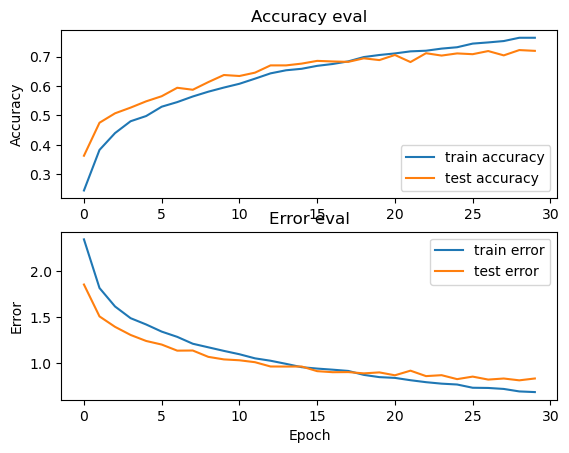

79/79 - 0s - loss: 0.8201 - accuracy: 0.7201 - 460ms/epoch - 6ms/step

Test accuracy: 0.720064103603363


In [127]:
if __name__ == "__main__":

    # get train, validation, test splits
    X_train, X_validation, X_test, y_train, y_validation, y_test = prepare_datasets(0.25, 0.2)

    # create network
    input_shape = (X_train.shape[1], X_train.shape[2], 1)
    model = build_model(input_shape)

    # compile model
    optimiser = keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(optimizer=optimiser,
loss='sparse_categorical_crossentropy',
metrics=['accuracy'])

    model.summary()

    # train model
    history = model.fit(X_train, y_train, validation_data=(X_validation, y_validation), batch_size=32, epochs=30)

    # plot accuracy/error for training and validation
    plot_history(history)

    # evaluate model on test set
    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
    print('\nTest accuracy:', test_acc)


In [136]:

# pick a sample to predict from the test set
X_to_predict = X_test[100]
y_to_predict = y_test[100]

# predict sample
predict(model, X_to_predict, y_to_predict)

1/1 [==============================] - 0s 22ms/step
Target: 6, Predicted label: [6]
